In [1]:
# !pip install opendatasets
# import opendatasets as od
# od.download(
#     "https://www.kaggle.com/datasets/wildlifedatasets/seaturtleid2022")
# !pip install -U albumentations
import json
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import os
import random
from pycocotools.coco import COCO
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
import torchvision
from torchvision.ops import box_iou
#from sklearn.metrics import confusion_matrix
import matplotlib.patches as patches
from pycocotools import mask as mask_utils
from collections import defaultdict
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm


required_categories = ["turtle", "flipper", "head"]
category_names = ["turtle", "flipper", "head"]  # Mistake found ! Make sure to maintain order


In [2]:


resize_transform = A.Compose(
    [
        A.Resize(600, 900, p=1),  # Resize to 900*600
        A.RandomBrightnessContrast(p=0.2),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),  # Converts to PyTorch tensor

    ],
    bbox_params=A.BboxParams(format="coco", label_fields=["category_ids"]),
)

In [3]:


class customTurtleDataset(Dataset):
    def __init__(self, root, annotation, transforms = None, target_size=(600, 900)):
        self.root = root
        self.coco = COCO(annotation)
        self.transforms = transforms
        self.img_ids = list(self.coco.imgs.keys())
        self.target_size = target_size
    def __len__(self):
        return len(self.img_ids)
    def __getitem__(self, idx):
        # Image params
        img_id = self.img_ids[idx]
        img_info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.root, img_info["file_name"])
        img = Image.open(img_path).convert("RGB")
        # Annotations
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)
        # BBox and category IDs
        bbox = [ann["bbox"] for ann in anns]
        category_ids = [ann["category_id"] for ann in anns]
        if category_ids.count(1) != category_ids.count(3):  # Assuming category IDs 1 and 3
            return None

        # Masks from annotations
        masks = []
        c=0
        for ann in anns:
            mask = self.coco.annToMask(ann)
            masks.append(mask) # add the individual mask to list
        # Apply transformations
        original_size = img.size
        image = np.array(img)
        if self.transforms and original_size != self.target_size:
            transformed = self.transforms(
                image=image, bboxes=bbox, masks = np.array(masks), category_ids=category_ids
            )
            image = transformed["image"]        # Resize image
            bbox = transformed["bboxes"]        # Resize bounding boxes
            masks = np.array(transformed["masks"])#[0]     # Resize masks
            category_ids = transformed['category_ids']
        else:
            image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)
            masks = torch.tensor(np.array(masks), dtype=torch.uint8)

        # Convert bounding boxes and category IDs to tensors
        bboxes = torch.tensor(bbox, dtype=torch.float32)
        category_ids = torch.tensor(category_ids, dtype=torch.int64)
        target = {}
        target["boxes"] = bboxes
        target["labels"] = category_ids
        target["masks"] = masks
        return image, target#, img_path



In [4]:

#print(f"using device: {device}")
def set_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True

set_seed(42)

In [ ]:
from torch.utils.data import random_split, DataLoader

cleaned_dataset = customTurtleDataset(
    root="/turtles-data/data",
    annotation="/turtles-data/data/updated_annotations.json",
    transforms = resize_transform
)

loading annotations into memory...
Done (t=4.81s)
creating index...
index created!


In [6]:
from torchvision.models.detection import maskrcnn_resnet50_fpn_v2, MaskRCNN
from torchvision.models.detection import MaskRCNN_ResNet50_FPN_V2_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
def get_maskrcnn_model(num_classes=4):
    # Load in a pretrained instance segmentation model from the COCO dataset
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights='DEFAULT', pretrained=True)
    # Number of input features, we change the pretrained Mask R-CNN model here to fit our turtle dataset.
    input_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(input_features, num_classes)
    input_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256  # Default hidden layer size is 256, no changes here.
    model.roi_heads.mask_predictor = MaskRCNNPredictor(input_features_mask, hidden_layer, num_classes)
    return model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = get_maskrcnn_model(4)   # classes = 4 (background, turtle, flipper, head)
model.to(device)


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [7]:

from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR
from torchvision.models.detection import MaskRCNN
from torchvision.models.detection.mask_rcnn import maskrcnn_resnet50_fpn
used_size = int(0.7* len(cleaned_dataset)) #using 70% of the whole dataset due to computational resource limit...
unused = len(cleaned_dataset) - used_size
used_set, _ = random_split(cleaned_dataset, [used_size, unused])
training_size = int(0.8* used_size)
test_size = used_size - training_size

train0_set, test_set = random_split(used_set, [training_size, test_size])
training_size = int(0.8 * len(train0_set))
validation_size = len(train0_set) - training_size
train_set, val_set = random_split(train0_set, [training_size, validation_size])
bs = 8
num_workers = 3
pin_memory = True if device.type == 'cuda' else False
# Define parameters for DataLoader
def custom_collate(batch):
    batch = [item for item in batch if item is not None]
    if not batch:
        return None
    return tuple(zip(*batch))
#https://christianjmills.com/posts/pytorch-train-mask-rcnn-tutorial/#fine-tuning-the-model
data_loader_params = {
    'batch_size': bs,  # Batch size
    'num_workers': num_workers,  # number of subprocesses
    'persistent_workers': True,
    'pin_memory': pin_memory,
    'collate_fn': custom_collate,
}
# Create DataLoader for training data. Data is shuffled for every epoch.
train_loader = DataLoader(train_set, **data_loader_params, shuffle=True)

# Create DataLoader for validation data. Shuffling is not necessary for validation data.
val_loader = DataLoader(val_set, **data_loader_params)

def bbox_transform(boxes):
    """Converts bounding boxes format.
    (x_min, y_min, width, height), shape (n, 4) ==> (x_min, y_min, x_max, y_max), shape (n, 4)
    """
    x_min, y_min, w, h = boxes.unbind(1)
    x_max = x_min + w
    y_max = y_min + h
    return torch.stack([x_min, y_min, x_max, y_max], dim=1)

# Training with validation
patience = 5
trigger_times = 0

def train_model(model, optimizer, data_loader, device):
    model.train()
    train_loss = 0

    for images, targets in tqdm(data_loader, desc="training", leave = False):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) if torch.is_tensor(v) else torch.tensor(v, device=device)
                    for k, v in t.items()} for t in targets]
        for target in targets:
            target['boxes'] = bbox_transform(target['boxes'])
        optimizer.zero_grad()
        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())

        losses.backward()
        optimizer.step()
        train_loss += losses.item()
    return train_loss / len(data_loader)


def validate(model, data_loader, device):
    val_loss = 0

    with torch.no_grad():
        for images, targets in tqdm(data_loader, desc=f" Validation"):
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) if torch.is_tensor(v) else torch.tensor(v, device=device)
                      for k, v in t.items()} for t in targets]
            for target in targets:
              target['boxes'] = bbox_transform(target['boxes'])
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            val_loss += losses.item()
    return val_loss / len(data_loader)

def train_and_validate(
    model, optimizer, lr_scheduler, train_loader, val_loader, device,
    num_epochs=14, patience=4
):
    best_val_loss = float('inf')
    patience_counter = 0
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")

        # Train
        train_loss = train_model(model, optimizer, train_loader, device)
        train_losses.append(train_loss)
        print(f"Training Loss: {train_loss:.4f}")
        torch.cuda.empty_cache()
        # Validation
        val_loss = validate(model, val_loader, device)
        val_losses.append(val_loss)
        print(f"Validation Loss: {val_loss:.4f}")

        # Step the learning rate scheduler
        lr_scheduler.step()

        # Early stop
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0  # reset patience if current val_loss gets smaller
            torch.save(model.state_dict(), "model.pth")  # Save model
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stop")
                break

    # Plot training and validation loss
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()




Epoch 1/14


Training Loss: 0.5947


 Validation:   0%|          | 0/122 [00:00<?, ?it/s]

{'loss_classifier': tensor(0.1115, device='cuda:0'), 'loss_box_reg': tensor(0.1769, device='cuda:0'), 'loss_mask': tensor(0.1175, device='cuda:0'), 'loss_objectness': tensor(0.0040, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0116, device='cuda:0')}


 Validation:   1%|          | 1/122 [00:01<03:49,  1.90s/it]

{'loss_classifier': tensor(0.1167, device='cuda:0'), 'loss_box_reg': tensor(0.1534, device='cuda:0'), 'loss_mask': tensor(0.1199, device='cuda:0'), 'loss_objectness': tensor(0.0155, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0105, device='cuda:0')}


 Validation:   2%|▏         | 2/122 [00:02<02:13,  1.11s/it]

{'loss_classifier': tensor(0.0725, device='cuda:0'), 'loss_box_reg': tensor(0.1461, device='cuda:0'), 'loss_mask': tensor(0.1026, device='cuda:0'), 'loss_objectness': tensor(0.0037, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0158, device='cuda:0')}


 Validation:   2%|▏         | 3/122 [00:02<01:39,  1.20it/s]

{'loss_classifier': tensor(0.0936, device='cuda:0'), 'loss_box_reg': tensor(0.1864, device='cuda:0'), 'loss_mask': tensor(0.1427, device='cuda:0'), 'loss_objectness': tensor(0.0044, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0072, device='cuda:0')}


 Validation:   3%|▎         | 4/122 [00:03<01:23,  1.41it/s]

{'loss_classifier': tensor(0.1377, device='cuda:0'), 'loss_box_reg': tensor(0.2035, device='cuda:0'), 'loss_mask': tensor(0.1440, device='cuda:0'), 'loss_objectness': tensor(0.0103, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0075, device='cuda:0')}


 Validation:   4%|▍         | 5/122 [00:04<01:16,  1.53it/s]

{'loss_classifier': tensor(0.1049, device='cuda:0'), 'loss_box_reg': tensor(0.2059, device='cuda:0'), 'loss_mask': tensor(0.1324, device='cuda:0'), 'loss_objectness': tensor(0.0071, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0079, device='cuda:0')}


 Validation:   5%|▍         | 6/122 [00:04<01:12,  1.60it/s]

{'loss_classifier': tensor(0.0881, device='cuda:0'), 'loss_box_reg': tensor(0.1369, device='cuda:0'), 'loss_mask': tensor(0.1173, device='cuda:0'), 'loss_objectness': tensor(0.0142, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0083, device='cuda:0')}


 Validation:   6%|▌         | 7/122 [00:05<01:09,  1.66it/s]

{'loss_classifier': tensor(0.0672, device='cuda:0'), 'loss_box_reg': tensor(0.1434, device='cuda:0'), 'loss_mask': tensor(0.1109, device='cuda:0'), 'loss_objectness': tensor(0.0044, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0107, device='cuda:0')}


 Validation:   7%|▋         | 8/122 [00:05<01:07,  1.70it/s]

{'loss_classifier': tensor(0.0962, device='cuda:0'), 'loss_box_reg': tensor(0.1884, device='cuda:0'), 'loss_mask': tensor(0.1097, device='cuda:0'), 'loss_objectness': tensor(0.0053, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0108, device='cuda:0')}


 Validation:   7%|▋         | 9/122 [00:06<01:05,  1.72it/s]

{'loss_classifier': tensor(0.1579, device='cuda:0'), 'loss_box_reg': tensor(0.1991, device='cuda:0'), 'loss_mask': tensor(0.1417, device='cuda:0'), 'loss_objectness': tensor(0.0198, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0187, device='cuda:0')}


 Validation:   8%|▊         | 10/122 [00:06<01:04,  1.74it/s]

{'loss_classifier': tensor(0.0918, device='cuda:0'), 'loss_box_reg': tensor(0.1985, device='cuda:0'), 'loss_mask': tensor(0.1242, device='cuda:0'), 'loss_objectness': tensor(0.0043, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0142, device='cuda:0')}


 Validation:   9%|▉         | 11/122 [00:07<01:03,  1.75it/s]

{'loss_classifier': tensor(0.1003, device='cuda:0'), 'loss_box_reg': tensor(0.2203, device='cuda:0'), 'loss_mask': tensor(0.1345, device='cuda:0'), 'loss_objectness': tensor(0.0060, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0099, device='cuda:0')}


 Validation:  10%|▉         | 12/122 [00:07<01:02,  1.75it/s]

{'loss_classifier': tensor(0.0786, device='cuda:0'), 'loss_box_reg': tensor(0.1540, device='cuda:0'), 'loss_mask': tensor(0.1030, device='cuda:0'), 'loss_objectness': tensor(0.0043, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0061, device='cuda:0')}


 Validation:  11%|█         | 13/122 [00:08<01:02,  1.74it/s]

{'loss_classifier': tensor(0.1140, device='cuda:0'), 'loss_box_reg': tensor(0.2335, device='cuda:0'), 'loss_mask': tensor(0.1397, device='cuda:0'), 'loss_objectness': tensor(0.0126, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0108, device='cuda:0')}


 Validation:  11%|█▏        | 14/122 [00:09<01:01,  1.75it/s]

{'loss_classifier': tensor(0.1001, device='cuda:0'), 'loss_box_reg': tensor(0.1593, device='cuda:0'), 'loss_mask': tensor(0.1276, device='cuda:0'), 'loss_objectness': tensor(0.0065, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0155, device='cuda:0')}


 Validation:  12%|█▏        | 15/122 [00:09<01:00,  1.76it/s]

{'loss_classifier': tensor(0.1371, device='cuda:0'), 'loss_box_reg': tensor(0.1904, device='cuda:0'), 'loss_mask': tensor(0.1542, device='cuda:0'), 'loss_objectness': tensor(0.0222, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0151, device='cuda:0')}


 Validation:  13%|█▎        | 16/122 [00:10<00:59,  1.77it/s]

{'loss_classifier': tensor(0.1036, device='cuda:0'), 'loss_box_reg': tensor(0.1992, device='cuda:0'), 'loss_mask': tensor(0.1245, device='cuda:0'), 'loss_objectness': tensor(0.0039, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0092, device='cuda:0')}


 Validation:  14%|█▍        | 17/122 [00:10<00:59,  1.76it/s]

{'loss_classifier': tensor(0.0889, device='cuda:0'), 'loss_box_reg': tensor(0.1659, device='cuda:0'), 'loss_mask': tensor(0.1089, device='cuda:0'), 'loss_objectness': tensor(0.0105, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0165, device='cuda:0')}


 Validation:  15%|█▍        | 18/122 [00:11<00:59,  1.75it/s]

{'loss_classifier': tensor(0.1512, device='cuda:0'), 'loss_box_reg': tensor(0.1969, device='cuda:0'), 'loss_mask': tensor(0.1215, device='cuda:0'), 'loss_objectness': tensor(0.0179, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0124, device='cuda:0')}


 Validation:  16%|█▌        | 19/122 [00:11<00:58,  1.76it/s]

{'loss_classifier': tensor(0.1322, device='cuda:0'), 'loss_box_reg': tensor(0.2098, device='cuda:0'), 'loss_mask': tensor(0.1091, device='cuda:0'), 'loss_objectness': tensor(0.0636, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0161, device='cuda:0')}


 Validation:  16%|█▋        | 20/122 [00:12<00:58,  1.76it/s]

{'loss_classifier': tensor(0.0871, device='cuda:0'), 'loss_box_reg': tensor(0.1780, device='cuda:0'), 'loss_mask': tensor(0.1037, device='cuda:0'), 'loss_objectness': tensor(0.0050, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0084, device='cuda:0')}


 Validation:  17%|█▋        | 21/122 [00:13<00:57,  1.76it/s]

{'loss_classifier': tensor(0.0886, device='cuda:0'), 'loss_box_reg': tensor(0.1715, device='cuda:0'), 'loss_mask': tensor(0.1205, device='cuda:0'), 'loss_objectness': tensor(0.0053, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0131, device='cuda:0')}


 Validation:  18%|█▊        | 22/122 [00:13<00:54,  1.84it/s]

{'loss_classifier': tensor(0.1375, device='cuda:0'), 'loss_box_reg': tensor(0.2025, device='cuda:0'), 'loss_mask': tensor(0.1331, device='cuda:0'), 'loss_objectness': tensor(0.0116, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0095, device='cuda:0')}


 Validation:  19%|█▉        | 23/122 [00:14<00:54,  1.81it/s]

{'loss_classifier': tensor(0.0982, device='cuda:0'), 'loss_box_reg': tensor(0.1709, device='cuda:0'), 'loss_mask': tensor(0.0998, device='cuda:0'), 'loss_objectness': tensor(0.0066, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0081, device='cuda:0')}


 Validation:  20%|█▉        | 24/122 [00:14<00:54,  1.79it/s]

{'loss_classifier': tensor(0.0832, device='cuda:0'), 'loss_box_reg': tensor(0.1240, device='cuda:0'), 'loss_mask': tensor(0.0850, device='cuda:0'), 'loss_objectness': tensor(0.0091, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0240, device='cuda:0')}


 Validation:  20%|██        | 25/122 [00:15<00:51,  1.87it/s]

{'loss_classifier': tensor(0.1158, device='cuda:0'), 'loss_box_reg': tensor(0.1912, device='cuda:0'), 'loss_mask': tensor(0.1223, device='cuda:0'), 'loss_objectness': tensor(0.0285, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0138, device='cuda:0')}


 Validation:  21%|██▏       | 26/122 [00:15<00:52,  1.84it/s]

{'loss_classifier': tensor(0.0841, device='cuda:0'), 'loss_box_reg': tensor(0.1494, device='cuda:0'), 'loss_mask': tensor(0.0884, device='cuda:0'), 'loss_objectness': tensor(0.0039, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0145, device='cuda:0')}


 Validation:  22%|██▏       | 27/122 [00:16<00:50,  1.89it/s]

{'loss_classifier': tensor(0.1468, device='cuda:0'), 'loss_box_reg': tensor(0.2289, device='cuda:0'), 'loss_mask': tensor(0.1869, device='cuda:0'), 'loss_objectness': tensor(0.0085, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0098, device='cuda:0')}


 Validation:  23%|██▎       | 28/122 [00:16<00:48,  1.92it/s]

{'loss_classifier': tensor(0.1842, device='cuda:0'), 'loss_box_reg': tensor(0.1834, device='cuda:0'), 'loss_mask': tensor(0.1067, device='cuda:0'), 'loss_objectness': tensor(0.0284, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0111, device='cuda:0')}


 Validation:  24%|██▍       | 29/122 [00:17<00:49,  1.88it/s]

{'loss_classifier': tensor(0.0742, device='cuda:0'), 'loss_box_reg': tensor(0.1678, device='cuda:0'), 'loss_mask': tensor(0.1308, device='cuda:0'), 'loss_objectness': tensor(0.0028, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0100, device='cuda:0')}


 Validation:  25%|██▍       | 30/122 [00:17<00:49,  1.85it/s]

{'loss_classifier': tensor(0.1185, device='cuda:0'), 'loss_box_reg': tensor(0.1931, device='cuda:0'), 'loss_mask': tensor(0.1394, device='cuda:0'), 'loss_objectness': tensor(0.0041, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0076, device='cuda:0')}


 Validation:  25%|██▌       | 31/122 [00:18<00:49,  1.83it/s]

{'loss_classifier': tensor(0.0691, device='cuda:0'), 'loss_box_reg': tensor(0.1405, device='cuda:0'), 'loss_mask': tensor(0.0902, device='cuda:0'), 'loss_objectness': tensor(0.0046, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0070, device='cuda:0')}


 Validation:  26%|██▌       | 32/122 [00:18<00:47,  1.89it/s]

{'loss_classifier': tensor(0.0899, device='cuda:0'), 'loss_box_reg': tensor(0.1884, device='cuda:0'), 'loss_mask': tensor(0.0961, device='cuda:0'), 'loss_objectness': tensor(0.0109, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0176, device='cuda:0')}


 Validation:  27%|██▋       | 33/122 [00:19<00:48,  1.83it/s]

{'loss_classifier': tensor(0.0937, device='cuda:0'), 'loss_box_reg': tensor(0.1853, device='cuda:0'), 'loss_mask': tensor(0.1153, device='cuda:0'), 'loss_objectness': tensor(0.0059, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0165, device='cuda:0')}


 Validation:  28%|██▊       | 34/122 [00:20<00:48,  1.81it/s]

{'loss_classifier': tensor(0.0866, device='cuda:0'), 'loss_box_reg': tensor(0.1703, device='cuda:0'), 'loss_mask': tensor(0.1121, device='cuda:0'), 'loss_objectness': tensor(0.0062, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0141, device='cuda:0')}


 Validation:  29%|██▊       | 35/122 [00:20<00:46,  1.87it/s]

{'loss_classifier': tensor(0.1265, device='cuda:0'), 'loss_box_reg': tensor(0.1879, device='cuda:0'), 'loss_mask': tensor(0.1772, device='cuda:0'), 'loss_objectness': tensor(0.0096, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0112, device='cuda:0')}


 Validation:  30%|██▉       | 36/122 [00:21<00:44,  1.92it/s]

{'loss_classifier': tensor(0.0733, device='cuda:0'), 'loss_box_reg': tensor(0.1634, device='cuda:0'), 'loss_mask': tensor(0.1033, device='cuda:0'), 'loss_objectness': tensor(0.0047, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0065, device='cuda:0')}


 Validation:  30%|███       | 37/122 [00:21<00:45,  1.87it/s]

{'loss_classifier': tensor(0.1403, device='cuda:0'), 'loss_box_reg': tensor(0.2355, device='cuda:0'), 'loss_mask': tensor(0.1382, device='cuda:0'), 'loss_objectness': tensor(0.0125, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0110, device='cuda:0')}


 Validation:  31%|███       | 38/122 [00:22<00:45,  1.83it/s]

{'loss_classifier': tensor(0.1003, device='cuda:0'), 'loss_box_reg': tensor(0.1831, device='cuda:0'), 'loss_mask': tensor(0.1072, device='cuda:0'), 'loss_objectness': tensor(0.0048, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0068, device='cuda:0')}


 Validation:  32%|███▏      | 39/122 [00:22<00:44,  1.87it/s]

{'loss_classifier': tensor(0.0832, device='cuda:0'), 'loss_box_reg': tensor(0.1685, device='cuda:0'), 'loss_mask': tensor(0.0952, device='cuda:0'), 'loss_objectness': tensor(0.0034, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0077, device='cuda:0')}


 Validation:  33%|███▎      | 40/122 [00:23<00:45,  1.82it/s]

{'loss_classifier': tensor(0.0960, device='cuda:0'), 'loss_box_reg': tensor(0.1919, device='cuda:0'), 'loss_mask': tensor(0.0944, device='cuda:0'), 'loss_objectness': tensor(0.0106, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0091, device='cuda:0')}


 Validation:  34%|███▎      | 41/122 [00:23<00:43,  1.87it/s]

{'loss_classifier': tensor(0.1053, device='cuda:0'), 'loss_box_reg': tensor(0.1780, device='cuda:0'), 'loss_mask': tensor(0.1081, device='cuda:0'), 'loss_objectness': tensor(0.0116, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0097, device='cuda:0')}


 Validation:  34%|███▍      | 42/122 [00:24<00:41,  1.92it/s]

{'loss_classifier': tensor(0.1145, device='cuda:0'), 'loss_box_reg': tensor(0.1982, device='cuda:0'), 'loss_mask': tensor(0.1172, device='cuda:0'), 'loss_objectness': tensor(0.0088, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0142, device='cuda:0')}


 Validation:  35%|███▌      | 43/122 [00:24<00:42,  1.86it/s]

{'loss_classifier': tensor(0.0920, device='cuda:0'), 'loss_box_reg': tensor(0.1959, device='cuda:0'), 'loss_mask': tensor(0.1216, device='cuda:0'), 'loss_objectness': tensor(0.0078, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0073, device='cuda:0')}


 Validation:  36%|███▌      | 44/122 [00:25<00:42,  1.83it/s]

{'loss_classifier': tensor(0.1323, device='cuda:0'), 'loss_box_reg': tensor(0.1966, device='cuda:0'), 'loss_mask': tensor(0.1115, device='cuda:0'), 'loss_objectness': tensor(0.0155, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0126, device='cuda:0')}


 Validation:  37%|███▋      | 45/122 [00:26<00:42,  1.81it/s]

{'loss_classifier': tensor(0.1423, device='cuda:0'), 'loss_box_reg': tensor(0.2153, device='cuda:0'), 'loss_mask': tensor(0.1398, device='cuda:0'), 'loss_objectness': tensor(0.0174, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0147, device='cuda:0')}


 Validation:  38%|███▊      | 46/122 [00:26<00:42,  1.80it/s]

{'loss_classifier': tensor(0.0813, device='cuda:0'), 'loss_box_reg': tensor(0.1493, device='cuda:0'), 'loss_mask': tensor(0.1303, device='cuda:0'), 'loss_objectness': tensor(0.0125, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0137, device='cuda:0')}


 Validation:  39%|███▊      | 47/122 [00:27<00:40,  1.87it/s]

{'loss_classifier': tensor(0.0924, device='cuda:0'), 'loss_box_reg': tensor(0.1859, device='cuda:0'), 'loss_mask': tensor(0.1303, device='cuda:0'), 'loss_objectness': tensor(0.0056, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0104, device='cuda:0')}


 Validation:  39%|███▉      | 48/122 [00:27<00:38,  1.92it/s]

{'loss_classifier': tensor(0.0916, device='cuda:0'), 'loss_box_reg': tensor(0.1936, device='cuda:0'), 'loss_mask': tensor(0.1256, device='cuda:0'), 'loss_objectness': tensor(0.0132, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0060, device='cuda:0')}


 Validation:  40%|████      | 49/122 [00:28<00:37,  1.94it/s]

{'loss_classifier': tensor(0.0878, device='cuda:0'), 'loss_box_reg': tensor(0.1513, device='cuda:0'), 'loss_mask': tensor(0.1139, device='cuda:0'), 'loss_objectness': tensor(0.0084, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0122, device='cuda:0')}


 Validation:  41%|████      | 50/122 [00:28<00:38,  1.89it/s]

{'loss_classifier': tensor(0.1426, device='cuda:0'), 'loss_box_reg': tensor(0.1977, device='cuda:0'), 'loss_mask': tensor(0.1347, device='cuda:0'), 'loss_objectness': tensor(0.0160, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0181, device='cuda:0')}


 Validation:  42%|████▏     | 51/122 [00:29<00:38,  1.84it/s]

{'loss_classifier': tensor(0.1126, device='cuda:0'), 'loss_box_reg': tensor(0.2007, device='cuda:0'), 'loss_mask': tensor(0.1246, device='cuda:0'), 'loss_objectness': tensor(0.0053, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0081, device='cuda:0')}


 Validation:  43%|████▎     | 52/122 [00:29<00:36,  1.90it/s]

{'loss_classifier': tensor(0.1206, device='cuda:0'), 'loss_box_reg': tensor(0.2137, device='cuda:0'), 'loss_mask': tensor(0.1381, device='cuda:0'), 'loss_objectness': tensor(0.0141, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0081, device='cuda:0')}


 Validation:  43%|████▎     | 53/122 [00:30<00:36,  1.91it/s]

{'loss_classifier': tensor(0.0872, device='cuda:0'), 'loss_box_reg': tensor(0.1501, device='cuda:0'), 'loss_mask': tensor(0.0951, device='cuda:0'), 'loss_objectness': tensor(0.0197, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0093, device='cuda:0')}


 Validation:  44%|████▍     | 54/122 [00:30<00:36,  1.87it/s]

{'loss_classifier': tensor(0.1312, device='cuda:0'), 'loss_box_reg': tensor(0.2065, device='cuda:0'), 'loss_mask': tensor(0.1289, device='cuda:0'), 'loss_objectness': tensor(0.0125, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0078, device='cuda:0')}


 Validation:  45%|████▌     | 55/122 [00:31<00:36,  1.84it/s]

{'loss_classifier': tensor(0.1788, device='cuda:0'), 'loss_box_reg': tensor(0.1565, device='cuda:0'), 'loss_mask': tensor(0.1755, device='cuda:0'), 'loss_objectness': tensor(0.2031, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0864, device='cuda:0')}


 Validation:  46%|████▌     | 56/122 [00:31<00:33,  1.98it/s]

{'loss_classifier': tensor(0.0958, device='cuda:0'), 'loss_box_reg': tensor(0.1608, device='cuda:0'), 'loss_mask': tensor(0.1123, device='cuda:0'), 'loss_objectness': tensor(0.0035, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0071, device='cuda:0')}


 Validation:  47%|████▋     | 57/122 [00:32<00:34,  1.88it/s]

{'loss_classifier': tensor(0.1093, device='cuda:0'), 'loss_box_reg': tensor(0.2144, device='cuda:0'), 'loss_mask': tensor(0.1044, device='cuda:0'), 'loss_objectness': tensor(0.0073, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0088, device='cuda:0')}


 Validation:  48%|████▊     | 58/122 [00:32<00:34,  1.84it/s]

{'loss_classifier': tensor(0.1107, device='cuda:0'), 'loss_box_reg': tensor(0.2137, device='cuda:0'), 'loss_mask': tensor(0.1377, device='cuda:0'), 'loss_objectness': tensor(0.0180, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0254, device='cuda:0')}


 Validation:  48%|████▊     | 59/122 [00:33<00:31,  1.97it/s]

{'loss_classifier': tensor(0.1973, device='cuda:0'), 'loss_box_reg': tensor(0.2156, device='cuda:0'), 'loss_mask': tensor(0.1446, device='cuda:0'), 'loss_objectness': tensor(0.0225, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0111, device='cuda:0')}


 Validation:  49%|████▉     | 60/122 [00:33<00:32,  1.89it/s]

{'loss_classifier': tensor(0.0866, device='cuda:0'), 'loss_box_reg': tensor(0.1777, device='cuda:0'), 'loss_mask': tensor(0.1118, device='cuda:0'), 'loss_objectness': tensor(0.0117, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0079, device='cuda:0')}


 Validation:  50%|█████     | 61/122 [00:34<00:32,  1.85it/s]

{'loss_classifier': tensor(0.0935, device='cuda:0'), 'loss_box_reg': tensor(0.1843, device='cuda:0'), 'loss_mask': tensor(0.1156, device='cuda:0'), 'loss_objectness': tensor(0.0421, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0142, device='cuda:0')}


 Validation:  51%|█████     | 62/122 [00:35<00:32,  1.82it/s]

{'loss_classifier': tensor(0.0910, device='cuda:0'), 'loss_box_reg': tensor(0.2062, device='cuda:0'), 'loss_mask': tensor(0.1274, device='cuda:0'), 'loss_objectness': tensor(0.0041, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0060, device='cuda:0')}


 Validation:  52%|█████▏    | 63/122 [00:35<00:32,  1.80it/s]

{'loss_classifier': tensor(0.1194, device='cuda:0'), 'loss_box_reg': tensor(0.1652, device='cuda:0'), 'loss_mask': tensor(0.1241, device='cuda:0'), 'loss_objectness': tensor(0.0160, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0202, device='cuda:0')}


 Validation:  52%|█████▏    | 64/122 [00:36<00:32,  1.79it/s]

{'loss_classifier': tensor(0.0835, device='cuda:0'), 'loss_box_reg': tensor(0.1822, device='cuda:0'), 'loss_mask': tensor(0.1035, device='cuda:0'), 'loss_objectness': tensor(0.0050, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0108, device='cuda:0')}


 Validation:  53%|█████▎    | 65/122 [00:36<00:32,  1.78it/s]

{'loss_classifier': tensor(0.0710, device='cuda:0'), 'loss_box_reg': tensor(0.1696, device='cuda:0'), 'loss_mask': tensor(0.1418, device='cuda:0'), 'loss_objectness': tensor(0.0046, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0051, device='cuda:0')}


 Validation:  54%|█████▍    | 66/122 [00:37<00:30,  1.83it/s]

{'loss_classifier': tensor(0.1090, device='cuda:0'), 'loss_box_reg': tensor(0.1772, device='cuda:0'), 'loss_mask': tensor(0.1506, device='cuda:0'), 'loss_objectness': tensor(0.0151, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0098, device='cuda:0')}


 Validation:  55%|█████▍    | 67/122 [00:37<00:30,  1.82it/s]

{'loss_classifier': tensor(0.0775, device='cuda:0'), 'loss_box_reg': tensor(0.1815, device='cuda:0'), 'loss_mask': tensor(0.1023, device='cuda:0'), 'loss_objectness': tensor(0.0023, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0071, device='cuda:0')}


 Validation:  56%|█████▌    | 68/122 [00:38<00:29,  1.80it/s]

{'loss_classifier': tensor(0.0909, device='cuda:0'), 'loss_box_reg': tensor(0.1517, device='cuda:0'), 'loss_mask': tensor(0.1132, device='cuda:0'), 'loss_objectness': tensor(0.0150, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0114, device='cuda:0')}


 Validation:  57%|█████▋    | 69/122 [00:38<00:29,  1.80it/s]

{'loss_classifier': tensor(0.1043, device='cuda:0'), 'loss_box_reg': tensor(0.1741, device='cuda:0'), 'loss_mask': tensor(0.1035, device='cuda:0'), 'loss_objectness': tensor(0.0044, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0074, device='cuda:0')}


 Validation:  57%|█████▋    | 70/122 [00:39<00:29,  1.79it/s]

{'loss_classifier': tensor(0.1278, device='cuda:0'), 'loss_box_reg': tensor(0.2203, device='cuda:0'), 'loss_mask': tensor(0.1278, device='cuda:0'), 'loss_objectness': tensor(0.0100, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0157, device='cuda:0')}


 Validation:  58%|█████▊    | 71/122 [00:40<00:28,  1.77it/s]

{'loss_classifier': tensor(0.1445, device='cuda:0'), 'loss_box_reg': tensor(0.2081, device='cuda:0'), 'loss_mask': tensor(0.1504, device='cuda:0'), 'loss_objectness': tensor(0.1103, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0232, device='cuda:0')}


 Validation:  59%|█████▉    | 72/122 [00:40<00:28,  1.78it/s]

{'loss_classifier': tensor(0.0551, device='cuda:0'), 'loss_box_reg': tensor(0.1290, device='cuda:0'), 'loss_mask': tensor(0.0872, device='cuda:0'), 'loss_objectness': tensor(0.0045, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0078, device='cuda:0')}


 Validation:  60%|█████▉    | 73/122 [00:41<00:27,  1.78it/s]

{'loss_classifier': tensor(0.0728, device='cuda:0'), 'loss_box_reg': tensor(0.1425, device='cuda:0'), 'loss_mask': tensor(0.0933, device='cuda:0'), 'loss_objectness': tensor(0.0080, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0076, device='cuda:0')}


 Validation:  61%|██████    | 74/122 [00:41<00:26,  1.78it/s]

{'loss_classifier': tensor(0.1388, device='cuda:0'), 'loss_box_reg': tensor(0.2073, device='cuda:0'), 'loss_mask': tensor(0.1298, device='cuda:0'), 'loss_objectness': tensor(0.0063, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0153, device='cuda:0')}


 Validation:  61%|██████▏   | 75/122 [00:42<00:26,  1.77it/s]

{'loss_classifier': tensor(0.0816, device='cuda:0'), 'loss_box_reg': tensor(0.1631, device='cuda:0'), 'loss_mask': tensor(0.0989, device='cuda:0'), 'loss_objectness': tensor(0.0035, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0071, device='cuda:0')}


 Validation:  62%|██████▏   | 76/122 [00:42<00:25,  1.77it/s]

{'loss_classifier': tensor(0.1392, device='cuda:0'), 'loss_box_reg': tensor(0.2180, device='cuda:0'), 'loss_mask': tensor(0.1326, device='cuda:0'), 'loss_objectness': tensor(0.0230, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0212, device='cuda:0')}


 Validation:  63%|██████▎   | 77/122 [00:43<00:25,  1.78it/s]

{'loss_classifier': tensor(0.1169, device='cuda:0'), 'loss_box_reg': tensor(0.1839, device='cuda:0'), 'loss_mask': tensor(0.1175, device='cuda:0'), 'loss_objectness': tensor(0.0118, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0270, device='cuda:0')}


 Validation:  64%|██████▍   | 78/122 [00:44<00:24,  1.78it/s]

{'loss_classifier': tensor(0.1824, device='cuda:0'), 'loss_box_reg': tensor(0.2389, device='cuda:0'), 'loss_mask': tensor(0.1289, device='cuda:0'), 'loss_objectness': tensor(0.0216, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0126, device='cuda:0')}


 Validation:  65%|██████▍   | 79/122 [00:44<00:24,  1.77it/s]

{'loss_classifier': tensor(0.1259, device='cuda:0'), 'loss_box_reg': tensor(0.2155, device='cuda:0'), 'loss_mask': tensor(0.1458, device='cuda:0'), 'loss_objectness': tensor(0.0093, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0134, device='cuda:0')}


 Validation:  66%|██████▌   | 80/122 [00:45<00:22,  1.84it/s]

{'loss_classifier': tensor(0.1139, device='cuda:0'), 'loss_box_reg': tensor(0.1996, device='cuda:0'), 'loss_mask': tensor(0.1577, device='cuda:0'), 'loss_objectness': tensor(0.0088, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0146, device='cuda:0')}


 Validation:  66%|██████▋   | 81/122 [00:45<00:22,  1.82it/s]

{'loss_classifier': tensor(0.1554, device='cuda:0'), 'loss_box_reg': tensor(0.2147, device='cuda:0'), 'loss_mask': tensor(0.1369, device='cuda:0'), 'loss_objectness': tensor(0.0120, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0146, device='cuda:0')}


 Validation:  67%|██████▋   | 82/122 [00:46<00:21,  1.87it/s]

{'loss_classifier': tensor(0.1135, device='cuda:0'), 'loss_box_reg': tensor(0.2379, device='cuda:0'), 'loss_mask': tensor(0.1215, device='cuda:0'), 'loss_objectness': tensor(0.0044, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0110, device='cuda:0')}


 Validation:  68%|██████▊   | 83/122 [00:46<00:21,  1.83it/s]

{'loss_classifier': tensor(0.1293, device='cuda:0'), 'loss_box_reg': tensor(0.2204, device='cuda:0'), 'loss_mask': tensor(0.1474, device='cuda:0'), 'loss_objectness': tensor(0.0101, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0109, device='cuda:0')}


 Validation:  69%|██████▉   | 84/122 [00:47<00:20,  1.81it/s]

{'loss_classifier': tensor(0.1110, device='cuda:0'), 'loss_box_reg': tensor(0.1967, device='cuda:0'), 'loss_mask': tensor(0.1169, device='cuda:0'), 'loss_objectness': tensor(0.0045, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0118, device='cuda:0')}


 Validation:  70%|██████▉   | 85/122 [00:47<00:20,  1.80it/s]

{'loss_classifier': tensor(0.0956, device='cuda:0'), 'loss_box_reg': tensor(0.1833, device='cuda:0'), 'loss_mask': tensor(0.1785, device='cuda:0'), 'loss_objectness': tensor(0.0372, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0112, device='cuda:0')}


 Validation:  70%|███████   | 86/122 [00:48<00:20,  1.79it/s]

{'loss_classifier': tensor(0.0984, device='cuda:0'), 'loss_box_reg': tensor(0.1943, device='cuda:0'), 'loss_mask': tensor(0.1031, device='cuda:0'), 'loss_objectness': tensor(0.0022, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0066, device='cuda:0')}


 Validation:  71%|███████▏  | 87/122 [00:48<00:19,  1.78it/s]

{'loss_classifier': tensor(0.0874, device='cuda:0'), 'loss_box_reg': tensor(0.1477, device='cuda:0'), 'loss_mask': tensor(0.1105, device='cuda:0'), 'loss_objectness': tensor(0.0235, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0162, device='cuda:0')}


 Validation:  72%|███████▏  | 88/122 [00:49<00:18,  1.84it/s]

{'loss_classifier': tensor(0.1233, device='cuda:0'), 'loss_box_reg': tensor(0.2009, device='cuda:0'), 'loss_mask': tensor(0.1251, device='cuda:0'), 'loss_objectness': tensor(0.0071, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0080, device='cuda:0')}


 Validation:  73%|███████▎  | 89/122 [00:50<00:18,  1.79it/s]

{'loss_classifier': tensor(0.0916, device='cuda:0'), 'loss_box_reg': tensor(0.1780, device='cuda:0'), 'loss_mask': tensor(0.0987, device='cuda:0'), 'loss_objectness': tensor(0.0045, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0088, device='cuda:0')}


 Validation:  74%|███████▍  | 90/122 [00:50<00:17,  1.78it/s]

{'loss_classifier': tensor(0.1379, device='cuda:0'), 'loss_box_reg': tensor(0.1939, device='cuda:0'), 'loss_mask': tensor(0.1370, device='cuda:0'), 'loss_objectness': tensor(0.0328, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0346, device='cuda:0')}


 Validation:  75%|███████▍  | 91/122 [00:51<00:17,  1.77it/s]

{'loss_classifier': tensor(0.1017, device='cuda:0'), 'loss_box_reg': tensor(0.1478, device='cuda:0'), 'loss_mask': tensor(0.0991, device='cuda:0'), 'loss_objectness': tensor(0.0104, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0108, device='cuda:0')}


 Validation:  75%|███████▌  | 92/122 [00:51<00:16,  1.84it/s]

{'loss_classifier': tensor(0.1170, device='cuda:0'), 'loss_box_reg': tensor(0.2452, device='cuda:0'), 'loss_mask': tensor(0.1492, device='cuda:0'), 'loss_objectness': tensor(0.0133, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0200, device='cuda:0')}


 Validation:  76%|███████▌  | 93/122 [00:52<00:16,  1.78it/s]

{'loss_classifier': tensor(0.2096, device='cuda:0'), 'loss_box_reg': tensor(0.2266, device='cuda:0'), 'loss_mask': tensor(0.1284, device='cuda:0'), 'loss_objectness': tensor(0.0379, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0181, device='cuda:0')}


 Validation:  77%|███████▋  | 94/122 [00:52<00:16,  1.75it/s]

{'loss_classifier': tensor(0.1194, device='cuda:0'), 'loss_box_reg': tensor(0.2120, device='cuda:0'), 'loss_mask': tensor(0.1285, device='cuda:0'), 'loss_objectness': tensor(0.0050, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0104, device='cuda:0')}


 Validation:  78%|███████▊  | 95/122 [00:53<00:15,  1.76it/s]

{'loss_classifier': tensor(0.0792, device='cuda:0'), 'loss_box_reg': tensor(0.1584, device='cuda:0'), 'loss_mask': tensor(0.1189, device='cuda:0'), 'loss_objectness': tensor(0.0052, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0111, device='cuda:0')}


 Validation:  79%|███████▊  | 96/122 [00:54<00:14,  1.77it/s]

{'loss_classifier': tensor(0.0887, device='cuda:0'), 'loss_box_reg': tensor(0.1613, device='cuda:0'), 'loss_mask': tensor(0.1009, device='cuda:0'), 'loss_objectness': tensor(0.0064, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0078, device='cuda:0')}


 Validation:  80%|███████▉  | 97/122 [00:54<00:14,  1.77it/s]

{'loss_classifier': tensor(0.0892, device='cuda:0'), 'loss_box_reg': tensor(0.1797, device='cuda:0'), 'loss_mask': tensor(0.0961, device='cuda:0'), 'loss_objectness': tensor(0.0040, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0054, device='cuda:0')}


 Validation:  80%|████████  | 98/122 [00:55<00:13,  1.76it/s]

{'loss_classifier': tensor(0.0984, device='cuda:0'), 'loss_box_reg': tensor(0.2023, device='cuda:0'), 'loss_mask': tensor(0.1277, device='cuda:0'), 'loss_objectness': tensor(0.0068, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0092, device='cuda:0')}


 Validation:  81%|████████  | 99/122 [00:55<00:13,  1.76it/s]

{'loss_classifier': tensor(0.1146, device='cuda:0'), 'loss_box_reg': tensor(0.1748, device='cuda:0'), 'loss_mask': tensor(0.1214, device='cuda:0'), 'loss_objectness': tensor(0.0071, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0096, device='cuda:0')}


 Validation:  82%|████████▏ | 100/122 [00:56<00:12,  1.77it/s]

{'loss_classifier': tensor(0.0991, device='cuda:0'), 'loss_box_reg': tensor(0.1680, device='cuda:0'), 'loss_mask': tensor(0.1295, device='cuda:0'), 'loss_objectness': tensor(0.0070, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0125, device='cuda:0')}


 Validation:  83%|████████▎ | 101/122 [00:56<00:11,  1.78it/s]

{'loss_classifier': tensor(0.1193, device='cuda:0'), 'loss_box_reg': tensor(0.2131, device='cuda:0'), 'loss_mask': tensor(0.1086, device='cuda:0'), 'loss_objectness': tensor(0.0132, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0089, device='cuda:0')}


 Validation:  84%|████████▎ | 102/122 [00:57<00:11,  1.77it/s]

{'loss_classifier': tensor(0.0867, device='cuda:0'), 'loss_box_reg': tensor(0.1568, device='cuda:0'), 'loss_mask': tensor(0.0932, device='cuda:0'), 'loss_objectness': tensor(0.0032, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0064, device='cuda:0')}


 Validation:  84%|████████▍ | 103/122 [00:57<00:10,  1.77it/s]

{'loss_classifier': tensor(0.1150, device='cuda:0'), 'loss_box_reg': tensor(0.1989, device='cuda:0'), 'loss_mask': tensor(0.1222, device='cuda:0'), 'loss_objectness': tensor(0.0037, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0085, device='cuda:0')}


 Validation:  85%|████████▌ | 104/122 [00:58<00:10,  1.76it/s]

{'loss_classifier': tensor(0.0930, device='cuda:0'), 'loss_box_reg': tensor(0.1696, device='cuda:0'), 'loss_mask': tensor(0.0996, device='cuda:0'), 'loss_objectness': tensor(0.0057, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0079, device='cuda:0')}


 Validation:  86%|████████▌ | 105/122 [00:59<00:09,  1.76it/s]

{'loss_classifier': tensor(0.0938, device='cuda:0'), 'loss_box_reg': tensor(0.1784, device='cuda:0'), 'loss_mask': tensor(0.1339, device='cuda:0'), 'loss_objectness': tensor(0.0090, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0115, device='cuda:0')}


 Validation:  87%|████████▋ | 106/122 [00:59<00:09,  1.77it/s]

{'loss_classifier': tensor(0.1167, device='cuda:0'), 'loss_box_reg': tensor(0.1981, device='cuda:0'), 'loss_mask': tensor(0.1328, device='cuda:0'), 'loss_objectness': tensor(0.0087, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0067, device='cuda:0')}


 Validation:  88%|████████▊ | 107/122 [01:00<00:08,  1.77it/s]

{'loss_classifier': tensor(0.1114, device='cuda:0'), 'loss_box_reg': tensor(0.1912, device='cuda:0'), 'loss_mask': tensor(0.1393, device='cuda:0'), 'loss_objectness': tensor(0.0142, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0203, device='cuda:0')}


 Validation:  89%|████████▊ | 108/122 [01:00<00:07,  1.85it/s]

{'loss_classifier': tensor(0.0964, device='cuda:0'), 'loss_box_reg': tensor(0.1687, device='cuda:0'), 'loss_mask': tensor(0.1141, device='cuda:0'), 'loss_objectness': tensor(0.0064, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0134, device='cuda:0')}


 Validation:  89%|████████▉ | 109/122 [01:01<00:06,  1.89it/s]

{'loss_classifier': tensor(0.1410, device='cuda:0'), 'loss_box_reg': tensor(0.2007, device='cuda:0'), 'loss_mask': tensor(0.1523, device='cuda:0'), 'loss_objectness': tensor(0.0175, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0168, device='cuda:0')}


 Validation:  90%|█████████ | 110/122 [01:01<00:06,  1.94it/s]

{'loss_classifier': tensor(0.1092, device='cuda:0'), 'loss_box_reg': tensor(0.2015, device='cuda:0'), 'loss_mask': tensor(0.1367, device='cuda:0'), 'loss_objectness': tensor(0.0099, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0103, device='cuda:0')}


 Validation:  91%|█████████ | 111/122 [01:02<00:05,  1.88it/s]

{'loss_classifier': tensor(0.1148, device='cuda:0'), 'loss_box_reg': tensor(0.1622, device='cuda:0'), 'loss_mask': tensor(0.1039, device='cuda:0'), 'loss_objectness': tensor(0.0055, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0084, device='cuda:0')}


 Validation:  92%|█████████▏| 112/122 [01:02<00:05,  1.86it/s]

{'loss_classifier': tensor(0.1356, device='cuda:0'), 'loss_box_reg': tensor(0.1656, device='cuda:0'), 'loss_mask': tensor(0.1193, device='cuda:0'), 'loss_objectness': tensor(0.0113, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0218, device='cuda:0')}


 Validation:  93%|█████████▎| 113/122 [01:03<00:04,  1.84it/s]

{'loss_classifier': tensor(0.1534, device='cuda:0'), 'loss_box_reg': tensor(0.2385, device='cuda:0'), 'loss_mask': tensor(0.1307, device='cuda:0'), 'loss_objectness': tensor(0.0238, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0173, device='cuda:0')}


 Validation:  93%|█████████▎| 114/122 [01:03<00:04,  1.82it/s]

{'loss_classifier': tensor(0.1118, device='cuda:0'), 'loss_box_reg': tensor(0.1756, device='cuda:0'), 'loss_mask': tensor(0.1027, device='cuda:0'), 'loss_objectness': tensor(0.0154, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0245, device='cuda:0')}


 Validation:  94%|█████████▍| 115/122 [01:04<00:03,  1.81it/s]

{'loss_classifier': tensor(0.1122, device='cuda:0'), 'loss_box_reg': tensor(0.1808, device='cuda:0'), 'loss_mask': tensor(0.1172, device='cuda:0'), 'loss_objectness': tensor(0.0039, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0066, device='cuda:0')}


 Validation:  95%|█████████▌| 116/122 [01:05<00:03,  1.80it/s]

{'loss_classifier': tensor(0.0742, device='cuda:0'), 'loss_box_reg': tensor(0.1626, device='cuda:0'), 'loss_mask': tensor(0.1052, device='cuda:0'), 'loss_objectness': tensor(0.0025, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0048, device='cuda:0')}


 Validation:  96%|█████████▌| 117/122 [01:05<00:02,  1.79it/s]

{'loss_classifier': tensor(0.1293, device='cuda:0'), 'loss_box_reg': tensor(0.1643, device='cuda:0'), 'loss_mask': tensor(0.1065, device='cuda:0'), 'loss_objectness': tensor(0.0144, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0085, device='cuda:0')}


 Validation:  97%|█████████▋| 118/122 [01:06<00:02,  1.79it/s]

{'loss_classifier': tensor(0.1085, device='cuda:0'), 'loss_box_reg': tensor(0.1877, device='cuda:0'), 'loss_mask': tensor(0.1315, device='cuda:0'), 'loss_objectness': tensor(0.0033, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0083, device='cuda:0')}


 Validation:  98%|█████████▊| 119/122 [01:06<00:01,  1.86it/s]

{'loss_classifier': tensor(0.1243, device='cuda:0'), 'loss_box_reg': tensor(0.2069, device='cuda:0'), 'loss_mask': tensor(0.1272, device='cuda:0'), 'loss_objectness': tensor(0.0083, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0085, device='cuda:0')}


 Validation:  98%|█████████▊| 120/122 [01:07<00:01,  1.90it/s]

{'loss_classifier': tensor(0.0896, device='cuda:0'), 'loss_box_reg': tensor(0.1625, device='cuda:0'), 'loss_mask': tensor(0.1062, device='cuda:0'), 'loss_objectness': tensor(0.0065, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0115, device='cuda:0')}


 Validation:  99%|█████████▉| 121/122 [01:07<00:00,  1.87it/s]

{'loss_classifier': tensor(0.1339, device='cuda:0'), 'loss_box_reg': tensor(0.2207, device='cuda:0'), 'loss_mask': tensor(0.1356, device='cuda:0'), 'loss_objectness': tensor(0.0115, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0180, device='cuda:0')}


 Validation: 100%|██████████| 122/122 [01:08<00:00,  1.79it/s]

Validation Loss: 0.4436



Epoch 2/14


Training Loss: 0.3805


 Validation:   0%|          | 0/122 [00:00<?, ?it/s]

{'loss_classifier': tensor(0.0984, device='cuda:0'), 'loss_box_reg': tensor(0.1506, device='cuda:0'), 'loss_mask': tensor(0.0997, device='cuda:0'), 'loss_objectness': tensor(0.0035, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0101, device='cuda:0')}


 Validation:   1%|          | 1/122 [00:01<03:11,  1.58s/it]

{'loss_classifier': tensor(0.0943, device='cuda:0'), 'loss_box_reg': tensor(0.1292, device='cuda:0'), 'loss_mask': tensor(0.1095, device='cuda:0'), 'loss_objectness': tensor(0.0119, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0082, device='cuda:0')}


 Validation:   2%|▏         | 2/122 [00:02<01:57,  1.02it/s]

{'loss_classifier': tensor(0.0421, device='cuda:0'), 'loss_box_reg': tensor(0.1148, device='cuda:0'), 'loss_mask': tensor(0.0814, device='cuda:0'), 'loss_objectness': tensor(0.0028, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0104, device='cuda:0')}


 Validation:   2%|▏         | 3/122 [00:02<01:30,  1.32it/s]

{'loss_classifier': tensor(0.0755, device='cuda:0'), 'loss_box_reg': tensor(0.1500, device='cuda:0'), 'loss_mask': tensor(0.1221, device='cuda:0'), 'loss_objectness': tensor(0.0076, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0079, device='cuda:0')}


 Validation:   3%|▎         | 4/122 [00:03<01:17,  1.53it/s]

{'loss_classifier': tensor(0.1332, device='cuda:0'), 'loss_box_reg': tensor(0.1565, device='cuda:0'), 'loss_mask': tensor(0.1195, device='cuda:0'), 'loss_objectness': tensor(0.0067, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0066, device='cuda:0')}


 Validation:   4%|▍         | 5/122 [00:03<01:12,  1.61it/s]

{'loss_classifier': tensor(0.0804, device='cuda:0'), 'loss_box_reg': tensor(0.1607, device='cuda:0'), 'loss_mask': tensor(0.1148, device='cuda:0'), 'loss_objectness': tensor(0.0067, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0069, device='cuda:0')}


 Validation:   5%|▍         | 6/122 [00:04<01:09,  1.66it/s]

{'loss_classifier': tensor(0.0784, device='cuda:0'), 'loss_box_reg': tensor(0.1345, device='cuda:0'), 'loss_mask': tensor(0.1129, device='cuda:0'), 'loss_objectness': tensor(0.0145, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0076, device='cuda:0')}


 Validation:   6%|▌         | 7/122 [00:04<01:07,  1.70it/s]

{'loss_classifier': tensor(0.0518, device='cuda:0'), 'loss_box_reg': tensor(0.1094, device='cuda:0'), 'loss_mask': tensor(0.0863, device='cuda:0'), 'loss_objectness': tensor(0.0061, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0112, device='cuda:0')}


 Validation:   7%|▋         | 8/122 [00:05<01:06,  1.72it/s]

{'loss_classifier': tensor(0.0865, device='cuda:0'), 'loss_box_reg': tensor(0.1577, device='cuda:0'), 'loss_mask': tensor(0.0933, device='cuda:0'), 'loss_objectness': tensor(0.0102, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0084, device='cuda:0')}


 Validation:   7%|▋         | 9/122 [00:05<01:05,  1.74it/s]

{'loss_classifier': tensor(0.1122, device='cuda:0'), 'loss_box_reg': tensor(0.1698, device='cuda:0'), 'loss_mask': tensor(0.1451, device='cuda:0'), 'loss_objectness': tensor(0.0500, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0184, device='cuda:0')}


 Validation:   8%|▊         | 10/122 [00:06<01:03,  1.75it/s]

{'loss_classifier': tensor(0.0937, device='cuda:0'), 'loss_box_reg': tensor(0.1693, device='cuda:0'), 'loss_mask': tensor(0.1354, device='cuda:0'), 'loss_objectness': tensor(0.0110, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0167, device='cuda:0')}


 Validation:   9%|▉         | 11/122 [00:07<01:03,  1.76it/s]

{'loss_classifier': tensor(0.1017, device='cuda:0'), 'loss_box_reg': tensor(0.1967, device='cuda:0'), 'loss_mask': tensor(0.1355, device='cuda:0'), 'loss_objectness': tensor(0.0106, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0117, device='cuda:0')}


 Validation:  10%|▉         | 12/122 [00:07<01:02,  1.76it/s]

{'loss_classifier': tensor(0.0607, device='cuda:0'), 'loss_box_reg': tensor(0.1571, device='cuda:0'), 'loss_mask': tensor(0.1040, device='cuda:0'), 'loss_objectness': tensor(0.0074, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0067, device='cuda:0')}


 Validation:  11%|█         | 13/122 [00:08<01:02,  1.75it/s]

{'loss_classifier': tensor(0.0903, device='cuda:0'), 'loss_box_reg': tensor(0.1996, device='cuda:0'), 'loss_mask': tensor(0.1351, device='cuda:0'), 'loss_objectness': tensor(0.0115, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0093, device='cuda:0')}


 Validation:  11%|█▏        | 14/122 [00:08<01:01,  1.75it/s]

{'loss_classifier': tensor(0.0513, device='cuda:0'), 'loss_box_reg': tensor(0.1336, device='cuda:0'), 'loss_mask': tensor(0.0935, device='cuda:0'), 'loss_objectness': tensor(0.0033, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0126, device='cuda:0')}


 Validation:  12%|█▏        | 15/122 [00:09<01:00,  1.76it/s]

{'loss_classifier': tensor(0.1111, device='cuda:0'), 'loss_box_reg': tensor(0.1691, device='cuda:0'), 'loss_mask': tensor(0.1235, device='cuda:0'), 'loss_objectness': tensor(0.0133, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0125, device='cuda:0')}


 Validation:  13%|█▎        | 16/122 [00:09<00:59,  1.77it/s]

{'loss_classifier': tensor(0.0681, device='cuda:0'), 'loss_box_reg': tensor(0.1561, device='cuda:0'), 'loss_mask': tensor(0.1123, device='cuda:0'), 'loss_objectness': tensor(0.0034, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0087, device='cuda:0')}


 Validation:  14%|█▍        | 17/122 [00:10<00:59,  1.77it/s]

{'loss_classifier': tensor(0.0645, device='cuda:0'), 'loss_box_reg': tensor(0.1338, device='cuda:0'), 'loss_mask': tensor(0.0932, device='cuda:0'), 'loss_objectness': tensor(0.0073, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0219, device='cuda:0')}


 Validation:  15%|█▍        | 18/122 [00:11<00:59,  1.76it/s]

{'loss_classifier': tensor(0.1121, device='cuda:0'), 'loss_box_reg': tensor(0.1842, device='cuda:0'), 'loss_mask': tensor(0.1193, device='cuda:0'), 'loss_objectness': tensor(0.0104, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0098, device='cuda:0')}


 Validation:  16%|█▌        | 19/122 [00:11<00:58,  1.76it/s]

{'loss_classifier': tensor(0.0796, device='cuda:0'), 'loss_box_reg': tensor(0.1723, device='cuda:0'), 'loss_mask': tensor(0.1019, device='cuda:0'), 'loss_objectness': tensor(0.0348, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0163, device='cuda:0')}


 Validation:  16%|█▋        | 20/122 [00:12<00:57,  1.76it/s]

{'loss_classifier': tensor(0.0753, device='cuda:0'), 'loss_box_reg': tensor(0.1514, device='cuda:0'), 'loss_mask': tensor(0.0873, device='cuda:0'), 'loss_objectness': tensor(0.0128, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0061, device='cuda:0')}


 Validation:  17%|█▋        | 21/122 [00:12<00:57,  1.77it/s]

{'loss_classifier': tensor(0.0590, device='cuda:0'), 'loss_box_reg': tensor(0.1380, device='cuda:0'), 'loss_mask': tensor(0.0948, device='cuda:0'), 'loss_objectness': tensor(0.0045, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0092, device='cuda:0')}


 Validation:  18%|█▊        | 22/122 [00:13<00:54,  1.84it/s]

{'loss_classifier': tensor(0.1346, device='cuda:0'), 'loss_box_reg': tensor(0.1871, device='cuda:0'), 'loss_mask': tensor(0.1579, device='cuda:0'), 'loss_objectness': tensor(0.0107, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0093, device='cuda:0')}


 Validation:  19%|█▉        | 23/122 [00:13<00:54,  1.82it/s]

{'loss_classifier': tensor(0.0816, device='cuda:0'), 'loss_box_reg': tensor(0.1623, device='cuda:0'), 'loss_mask': tensor(0.0996, device='cuda:0'), 'loss_objectness': tensor(0.0036, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0084, device='cuda:0')}


 Validation:  20%|█▉        | 24/122 [00:14<00:54,  1.81it/s]

{'loss_classifier': tensor(0.0711, device='cuda:0'), 'loss_box_reg': tensor(0.1326, device='cuda:0'), 'loss_mask': tensor(0.0830, device='cuda:0'), 'loss_objectness': tensor(0.0106, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0203, device='cuda:0')}


 Validation:  20%|██        | 25/122 [00:14<00:51,  1.87it/s]

{'loss_classifier': tensor(0.0879, device='cuda:0'), 'loss_box_reg': tensor(0.1531, device='cuda:0'), 'loss_mask': tensor(0.1078, device='cuda:0'), 'loss_objectness': tensor(0.0617, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0136, device='cuda:0')}


 Validation:  21%|██▏       | 26/122 [00:15<00:52,  1.84it/s]

{'loss_classifier': tensor(0.0619, device='cuda:0'), 'loss_box_reg': tensor(0.1476, device='cuda:0'), 'loss_mask': tensor(0.0908, device='cuda:0'), 'loss_objectness': tensor(0.0045, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0130, device='cuda:0')}


 Validation:  22%|██▏       | 27/122 [00:15<00:50,  1.90it/s]

{'loss_classifier': tensor(0.1133, device='cuda:0'), 'loss_box_reg': tensor(0.1747, device='cuda:0'), 'loss_mask': tensor(0.1500, device='cuda:0'), 'loss_objectness': tensor(0.0072, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0088, device='cuda:0')}


 Validation:  23%|██▎       | 28/122 [00:16<00:48,  1.93it/s]

{'loss_classifier': tensor(0.0928, device='cuda:0'), 'loss_box_reg': tensor(0.1657, device='cuda:0'), 'loss_mask': tensor(0.1035, device='cuda:0'), 'loss_objectness': tensor(0.0117, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0101, device='cuda:0')}


 Validation:  24%|██▍       | 29/122 [00:16<00:49,  1.87it/s]

{'loss_classifier': tensor(0.0622, device='cuda:0'), 'loss_box_reg': tensor(0.1310, device='cuda:0'), 'loss_mask': tensor(0.1291, device='cuda:0'), 'loss_objectness': tensor(0.0042, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0078, device='cuda:0')}


 Validation:  25%|██▍       | 30/122 [00:17<00:49,  1.85it/s]

{'loss_classifier': tensor(0.1277, device='cuda:0'), 'loss_box_reg': tensor(0.1922, device='cuda:0'), 'loss_mask': tensor(0.1461, device='cuda:0'), 'loss_objectness': tensor(0.0069, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0093, device='cuda:0')}


 Validation:  25%|██▌       | 31/122 [00:18<00:49,  1.83it/s]

{'loss_classifier': tensor(0.0668, device='cuda:0'), 'loss_box_reg': tensor(0.1451, device='cuda:0'), 'loss_mask': tensor(0.0969, device='cuda:0'), 'loss_objectness': tensor(0.0064, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0075, device='cuda:0')}


 Validation:  26%|██▌       | 32/122 [00:18<00:47,  1.89it/s]

{'loss_classifier': tensor(0.0790, device='cuda:0'), 'loss_box_reg': tensor(0.1471, device='cuda:0'), 'loss_mask': tensor(0.0926, device='cuda:0'), 'loss_objectness': tensor(0.0066, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0188, device='cuda:0')}


 Validation:  27%|██▋       | 33/122 [00:19<00:48,  1.84it/s]

{'loss_classifier': tensor(0.0701, device='cuda:0'), 'loss_box_reg': tensor(0.1472, device='cuda:0'), 'loss_mask': tensor(0.0917, device='cuda:0'), 'loss_objectness': tensor(0.0039, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0130, device='cuda:0')}


 Validation:  28%|██▊       | 34/122 [00:19<00:48,  1.82it/s]

{'loss_classifier': tensor(0.0649, device='cuda:0'), 'loss_box_reg': tensor(0.1486, device='cuda:0'), 'loss_mask': tensor(0.1106, device='cuda:0'), 'loss_objectness': tensor(0.0041, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0127, device='cuda:0')}


 Validation:  29%|██▊       | 35/122 [00:20<00:46,  1.88it/s]

{'loss_classifier': tensor(0.0860, device='cuda:0'), 'loss_box_reg': tensor(0.1515, device='cuda:0'), 'loss_mask': tensor(0.1296, device='cuda:0'), 'loss_objectness': tensor(0.0055, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0101, device='cuda:0')}


 Validation:  30%|██▉       | 36/122 [00:20<00:44,  1.93it/s]

{'loss_classifier': tensor(0.0571, device='cuda:0'), 'loss_box_reg': tensor(0.1465, device='cuda:0'), 'loss_mask': tensor(0.0867, device='cuda:0'), 'loss_objectness': tensor(0.0052, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0069, device='cuda:0')}


 Validation:  30%|███       | 37/122 [00:21<00:45,  1.88it/s]

{'loss_classifier': tensor(0.1351, device='cuda:0'), 'loss_box_reg': tensor(0.2002, device='cuda:0'), 'loss_mask': tensor(0.1365, device='cuda:0'), 'loss_objectness': tensor(0.0062, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0125, device='cuda:0')}


 Validation:  31%|███       | 38/122 [00:21<00:45,  1.84it/s]

{'loss_classifier': tensor(0.0713, device='cuda:0'), 'loss_box_reg': tensor(0.1410, device='cuda:0'), 'loss_mask': tensor(0.0972, device='cuda:0'), 'loss_objectness': tensor(0.0075, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0049, device='cuda:0')}


 Validation:  32%|███▏      | 39/122 [00:22<00:43,  1.89it/s]

{'loss_classifier': tensor(0.0536, device='cuda:0'), 'loss_box_reg': tensor(0.1315, device='cuda:0'), 'loss_mask': tensor(0.0859, device='cuda:0'), 'loss_objectness': tensor(0.0062, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0071, device='cuda:0')}


 Validation:  33%|███▎      | 40/122 [00:22<00:44,  1.82it/s]

{'loss_classifier': tensor(0.0621, device='cuda:0'), 'loss_box_reg': tensor(0.1637, device='cuda:0'), 'loss_mask': tensor(0.0986, device='cuda:0'), 'loss_objectness': tensor(0.0086, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0084, device='cuda:0')}


 Validation:  34%|███▎      | 41/122 [00:23<00:43,  1.88it/s]

{'loss_classifier': tensor(0.0913, device='cuda:0'), 'loss_box_reg': tensor(0.1501, device='cuda:0'), 'loss_mask': tensor(0.0894, device='cuda:0'), 'loss_objectness': tensor(0.0073, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0084, device='cuda:0')}


 Validation:  34%|███▍      | 42/122 [00:23<00:41,  1.93it/s]

{'loss_classifier': tensor(0.0862, device='cuda:0'), 'loss_box_reg': tensor(0.1830, device='cuda:0'), 'loss_mask': tensor(0.1125, device='cuda:0'), 'loss_objectness': tensor(0.0083, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0117, device='cuda:0')}


 Validation:  35%|███▌      | 43/122 [00:24<00:42,  1.87it/s]

{'loss_classifier': tensor(0.0896, device='cuda:0'), 'loss_box_reg': tensor(0.1690, device='cuda:0'), 'loss_mask': tensor(0.1126, device='cuda:0'), 'loss_objectness': tensor(0.0187, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0071, device='cuda:0')}


 Validation:  36%|███▌      | 44/122 [00:25<00:42,  1.84it/s]

{'loss_classifier': tensor(0.0733, device='cuda:0'), 'loss_box_reg': tensor(0.1661, device='cuda:0'), 'loss_mask': tensor(0.1000, device='cuda:0'), 'loss_objectness': tensor(0.0026, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0100, device='cuda:0')}


 Validation:  37%|███▋      | 45/122 [00:25<00:42,  1.81it/s]

{'loss_classifier': tensor(0.1210, device='cuda:0'), 'loss_box_reg': tensor(0.1875, device='cuda:0'), 'loss_mask': tensor(0.1777, device='cuda:0'), 'loss_objectness': tensor(0.0370, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0134, device='cuda:0')}


 Validation:  38%|███▊      | 46/122 [00:26<00:42,  1.81it/s]

{'loss_classifier': tensor(0.0793, device='cuda:0'), 'loss_box_reg': tensor(0.1426, device='cuda:0'), 'loss_mask': tensor(0.1414, device='cuda:0'), 'loss_objectness': tensor(0.0130, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0140, device='cuda:0')}


 Validation:  39%|███▊      | 47/122 [00:26<00:39,  1.88it/s]

{'loss_classifier': tensor(0.0826, device='cuda:0'), 'loss_box_reg': tensor(0.1798, device='cuda:0'), 'loss_mask': tensor(0.1187, device='cuda:0'), 'loss_objectness': tensor(0.0028, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0096, device='cuda:0')}


 Validation:  39%|███▉      | 48/122 [00:27<00:38,  1.92it/s]

{'loss_classifier': tensor(0.0865, device='cuda:0'), 'loss_box_reg': tensor(0.1868, device='cuda:0'), 'loss_mask': tensor(0.1154, device='cuda:0'), 'loss_objectness': tensor(0.0085, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0050, device='cuda:0')}


 Validation:  40%|████      | 49/122 [00:27<00:37,  1.94it/s]

{'loss_classifier': tensor(0.0732, device='cuda:0'), 'loss_box_reg': tensor(0.1396, device='cuda:0'), 'loss_mask': tensor(0.1029, device='cuda:0'), 'loss_objectness': tensor(0.0047, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0101, device='cuda:0')}


 Validation:  41%|████      | 50/122 [00:28<00:38,  1.88it/s]

{'loss_classifier': tensor(0.1207, device='cuda:0'), 'loss_box_reg': tensor(0.1535, device='cuda:0'), 'loss_mask': tensor(0.1388, device='cuda:0'), 'loss_objectness': tensor(0.0416, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0185, device='cuda:0')}


 Validation:  42%|████▏     | 51/122 [00:28<00:38,  1.84it/s]

{'loss_classifier': tensor(0.0854, device='cuda:0'), 'loss_box_reg': tensor(0.1627, device='cuda:0'), 'loss_mask': tensor(0.1190, device='cuda:0'), 'loss_objectness': tensor(0.0078, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0062, device='cuda:0')}


 Validation:  43%|████▎     | 52/122 [00:29<00:36,  1.89it/s]

{'loss_classifier': tensor(0.1027, device='cuda:0'), 'loss_box_reg': tensor(0.1786, device='cuda:0'), 'loss_mask': tensor(0.1387, device='cuda:0'), 'loss_objectness': tensor(0.0158, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0087, device='cuda:0')}


 Validation:  43%|████▎     | 53/122 [00:29<00:36,  1.91it/s]

{'loss_classifier': tensor(0.0797, device='cuda:0'), 'loss_box_reg': tensor(0.1578, device='cuda:0'), 'loss_mask': tensor(0.1005, device='cuda:0'), 'loss_objectness': tensor(0.0120, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0086, device='cuda:0')}


 Validation:  44%|████▍     | 54/122 [00:30<00:36,  1.86it/s]

{'loss_classifier': tensor(0.0789, device='cuda:0'), 'loss_box_reg': tensor(0.1654, device='cuda:0'), 'loss_mask': tensor(0.0951, device='cuda:0'), 'loss_objectness': tensor(0.0052, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0056, device='cuda:0')}


 Validation:  45%|████▌     | 55/122 [00:30<00:36,  1.83it/s]

{'loss_classifier': tensor(0.0986, device='cuda:0'), 'loss_box_reg': tensor(0.1617, device='cuda:0'), 'loss_mask': tensor(0.1678, device='cuda:0'), 'loss_objectness': tensor(0.0172, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0784, device='cuda:0')}


 Validation:  46%|████▌     | 56/122 [00:31<00:33,  1.98it/s]

{'loss_classifier': tensor(0.0674, device='cuda:0'), 'loss_box_reg': tensor(0.1325, device='cuda:0'), 'loss_mask': tensor(0.1024, device='cuda:0'), 'loss_objectness': tensor(0.0033, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0066, device='cuda:0')}


 Validation:  47%|████▋     | 57/122 [00:31<00:34,  1.88it/s]

{'loss_classifier': tensor(0.0838, device='cuda:0'), 'loss_box_reg': tensor(0.1794, device='cuda:0'), 'loss_mask': tensor(0.1043, device='cuda:0'), 'loss_objectness': tensor(0.0112, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0069, device='cuda:0')}


 Validation:  48%|████▊     | 58/122 [00:32<00:34,  1.84it/s]

{'loss_classifier': tensor(0.0940, device='cuda:0'), 'loss_box_reg': tensor(0.1637, device='cuda:0'), 'loss_mask': tensor(0.1291, device='cuda:0'), 'loss_objectness': tensor(0.0134, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0320, device='cuda:0')}


 Validation:  48%|████▊     | 59/122 [00:32<00:31,  1.98it/s]

{'loss_classifier': tensor(0.1231, device='cuda:0'), 'loss_box_reg': tensor(0.1818, device='cuda:0'), 'loss_mask': tensor(0.1174, device='cuda:0'), 'loss_objectness': tensor(0.0252, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0089, device='cuda:0')}


 Validation:  49%|████▉     | 60/122 [00:33<00:33,  1.88it/s]

{'loss_classifier': tensor(0.0760, device='cuda:0'), 'loss_box_reg': tensor(0.1504, device='cuda:0'), 'loss_mask': tensor(0.1023, device='cuda:0'), 'loss_objectness': tensor(0.0053, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0098, device='cuda:0')}


 Validation:  50%|█████     | 61/122 [00:34<00:33,  1.85it/s]

{'loss_classifier': tensor(0.0638, device='cuda:0'), 'loss_box_reg': tensor(0.1668, device='cuda:0'), 'loss_mask': tensor(0.1141, device='cuda:0'), 'loss_objectness': tensor(0.0128, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0108, device='cuda:0')}


 Validation:  51%|█████     | 62/122 [00:34<00:32,  1.82it/s]

{'loss_classifier': tensor(0.0784, device='cuda:0'), 'loss_box_reg': tensor(0.1711, device='cuda:0'), 'loss_mask': tensor(0.1163, device='cuda:0'), 'loss_objectness': tensor(0.0067, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0045, device='cuda:0')}


 Validation:  52%|█████▏    | 63/122 [00:35<00:32,  1.81it/s]

{'loss_classifier': tensor(0.0975, device='cuda:0'), 'loss_box_reg': tensor(0.1594, device='cuda:0'), 'loss_mask': tensor(0.1045, device='cuda:0'), 'loss_objectness': tensor(0.0091, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0172, device='cuda:0')}


 Validation:  52%|█████▏    | 64/122 [00:35<00:32,  1.80it/s]

{'loss_classifier': tensor(0.0703, device='cuda:0'), 'loss_box_reg': tensor(0.1543, device='cuda:0'), 'loss_mask': tensor(0.0996, device='cuda:0'), 'loss_objectness': tensor(0.0054, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0102, device='cuda:0')}


 Validation:  53%|█████▎    | 65/122 [00:36<00:31,  1.78it/s]

{'loss_classifier': tensor(0.0719, device='cuda:0'), 'loss_box_reg': tensor(0.1549, device='cuda:0'), 'loss_mask': tensor(0.1267, device='cuda:0'), 'loss_objectness': tensor(0.0094, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0059, device='cuda:0')}


 Validation:  54%|█████▍    | 66/122 [00:36<00:30,  1.82it/s]

{'loss_classifier': tensor(0.0626, device='cuda:0'), 'loss_box_reg': tensor(0.1338, device='cuda:0'), 'loss_mask': tensor(0.0924, device='cuda:0'), 'loss_objectness': tensor(0.0036, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0079, device='cuda:0')}


 Validation:  55%|█████▍    | 67/122 [00:37<00:30,  1.81it/s]

{'loss_classifier': tensor(0.0592, device='cuda:0'), 'loss_box_reg': tensor(0.1364, device='cuda:0'), 'loss_mask': tensor(0.0908, device='cuda:0'), 'loss_objectness': tensor(0.0035, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0058, device='cuda:0')}


 Validation:  56%|█████▌    | 68/122 [00:37<00:30,  1.80it/s]

{'loss_classifier': tensor(0.0629, device='cuda:0'), 'loss_box_reg': tensor(0.1271, device='cuda:0'), 'loss_mask': tensor(0.0826, device='cuda:0'), 'loss_objectness': tensor(0.0056, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0100, device='cuda:0')}


 Validation:  57%|█████▋    | 69/122 [00:38<00:29,  1.79it/s]

{'loss_classifier': tensor(0.0869, device='cuda:0'), 'loss_box_reg': tensor(0.1714, device='cuda:0'), 'loss_mask': tensor(0.1032, device='cuda:0'), 'loss_objectness': tensor(0.0052, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0063, device='cuda:0')}


 Validation:  57%|█████▋    | 70/122 [00:39<00:29,  1.79it/s]

{'loss_classifier': tensor(0.0891, device='cuda:0'), 'loss_box_reg': tensor(0.1739, device='cuda:0'), 'loss_mask': tensor(0.1154, device='cuda:0'), 'loss_objectness': tensor(0.0170, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0153, device='cuda:0')}


 Validation:  58%|█████▊    | 71/122 [00:39<00:28,  1.78it/s]

{'loss_classifier': tensor(0.0975, device='cuda:0'), 'loss_box_reg': tensor(0.1715, device='cuda:0'), 'loss_mask': tensor(0.1364, device='cuda:0'), 'loss_objectness': tensor(0.0221, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0149, device='cuda:0')}


 Validation:  59%|█████▉    | 72/122 [00:40<00:28,  1.78it/s]

{'loss_classifier': tensor(0.0548, device='cuda:0'), 'loss_box_reg': tensor(0.1055, device='cuda:0'), 'loss_mask': tensor(0.0780, device='cuda:0'), 'loss_objectness': tensor(0.0097, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0093, device='cuda:0')}


 Validation:  60%|█████▉    | 73/122 [00:40<00:27,  1.78it/s]

{'loss_classifier': tensor(0.0549, device='cuda:0'), 'loss_box_reg': tensor(0.1296, device='cuda:0'), 'loss_mask': tensor(0.0838, device='cuda:0'), 'loss_objectness': tensor(0.0046, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0083, device='cuda:0')}


 Validation:  61%|██████    | 74/122 [00:41<00:27,  1.77it/s]

{'loss_classifier': tensor(0.1330, device='cuda:0'), 'loss_box_reg': tensor(0.1980, device='cuda:0'), 'loss_mask': tensor(0.1106, device='cuda:0'), 'loss_objectness': tensor(0.0165, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0154, device='cuda:0')}


 Validation:  61%|██████▏   | 75/122 [00:41<00:26,  1.76it/s]

{'loss_classifier': tensor(0.0574, device='cuda:0'), 'loss_box_reg': tensor(0.1218, device='cuda:0'), 'loss_mask': tensor(0.0866, device='cuda:0'), 'loss_objectness': tensor(0.0039, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0053, device='cuda:0')}


 Validation:  62%|██████▏   | 76/122 [00:42<00:26,  1.77it/s]

{'loss_classifier': tensor(0.1023, device='cuda:0'), 'loss_box_reg': tensor(0.1679, device='cuda:0'), 'loss_mask': tensor(0.1262, device='cuda:0'), 'loss_objectness': tensor(0.0130, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0197, device='cuda:0')}


 Validation:  63%|██████▎   | 77/122 [00:43<00:25,  1.77it/s]

{'loss_classifier': tensor(0.0834, device='cuda:0'), 'loss_box_reg': tensor(0.1585, device='cuda:0'), 'loss_mask': tensor(0.1085, device='cuda:0'), 'loss_objectness': tensor(0.0069, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0279, device='cuda:0')}


 Validation:  64%|██████▍   | 78/122 [00:43<00:24,  1.78it/s]

{'loss_classifier': tensor(0.1018, device='cuda:0'), 'loss_box_reg': tensor(0.1847, device='cuda:0'), 'loss_mask': tensor(0.1224, device='cuda:0'), 'loss_objectness': tensor(0.0105, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0134, device='cuda:0')}


 Validation:  65%|██████▍   | 79/122 [00:44<00:24,  1.77it/s]

{'loss_classifier': tensor(0.1199, device='cuda:0'), 'loss_box_reg': tensor(0.1664, device='cuda:0'), 'loss_mask': tensor(0.1399, device='cuda:0'), 'loss_objectness': tensor(0.0102, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0110, device='cuda:0')}


 Validation:  66%|██████▌   | 80/122 [00:44<00:22,  1.85it/s]

{'loss_classifier': tensor(0.0873, device='cuda:0'), 'loss_box_reg': tensor(0.1665, device='cuda:0'), 'loss_mask': tensor(0.1456, device='cuda:0'), 'loss_objectness': tensor(0.0085, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0126, device='cuda:0')}


 Validation:  66%|██████▋   | 81/122 [00:45<00:22,  1.83it/s]

{'loss_classifier': tensor(0.1025, device='cuda:0'), 'loss_box_reg': tensor(0.1706, device='cuda:0'), 'loss_mask': tensor(0.1084, device='cuda:0'), 'loss_objectness': tensor(0.0059, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0125, device='cuda:0')}


 Validation:  67%|██████▋   | 82/122 [00:45<00:21,  1.88it/s]

{'loss_classifier': tensor(0.0743, device='cuda:0'), 'loss_box_reg': tensor(0.1640, device='cuda:0'), 'loss_mask': tensor(0.1179, device='cuda:0'), 'loss_objectness': tensor(0.0076, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0074, device='cuda:0')}


 Validation:  68%|██████▊   | 83/122 [00:46<00:21,  1.84it/s]

{'loss_classifier': tensor(0.1116, device='cuda:0'), 'loss_box_reg': tensor(0.1842, device='cuda:0'), 'loss_mask': tensor(0.1317, device='cuda:0'), 'loss_objectness': tensor(0.0153, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0080, device='cuda:0')}


 Validation:  69%|██████▉   | 84/122 [00:46<00:20,  1.82it/s]

{'loss_classifier': tensor(0.0774, device='cuda:0'), 'loss_box_reg': tensor(0.1553, device='cuda:0'), 'loss_mask': tensor(0.1021, device='cuda:0'), 'loss_objectness': tensor(0.0048, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0098, device='cuda:0')}


 Validation:  70%|██████▉   | 85/122 [00:47<00:20,  1.81it/s]

{'loss_classifier': tensor(0.0638, device='cuda:0'), 'loss_box_reg': tensor(0.1525, device='cuda:0'), 'loss_mask': tensor(0.1310, device='cuda:0'), 'loss_objectness': tensor(0.0071, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0074, device='cuda:0')}


 Validation:  70%|███████   | 86/122 [00:48<00:20,  1.80it/s]

{'loss_classifier': tensor(0.0795, device='cuda:0'), 'loss_box_reg': tensor(0.1506, device='cuda:0'), 'loss_mask': tensor(0.1022, device='cuda:0'), 'loss_objectness': tensor(0.0112, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0057, device='cuda:0')}


 Validation:  71%|███████▏  | 87/122 [00:48<00:19,  1.79it/s]

{'loss_classifier': tensor(0.0616, device='cuda:0'), 'loss_box_reg': tensor(0.1329, device='cuda:0'), 'loss_mask': tensor(0.1025, device='cuda:0'), 'loss_objectness': tensor(0.0078, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0139, device='cuda:0')}


 Validation:  72%|███████▏  | 88/122 [00:49<00:18,  1.82it/s]

{'loss_classifier': tensor(0.0931, device='cuda:0'), 'loss_box_reg': tensor(0.1549, device='cuda:0'), 'loss_mask': tensor(0.1127, device='cuda:0'), 'loss_objectness': tensor(0.0044, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0071, device='cuda:0')}


 Validation:  73%|███████▎  | 89/122 [00:49<00:18,  1.79it/s]

{'loss_classifier': tensor(0.0750, device='cuda:0'), 'loss_box_reg': tensor(0.1621, device='cuda:0'), 'loss_mask': tensor(0.1000, device='cuda:0'), 'loss_objectness': tensor(0.0120, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0077, device='cuda:0')}


 Validation:  74%|███████▍  | 90/122 [00:50<00:17,  1.78it/s]

{'loss_classifier': tensor(0.0990, device='cuda:0'), 'loss_box_reg': tensor(0.1614, device='cuda:0'), 'loss_mask': tensor(0.1201, device='cuda:0'), 'loss_objectness': tensor(0.0152, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0311, device='cuda:0')}


 Validation:  75%|███████▍  | 91/122 [00:50<00:17,  1.78it/s]

{'loss_classifier': tensor(0.0622, device='cuda:0'), 'loss_box_reg': tensor(0.1316, device='cuda:0'), 'loss_mask': tensor(0.0940, device='cuda:0'), 'loss_objectness': tensor(0.0054, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0101, device='cuda:0')}


 Validation:  75%|███████▌  | 92/122 [00:51<00:16,  1.85it/s]

{'loss_classifier': tensor(0.0902, device='cuda:0'), 'loss_box_reg': tensor(0.1835, device='cuda:0'), 'loss_mask': tensor(0.1491, device='cuda:0'), 'loss_objectness': tensor(0.0215, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0197, device='cuda:0')}


 Validation:  76%|███████▌  | 93/122 [00:51<00:15,  1.81it/s]

{'loss_classifier': tensor(0.1464, device='cuda:0'), 'loss_box_reg': tensor(0.1800, device='cuda:0'), 'loss_mask': tensor(0.1282, device='cuda:0'), 'loss_objectness': tensor(0.0804, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0258, device='cuda:0')}


 Validation:  77%|███████▋  | 94/122 [00:52<00:15,  1.77it/s]

{'loss_classifier': tensor(0.0948, device='cuda:0'), 'loss_box_reg': tensor(0.1944, device='cuda:0'), 'loss_mask': tensor(0.1207, device='cuda:0'), 'loss_objectness': tensor(0.0075, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0104, device='cuda:0')}


 Validation:  78%|███████▊  | 95/122 [00:53<00:15,  1.77it/s]

{'loss_classifier': tensor(0.0681, device='cuda:0'), 'loss_box_reg': tensor(0.1479, device='cuda:0'), 'loss_mask': tensor(0.1156, device='cuda:0'), 'loss_objectness': tensor(0.0130, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0103, device='cuda:0')}


 Validation:  79%|███████▊  | 96/122 [00:53<00:14,  1.78it/s]

{'loss_classifier': tensor(0.0642, device='cuda:0'), 'loss_box_reg': tensor(0.1206, device='cuda:0'), 'loss_mask': tensor(0.0819, device='cuda:0'), 'loss_objectness': tensor(0.0071, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0073, device='cuda:0')}


 Validation:  80%|███████▉  | 97/122 [00:54<00:14,  1.78it/s]

{'loss_classifier': tensor(0.0660, device='cuda:0'), 'loss_box_reg': tensor(0.1506, device='cuda:0'), 'loss_mask': tensor(0.0902, device='cuda:0'), 'loss_objectness': tensor(0.0056, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0052, device='cuda:0')}


 Validation:  80%|████████  | 98/122 [00:54<00:13,  1.77it/s]

{'loss_classifier': tensor(0.0787, device='cuda:0'), 'loss_box_reg': tensor(0.1549, device='cuda:0'), 'loss_mask': tensor(0.1321, device='cuda:0'), 'loss_objectness': tensor(0.0106, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0084, device='cuda:0')}


 Validation:  81%|████████  | 99/122 [00:55<00:13,  1.75it/s]

{'loss_classifier': tensor(0.0762, device='cuda:0'), 'loss_box_reg': tensor(0.1494, device='cuda:0'), 'loss_mask': tensor(0.1044, device='cuda:0'), 'loss_objectness': tensor(0.0069, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0088, device='cuda:0')}


 Validation:  82%|████████▏ | 100/122 [00:55<00:12,  1.76it/s]

{'loss_classifier': tensor(0.0866, device='cuda:0'), 'loss_box_reg': tensor(0.1411, device='cuda:0'), 'loss_mask': tensor(0.1214, device='cuda:0'), 'loss_objectness': tensor(0.0099, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0124, device='cuda:0')}


 Validation:  83%|████████▎ | 101/122 [00:56<00:11,  1.77it/s]

{'loss_classifier': tensor(0.1091, device='cuda:0'), 'loss_box_reg': tensor(0.1877, device='cuda:0'), 'loss_mask': tensor(0.1163, device='cuda:0'), 'loss_objectness': tensor(0.0163, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0112, device='cuda:0')}


 Validation:  84%|████████▎ | 102/122 [00:56<00:11,  1.77it/s]

{'loss_classifier': tensor(0.0697, device='cuda:0'), 'loss_box_reg': tensor(0.1282, device='cuda:0'), 'loss_mask': tensor(0.0870, device='cuda:0'), 'loss_objectness': tensor(0.0057, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0054, device='cuda:0')}


 Validation:  84%|████████▍ | 103/122 [00:57<00:10,  1.77it/s]

{'loss_classifier': tensor(0.1070, device='cuda:0'), 'loss_box_reg': tensor(0.1929, device='cuda:0'), 'loss_mask': tensor(0.1111, device='cuda:0'), 'loss_objectness': tensor(0.0081, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0093, device='cuda:0')}


 Validation:  85%|████████▌ | 104/122 [00:58<00:10,  1.77it/s]

{'loss_classifier': tensor(0.0931, device='cuda:0'), 'loss_box_reg': tensor(0.1471, device='cuda:0'), 'loss_mask': tensor(0.0935, device='cuda:0'), 'loss_objectness': tensor(0.0072, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0072, device='cuda:0')}


 Validation:  86%|████████▌ | 105/122 [00:58<00:09,  1.77it/s]

{'loss_classifier': tensor(0.0734, device='cuda:0'), 'loss_box_reg': tensor(0.1511, device='cuda:0'), 'loss_mask': tensor(0.1131, device='cuda:0'), 'loss_objectness': tensor(0.0088, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0104, device='cuda:0')}


 Validation:  87%|████████▋ | 106/122 [00:59<00:09,  1.77it/s]

{'loss_classifier': tensor(0.0796, device='cuda:0'), 'loss_box_reg': tensor(0.1679, device='cuda:0'), 'loss_mask': tensor(0.1136, device='cuda:0'), 'loss_objectness': tensor(0.0048, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0061, device='cuda:0')}


 Validation:  88%|████████▊ | 107/122 [00:59<00:08,  1.78it/s]

{'loss_classifier': tensor(0.1033, device='cuda:0'), 'loss_box_reg': tensor(0.1803, device='cuda:0'), 'loss_mask': tensor(0.1287, device='cuda:0'), 'loss_objectness': tensor(0.0161, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0158, device='cuda:0')}


 Validation:  89%|████████▊ | 108/122 [01:00<00:07,  1.85it/s]

{'loss_classifier': tensor(0.0662, device='cuda:0'), 'loss_box_reg': tensor(0.1350, device='cuda:0'), 'loss_mask': tensor(0.1009, device='cuda:0'), 'loss_objectness': tensor(0.0065, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0107, device='cuda:0')}


 Validation:  89%|████████▉ | 109/122 [01:00<00:06,  1.88it/s]

{'loss_classifier': tensor(0.0952, device='cuda:0'), 'loss_box_reg': tensor(0.1548, device='cuda:0'), 'loss_mask': tensor(0.1340, device='cuda:0'), 'loss_objectness': tensor(0.0158, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0131, device='cuda:0')}


 Validation:  90%|█████████ | 110/122 [01:01<00:06,  1.93it/s]

{'loss_classifier': tensor(0.1033, device='cuda:0'), 'loss_box_reg': tensor(0.1954, device='cuda:0'), 'loss_mask': tensor(0.1165, device='cuda:0'), 'loss_objectness': tensor(0.0038, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0067, device='cuda:0')}


 Validation:  91%|█████████ | 111/122 [01:01<00:05,  1.88it/s]

{'loss_classifier': tensor(0.1028, device='cuda:0'), 'loss_box_reg': tensor(0.1292, device='cuda:0'), 'loss_mask': tensor(0.1214, device='cuda:0'), 'loss_objectness': tensor(0.0069, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0080, device='cuda:0')}


 Validation:  92%|█████████▏| 112/122 [01:02<00:05,  1.85it/s]

{'loss_classifier': tensor(0.0860, device='cuda:0'), 'loss_box_reg': tensor(0.1494, device='cuda:0'), 'loss_mask': tensor(0.1211, device='cuda:0'), 'loss_objectness': tensor(0.0057, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0205, device='cuda:0')}


 Validation:  93%|█████████▎| 113/122 [01:02<00:04,  1.83it/s]

{'loss_classifier': tensor(0.1648, device='cuda:0'), 'loss_box_reg': tensor(0.2305, device='cuda:0'), 'loss_mask': tensor(0.1262, device='cuda:0'), 'loss_objectness': tensor(0.0270, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0141, device='cuda:0')}


 Validation:  93%|█████████▎| 114/122 [01:03<00:04,  1.81it/s]

{'loss_classifier': tensor(0.0831, device='cuda:0'), 'loss_box_reg': tensor(0.1480, device='cuda:0'), 'loss_mask': tensor(0.0882, device='cuda:0'), 'loss_objectness': tensor(0.0071, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0189, device='cuda:0')}


 Validation:  94%|█████████▍| 115/122 [01:04<00:03,  1.80it/s]

{'loss_classifier': tensor(0.0767, device='cuda:0'), 'loss_box_reg': tensor(0.1275, device='cuda:0'), 'loss_mask': tensor(0.0888, device='cuda:0'), 'loss_objectness': tensor(0.0034, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0066, device='cuda:0')}


 Validation:  95%|█████████▌| 116/122 [01:04<00:03,  1.79it/s]

{'loss_classifier': tensor(0.0784, device='cuda:0'), 'loss_box_reg': tensor(0.1447, device='cuda:0'), 'loss_mask': tensor(0.0978, device='cuda:0'), 'loss_objectness': tensor(0.0035, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0059, device='cuda:0')}


 Validation:  96%|█████████▌| 117/122 [01:05<00:02,  1.79it/s]

{'loss_classifier': tensor(0.1004, device='cuda:0'), 'loss_box_reg': tensor(0.1498, device='cuda:0'), 'loss_mask': tensor(0.1068, device='cuda:0'), 'loss_objectness': tensor(0.0203, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0083, device='cuda:0')}


 Validation:  97%|█████████▋| 118/122 [01:05<00:02,  1.79it/s]

{'loss_classifier': tensor(0.0689, device='cuda:0'), 'loss_box_reg': tensor(0.1583, device='cuda:0'), 'loss_mask': tensor(0.1405, device='cuda:0'), 'loss_objectness': tensor(0.0064, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0080, device='cuda:0')}


 Validation:  98%|█████████▊| 119/122 [01:06<00:01,  1.86it/s]

{'loss_classifier': tensor(0.0697, device='cuda:0'), 'loss_box_reg': tensor(0.1525, device='cuda:0'), 'loss_mask': tensor(0.1121, device='cuda:0'), 'loss_objectness': tensor(0.0055, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0065, device='cuda:0')}


 Validation:  98%|█████████▊| 120/122 [01:06<00:01,  1.90it/s]

{'loss_classifier': tensor(0.0734, device='cuda:0'), 'loss_box_reg': tensor(0.1556, device='cuda:0'), 'loss_mask': tensor(0.1173, device='cuda:0'), 'loss_objectness': tensor(0.0092, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0108, device='cuda:0')}


 Validation:  99%|█████████▉| 121/122 [01:07<00:00,  1.86it/s]

{'loss_classifier': tensor(0.1086, device='cuda:0'), 'loss_box_reg': tensor(0.1953, device='cuda:0'), 'loss_mask': tensor(0.1246, device='cuda:0'), 'loss_objectness': tensor(0.0133, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0163, device='cuda:0')}


 Validation: 100%|██████████| 122/122 [01:07<00:00,  1.80it/s]

Validation Loss: 0.3783



Epoch 3/14


Training Loss: 0.3295


 Validation:   0%|          | 0/122 [00:00<?, ?it/s]

{'loss_classifier': tensor(0.0885, device='cuda:0'), 'loss_box_reg': tensor(0.1415, device='cuda:0'), 'loss_mask': tensor(0.1038, device='cuda:0'), 'loss_objectness': tensor(0.0016, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0094, device='cuda:0')}


 Validation:   1%|          | 1/122 [00:01<02:57,  1.47s/it]

{'loss_classifier': tensor(0.1019, device='cuda:0'), 'loss_box_reg': tensor(0.1393, device='cuda:0'), 'loss_mask': tensor(0.1353, device='cuda:0'), 'loss_objectness': tensor(0.0190, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0093, device='cuda:0')}


 Validation:   2%|▏         | 2/122 [00:02<01:52,  1.07it/s]

{'loss_classifier': tensor(0.0492, device='cuda:0'), 'loss_box_reg': tensor(0.1191, device='cuda:0'), 'loss_mask': tensor(0.0858, device='cuda:0'), 'loss_objectness': tensor(0.0049, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0127, device='cuda:0')}


 Validation:   2%|▏         | 3/122 [00:02<01:29,  1.34it/s]

{'loss_classifier': tensor(0.0933, device='cuda:0'), 'loss_box_reg': tensor(0.1496, device='cuda:0'), 'loss_mask': tensor(0.1175, device='cuda:0'), 'loss_objectness': tensor(0.0048, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0069, device='cuda:0')}


 Validation:   3%|▎         | 4/122 [00:03<01:17,  1.52it/s]

{'loss_classifier': tensor(0.1127, device='cuda:0'), 'loss_box_reg': tensor(0.1579, device='cuda:0'), 'loss_mask': tensor(0.1153, device='cuda:0'), 'loss_objectness': tensor(0.0051, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0064, device='cuda:0')}


 Validation:   4%|▍         | 5/122 [00:03<01:13,  1.60it/s]

{'loss_classifier': tensor(0.0769, device='cuda:0'), 'loss_box_reg': tensor(0.1617, device='cuda:0'), 'loss_mask': tensor(0.1248, device='cuda:0'), 'loss_objectness': tensor(0.0059, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0062, device='cuda:0')}


 Validation:   5%|▍         | 6/122 [00:04<01:10,  1.65it/s]

{'loss_classifier': tensor(0.1131, device='cuda:0'), 'loss_box_reg': tensor(0.1539, device='cuda:0'), 'loss_mask': tensor(0.1150, device='cuda:0'), 'loss_objectness': tensor(0.0029, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0059, device='cuda:0')}


 Validation:   6%|▌         | 7/122 [00:04<01:08,  1.69it/s]

{'loss_classifier': tensor(0.0546, device='cuda:0'), 'loss_box_reg': tensor(0.1103, device='cuda:0'), 'loss_mask': tensor(0.0925, device='cuda:0'), 'loss_objectness': tensor(0.0011, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0105, device='cuda:0')}


 Validation:   7%|▋         | 8/122 [00:05<01:06,  1.71it/s]

{'loss_classifier': tensor(0.0665, device='cuda:0'), 'loss_box_reg': tensor(0.1436, device='cuda:0'), 'loss_mask': tensor(0.0905, device='cuda:0'), 'loss_objectness': tensor(0.0069, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0091, device='cuda:0')}


 Validation:   7%|▋         | 9/122 [00:05<01:05,  1.72it/s]

{'loss_classifier': tensor(0.0967, device='cuda:0'), 'loss_box_reg': tensor(0.1740, device='cuda:0'), 'loss_mask': tensor(0.1292, device='cuda:0'), 'loss_objectness': tensor(0.0137, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0147, device='cuda:0')}


 Validation:   8%|▊         | 10/122 [00:06<01:04,  1.74it/s]

{'loss_classifier': tensor(0.0694, device='cuda:0'), 'loss_box_reg': tensor(0.1360, device='cuda:0'), 'loss_mask': tensor(0.1135, device='cuda:0'), 'loss_objectness': tensor(0.0029, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0109, device='cuda:0')}


 Validation:   9%|▉         | 11/122 [00:07<01:03,  1.75it/s]

{'loss_classifier': tensor(0.0795, device='cuda:0'), 'loss_box_reg': tensor(0.1775, device='cuda:0'), 'loss_mask': tensor(0.1186, device='cuda:0'), 'loss_objectness': tensor(0.0026, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0080, device='cuda:0')}


 Validation:  10%|▉         | 12/122 [00:07<01:02,  1.75it/s]

{'loss_classifier': tensor(0.0589, device='cuda:0'), 'loss_box_reg': tensor(0.1259, device='cuda:0'), 'loss_mask': tensor(0.0948, device='cuda:0'), 'loss_objectness': tensor(0.0024, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0061, device='cuda:0')}


 Validation:  11%|█         | 13/122 [00:08<01:02,  1.75it/s]

{'loss_classifier': tensor(0.0843, device='cuda:0'), 'loss_box_reg': tensor(0.1736, device='cuda:0'), 'loss_mask': tensor(0.1115, device='cuda:0'), 'loss_objectness': tensor(0.0081, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0106, device='cuda:0')}


 Validation:  11%|█▏        | 14/122 [00:08<01:01,  1.75it/s]

{'loss_classifier': tensor(0.0510, device='cuda:0'), 'loss_box_reg': tensor(0.1180, device='cuda:0'), 'loss_mask': tensor(0.0943, device='cuda:0'), 'loss_objectness': tensor(0.0069, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0122, device='cuda:0')}


 Validation:  12%|█▏        | 15/122 [00:09<01:01,  1.75it/s]

{'loss_classifier': tensor(0.1155, device='cuda:0'), 'loss_box_reg': tensor(0.1744, device='cuda:0'), 'loss_mask': tensor(0.1273, device='cuda:0'), 'loss_objectness': tensor(0.0180, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0121, device='cuda:0')}


 Validation:  13%|█▎        | 16/122 [00:09<01:00,  1.76it/s]

{'loss_classifier': tensor(0.0841, device='cuda:0'), 'loss_box_reg': tensor(0.1606, device='cuda:0'), 'loss_mask': tensor(0.1093, device='cuda:0'), 'loss_objectness': tensor(0.0062, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0092, device='cuda:0')}


 Validation:  14%|█▍        | 17/122 [00:10<00:59,  1.76it/s]

{'loss_classifier': tensor(0.0883, device='cuda:0'), 'loss_box_reg': tensor(0.1522, device='cuda:0'), 'loss_mask': tensor(0.0982, device='cuda:0'), 'loss_objectness': tensor(0.0019, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0159, device='cuda:0')}


 Validation:  15%|█▍        | 18/122 [00:11<00:59,  1.75it/s]

{'loss_classifier': tensor(0.0809, device='cuda:0'), 'loss_box_reg': tensor(0.1578, device='cuda:0'), 'loss_mask': tensor(0.0976, device='cuda:0'), 'loss_objectness': tensor(0.0061, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0088, device='cuda:0')}


 Validation:  16%|█▌        | 19/122 [00:11<00:58,  1.75it/s]

{'loss_classifier': tensor(0.0697, device='cuda:0'), 'loss_box_reg': tensor(0.1553, device='cuda:0'), 'loss_mask': tensor(0.0975, device='cuda:0'), 'loss_objectness': tensor(0.0260, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0136, device='cuda:0')}


 Validation:  16%|█▋        | 20/122 [00:12<00:58,  1.75it/s]

{'loss_classifier': tensor(0.0753, device='cuda:0'), 'loss_box_reg': tensor(0.1469, device='cuda:0'), 'loss_mask': tensor(0.0807, device='cuda:0'), 'loss_objectness': tensor(0.0033, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0055, device='cuda:0')}


 Validation:  17%|█▋        | 21/122 [00:12<00:57,  1.75it/s]

{'loss_classifier': tensor(0.0571, device='cuda:0'), 'loss_box_reg': tensor(0.1352, device='cuda:0'), 'loss_mask': tensor(0.0837, device='cuda:0'), 'loss_objectness': tensor(0.0030, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0121, device='cuda:0')}


 Validation:  18%|█▊        | 22/122 [00:13<00:54,  1.82it/s]

{'loss_classifier': tensor(0.1106, device='cuda:0'), 'loss_box_reg': tensor(0.1628, device='cuda:0'), 'loss_mask': tensor(0.1211, device='cuda:0'), 'loss_objectness': tensor(0.0056, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0075, device='cuda:0')}


 Validation:  19%|█▉        | 23/122 [00:13<00:54,  1.81it/s]

{'loss_classifier': tensor(0.0750, device='cuda:0'), 'loss_box_reg': tensor(0.1361, device='cuda:0'), 'loss_mask': tensor(0.0793, device='cuda:0'), 'loss_objectness': tensor(0.0012, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0081, device='cuda:0')}


 Validation:  20%|█▉        | 24/122 [00:14<00:54,  1.79it/s]

{'loss_classifier': tensor(0.0665, device='cuda:0'), 'loss_box_reg': tensor(0.1136, device='cuda:0'), 'loss_mask': tensor(0.0747, device='cuda:0'), 'loss_objectness': tensor(0.0058, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0225, device='cuda:0')}


 Validation:  20%|██        | 25/122 [00:14<00:52,  1.85it/s]

{'loss_classifier': tensor(0.0925, device='cuda:0'), 'loss_box_reg': tensor(0.1525, device='cuda:0'), 'loss_mask': tensor(0.1125, device='cuda:0'), 'loss_objectness': tensor(0.0450, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0128, device='cuda:0')}


 Validation:  21%|██▏       | 26/122 [00:15<00:52,  1.83it/s]

{'loss_classifier': tensor(0.0614, device='cuda:0'), 'loss_box_reg': tensor(0.1209, device='cuda:0'), 'loss_mask': tensor(0.0806, device='cuda:0'), 'loss_objectness': tensor(0.0042, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0119, device='cuda:0')}


 Validation:  22%|██▏       | 27/122 [00:15<00:50,  1.88it/s]

{'loss_classifier': tensor(0.0777, device='cuda:0'), 'loss_box_reg': tensor(0.1718, device='cuda:0'), 'loss_mask': tensor(0.1685, device='cuda:0'), 'loss_objectness': tensor(0.0023, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0087, device='cuda:0')}


 Validation:  23%|██▎       | 28/122 [00:16<00:49,  1.89it/s]

{'loss_classifier': tensor(0.1013, device='cuda:0'), 'loss_box_reg': tensor(0.1539, device='cuda:0'), 'loss_mask': tensor(0.0976, device='cuda:0'), 'loss_objectness': tensor(0.0070, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0078, device='cuda:0')}


 Validation:  24%|██▍       | 29/122 [00:17<00:50,  1.84it/s]

{'loss_classifier': tensor(0.0645, device='cuda:0'), 'loss_box_reg': tensor(0.1384, device='cuda:0'), 'loss_mask': tensor(0.1194, device='cuda:0'), 'loss_objectness': tensor(0.0042, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0084, device='cuda:0')}


 Validation:  25%|██▍       | 30/122 [00:17<00:50,  1.82it/s]

{'loss_classifier': tensor(0.1623, device='cuda:0'), 'loss_box_reg': tensor(0.1699, device='cuda:0'), 'loss_mask': tensor(0.1210, device='cuda:0'), 'loss_objectness': tensor(0.0188, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0066, device='cuda:0')}


 Validation:  25%|██▌       | 31/122 [00:18<00:50,  1.80it/s]

{'loss_classifier': tensor(0.0578, device='cuda:0'), 'loss_box_reg': tensor(0.1239, device='cuda:0'), 'loss_mask': tensor(0.0872, device='cuda:0'), 'loss_objectness': tensor(0.0059, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0062, device='cuda:0')}


 Validation:  26%|██▌       | 32/122 [00:18<00:48,  1.86it/s]

{'loss_classifier': tensor(0.0744, device='cuda:0'), 'loss_box_reg': tensor(0.1460, device='cuda:0'), 'loss_mask': tensor(0.0905, device='cuda:0'), 'loss_objectness': tensor(0.0072, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0169, device='cuda:0')}


 Validation:  27%|██▋       | 33/122 [00:19<00:49,  1.81it/s]

{'loss_classifier': tensor(0.0666, device='cuda:0'), 'loss_box_reg': tensor(0.1465, device='cuda:0'), 'loss_mask': tensor(0.0876, device='cuda:0'), 'loss_objectness': tensor(0.0063, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0149, device='cuda:0')}


 Validation:  28%|██▊       | 34/122 [00:19<00:49,  1.79it/s]

{'loss_classifier': tensor(0.0653, device='cuda:0'), 'loss_box_reg': tensor(0.1558, device='cuda:0'), 'loss_mask': tensor(0.1000, device='cuda:0'), 'loss_objectness': tensor(0.0047, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0116, device='cuda:0')}


 Validation:  29%|██▊       | 35/122 [00:20<00:47,  1.85it/s]

{'loss_classifier': tensor(0.0993, device='cuda:0'), 'loss_box_reg': tensor(0.1779, device='cuda:0'), 'loss_mask': tensor(0.1257, device='cuda:0'), 'loss_objectness': tensor(0.0020, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0119, device='cuda:0')}


 Validation:  30%|██▉       | 36/122 [00:20<00:45,  1.89it/s]

{'loss_classifier': tensor(0.0600, device='cuda:0'), 'loss_box_reg': tensor(0.1331, device='cuda:0'), 'loss_mask': tensor(0.0897, device='cuda:0'), 'loss_objectness': tensor(0.0038, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0067, device='cuda:0')}


 Validation:  30%|███       | 37/122 [00:21<00:45,  1.85it/s]

{'loss_classifier': tensor(0.1422, device='cuda:0'), 'loss_box_reg': tensor(0.2076, device='cuda:0'), 'loss_mask': tensor(0.1259, device='cuda:0'), 'loss_objectness': tensor(0.0035, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0093, device='cuda:0')}


 Validation:  31%|███       | 38/122 [00:21<00:46,  1.82it/s]

{'loss_classifier': tensor(0.0823, device='cuda:0'), 'loss_box_reg': tensor(0.1484, device='cuda:0'), 'loss_mask': tensor(0.0978, device='cuda:0'), 'loss_objectness': tensor(0.0010, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0055, device='cuda:0')}


 Validation:  32%|███▏      | 39/122 [00:22<00:44,  1.87it/s]

{'loss_classifier': tensor(0.0769, device='cuda:0'), 'loss_box_reg': tensor(0.1382, device='cuda:0'), 'loss_mask': tensor(0.0901, device='cuda:0'), 'loss_objectness': tensor(0.0024, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0069, device='cuda:0')}


 Validation:  33%|███▎      | 40/122 [00:23<00:45,  1.82it/s]

{'loss_classifier': tensor(0.0663, device='cuda:0'), 'loss_box_reg': tensor(0.1560, device='cuda:0'), 'loss_mask': tensor(0.0928, device='cuda:0'), 'loss_objectness': tensor(0.0075, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0102, device='cuda:0')}


 Validation:  34%|███▎      | 41/122 [00:23<00:43,  1.87it/s]

{'loss_classifier': tensor(0.0858, device='cuda:0'), 'loss_box_reg': tensor(0.1520, device='cuda:0'), 'loss_mask': tensor(0.0929, device='cuda:0'), 'loss_objectness': tensor(0.0061, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0070, device='cuda:0')}


 Validation:  34%|███▍      | 42/122 [00:24<00:41,  1.91it/s]

{'loss_classifier': tensor(0.1086, device='cuda:0'), 'loss_box_reg': tensor(0.1780, device='cuda:0'), 'loss_mask': tensor(0.1214, device='cuda:0'), 'loss_objectness': tensor(0.0025, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0124, device='cuda:0')}


 Validation:  35%|███▌      | 43/122 [00:24<00:42,  1.87it/s]

{'loss_classifier': tensor(0.0780, device='cuda:0'), 'loss_box_reg': tensor(0.1499, device='cuda:0'), 'loss_mask': tensor(0.1070, device='cuda:0'), 'loss_objectness': tensor(0.0070, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0055, device='cuda:0')}


 Validation:  36%|███▌      | 44/122 [00:25<00:42,  1.84it/s]

{'loss_classifier': tensor(0.0692, device='cuda:0'), 'loss_box_reg': tensor(0.1551, device='cuda:0'), 'loss_mask': tensor(0.1023, device='cuda:0'), 'loss_objectness': tensor(0.0021, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0084, device='cuda:0')}


 Validation:  37%|███▋      | 45/122 [00:25<00:42,  1.81it/s]

{'loss_classifier': tensor(0.1286, device='cuda:0'), 'loss_box_reg': tensor(0.1886, device='cuda:0'), 'loss_mask': tensor(0.1625, device='cuda:0'), 'loss_objectness': tensor(0.0111, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0146, device='cuda:0')}


 Validation:  38%|███▊      | 46/122 [00:26<00:42,  1.80it/s]

{'loss_classifier': tensor(0.0585, device='cuda:0'), 'loss_box_reg': tensor(0.1149, device='cuda:0'), 'loss_mask': tensor(0.1013, device='cuda:0'), 'loss_objectness': tensor(0.0038, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0122, device='cuda:0')}


 Validation:  39%|███▊      | 47/122 [00:26<00:40,  1.87it/s]

{'loss_classifier': tensor(0.0794, device='cuda:0'), 'loss_box_reg': tensor(0.1713, device='cuda:0'), 'loss_mask': tensor(0.1253, device='cuda:0'), 'loss_objectness': tensor(0.0017, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0071, device='cuda:0')}


 Validation:  39%|███▉      | 48/122 [00:27<00:38,  1.91it/s]

{'loss_classifier': tensor(0.0734, device='cuda:0'), 'loss_box_reg': tensor(0.1561, device='cuda:0'), 'loss_mask': tensor(0.1159, device='cuda:0'), 'loss_objectness': tensor(0.0020, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0045, device='cuda:0')}


 Validation:  40%|████      | 49/122 [00:27<00:37,  1.93it/s]

{'loss_classifier': tensor(0.0594, device='cuda:0'), 'loss_box_reg': tensor(0.1409, device='cuda:0'), 'loss_mask': tensor(0.1036, device='cuda:0'), 'loss_objectness': tensor(0.0041, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0109, device='cuda:0')}


 Validation:  41%|████      | 50/122 [00:28<00:38,  1.88it/s]

{'loss_classifier': tensor(0.0750, device='cuda:0'), 'loss_box_reg': tensor(0.1241, device='cuda:0'), 'loss_mask': tensor(0.1192, device='cuda:0'), 'loss_objectness': tensor(0.0042, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0157, device='cuda:0')}


 Validation:  42%|████▏     | 51/122 [00:28<00:38,  1.84it/s]

{'loss_classifier': tensor(0.0780, device='cuda:0'), 'loss_box_reg': tensor(0.1670, device='cuda:0'), 'loss_mask': tensor(0.1079, device='cuda:0'), 'loss_objectness': tensor(0.0070, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0065, device='cuda:0')}


 Validation:  43%|████▎     | 52/122 [00:29<00:37,  1.89it/s]

{'loss_classifier': tensor(0.0749, device='cuda:0'), 'loss_box_reg': tensor(0.1503, device='cuda:0'), 'loss_mask': tensor(0.1090, device='cuda:0'), 'loss_objectness': tensor(0.0030, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0060, device='cuda:0')}


 Validation:  43%|████▎     | 53/122 [00:29<00:36,  1.90it/s]

{'loss_classifier': tensor(0.0878, device='cuda:0'), 'loss_box_reg': tensor(0.1447, device='cuda:0'), 'loss_mask': tensor(0.0865, device='cuda:0'), 'loss_objectness': tensor(0.0144, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0072, device='cuda:0')}


 Validation:  44%|████▍     | 54/122 [00:30<00:36,  1.86it/s]

{'loss_classifier': tensor(0.0987, device='cuda:0'), 'loss_box_reg': tensor(0.1622, device='cuda:0'), 'loss_mask': tensor(0.0884, device='cuda:0'), 'loss_objectness': tensor(0.0032, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0060, device='cuda:0')}


 Validation:  45%|████▌     | 55/122 [00:31<00:36,  1.82it/s]

{'loss_classifier': tensor(0.0741, device='cuda:0'), 'loss_box_reg': tensor(0.1391, device='cuda:0'), 'loss_mask': tensor(0.1299, device='cuda:0'), 'loss_objectness': tensor(0.0024, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0850, device='cuda:0')}


 Validation:  46%|████▌     | 56/122 [00:31<00:33,  1.97it/s]

{'loss_classifier': tensor(0.0831, device='cuda:0'), 'loss_box_reg': tensor(0.1383, device='cuda:0'), 'loss_mask': tensor(0.1067, device='cuda:0'), 'loss_objectness': tensor(0.0051, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0057, device='cuda:0')}


 Validation:  47%|████▋     | 57/122 [00:32<00:35,  1.85it/s]

{'loss_classifier': tensor(0.0688, device='cuda:0'), 'loss_box_reg': tensor(0.1609, device='cuda:0'), 'loss_mask': tensor(0.1050, device='cuda:0'), 'loss_objectness': tensor(0.0037, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0067, device='cuda:0')}


 Validation:  48%|████▊     | 58/122 [00:32<00:35,  1.81it/s]

{'loss_classifier': tensor(0.0647, device='cuda:0'), 'loss_box_reg': tensor(0.1669, device='cuda:0'), 'loss_mask': tensor(0.1138, device='cuda:0'), 'loss_objectness': tensor(0.0033, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0202, device='cuda:0')}


 Validation:  48%|████▊     | 59/122 [00:33<00:32,  1.95it/s]

{'loss_classifier': tensor(0.1408, device='cuda:0'), 'loss_box_reg': tensor(0.1782, device='cuda:0'), 'loss_mask': tensor(0.1136, device='cuda:0'), 'loss_objectness': tensor(0.0205, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0119, device='cuda:0')}


 Validation:  49%|████▉     | 60/122 [00:33<00:32,  1.89it/s]

{'loss_classifier': tensor(0.0719, device='cuda:0'), 'loss_box_reg': tensor(0.1379, device='cuda:0'), 'loss_mask': tensor(0.0973, device='cuda:0'), 'loss_objectness': tensor(0.0041, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0069, device='cuda:0')}


 Validation:  50%|█████     | 61/122 [00:34<00:33,  1.85it/s]

{'loss_classifier': tensor(0.0697, device='cuda:0'), 'loss_box_reg': tensor(0.1630, device='cuda:0'), 'loss_mask': tensor(0.1004, device='cuda:0'), 'loss_objectness': tensor(0.0286, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0101, device='cuda:0')}


 Validation:  51%|█████     | 62/122 [00:34<00:33,  1.82it/s]

{'loss_classifier': tensor(0.0656, device='cuda:0'), 'loss_box_reg': tensor(0.1336, device='cuda:0'), 'loss_mask': tensor(0.1226, device='cuda:0'), 'loss_objectness': tensor(0.0089, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0050, device='cuda:0')}


 Validation:  52%|█████▏    | 63/122 [00:35<00:32,  1.81it/s]

{'loss_classifier': tensor(0.1300, device='cuda:0'), 'loss_box_reg': tensor(0.1559, device='cuda:0'), 'loss_mask': tensor(0.1057, device='cuda:0'), 'loss_objectness': tensor(0.0080, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0159, device='cuda:0')}


 Validation:  52%|█████▏    | 64/122 [00:35<00:32,  1.79it/s]

{'loss_classifier': tensor(0.0611, device='cuda:0'), 'loss_box_reg': tensor(0.1489, device='cuda:0'), 'loss_mask': tensor(0.0867, device='cuda:0'), 'loss_objectness': tensor(0.0039, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0075, device='cuda:0')}


 Validation:  53%|█████▎    | 65/122 [00:36<00:32,  1.78it/s]

{'loss_classifier': tensor(0.0526, device='cuda:0'), 'loss_box_reg': tensor(0.1405, device='cuda:0'), 'loss_mask': tensor(0.1009, device='cuda:0'), 'loss_objectness': tensor(0.0022, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0050, device='cuda:0')}


 Validation:  54%|█████▍    | 66/122 [00:37<00:30,  1.84it/s]

{'loss_classifier': tensor(0.0808, device='cuda:0'), 'loss_box_reg': tensor(0.1366, device='cuda:0'), 'loss_mask': tensor(0.0953, device='cuda:0'), 'loss_objectness': tensor(0.0010, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0085, device='cuda:0')}


 Validation:  55%|█████▍    | 67/122 [00:37<00:30,  1.81it/s]

{'loss_classifier': tensor(0.0577, device='cuda:0'), 'loss_box_reg': tensor(0.1542, device='cuda:0'), 'loss_mask': tensor(0.0889, device='cuda:0'), 'loss_objectness': tensor(0.0035, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0062, device='cuda:0')}


 Validation:  56%|█████▌    | 68/122 [00:38<00:30,  1.80it/s]

{'loss_classifier': tensor(0.0552, device='cuda:0'), 'loss_box_reg': tensor(0.1126, device='cuda:0'), 'loss_mask': tensor(0.0845, device='cuda:0'), 'loss_objectness': tensor(0.0053, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0112, device='cuda:0')}


 Validation:  57%|█████▋    | 69/122 [00:38<00:29,  1.79it/s]

{'loss_classifier': tensor(0.0727, device='cuda:0'), 'loss_box_reg': tensor(0.1331, device='cuda:0'), 'loss_mask': tensor(0.0881, device='cuda:0'), 'loss_objectness': tensor(0.0045, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0058, device='cuda:0')}


 Validation:  57%|█████▋    | 70/122 [00:39<00:29,  1.78it/s]

{'loss_classifier': tensor(0.0954, device='cuda:0'), 'loss_box_reg': tensor(0.1623, device='cuda:0'), 'loss_mask': tensor(0.1279, device='cuda:0'), 'loss_objectness': tensor(0.0167, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0169, device='cuda:0')}


 Validation:  58%|█████▊    | 71/122 [00:39<00:28,  1.77it/s]

{'loss_classifier': tensor(0.1070, device='cuda:0'), 'loss_box_reg': tensor(0.1767, device='cuda:0'), 'loss_mask': tensor(0.1411, device='cuda:0'), 'loss_objectness': tensor(0.0539, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0193, device='cuda:0')}


 Validation:  59%|█████▉    | 72/122 [00:40<00:28,  1.77it/s]

{'loss_classifier': tensor(0.0537, device='cuda:0'), 'loss_box_reg': tensor(0.1037, device='cuda:0'), 'loss_mask': tensor(0.0766, device='cuda:0'), 'loss_objectness': tensor(0.0063, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0069, device='cuda:0')}


 Validation:  60%|█████▉    | 73/122 [00:41<00:27,  1.77it/s]

{'loss_classifier': tensor(0.0641, device='cuda:0'), 'loss_box_reg': tensor(0.1293, device='cuda:0'), 'loss_mask': tensor(0.0985, device='cuda:0'), 'loss_objectness': tensor(0.0021, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0074, device='cuda:0')}


 Validation:  61%|██████    | 74/122 [00:41<00:27,  1.77it/s]

{'loss_classifier': tensor(0.1237, device='cuda:0'), 'loss_box_reg': tensor(0.1707, device='cuda:0'), 'loss_mask': tensor(0.1016, device='cuda:0'), 'loss_objectness': tensor(0.0088, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0154, device='cuda:0')}


 Validation:  61%|██████▏   | 75/122 [00:42<00:26,  1.75it/s]

{'loss_classifier': tensor(0.0608, device='cuda:0'), 'loss_box_reg': tensor(0.1196, device='cuda:0'), 'loss_mask': tensor(0.0828, device='cuda:0'), 'loss_objectness': tensor(0.0013, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0050, device='cuda:0')}


 Validation:  62%|██████▏   | 76/122 [00:42<00:26,  1.75it/s]

{'loss_classifier': tensor(0.1078, device='cuda:0'), 'loss_box_reg': tensor(0.1490, device='cuda:0'), 'loss_mask': tensor(0.1213, device='cuda:0'), 'loss_objectness': tensor(0.0085, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0229, device='cuda:0')}


 Validation:  63%|██████▎   | 77/122 [00:43<00:25,  1.76it/s]

{'loss_classifier': tensor(0.0782, device='cuda:0'), 'loss_box_reg': tensor(0.1272, device='cuda:0'), 'loss_mask': tensor(0.1064, device='cuda:0'), 'loss_objectness': tensor(0.0047, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0283, device='cuda:0')}


 Validation:  64%|██████▍   | 78/122 [00:43<00:24,  1.77it/s]

{'loss_classifier': tensor(0.1077, device='cuda:0'), 'loss_box_reg': tensor(0.1888, device='cuda:0'), 'loss_mask': tensor(0.1126, device='cuda:0'), 'loss_objectness': tensor(0.0337, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0119, device='cuda:0')}


 Validation:  65%|██████▍   | 79/122 [00:44<00:24,  1.76it/s]

{'loss_classifier': tensor(0.1021, device='cuda:0'), 'loss_box_reg': tensor(0.1733, device='cuda:0'), 'loss_mask': tensor(0.1369, device='cuda:0'), 'loss_objectness': tensor(0.0128, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0108, device='cuda:0')}


 Validation:  66%|██████▌   | 80/122 [00:44<00:22,  1.83it/s]

{'loss_classifier': tensor(0.1223, device='cuda:0'), 'loss_box_reg': tensor(0.1702, device='cuda:0'), 'loss_mask': tensor(0.1296, device='cuda:0'), 'loss_objectness': tensor(0.0042, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0115, device='cuda:0')}


 Validation:  66%|██████▋   | 81/122 [00:45<00:22,  1.81it/s]

{'loss_classifier': tensor(0.1139, device='cuda:0'), 'loss_box_reg': tensor(0.1636, device='cuda:0'), 'loss_mask': tensor(0.1184, device='cuda:0'), 'loss_objectness': tensor(0.0076, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0124, device='cuda:0')}


 Validation:  67%|██████▋   | 82/122 [00:45<00:21,  1.87it/s]

{'loss_classifier': tensor(0.0823, device='cuda:0'), 'loss_box_reg': tensor(0.1588, device='cuda:0'), 'loss_mask': tensor(0.1002, device='cuda:0'), 'loss_objectness': tensor(0.0047, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0091, device='cuda:0')}


 Validation:  68%|██████▊   | 83/122 [00:46<00:21,  1.82it/s]

{'loss_classifier': tensor(0.1009, device='cuda:0'), 'loss_box_reg': tensor(0.1917, device='cuda:0'), 'loss_mask': tensor(0.1066, device='cuda:0'), 'loss_objectness': tensor(0.0042, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0088, device='cuda:0')}


 Validation:  69%|██████▉   | 84/122 [00:47<00:21,  1.80it/s]

{'loss_classifier': tensor(0.0868, device='cuda:0'), 'loss_box_reg': tensor(0.1631, device='cuda:0'), 'loss_mask': tensor(0.1011, device='cuda:0'), 'loss_objectness': tensor(0.0040, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0106, device='cuda:0')}


 Validation:  70%|██████▉   | 85/122 [00:47<00:20,  1.79it/s]

{'loss_classifier': tensor(0.0694, device='cuda:0'), 'loss_box_reg': tensor(0.1487, device='cuda:0'), 'loss_mask': tensor(0.1575, device='cuda:0'), 'loss_objectness': tensor(0.0029, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0082, device='cuda:0')}


 Validation:  70%|███████   | 86/122 [00:48<00:20,  1.78it/s]

{'loss_classifier': tensor(0.0878, device='cuda:0'), 'loss_box_reg': tensor(0.1682, device='cuda:0'), 'loss_mask': tensor(0.0984, device='cuda:0'), 'loss_objectness': tensor(0.0069, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0069, device='cuda:0')}


 Validation:  71%|███████▏  | 87/122 [00:48<00:19,  1.77it/s]

{'loss_classifier': tensor(0.0598, device='cuda:0'), 'loss_box_reg': tensor(0.1192, device='cuda:0'), 'loss_mask': tensor(0.0862, device='cuda:0'), 'loss_objectness': tensor(0.0052, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0124, device='cuda:0')}


 Validation:  72%|███████▏  | 88/122 [00:49<00:18,  1.82it/s]

{'loss_classifier': tensor(0.0952, device='cuda:0'), 'loss_box_reg': tensor(0.1541, device='cuda:0'), 'loss_mask': tensor(0.1098, device='cuda:0'), 'loss_objectness': tensor(0.0066, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0063, device='cuda:0')}


 Validation:  73%|███████▎  | 89/122 [00:49<00:18,  1.80it/s]

{'loss_classifier': tensor(0.0770, device='cuda:0'), 'loss_box_reg': tensor(0.1562, device='cuda:0'), 'loss_mask': tensor(0.0858, device='cuda:0'), 'loss_objectness': tensor(0.0013, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0067, device='cuda:0')}


 Validation:  74%|███████▍  | 90/122 [00:50<00:18,  1.78it/s]

{'loss_classifier': tensor(0.0843, device='cuda:0'), 'loss_box_reg': tensor(0.1413, device='cuda:0'), 'loss_mask': tensor(0.1129, device='cuda:0'), 'loss_objectness': tensor(0.0199, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0307, device='cuda:0')}


 Validation:  75%|███████▍  | 91/122 [00:51<00:17,  1.77it/s]

{'loss_classifier': tensor(0.0958, device='cuda:0'), 'loss_box_reg': tensor(0.1323, device='cuda:0'), 'loss_mask': tensor(0.0915, device='cuda:0'), 'loss_objectness': tensor(0.0112, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0106, device='cuda:0')}


 Validation:  75%|███████▌  | 92/122 [00:51<00:16,  1.83it/s]

{'loss_classifier': tensor(0.0784, device='cuda:0'), 'loss_box_reg': tensor(0.1683, device='cuda:0'), 'loss_mask': tensor(0.1144, device='cuda:0'), 'loss_objectness': tensor(0.0231, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0191, device='cuda:0')}


 Validation:  76%|███████▌  | 93/122 [00:52<00:16,  1.80it/s]

{'loss_classifier': tensor(0.1054, device='cuda:0'), 'loss_box_reg': tensor(0.1827, device='cuda:0'), 'loss_mask': tensor(0.1082, device='cuda:0'), 'loss_objectness': tensor(0.0100, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0203, device='cuda:0')}


 Validation:  77%|███████▋  | 94/122 [00:52<00:15,  1.77it/s]

{'loss_classifier': tensor(0.0796, device='cuda:0'), 'loss_box_reg': tensor(0.1693, device='cuda:0'), 'loss_mask': tensor(0.1018, device='cuda:0'), 'loss_objectness': tensor(0.0029, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0090, device='cuda:0')}


 Validation:  78%|███████▊  | 95/122 [00:53<00:15,  1.77it/s]

{'loss_classifier': tensor(0.0584, device='cuda:0'), 'loss_box_reg': tensor(0.1378, device='cuda:0'), 'loss_mask': tensor(0.1036, device='cuda:0'), 'loss_objectness': tensor(0.0041, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0102, device='cuda:0')}


 Validation:  79%|███████▊  | 96/122 [00:53<00:14,  1.77it/s]

{'loss_classifier': tensor(0.0760, device='cuda:0'), 'loss_box_reg': tensor(0.1145, device='cuda:0'), 'loss_mask': tensor(0.0819, device='cuda:0'), 'loss_objectness': tensor(0.0083, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0065, device='cuda:0')}


 Validation:  80%|███████▉  | 97/122 [00:54<00:14,  1.77it/s]

{'loss_classifier': tensor(0.0619, device='cuda:0'), 'loss_box_reg': tensor(0.1459, device='cuda:0'), 'loss_mask': tensor(0.0868, device='cuda:0'), 'loss_objectness': tensor(0.0017, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0047, device='cuda:0')}


 Validation:  80%|████████  | 98/122 [00:55<00:13,  1.75it/s]

{'loss_classifier': tensor(0.0759, device='cuda:0'), 'loss_box_reg': tensor(0.1624, device='cuda:0'), 'loss_mask': tensor(0.1208, device='cuda:0'), 'loss_objectness': tensor(0.0012, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0063, device='cuda:0')}


 Validation:  81%|████████  | 99/122 [00:55<00:13,  1.74it/s]

{'loss_classifier': tensor(0.1101, device='cuda:0'), 'loss_box_reg': tensor(0.1713, device='cuda:0'), 'loss_mask': tensor(0.1063, device='cuda:0'), 'loss_objectness': tensor(0.0037, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0086, device='cuda:0')}


 Validation:  82%|████████▏ | 100/122 [00:56<00:12,  1.75it/s]

{'loss_classifier': tensor(0.0926, device='cuda:0'), 'loss_box_reg': tensor(0.1627, device='cuda:0'), 'loss_mask': tensor(0.1260, device='cuda:0'), 'loss_objectness': tensor(0.0136, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0121, device='cuda:0')}


 Validation:  83%|████████▎ | 101/122 [00:56<00:11,  1.76it/s]

{'loss_classifier': tensor(0.0899, device='cuda:0'), 'loss_box_reg': tensor(0.1757, device='cuda:0'), 'loss_mask': tensor(0.1195, device='cuda:0'), 'loss_objectness': tensor(0.0131, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0089, device='cuda:0')}


 Validation:  84%|████████▎ | 102/122 [00:57<00:11,  1.76it/s]

{'loss_classifier': tensor(0.0504, device='cuda:0'), 'loss_box_reg': tensor(0.1265, device='cuda:0'), 'loss_mask': tensor(0.0816, device='cuda:0'), 'loss_objectness': tensor(0.0024, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0055, device='cuda:0')}


 Validation:  84%|████████▍ | 103/122 [00:57<00:10,  1.75it/s]

{'loss_classifier': tensor(0.0903, device='cuda:0'), 'loss_box_reg': tensor(0.1659, device='cuda:0'), 'loss_mask': tensor(0.1145, device='cuda:0'), 'loss_objectness': tensor(0.0022, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0055, device='cuda:0')}


 Validation:  85%|████████▌ | 104/122 [00:58<00:10,  1.75it/s]

{'loss_classifier': tensor(0.0708, device='cuda:0'), 'loss_box_reg': tensor(0.1320, device='cuda:0'), 'loss_mask': tensor(0.0903, device='cuda:0'), 'loss_objectness': tensor(0.0052, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0080, device='cuda:0')}


 Validation:  86%|████████▌ | 105/122 [00:59<00:09,  1.75it/s]

{'loss_classifier': tensor(0.0695, device='cuda:0'), 'loss_box_reg': tensor(0.1402, device='cuda:0'), 'loss_mask': tensor(0.1072, device='cuda:0'), 'loss_objectness': tensor(0.0032, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0091, device='cuda:0')}


 Validation:  87%|████████▋ | 106/122 [00:59<00:09,  1.76it/s]

{'loss_classifier': tensor(0.0990, device='cuda:0'), 'loss_box_reg': tensor(0.1910, device='cuda:0'), 'loss_mask': tensor(0.1261, device='cuda:0'), 'loss_objectness': tensor(0.0029, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0058, device='cuda:0')}


 Validation:  88%|████████▊ | 107/122 [01:00<00:08,  1.76it/s]

{'loss_classifier': tensor(0.0789, device='cuda:0'), 'loss_box_reg': tensor(0.1329, device='cuda:0'), 'loss_mask': tensor(0.1117, device='cuda:0'), 'loss_objectness': tensor(0.0076, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0181, device='cuda:0')}


 Validation:  89%|████████▊ | 108/122 [01:00<00:07,  1.83it/s]

{'loss_classifier': tensor(0.0536, device='cuda:0'), 'loss_box_reg': tensor(0.1245, device='cuda:0'), 'loss_mask': tensor(0.0863, device='cuda:0'), 'loss_objectness': tensor(0.0055, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0093, device='cuda:0')}


 Validation:  89%|████████▉ | 109/122 [01:01<00:06,  1.88it/s]

{'loss_classifier': tensor(0.0911, device='cuda:0'), 'loss_box_reg': tensor(0.1476, device='cuda:0'), 'loss_mask': tensor(0.1232, device='cuda:0'), 'loss_objectness': tensor(0.0174, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0122, device='cuda:0')}


 Validation:  90%|█████████ | 110/122 [01:01<00:06,  1.93it/s]

{'loss_classifier': tensor(0.0920, device='cuda:0'), 'loss_box_reg': tensor(0.1806, device='cuda:0'), 'loss_mask': tensor(0.1274, device='cuda:0'), 'loss_objectness': tensor(0.0054, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0084, device='cuda:0')}


 Validation:  91%|█████████ | 111/122 [01:02<00:05,  1.87it/s]

{'loss_classifier': tensor(0.1123, device='cuda:0'), 'loss_box_reg': tensor(0.1386, device='cuda:0'), 'loss_mask': tensor(0.0940, device='cuda:0'), 'loss_objectness': tensor(0.0034, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0074, device='cuda:0')}


 Validation:  92%|█████████▏| 112/122 [01:02<00:05,  1.85it/s]

{'loss_classifier': tensor(0.0678, device='cuda:0'), 'loss_box_reg': tensor(0.1284, device='cuda:0'), 'loss_mask': tensor(0.0927, device='cuda:0'), 'loss_objectness': tensor(0.0055, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0226, device='cuda:0')}


 Validation:  93%|█████████▎| 113/122 [01:03<00:04,  1.83it/s]

{'loss_classifier': tensor(0.1346, device='cuda:0'), 'loss_box_reg': tensor(0.2018, device='cuda:0'), 'loss_mask': tensor(0.1135, device='cuda:0'), 'loss_objectness': tensor(0.0232, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0158, device='cuda:0')}


 Validation:  93%|█████████▎| 114/122 [01:03<00:04,  1.81it/s]

{'loss_classifier': tensor(0.0916, device='cuda:0'), 'loss_box_reg': tensor(0.1463, device='cuda:0'), 'loss_mask': tensor(0.0834, device='cuda:0'), 'loss_objectness': tensor(0.0096, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0198, device='cuda:0')}


 Validation:  94%|█████████▍| 115/122 [01:04<00:03,  1.79it/s]

{'loss_classifier': tensor(0.0888, device='cuda:0'), 'loss_box_reg': tensor(0.1576, device='cuda:0'), 'loss_mask': tensor(0.0939, device='cuda:0'), 'loss_objectness': tensor(0.0108, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0073, device='cuda:0')}


 Validation:  95%|█████████▌| 116/122 [01:05<00:03,  1.78it/s]

{'loss_classifier': tensor(0.0652, device='cuda:0'), 'loss_box_reg': tensor(0.1250, device='cuda:0'), 'loss_mask': tensor(0.0940, device='cuda:0'), 'loss_objectness': tensor(0.0020, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0040, device='cuda:0')}


 Validation:  96%|█████████▌| 117/122 [01:05<00:02,  1.77it/s]

{'loss_classifier': tensor(0.1102, device='cuda:0'), 'loss_box_reg': tensor(0.1551, device='cuda:0'), 'loss_mask': tensor(0.1012, device='cuda:0'), 'loss_objectness': tensor(0.0042, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0084, device='cuda:0')}


 Validation:  97%|█████████▋| 118/122 [01:06<00:02,  1.77it/s]

{'loss_classifier': tensor(0.0908, device='cuda:0'), 'loss_box_reg': tensor(0.1554, device='cuda:0'), 'loss_mask': tensor(0.1040, device='cuda:0'), 'loss_objectness': tensor(0.0100, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0081, device='cuda:0')}


 Validation:  98%|█████████▊| 119/122 [01:06<00:01,  1.84it/s]

{'loss_classifier': tensor(0.1077, device='cuda:0'), 'loss_box_reg': tensor(0.1761, device='cuda:0'), 'loss_mask': tensor(0.1200, device='cuda:0'), 'loss_objectness': tensor(0.0033, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0075, device='cuda:0')}


 Validation:  98%|█████████▊| 120/122 [01:07<00:01,  1.88it/s]

{'loss_classifier': tensor(0.0779, device='cuda:0'), 'loss_box_reg': tensor(0.1368, device='cuda:0'), 'loss_mask': tensor(0.1006, device='cuda:0'), 'loss_objectness': tensor(0.0027, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0128, device='cuda:0')}


 Validation:  99%|█████████▉| 121/122 [01:07<00:00,  1.85it/s]

{'loss_classifier': tensor(0.0889, device='cuda:0'), 'loss_box_reg': tensor(0.1817, device='cuda:0'), 'loss_mask': tensor(0.1232, device='cuda:0'), 'loss_objectness': tensor(0.0074, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0198, device='cuda:0')}


 Validation: 100%|██████████| 122/122 [01:08<00:00,  1.79it/s]

Validation Loss: 0.3597



Epoch 4/14


Training Loss: 0.2967


 Validation:   0%|          | 0/122 [00:00<?, ?it/s]

{'loss_classifier': tensor(0.0689, device='cuda:0'), 'loss_box_reg': tensor(0.1462, device='cuda:0'), 'loss_mask': tensor(0.1051, device='cuda:0'), 'loss_objectness': tensor(0.0012, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0099, device='cuda:0')}


 Validation:   1%|          | 1/122 [00:01<03:01,  1.50s/it]

{'loss_classifier': tensor(0.0887, device='cuda:0'), 'loss_box_reg': tensor(0.1459, device='cuda:0'), 'loss_mask': tensor(0.1083, device='cuda:0'), 'loss_objectness': tensor(0.0205, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0082, device='cuda:0')}


 Validation:   2%|▏         | 2/122 [00:02<01:54,  1.05it/s]

{'loss_classifier': tensor(0.0611, device='cuda:0'), 'loss_box_reg': tensor(0.1135, device='cuda:0'), 'loss_mask': tensor(0.0825, device='cuda:0'), 'loss_objectness': tensor(0.0010, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0109, device='cuda:0')}


 Validation:   2%|▏         | 3/122 [00:02<01:29,  1.33it/s]

{'loss_classifier': tensor(0.0871, device='cuda:0'), 'loss_box_reg': tensor(0.1371, device='cuda:0'), 'loss_mask': tensor(0.1314, device='cuda:0'), 'loss_objectness': tensor(0.0026, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0061, device='cuda:0')}


 Validation:   3%|▎         | 4/122 [00:03<01:17,  1.52it/s]

{'loss_classifier': tensor(0.0982, device='cuda:0'), 'loss_box_reg': tensor(0.1537, device='cuda:0'), 'loss_mask': tensor(0.1214, device='cuda:0'), 'loss_objectness': tensor(0.0086, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0066, device='cuda:0')}


 Validation:   4%|▍         | 5/122 [00:03<01:12,  1.61it/s]

{'loss_classifier': tensor(0.0787, device='cuda:0'), 'loss_box_reg': tensor(0.1655, device='cuda:0'), 'loss_mask': tensor(0.1243, device='cuda:0'), 'loss_objectness': tensor(0.0034, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0068, device='cuda:0')}


 Validation:   5%|▍         | 6/122 [00:04<01:10,  1.65it/s]

{'loss_classifier': tensor(0.0908, device='cuda:0'), 'loss_box_reg': tensor(0.1411, device='cuda:0'), 'loss_mask': tensor(0.1148, device='cuda:0'), 'loss_objectness': tensor(0.0063, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0055, device='cuda:0')}


 Validation:   6%|▌         | 7/122 [00:04<01:08,  1.69it/s]

{'loss_classifier': tensor(0.0591, device='cuda:0'), 'loss_box_reg': tensor(0.1200, device='cuda:0'), 'loss_mask': tensor(0.0940, device='cuda:0'), 'loss_objectness': tensor(0.0028, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0083, device='cuda:0')}


 Validation:   7%|▋         | 8/122 [00:05<01:06,  1.71it/s]

{'loss_classifier': tensor(0.0621, device='cuda:0'), 'loss_box_reg': tensor(0.1306, device='cuda:0'), 'loss_mask': tensor(0.0874, device='cuda:0'), 'loss_objectness': tensor(0.0067, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0068, device='cuda:0')}


 Validation:   7%|▋         | 9/122 [00:05<01:05,  1.72it/s]

{'loss_classifier': tensor(0.1015, device='cuda:0'), 'loss_box_reg': tensor(0.1583, device='cuda:0'), 'loss_mask': tensor(0.1293, device='cuda:0'), 'loss_objectness': tensor(0.0157, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0165, device='cuda:0')}


 Validation:   8%|▊         | 10/122 [00:06<01:04,  1.74it/s]

{'loss_classifier': tensor(0.0651, device='cuda:0'), 'loss_box_reg': tensor(0.1322, device='cuda:0'), 'loss_mask': tensor(0.0972, device='cuda:0'), 'loss_objectness': tensor(0.0030, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0100, device='cuda:0')}


 Validation:   9%|▉         | 11/122 [00:07<01:03,  1.74it/s]

{'loss_classifier': tensor(0.0733, device='cuda:0'), 'loss_box_reg': tensor(0.1754, device='cuda:0'), 'loss_mask': tensor(0.1165, device='cuda:0'), 'loss_objectness': tensor(0.0030, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0076, device='cuda:0')}


 Validation:  10%|▉         | 12/122 [00:07<01:03,  1.75it/s]

{'loss_classifier': tensor(0.0468, device='cuda:0'), 'loss_box_reg': tensor(0.1257, device='cuda:0'), 'loss_mask': tensor(0.0929, device='cuda:0'), 'loss_objectness': tensor(0.0032, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0045, device='cuda:0')}


 Validation:  11%|█         | 13/122 [00:08<01:02,  1.74it/s]

{'loss_classifier': tensor(0.0712, device='cuda:0'), 'loss_box_reg': tensor(0.1757, device='cuda:0'), 'loss_mask': tensor(0.1172, device='cuda:0'), 'loss_objectness': tensor(0.0057, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0080, device='cuda:0')}


 Validation:  11%|█▏        | 14/122 [00:08<01:01,  1.74it/s]

{'loss_classifier': tensor(0.0506, device='cuda:0'), 'loss_box_reg': tensor(0.1346, device='cuda:0'), 'loss_mask': tensor(0.0925, device='cuda:0'), 'loss_objectness': tensor(0.0059, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0127, device='cuda:0')}


 Validation:  12%|█▏        | 15/122 [00:09<01:01,  1.75it/s]

{'loss_classifier': tensor(0.1114, device='cuda:0'), 'loss_box_reg': tensor(0.1644, device='cuda:0'), 'loss_mask': tensor(0.1298, device='cuda:0'), 'loss_objectness': tensor(0.0175, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0110, device='cuda:0')}


 Validation:  13%|█▎        | 16/122 [00:09<01:00,  1.76it/s]

{'loss_classifier': tensor(0.0819, device='cuda:0'), 'loss_box_reg': tensor(0.1554, device='cuda:0'), 'loss_mask': tensor(0.1122, device='cuda:0'), 'loss_objectness': tensor(0.0043, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0073, device='cuda:0')}


 Validation:  14%|█▍        | 17/122 [00:10<00:59,  1.75it/s]

{'loss_classifier': tensor(0.0789, device='cuda:0'), 'loss_box_reg': tensor(0.1538, device='cuda:0'), 'loss_mask': tensor(0.0985, device='cuda:0'), 'loss_objectness': tensor(0.0055, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0146, device='cuda:0')}


 Validation:  15%|█▍        | 18/122 [00:11<00:59,  1.74it/s]

{'loss_classifier': tensor(0.0890, device='cuda:0'), 'loss_box_reg': tensor(0.1710, device='cuda:0'), 'loss_mask': tensor(0.1165, device='cuda:0'), 'loss_objectness': tensor(0.0143, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0069, device='cuda:0')}


 Validation:  16%|█▌        | 19/122 [00:11<00:59,  1.74it/s]

{'loss_classifier': tensor(0.0627, device='cuda:0'), 'loss_box_reg': tensor(0.1611, device='cuda:0'), 'loss_mask': tensor(0.0936, device='cuda:0'), 'loss_objectness': tensor(0.0471, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0115, device='cuda:0')}


 Validation:  16%|█▋        | 20/122 [00:12<00:58,  1.75it/s]

{'loss_classifier': tensor(0.0684, device='cuda:0'), 'loss_box_reg': tensor(0.1495, device='cuda:0'), 'loss_mask': tensor(0.0888, device='cuda:0'), 'loss_objectness': tensor(0.0037, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0054, device='cuda:0')}


 Validation:  17%|█▋        | 21/122 [00:12<00:57,  1.75it/s]

{'loss_classifier': tensor(0.0603, device='cuda:0'), 'loss_box_reg': tensor(0.1227, device='cuda:0'), 'loss_mask': tensor(0.0889, device='cuda:0'), 'loss_objectness': tensor(0.0060, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0104, device='cuda:0')}


 Validation:  18%|█▊        | 22/122 [00:13<00:55,  1.82it/s]

{'loss_classifier': tensor(0.0953, device='cuda:0'), 'loss_box_reg': tensor(0.1795, device='cuda:0'), 'loss_mask': tensor(0.1120, device='cuda:0'), 'loss_objectness': tensor(0.0025, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0078, device='cuda:0')}


 Validation:  19%|█▉        | 23/122 [00:13<00:54,  1.80it/s]

{'loss_classifier': tensor(0.0717, device='cuda:0'), 'loss_box_reg': tensor(0.1323, device='cuda:0'), 'loss_mask': tensor(0.0733, device='cuda:0'), 'loss_objectness': tensor(0.0019, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0067, device='cuda:0')}


 Validation:  20%|█▉        | 24/122 [00:14<00:54,  1.79it/s]

{'loss_classifier': tensor(0.0715, device='cuda:0'), 'loss_box_reg': tensor(0.1082, device='cuda:0'), 'loss_mask': tensor(0.0768, device='cuda:0'), 'loss_objectness': tensor(0.0105, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0219, device='cuda:0')}


 Validation:  20%|██        | 25/122 [00:14<00:52,  1.86it/s]

{'loss_classifier': tensor(0.0502, device='cuda:0'), 'loss_box_reg': tensor(0.1512, device='cuda:0'), 'loss_mask': tensor(0.1041, device='cuda:0'), 'loss_objectness': tensor(0.0814, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0167, device='cuda:0')}


 Validation:  21%|██▏       | 26/122 [00:15<00:52,  1.83it/s]

{'loss_classifier': tensor(0.0697, device='cuda:0'), 'loss_box_reg': tensor(0.1252, device='cuda:0'), 'loss_mask': tensor(0.0817, device='cuda:0'), 'loss_objectness': tensor(0.0040, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0108, device='cuda:0')}


 Validation:  22%|██▏       | 27/122 [00:15<00:50,  1.88it/s]

{'loss_classifier': tensor(0.0890, device='cuda:0'), 'loss_box_reg': tensor(0.1836, device='cuda:0'), 'loss_mask': tensor(0.1857, device='cuda:0'), 'loss_objectness': tensor(0.0104, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0076, device='cuda:0')}


 Validation:  23%|██▎       | 28/122 [00:16<00:49,  1.89it/s]

{'loss_classifier': tensor(0.1128, device='cuda:0'), 'loss_box_reg': tensor(0.1409, device='cuda:0'), 'loss_mask': tensor(0.0954, device='cuda:0'), 'loss_objectness': tensor(0.0374, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0092, device='cuda:0')}


 Validation:  24%|██▍       | 29/122 [00:17<00:50,  1.85it/s]

{'loss_classifier': tensor(0.0643, device='cuda:0'), 'loss_box_reg': tensor(0.1291, device='cuda:0'), 'loss_mask': tensor(0.1036, device='cuda:0'), 'loss_objectness': tensor(0.0030, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0075, device='cuda:0')}


 Validation:  25%|██▍       | 30/122 [00:17<00:50,  1.82it/s]

{'loss_classifier': tensor(0.0967, device='cuda:0'), 'loss_box_reg': tensor(0.1448, device='cuda:0'), 'loss_mask': tensor(0.1090, device='cuda:0'), 'loss_objectness': tensor(0.0033, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0057, device='cuda:0')}


 Validation:  25%|██▌       | 31/122 [00:18<00:50,  1.81it/s]

{'loss_classifier': tensor(0.0506, device='cuda:0'), 'loss_box_reg': tensor(0.1284, device='cuda:0'), 'loss_mask': tensor(0.0923, device='cuda:0'), 'loss_objectness': tensor(0.0037, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0069, device='cuda:0')}


 Validation:  26%|██▌       | 32/122 [00:18<00:48,  1.87it/s]

{'loss_classifier': tensor(0.0693, device='cuda:0'), 'loss_box_reg': tensor(0.1431, device='cuda:0'), 'loss_mask': tensor(0.0883, device='cuda:0'), 'loss_objectness': tensor(0.0062, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0153, device='cuda:0')}


 Validation:  27%|██▋       | 33/122 [00:19<00:48,  1.82it/s]

{'loss_classifier': tensor(0.0734, device='cuda:0'), 'loss_box_reg': tensor(0.1423, device='cuda:0'), 'loss_mask': tensor(0.1081, device='cuda:0'), 'loss_objectness': tensor(0.0034, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0116, device='cuda:0')}


 Validation:  28%|██▊       | 34/122 [00:19<00:48,  1.80it/s]

{'loss_classifier': tensor(0.0588, device='cuda:0'), 'loss_box_reg': tensor(0.1438, device='cuda:0'), 'loss_mask': tensor(0.1020, device='cuda:0'), 'loss_objectness': tensor(0.0078, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0105, device='cuda:0')}


 Validation:  29%|██▊       | 35/122 [00:20<00:46,  1.86it/s]

{'loss_classifier': tensor(0.0631, device='cuda:0'), 'loss_box_reg': tensor(0.1552, device='cuda:0'), 'loss_mask': tensor(0.1292, device='cuda:0'), 'loss_objectness': tensor(0.0076, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0109, device='cuda:0')}


 Validation:  30%|██▉       | 36/122 [00:20<00:45,  1.91it/s]

{'loss_classifier': tensor(0.0545, device='cuda:0'), 'loss_box_reg': tensor(0.1288, device='cuda:0'), 'loss_mask': tensor(0.0890, device='cuda:0'), 'loss_objectness': tensor(0.0019, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0065, device='cuda:0')}


 Validation:  30%|███       | 37/122 [00:21<00:45,  1.86it/s]

{'loss_classifier': tensor(0.1195, device='cuda:0'), 'loss_box_reg': tensor(0.1943, device='cuda:0'), 'loss_mask': tensor(0.1277, device='cuda:0'), 'loss_objectness': tensor(0.0063, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0080, device='cuda:0')}


 Validation:  31%|███       | 38/122 [00:21<00:46,  1.82it/s]

{'loss_classifier': tensor(0.0697, device='cuda:0'), 'loss_box_reg': tensor(0.1492, device='cuda:0'), 'loss_mask': tensor(0.1103, device='cuda:0'), 'loss_objectness': tensor(0.0016, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0046, device='cuda:0')}


 Validation:  32%|███▏      | 39/122 [00:22<00:44,  1.87it/s]

{'loss_classifier': tensor(0.0666, device='cuda:0'), 'loss_box_reg': tensor(0.1277, device='cuda:0'), 'loss_mask': tensor(0.0966, device='cuda:0'), 'loss_objectness': tensor(0.0050, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0056, device='cuda:0')}


 Validation:  33%|███▎      | 40/122 [00:23<00:45,  1.80it/s]

{'loss_classifier': tensor(0.0635, device='cuda:0'), 'loss_box_reg': tensor(0.1555, device='cuda:0'), 'loss_mask': tensor(0.0808, device='cuda:0'), 'loss_objectness': tensor(0.0067, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0086, device='cuda:0')}


 Validation:  34%|███▎      | 41/122 [00:23<00:43,  1.85it/s]

{'loss_classifier': tensor(0.0782, device='cuda:0'), 'loss_box_reg': tensor(0.1371, device='cuda:0'), 'loss_mask': tensor(0.1013, device='cuda:0'), 'loss_objectness': tensor(0.0048, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0072, device='cuda:0')}


 Validation:  34%|███▍      | 42/122 [00:24<00:42,  1.90it/s]

{'loss_classifier': tensor(0.0884, device='cuda:0'), 'loss_box_reg': tensor(0.1650, device='cuda:0'), 'loss_mask': tensor(0.1044, device='cuda:0'), 'loss_objectness': tensor(0.0040, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0121, device='cuda:0')}


 Validation:  35%|███▌      | 43/122 [00:24<00:42,  1.85it/s]

{'loss_classifier': tensor(0.0674, device='cuda:0'), 'loss_box_reg': tensor(0.1440, device='cuda:0'), 'loss_mask': tensor(0.1114, device='cuda:0'), 'loss_objectness': tensor(0.0032, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0052, device='cuda:0')}


 Validation:  36%|███▌      | 44/122 [00:25<00:42,  1.82it/s]

{'loss_classifier': tensor(0.0760, device='cuda:0'), 'loss_box_reg': tensor(0.1460, device='cuda:0'), 'loss_mask': tensor(0.0845, device='cuda:0'), 'loss_objectness': tensor(0.0050, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0085, device='cuda:0')}


 Validation:  37%|███▋      | 45/122 [00:25<00:42,  1.80it/s]

{'loss_classifier': tensor(0.0842, device='cuda:0'), 'loss_box_reg': tensor(0.1646, device='cuda:0'), 'loss_mask': tensor(0.1364, device='cuda:0'), 'loss_objectness': tensor(0.0076, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0108, device='cuda:0')}


 Validation:  38%|███▊      | 46/122 [00:26<00:42,  1.78it/s]

{'loss_classifier': tensor(0.0671, device='cuda:0'), 'loss_box_reg': tensor(0.1325, device='cuda:0'), 'loss_mask': tensor(0.1321, device='cuda:0'), 'loss_objectness': tensor(0.0083, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0102, device='cuda:0')}


 Validation:  39%|███▊      | 47/122 [00:26<00:40,  1.86it/s]

{'loss_classifier': tensor(0.0639, device='cuda:0'), 'loss_box_reg': tensor(0.1328, device='cuda:0'), 'loss_mask': tensor(0.1031, device='cuda:0'), 'loss_objectness': tensor(0.0029, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0065, device='cuda:0')}


 Validation:  39%|███▉      | 48/122 [00:27<00:38,  1.90it/s]

{'loss_classifier': tensor(0.0964, device='cuda:0'), 'loss_box_reg': tensor(0.1896, device='cuda:0'), 'loss_mask': tensor(0.1204, device='cuda:0'), 'loss_objectness': tensor(0.0061, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0046, device='cuda:0')}


 Validation:  40%|████      | 49/122 [00:27<00:37,  1.93it/s]

{'loss_classifier': tensor(0.0631, device='cuda:0'), 'loss_box_reg': tensor(0.1155, device='cuda:0'), 'loss_mask': tensor(0.1063, device='cuda:0'), 'loss_objectness': tensor(0.0035, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0096, device='cuda:0')}


 Validation:  41%|████      | 50/122 [00:28<00:38,  1.87it/s]

{'loss_classifier': tensor(0.0920, device='cuda:0'), 'loss_box_reg': tensor(0.1639, device='cuda:0'), 'loss_mask': tensor(0.1406, device='cuda:0'), 'loss_objectness': tensor(0.0084, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0220, device='cuda:0')}


 Validation:  42%|████▏     | 51/122 [00:28<00:38,  1.84it/s]

{'loss_classifier': tensor(0.0885, device='cuda:0'), 'loss_box_reg': tensor(0.1667, device='cuda:0'), 'loss_mask': tensor(0.1154, device='cuda:0'), 'loss_objectness': tensor(0.0089, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0062, device='cuda:0')}


 Validation:  43%|████▎     | 52/122 [00:29<00:36,  1.89it/s]

{'loss_classifier': tensor(0.0530, device='cuda:0'), 'loss_box_reg': tensor(0.1353, device='cuda:0'), 'loss_mask': tensor(0.1003, device='cuda:0'), 'loss_objectness': tensor(0.0065, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0043, device='cuda:0')}


 Validation:  43%|████▎     | 53/122 [00:29<00:36,  1.91it/s]

{'loss_classifier': tensor(0.0765, device='cuda:0'), 'loss_box_reg': tensor(0.1296, device='cuda:0'), 'loss_mask': tensor(0.0967, device='cuda:0'), 'loss_objectness': tensor(0.0151, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0074, device='cuda:0')}


 Validation:  44%|████▍     | 54/122 [00:30<00:36,  1.87it/s]

{'loss_classifier': tensor(0.0674, device='cuda:0'), 'loss_box_reg': tensor(0.1379, device='cuda:0'), 'loss_mask': tensor(0.0965, device='cuda:0'), 'loss_objectness': tensor(0.0028, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0050, device='cuda:0')}


 Validation:  45%|████▌     | 55/122 [00:31<00:36,  1.83it/s]

{'loss_classifier': tensor(0.0724, device='cuda:0'), 'loss_box_reg': tensor(0.1580, device='cuda:0'), 'loss_mask': tensor(0.1458, device='cuda:0'), 'loss_objectness': tensor(0.0036, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0759, device='cuda:0')}


 Validation:  46%|████▌     | 56/122 [00:31<00:33,  1.98it/s]

{'loss_classifier': tensor(0.0753, device='cuda:0'), 'loss_box_reg': tensor(0.1206, device='cuda:0'), 'loss_mask': tensor(0.0934, device='cuda:0'), 'loss_objectness': tensor(0.0011, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0046, device='cuda:0')}


 Validation:  47%|████▋     | 57/122 [00:32<00:34,  1.87it/s]

{'loss_classifier': tensor(0.0833, device='cuda:0'), 'loss_box_reg': tensor(0.1851, device='cuda:0'), 'loss_mask': tensor(0.1098, device='cuda:0'), 'loss_objectness': tensor(0.0037, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0060, device='cuda:0')}


 Validation:  48%|████▊     | 58/122 [00:32<00:35,  1.83it/s]

{'loss_classifier': tensor(0.0954, device='cuda:0'), 'loss_box_reg': tensor(0.1771, device='cuda:0'), 'loss_mask': tensor(0.1129, device='cuda:0'), 'loss_objectness': tensor(0.0031, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0187, device='cuda:0')}


 Validation:  48%|████▊     | 59/122 [00:33<00:32,  1.96it/s]

{'loss_classifier': tensor(0.1117, device='cuda:0'), 'loss_box_reg': tensor(0.1674, device='cuda:0'), 'loss_mask': tensor(0.1211, device='cuda:0'), 'loss_objectness': tensor(0.0443, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0101, device='cuda:0')}


 Validation:  49%|████▉     | 60/122 [00:33<00:32,  1.88it/s]

{'loss_classifier': tensor(0.0492, device='cuda:0'), 'loss_box_reg': tensor(0.1341, device='cuda:0'), 'loss_mask': tensor(0.0938, device='cuda:0'), 'loss_objectness': tensor(0.0055, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0064, device='cuda:0')}


 Validation:  50%|█████     | 61/122 [00:34<00:33,  1.84it/s]

{'loss_classifier': tensor(0.0899, device='cuda:0'), 'loss_box_reg': tensor(0.1638, device='cuda:0'), 'loss_mask': tensor(0.1058, device='cuda:0'), 'loss_objectness': tensor(0.0386, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0110, device='cuda:0')}


 Validation:  51%|█████     | 62/122 [00:34<00:33,  1.81it/s]

{'loss_classifier': tensor(0.0689, device='cuda:0'), 'loss_box_reg': tensor(0.1564, device='cuda:0'), 'loss_mask': tensor(0.1070, device='cuda:0'), 'loss_objectness': tensor(0.0032, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0045, device='cuda:0')}


 Validation:  52%|█████▏    | 63/122 [00:35<00:32,  1.80it/s]

{'loss_classifier': tensor(0.1099, device='cuda:0'), 'loss_box_reg': tensor(0.1468, device='cuda:0'), 'loss_mask': tensor(0.1009, device='cuda:0'), 'loss_objectness': tensor(0.0061, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0179, device='cuda:0')}


 Validation:  52%|█████▏    | 64/122 [00:36<00:32,  1.79it/s]

{'loss_classifier': tensor(0.0553, device='cuda:0'), 'loss_box_reg': tensor(0.1330, device='cuda:0'), 'loss_mask': tensor(0.0946, device='cuda:0'), 'loss_objectness': tensor(0.0039, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0070, device='cuda:0')}


 Validation:  53%|█████▎    | 65/122 [00:36<00:32,  1.77it/s]

{'loss_classifier': tensor(0.0499, device='cuda:0'), 'loss_box_reg': tensor(0.1322, device='cuda:0'), 'loss_mask': tensor(0.1161, device='cuda:0'), 'loss_objectness': tensor(0.0036, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0042, device='cuda:0')}


 Validation:  54%|█████▍    | 66/122 [00:37<00:31,  1.80it/s]

{'loss_classifier': tensor(0.0583, device='cuda:0'), 'loss_box_reg': tensor(0.1232, device='cuda:0'), 'loss_mask': tensor(0.0894, device='cuda:0'), 'loss_objectness': tensor(0.0041, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0052, device='cuda:0')}


 Validation:  55%|█████▍    | 67/122 [00:37<00:30,  1.79it/s]

{'loss_classifier': tensor(0.0622, device='cuda:0'), 'loss_box_reg': tensor(0.1333, device='cuda:0'), 'loss_mask': tensor(0.0903, device='cuda:0'), 'loss_objectness': tensor(0.0016, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0040, device='cuda:0')}


 Validation:  56%|█████▌    | 68/122 [00:38<00:30,  1.77it/s]

{'loss_classifier': tensor(0.0609, device='cuda:0'), 'loss_box_reg': tensor(0.1097, device='cuda:0'), 'loss_mask': tensor(0.0814, device='cuda:0'), 'loss_objectness': tensor(0.0058, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0095, device='cuda:0')}


 Validation:  57%|█████▋    | 69/122 [00:38<00:29,  1.77it/s]

{'loss_classifier': tensor(0.0863, device='cuda:0'), 'loss_box_reg': tensor(0.1488, device='cuda:0'), 'loss_mask': tensor(0.1024, device='cuda:0'), 'loss_objectness': tensor(0.0030, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0059, device='cuda:0')}


 Validation:  57%|█████▋    | 70/122 [00:39<00:29,  1.76it/s]

{'loss_classifier': tensor(0.1303, device='cuda:0'), 'loss_box_reg': tensor(0.1868, device='cuda:0'), 'loss_mask': tensor(0.1252, device='cuda:0'), 'loss_objectness': tensor(0.0141, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0156, device='cuda:0')}


 Validation:  58%|█████▊    | 71/122 [00:39<00:29,  1.75it/s]

{'loss_classifier': tensor(0.1062, device='cuda:0'), 'loss_box_reg': tensor(0.1619, device='cuda:0'), 'loss_mask': tensor(0.1245, device='cuda:0'), 'loss_objectness': tensor(0.0263, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0155, device='cuda:0')}


 Validation:  59%|█████▉    | 72/122 [00:40<00:28,  1.75it/s]

{'loss_classifier': tensor(0.0538, device='cuda:0'), 'loss_box_reg': tensor(0.1065, device='cuda:0'), 'loss_mask': tensor(0.0792, device='cuda:0'), 'loss_objectness': tensor(0.0020, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0059, device='cuda:0')}


 Validation:  60%|█████▉    | 73/122 [00:41<00:27,  1.76it/s]

{'loss_classifier': tensor(0.0530, device='cuda:0'), 'loss_box_reg': tensor(0.1085, device='cuda:0'), 'loss_mask': tensor(0.0931, device='cuda:0'), 'loss_objectness': tensor(0.0051, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0057, device='cuda:0')}


 Validation:  61%|██████    | 74/122 [00:41<00:27,  1.76it/s]

{'loss_classifier': tensor(0.1245, device='cuda:0'), 'loss_box_reg': tensor(0.1754, device='cuda:0'), 'loss_mask': tensor(0.0970, device='cuda:0'), 'loss_objectness': tensor(0.0038, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0175, device='cuda:0')}


 Validation:  61%|██████▏   | 75/122 [00:42<00:26,  1.75it/s]

{'loss_classifier': tensor(0.0596, device='cuda:0'), 'loss_box_reg': tensor(0.1193, device='cuda:0'), 'loss_mask': tensor(0.0849, device='cuda:0'), 'loss_objectness': tensor(0.0041, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0047, device='cuda:0')}


 Validation:  62%|██████▏   | 76/122 [00:42<00:26,  1.76it/s]

{'loss_classifier': tensor(0.0964, device='cuda:0'), 'loss_box_reg': tensor(0.1577, device='cuda:0'), 'loss_mask': tensor(0.1311, device='cuda:0'), 'loss_objectness': tensor(0.0276, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0180, device='cuda:0')}


 Validation:  63%|██████▎   | 77/122 [00:43<00:25,  1.76it/s]

{'loss_classifier': tensor(0.0780, device='cuda:0'), 'loss_box_reg': tensor(0.1608, device='cuda:0'), 'loss_mask': tensor(0.1114, device='cuda:0'), 'loss_objectness': tensor(0.0015, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0190, device='cuda:0')}


 Validation:  64%|██████▍   | 78/122 [00:43<00:24,  1.76it/s]

{'loss_classifier': tensor(0.0715, device='cuda:0'), 'loss_box_reg': tensor(0.1626, device='cuda:0'), 'loss_mask': tensor(0.1019, device='cuda:0'), 'loss_objectness': tensor(0.0027, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0114, device='cuda:0')}


 Validation:  65%|██████▍   | 79/122 [00:44<00:24,  1.75it/s]

{'loss_classifier': tensor(0.1251, device='cuda:0'), 'loss_box_reg': tensor(0.1809, device='cuda:0'), 'loss_mask': tensor(0.1341, device='cuda:0'), 'loss_objectness': tensor(0.0039, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0078, device='cuda:0')}


 Validation:  66%|██████▌   | 80/122 [00:45<00:23,  1.82it/s]

{'loss_classifier': tensor(0.0871, device='cuda:0'), 'loss_box_reg': tensor(0.1641, device='cuda:0'), 'loss_mask': tensor(0.1134, device='cuda:0'), 'loss_objectness': tensor(0.0060, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0109, device='cuda:0')}


 Validation:  66%|██████▋   | 81/122 [00:45<00:22,  1.81it/s]

{'loss_classifier': tensor(0.1209, device='cuda:0'), 'loss_box_reg': tensor(0.1631, device='cuda:0'), 'loss_mask': tensor(0.1195, device='cuda:0'), 'loss_objectness': tensor(0.0121, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0131, device='cuda:0')}


 Validation:  67%|██████▋   | 82/122 [00:46<00:21,  1.86it/s]

{'loss_classifier': tensor(0.0837, device='cuda:0'), 'loss_box_reg': tensor(0.1736, device='cuda:0'), 'loss_mask': tensor(0.1058, device='cuda:0'), 'loss_objectness': tensor(0.0160, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0079, device='cuda:0')}


 Validation:  68%|██████▊   | 83/122 [00:46<00:21,  1.82it/s]

{'loss_classifier': tensor(0.0868, device='cuda:0'), 'loss_box_reg': tensor(0.1913, device='cuda:0'), 'loss_mask': tensor(0.1236, device='cuda:0'), 'loss_objectness': tensor(0.0081, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0077, device='cuda:0')}


 Validation:  69%|██████▉   | 84/122 [00:47<00:21,  1.80it/s]

{'loss_classifier': tensor(0.0833, device='cuda:0'), 'loss_box_reg': tensor(0.1579, device='cuda:0'), 'loss_mask': tensor(0.0972, device='cuda:0'), 'loss_objectness': tensor(0.0041, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0109, device='cuda:0')}


 Validation:  70%|██████▉   | 85/122 [00:47<00:20,  1.79it/s]

{'loss_classifier': tensor(0.0588, device='cuda:0'), 'loss_box_reg': tensor(0.1331, device='cuda:0'), 'loss_mask': tensor(0.1259, device='cuda:0'), 'loss_objectness': tensor(0.0057, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0070, device='cuda:0')}


 Validation:  70%|███████   | 86/122 [00:48<00:20,  1.78it/s]

{'loss_classifier': tensor(0.0941, device='cuda:0'), 'loss_box_reg': tensor(0.1755, device='cuda:0'), 'loss_mask': tensor(0.1222, device='cuda:0'), 'loss_objectness': tensor(0.0047, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0054, device='cuda:0')}


 Validation:  71%|███████▏  | 87/122 [00:48<00:19,  1.77it/s]

{'loss_classifier': tensor(0.0696, device='cuda:0'), 'loss_box_reg': tensor(0.1064, device='cuda:0'), 'loss_mask': tensor(0.0886, device='cuda:0'), 'loss_objectness': tensor(0.0062, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0131, device='cuda:0')}


 Validation:  72%|███████▏  | 88/122 [00:49<00:18,  1.81it/s]

{'loss_classifier': tensor(0.0880, device='cuda:0'), 'loss_box_reg': tensor(0.1665, device='cuda:0'), 'loss_mask': tensor(0.1098, device='cuda:0'), 'loss_objectness': tensor(0.0091, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0057, device='cuda:0')}


 Validation:  73%|███████▎  | 89/122 [00:50<00:18,  1.78it/s]

{'loss_classifier': tensor(0.0758, device='cuda:0'), 'loss_box_reg': tensor(0.1514, device='cuda:0'), 'loss_mask': tensor(0.0917, device='cuda:0'), 'loss_objectness': tensor(0.0018, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0061, device='cuda:0')}


 Validation:  74%|███████▍  | 90/122 [00:50<00:18,  1.77it/s]

{'loss_classifier': tensor(0.0916, device='cuda:0'), 'loss_box_reg': tensor(0.1496, device='cuda:0'), 'loss_mask': tensor(0.1195, device='cuda:0'), 'loss_objectness': tensor(0.0114, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0299, device='cuda:0')}


 Validation:  75%|███████▍  | 91/122 [00:51<00:17,  1.76it/s]

{'loss_classifier': tensor(0.0588, device='cuda:0'), 'loss_box_reg': tensor(0.1134, device='cuda:0'), 'loss_mask': tensor(0.0887, device='cuda:0'), 'loss_objectness': tensor(0.0157, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0110, device='cuda:0')}


 Validation:  75%|███████▌  | 92/122 [00:51<00:16,  1.83it/s]

{'loss_classifier': tensor(0.0857, device='cuda:0'), 'loss_box_reg': tensor(0.1863, device='cuda:0'), 'loss_mask': tensor(0.1256, device='cuda:0'), 'loss_objectness': tensor(0.0101, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0189, device='cuda:0')}


 Validation:  76%|███████▌  | 93/122 [00:52<00:16,  1.77it/s]

{'loss_classifier': tensor(0.0998, device='cuda:0'), 'loss_box_reg': tensor(0.1888, device='cuda:0'), 'loss_mask': tensor(0.1125, device='cuda:0'), 'loss_objectness': tensor(0.0103, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0164, device='cuda:0')}


 Validation:  77%|███████▋  | 94/122 [00:52<00:15,  1.76it/s]

{'loss_classifier': tensor(0.0724, device='cuda:0'), 'loss_box_reg': tensor(0.1552, device='cuda:0'), 'loss_mask': tensor(0.0943, device='cuda:0'), 'loss_objectness': tensor(0.0049, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0079, device='cuda:0')}


 Validation:  78%|███████▊  | 95/122 [00:53<00:15,  1.76it/s]

{'loss_classifier': tensor(0.0448, device='cuda:0'), 'loss_box_reg': tensor(0.1306, device='cuda:0'), 'loss_mask': tensor(0.1041, device='cuda:0'), 'loss_objectness': tensor(0.0025, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0092, device='cuda:0')}


 Validation:  79%|███████▊  | 96/122 [00:54<00:14,  1.76it/s]

{'loss_classifier': tensor(0.0750, device='cuda:0'), 'loss_box_reg': tensor(0.1181, device='cuda:0'), 'loss_mask': tensor(0.0854, device='cuda:0'), 'loss_objectness': tensor(0.0051, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0060, device='cuda:0')}


 Validation:  80%|███████▉  | 97/122 [00:54<00:14,  1.76it/s]

{'loss_classifier': tensor(0.0577, device='cuda:0'), 'loss_box_reg': tensor(0.1389, device='cuda:0'), 'loss_mask': tensor(0.0895, device='cuda:0'), 'loss_objectness': tensor(0.0012, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0041, device='cuda:0')}


 Validation:  80%|████████  | 98/122 [00:55<00:13,  1.76it/s]

{'loss_classifier': tensor(0.0774, device='cuda:0'), 'loss_box_reg': tensor(0.1600, device='cuda:0'), 'loss_mask': tensor(0.1159, device='cuda:0'), 'loss_objectness': tensor(0.0089, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0074, device='cuda:0')}


 Validation:  81%|████████  | 99/122 [00:55<00:13,  1.75it/s]

{'loss_classifier': tensor(0.0822, device='cuda:0'), 'loss_box_reg': tensor(0.1598, device='cuda:0'), 'loss_mask': tensor(0.0984, device='cuda:0'), 'loss_objectness': tensor(0.0032, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0076, device='cuda:0')}


 Validation:  82%|████████▏ | 100/122 [00:56<00:12,  1.76it/s]

{'loss_classifier': tensor(0.0851, device='cuda:0'), 'loss_box_reg': tensor(0.1377, device='cuda:0'), 'loss_mask': tensor(0.1245, device='cuda:0'), 'loss_objectness': tensor(0.0058, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0117, device='cuda:0')}


 Validation:  83%|████████▎ | 101/122 [00:56<00:11,  1.77it/s]

{'loss_classifier': tensor(0.0878, device='cuda:0'), 'loss_box_reg': tensor(0.1733, device='cuda:0'), 'loss_mask': tensor(0.1141, device='cuda:0'), 'loss_objectness': tensor(0.0078, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0072, device='cuda:0')}


 Validation:  84%|████████▎ | 102/122 [00:57<00:11,  1.76it/s]

{'loss_classifier': tensor(0.0499, device='cuda:0'), 'loss_box_reg': tensor(0.1286, device='cuda:0'), 'loss_mask': tensor(0.0874, device='cuda:0'), 'loss_objectness': tensor(0.0023, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0049, device='cuda:0')}


 Validation:  84%|████████▍ | 103/122 [00:58<00:10,  1.75it/s]

{'loss_classifier': tensor(0.1166, device='cuda:0'), 'loss_box_reg': tensor(0.1765, device='cuda:0'), 'loss_mask': tensor(0.1196, device='cuda:0'), 'loss_objectness': tensor(0.0017, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0064, device='cuda:0')}


 Validation:  85%|████████▌ | 104/122 [00:58<00:10,  1.75it/s]

{'loss_classifier': tensor(0.0875, device='cuda:0'), 'loss_box_reg': tensor(0.1323, device='cuda:0'), 'loss_mask': tensor(0.1178, device='cuda:0'), 'loss_objectness': tensor(0.0117, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0092, device='cuda:0')}


 Validation:  86%|████████▌ | 105/122 [00:59<00:09,  1.75it/s]

{'loss_classifier': tensor(0.0629, device='cuda:0'), 'loss_box_reg': tensor(0.1368, device='cuda:0'), 'loss_mask': tensor(0.1053, device='cuda:0'), 'loss_objectness': tensor(0.0038, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0079, device='cuda:0')}


 Validation:  87%|████████▋ | 106/122 [00:59<00:09,  1.76it/s]

{'loss_classifier': tensor(0.0815, device='cuda:0'), 'loss_box_reg': tensor(0.1635, device='cuda:0'), 'loss_mask': tensor(0.1114, device='cuda:0'), 'loss_objectness': tensor(0.0104, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0055, device='cuda:0')}


 Validation:  88%|████████▊ | 107/122 [01:00<00:08,  1.76it/s]

{'loss_classifier': tensor(0.0939, device='cuda:0'), 'loss_box_reg': tensor(0.1585, device='cuda:0'), 'loss_mask': tensor(0.1186, device='cuda:0'), 'loss_objectness': tensor(0.0038, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0185, device='cuda:0')}


 Validation:  89%|████████▊ | 108/122 [01:00<00:07,  1.83it/s]

{'loss_classifier': tensor(0.0453, device='cuda:0'), 'loss_box_reg': tensor(0.1078, device='cuda:0'), 'loss_mask': tensor(0.0924, device='cuda:0'), 'loss_objectness': tensor(0.0033, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0094, device='cuda:0')}


 Validation:  89%|████████▉ | 109/122 [01:01<00:07,  1.85it/s]

{'loss_classifier': tensor(0.0894, device='cuda:0'), 'loss_box_reg': tensor(0.1343, device='cuda:0'), 'loss_mask': tensor(0.1245, device='cuda:0'), 'loss_objectness': tensor(0.0162, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0126, device='cuda:0')}


 Validation:  90%|█████████ | 110/122 [01:01<00:06,  1.91it/s]

{'loss_classifier': tensor(0.1058, device='cuda:0'), 'loss_box_reg': tensor(0.1755, device='cuda:0'), 'loss_mask': tensor(0.1163, device='cuda:0'), 'loss_objectness': tensor(0.0045, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0072, device='cuda:0')}


 Validation:  91%|█████████ | 111/122 [01:02<00:05,  1.86it/s]

{'loss_classifier': tensor(0.1003, device='cuda:0'), 'loss_box_reg': tensor(0.1167, device='cuda:0'), 'loss_mask': tensor(0.0859, device='cuda:0'), 'loss_objectness': tensor(0.0067, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0061, device='cuda:0')}


 Validation:  92%|█████████▏| 112/122 [01:02<00:05,  1.84it/s]

{'loss_classifier': tensor(0.0788, device='cuda:0'), 'loss_box_reg': tensor(0.1196, device='cuda:0'), 'loss_mask': tensor(0.0914, device='cuda:0'), 'loss_objectness': tensor(0.0058, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0224, device='cuda:0')}


 Validation:  93%|█████████▎| 113/122 [01:03<00:04,  1.82it/s]

{'loss_classifier': tensor(0.1372, device='cuda:0'), 'loss_box_reg': tensor(0.2149, device='cuda:0'), 'loss_mask': tensor(0.1247, device='cuda:0'), 'loss_objectness': tensor(0.0326, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0173, device='cuda:0')}


 Validation:  93%|█████████▎| 114/122 [01:04<00:04,  1.80it/s]

{'loss_classifier': tensor(0.0898, device='cuda:0'), 'loss_box_reg': tensor(0.1366, device='cuda:0'), 'loss_mask': tensor(0.0920, device='cuda:0'), 'loss_objectness': tensor(0.0049, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0189, device='cuda:0')}


 Validation:  94%|█████████▍| 115/122 [01:04<00:03,  1.79it/s]

{'loss_classifier': tensor(0.0788, device='cuda:0'), 'loss_box_reg': tensor(0.1416, device='cuda:0'), 'loss_mask': tensor(0.0905, device='cuda:0'), 'loss_objectness': tensor(0.0034, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0052, device='cuda:0')}


 Validation:  95%|█████████▌| 116/122 [01:05<00:03,  1.78it/s]

{'loss_classifier': tensor(0.0654, device='cuda:0'), 'loss_box_reg': tensor(0.1313, device='cuda:0'), 'loss_mask': tensor(0.1025, device='cuda:0'), 'loss_objectness': tensor(0.0040, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0040, device='cuda:0')}


 Validation:  96%|█████████▌| 117/122 [01:05<00:02,  1.77it/s]

{'loss_classifier': tensor(0.1185, device='cuda:0'), 'loss_box_reg': tensor(0.1491, device='cuda:0'), 'loss_mask': tensor(0.0964, device='cuda:0'), 'loss_objectness': tensor(0.0088, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0068, device='cuda:0')}


 Validation:  97%|█████████▋| 118/122 [01:06<00:02,  1.77it/s]

{'loss_classifier': tensor(0.0758, device='cuda:0'), 'loss_box_reg': tensor(0.1493, device='cuda:0'), 'loss_mask': tensor(0.1267, device='cuda:0'), 'loss_objectness': tensor(0.0031, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0062, device='cuda:0')}


 Validation:  98%|█████████▊| 119/122 [01:06<00:01,  1.84it/s]

{'loss_classifier': tensor(0.0814, device='cuda:0'), 'loss_box_reg': tensor(0.1599, device='cuda:0'), 'loss_mask': tensor(0.1087, device='cuda:0'), 'loss_objectness': tensor(0.0055, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0061, device='cuda:0')}


 Validation:  98%|█████████▊| 120/122 [01:07<00:01,  1.88it/s]

{'loss_classifier': tensor(0.0679, device='cuda:0'), 'loss_box_reg': tensor(0.1386, device='cuda:0'), 'loss_mask': tensor(0.0955, device='cuda:0'), 'loss_objectness': tensor(0.0048, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0119, device='cuda:0')}


 Validation:  99%|█████████▉| 121/122 [01:07<00:00,  1.84it/s]

{'loss_classifier': tensor(0.1009, device='cuda:0'), 'loss_box_reg': tensor(0.1597, device='cuda:0'), 'loss_mask': tensor(0.1283, device='cuda:0'), 'loss_objectness': tensor(0.0295, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0166, device='cuda:0')}


 Validation: 100%|██████████| 122/122 [01:08<00:00,  1.78it/s]

Validation Loss: 0.3526



Epoch 5/14


Training Loss: 0.2767


 Validation:   0%|          | 0/122 [00:00<?, ?it/s]

{'loss_classifier': tensor(0.0758, device='cuda:0'), 'loss_box_reg': tensor(0.1252, device='cuda:0'), 'loss_mask': tensor(0.0903, device='cuda:0'), 'loss_objectness': tensor(0.0023, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0076, device='cuda:0')}


 Validation:   1%|          | 1/122 [00:01<03:03,  1.52s/it]

{'loss_classifier': tensor(0.1382, device='cuda:0'), 'loss_box_reg': tensor(0.1321, device='cuda:0'), 'loss_mask': tensor(0.1126, device='cuda:0'), 'loss_objectness': tensor(0.0228, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0085, device='cuda:0')}


 Validation:   2%|▏         | 2/122 [00:02<01:55,  1.04it/s]

{'loss_classifier': tensor(0.0592, device='cuda:0'), 'loss_box_reg': tensor(0.1036, device='cuda:0'), 'loss_mask': tensor(0.0819, device='cuda:0'), 'loss_objectness': tensor(0.0032, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0100, device='cuda:0')}


 Validation:   2%|▏         | 3/122 [00:02<01:30,  1.32it/s]

{'loss_classifier': tensor(0.1203, device='cuda:0'), 'loss_box_reg': tensor(0.1330, device='cuda:0'), 'loss_mask': tensor(0.1764, device='cuda:0'), 'loss_objectness': tensor(0.0127, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0060, device='cuda:0')}


 Validation:   3%|▎         | 4/122 [00:03<01:18,  1.50it/s]

{'loss_classifier': tensor(0.1389, device='cuda:0'), 'loss_box_reg': tensor(0.1295, device='cuda:0'), 'loss_mask': tensor(0.1219, device='cuda:0'), 'loss_objectness': tensor(0.0159, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0049, device='cuda:0')}


 Validation:   4%|▍         | 5/122 [00:03<01:13,  1.59it/s]

{'loss_classifier': tensor(0.0785, device='cuda:0'), 'loss_box_reg': tensor(0.1547, device='cuda:0'), 'loss_mask': tensor(0.1113, device='cuda:0'), 'loss_objectness': tensor(0.0010, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0054, device='cuda:0')}


 Validation:   5%|▍         | 6/122 [00:04<01:10,  1.63it/s]

{'loss_classifier': tensor(0.1082, device='cuda:0'), 'loss_box_reg': tensor(0.1369, device='cuda:0'), 'loss_mask': tensor(0.1182, device='cuda:0'), 'loss_objectness': tensor(0.0096, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0050, device='cuda:0')}


 Validation:   6%|▌         | 7/122 [00:04<01:08,  1.68it/s]

{'loss_classifier': tensor(0.0622, device='cuda:0'), 'loss_box_reg': tensor(0.1050, device='cuda:0'), 'loss_mask': tensor(0.0895, device='cuda:0'), 'loss_objectness': tensor(0.0038, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0089, device='cuda:0')}


 Validation:   7%|▋         | 8/122 [00:05<01:07,  1.70it/s]

{'loss_classifier': tensor(0.0673, device='cuda:0'), 'loss_box_reg': tensor(0.1281, device='cuda:0'), 'loss_mask': tensor(0.0951, device='cuda:0'), 'loss_objectness': tensor(0.0029, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0065, device='cuda:0')}


 Validation:   7%|▋         | 9/122 [00:05<01:06,  1.71it/s]

{'loss_classifier': tensor(0.1213, device='cuda:0'), 'loss_box_reg': tensor(0.1683, device='cuda:0'), 'loss_mask': tensor(0.1281, device='cuda:0'), 'loss_objectness': tensor(0.0277, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0169, device='cuda:0')}


 Validation:   8%|▊         | 10/122 [00:06<01:04,  1.73it/s]

{'loss_classifier': tensor(0.0726, device='cuda:0'), 'loss_box_reg': tensor(0.1394, device='cuda:0'), 'loss_mask': tensor(0.1067, device='cuda:0'), 'loss_objectness': tensor(0.0057, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0110, device='cuda:0')}


 Validation:   9%|▉         | 11/122 [00:07<01:03,  1.74it/s]

{'loss_classifier': tensor(0.0660, device='cuda:0'), 'loss_box_reg': tensor(0.1518, device='cuda:0'), 'loss_mask': tensor(0.1078, device='cuda:0'), 'loss_objectness': tensor(0.0023, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0075, device='cuda:0')}


 Validation:  10%|▉         | 12/122 [00:07<01:03,  1.74it/s]

{'loss_classifier': tensor(0.0546, device='cuda:0'), 'loss_box_reg': tensor(0.1226, device='cuda:0'), 'loss_mask': tensor(0.0894, device='cuda:0'), 'loss_objectness': tensor(0.0057, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0051, device='cuda:0')}


 Validation:  11%|█         | 13/122 [00:08<01:02,  1.73it/s]

{'loss_classifier': tensor(0.0815, device='cuda:0'), 'loss_box_reg': tensor(0.1551, device='cuda:0'), 'loss_mask': tensor(0.1228, device='cuda:0'), 'loss_objectness': tensor(0.0044, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0076, device='cuda:0')}


 Validation:  11%|█▏        | 14/122 [00:08<01:02,  1.74it/s]

{'loss_classifier': tensor(0.0509, device='cuda:0'), 'loss_box_reg': tensor(0.1039, device='cuda:0'), 'loss_mask': tensor(0.0949, device='cuda:0'), 'loss_objectness': tensor(0.0019, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0108, device='cuda:0')}


 Validation:  12%|█▏        | 15/122 [00:09<01:01,  1.73it/s]

{'loss_classifier': tensor(0.1218, device='cuda:0'), 'loss_box_reg': tensor(0.1638, device='cuda:0'), 'loss_mask': tensor(0.1216, device='cuda:0'), 'loss_objectness': tensor(0.0150, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0101, device='cuda:0')}


 Validation:  13%|█▎        | 16/122 [00:09<01:00,  1.75it/s]

{'loss_classifier': tensor(0.0745, device='cuda:0'), 'loss_box_reg': tensor(0.1473, device='cuda:0'), 'loss_mask': tensor(0.1048, device='cuda:0'), 'loss_objectness': tensor(0.0019, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0091, device='cuda:0')}


 Validation:  14%|█▍        | 17/122 [00:10<01:00,  1.74it/s]

{'loss_classifier': tensor(0.0576, device='cuda:0'), 'loss_box_reg': tensor(0.1311, device='cuda:0'), 'loss_mask': tensor(0.0949, device='cuda:0'), 'loss_objectness': tensor(0.0010, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0123, device='cuda:0')}


 Validation:  15%|█▍        | 18/122 [00:11<01:00,  1.73it/s]

{'loss_classifier': tensor(0.1049, device='cuda:0'), 'loss_box_reg': tensor(0.1565, device='cuda:0'), 'loss_mask': tensor(0.1151, device='cuda:0'), 'loss_objectness': tensor(0.0198, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0072, device='cuda:0')}


 Validation:  16%|█▌        | 19/122 [00:11<00:59,  1.74it/s]

{'loss_classifier': tensor(0.0583, device='cuda:0'), 'loss_box_reg': tensor(0.1475, device='cuda:0'), 'loss_mask': tensor(0.1020, device='cuda:0'), 'loss_objectness': tensor(0.0133, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0127, device='cuda:0')}


 Validation:  16%|█▋        | 20/122 [00:12<00:58,  1.74it/s]

{'loss_classifier': tensor(0.0670, device='cuda:0'), 'loss_box_reg': tensor(0.1339, device='cuda:0'), 'loss_mask': tensor(0.0761, device='cuda:0'), 'loss_objectness': tensor(0.0023, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0059, device='cuda:0')}


 Validation:  17%|█▋        | 21/122 [00:12<00:57,  1.74it/s]

{'loss_classifier': tensor(0.0507, device='cuda:0'), 'loss_box_reg': tensor(0.1080, device='cuda:0'), 'loss_mask': tensor(0.0890, device='cuda:0'), 'loss_objectness': tensor(0.0029, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0089, device='cuda:0')}


 Validation:  18%|█▊        | 22/122 [00:13<00:54,  1.82it/s]

{'loss_classifier': tensor(0.1111, device='cuda:0'), 'loss_box_reg': tensor(0.1664, device='cuda:0'), 'loss_mask': tensor(0.1289, device='cuda:0'), 'loss_objectness': tensor(0.0055, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0083, device='cuda:0')}


 Validation:  19%|█▉        | 23/122 [00:13<00:54,  1.81it/s]

{'loss_classifier': tensor(0.0742, device='cuda:0'), 'loss_box_reg': tensor(0.1224, device='cuda:0'), 'loss_mask': tensor(0.0832, device='cuda:0'), 'loss_objectness': tensor(0.0037, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0067, device='cuda:0')}


 Validation:  20%|█▉        | 24/122 [00:14<00:54,  1.79it/s]

{'loss_classifier': tensor(0.0782, device='cuda:0'), 'loss_box_reg': tensor(0.0914, device='cuda:0'), 'loss_mask': tensor(0.0712, device='cuda:0'), 'loss_objectness': tensor(0.0111, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0182, device='cuda:0')}


 Validation:  20%|██        | 25/122 [00:14<00:52,  1.86it/s]

{'loss_classifier': tensor(0.1057, device='cuda:0'), 'loss_box_reg': tensor(0.1493, device='cuda:0'), 'loss_mask': tensor(0.1099, device='cuda:0'), 'loss_objectness': tensor(0.0535, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0099, device='cuda:0')}


 Validation:  21%|██▏       | 26/122 [00:15<00:52,  1.83it/s]

{'loss_classifier': tensor(0.0474, device='cuda:0'), 'loss_box_reg': tensor(0.0982, device='cuda:0'), 'loss_mask': tensor(0.0829, device='cuda:0'), 'loss_objectness': tensor(0.0042, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0113, device='cuda:0')}


 Validation:  22%|██▏       | 27/122 [00:16<00:50,  1.88it/s]

{'loss_classifier': tensor(0.0873, device='cuda:0'), 'loss_box_reg': tensor(0.1598, device='cuda:0'), 'loss_mask': tensor(0.2067, device='cuda:0'), 'loss_objectness': tensor(0.0023, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0082, device='cuda:0')}


 Validation:  23%|██▎       | 28/122 [00:16<00:49,  1.88it/s]

{'loss_classifier': tensor(0.1331, device='cuda:0'), 'loss_box_reg': tensor(0.1445, device='cuda:0'), 'loss_mask': tensor(0.0952, device='cuda:0'), 'loss_objectness': tensor(0.0145, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0088, device='cuda:0')}


 Validation:  24%|██▍       | 29/122 [00:17<00:50,  1.83it/s]

{'loss_classifier': tensor(0.0558, device='cuda:0'), 'loss_box_reg': tensor(0.1167, device='cuda:0'), 'loss_mask': tensor(0.1049, device='cuda:0'), 'loss_objectness': tensor(0.0012, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0064, device='cuda:0')}


 Validation:  25%|██▍       | 30/122 [00:17<00:50,  1.81it/s]

{'loss_classifier': tensor(0.1035, device='cuda:0'), 'loss_box_reg': tensor(0.1589, device='cuda:0'), 'loss_mask': tensor(0.1127, device='cuda:0'), 'loss_objectness': tensor(0.0027, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0069, device='cuda:0')}


 Validation:  25%|██▌       | 31/122 [00:18<00:50,  1.80it/s]

{'loss_classifier': tensor(0.0634, device='cuda:0'), 'loss_box_reg': tensor(0.1245, device='cuda:0'), 'loss_mask': tensor(0.0917, device='cuda:0'), 'loss_objectness': tensor(0.0007, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0060, device='cuda:0')}


 Validation:  26%|██▌       | 32/122 [00:18<00:48,  1.85it/s]

{'loss_classifier': tensor(0.0797, device='cuda:0'), 'loss_box_reg': tensor(0.1206, device='cuda:0'), 'loss_mask': tensor(0.0860, device='cuda:0'), 'loss_objectness': tensor(0.0032, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0149, device='cuda:0')}


 Validation:  27%|██▋       | 33/122 [00:19<00:49,  1.81it/s]

{'loss_classifier': tensor(0.0752, device='cuda:0'), 'loss_box_reg': tensor(0.1245, device='cuda:0'), 'loss_mask': tensor(0.0801, device='cuda:0'), 'loss_objectness': tensor(0.0029, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0113, device='cuda:0')}


 Validation:  28%|██▊       | 34/122 [00:19<00:49,  1.80it/s]

{'loss_classifier': tensor(0.0452, device='cuda:0'), 'loss_box_reg': tensor(0.1387, device='cuda:0'), 'loss_mask': tensor(0.0914, device='cuda:0'), 'loss_objectness': tensor(0.0020, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0105, device='cuda:0')}


 Validation:  29%|██▊       | 35/122 [00:20<00:47,  1.85it/s]

{'loss_classifier': tensor(0.0993, device='cuda:0'), 'loss_box_reg': tensor(0.1735, device='cuda:0'), 'loss_mask': tensor(0.1572, device='cuda:0'), 'loss_objectness': tensor(0.0036, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0133, device='cuda:0')}


 Validation:  30%|██▉       | 36/122 [00:20<00:45,  1.90it/s]

{'loss_classifier': tensor(0.0556, device='cuda:0'), 'loss_box_reg': tensor(0.1198, device='cuda:0'), 'loss_mask': tensor(0.0828, device='cuda:0'), 'loss_objectness': tensor(0.0045, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0053, device='cuda:0')}


 Validation:  30%|███       | 37/122 [00:21<00:46,  1.85it/s]

{'loss_classifier': tensor(0.1353, device='cuda:0'), 'loss_box_reg': tensor(0.1752, device='cuda:0'), 'loss_mask': tensor(0.1178, device='cuda:0'), 'loss_objectness': tensor(0.0023, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0099, device='cuda:0')}


 Validation:  31%|███       | 38/122 [00:22<00:46,  1.81it/s]

{'loss_classifier': tensor(0.0774, device='cuda:0'), 'loss_box_reg': tensor(0.1298, device='cuda:0'), 'loss_mask': tensor(0.1047, device='cuda:0'), 'loss_objectness': tensor(0.0009, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0039, device='cuda:0')}


 Validation:  32%|███▏      | 39/122 [00:22<00:44,  1.86it/s]

{'loss_classifier': tensor(0.0750, device='cuda:0'), 'loss_box_reg': tensor(0.1375, device='cuda:0'), 'loss_mask': tensor(0.0821, device='cuda:0'), 'loss_objectness': tensor(0.0015, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0076, device='cuda:0')}


 Validation:  33%|███▎      | 40/122 [00:23<00:45,  1.81it/s]

{'loss_classifier': tensor(0.0545, device='cuda:0'), 'loss_box_reg': tensor(0.1399, device='cuda:0'), 'loss_mask': tensor(0.0844, device='cuda:0'), 'loss_objectness': tensor(0.0049, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0079, device='cuda:0')}


 Validation:  34%|███▎      | 41/122 [00:23<00:43,  1.86it/s]

{'loss_classifier': tensor(0.0991, device='cuda:0'), 'loss_box_reg': tensor(0.1515, device='cuda:0'), 'loss_mask': tensor(0.0861, device='cuda:0'), 'loss_objectness': tensor(0.0065, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0052, device='cuda:0')}


 Validation:  34%|███▍      | 42/122 [00:24<00:42,  1.90it/s]

{'loss_classifier': tensor(0.0865, device='cuda:0'), 'loss_box_reg': tensor(0.1620, device='cuda:0'), 'loss_mask': tensor(0.1135, device='cuda:0'), 'loss_objectness': tensor(0.0065, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0113, device='cuda:0')}


 Validation:  35%|███▌      | 43/122 [00:24<00:42,  1.85it/s]

{'loss_classifier': tensor(0.0705, device='cuda:0'), 'loss_box_reg': tensor(0.1591, device='cuda:0'), 'loss_mask': tensor(0.1043, device='cuda:0'), 'loss_objectness': tensor(0.0031, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0060, device='cuda:0')}


 Validation:  36%|███▌      | 44/122 [00:25<00:42,  1.82it/s]

{'loss_classifier': tensor(0.0800, device='cuda:0'), 'loss_box_reg': tensor(0.1492, device='cuda:0'), 'loss_mask': tensor(0.1029, device='cuda:0'), 'loss_objectness': tensor(0.0048, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0089, device='cuda:0')}


 Validation:  37%|███▋      | 45/122 [00:25<00:42,  1.79it/s]

{'loss_classifier': tensor(0.0749, device='cuda:0'), 'loss_box_reg': tensor(0.1589, device='cuda:0'), 'loss_mask': tensor(0.1242, device='cuda:0'), 'loss_objectness': tensor(0.0141, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0093, device='cuda:0')}


 Validation:  38%|███▊      | 46/122 [00:26<00:42,  1.78it/s]

{'loss_classifier': tensor(0.0520, device='cuda:0'), 'loss_box_reg': tensor(0.1133, device='cuda:0'), 'loss_mask': tensor(0.1084, device='cuda:0'), 'loss_objectness': tensor(0.0095, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0118, device='cuda:0')}


 Validation:  39%|███▊      | 47/122 [00:26<00:40,  1.85it/s]

{'loss_classifier': tensor(0.0606, device='cuda:0'), 'loss_box_reg': tensor(0.1539, device='cuda:0'), 'loss_mask': tensor(0.1073, device='cuda:0'), 'loss_objectness': tensor(0.0006, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0080, device='cuda:0')}


 Validation:  39%|███▉      | 48/122 [00:27<00:39,  1.90it/s]

{'loss_classifier': tensor(0.0879, device='cuda:0'), 'loss_box_reg': tensor(0.1623, device='cuda:0'), 'loss_mask': tensor(0.1092, device='cuda:0'), 'loss_objectness': tensor(0.0076, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0042, device='cuda:0')}


 Validation:  40%|████      | 49/122 [00:27<00:38,  1.92it/s]

{'loss_classifier': tensor(0.0649, device='cuda:0'), 'loss_box_reg': tensor(0.1083, device='cuda:0'), 'loss_mask': tensor(0.1018, device='cuda:0'), 'loss_objectness': tensor(0.0058, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0103, device='cuda:0')}


 Validation:  41%|████      | 50/122 [00:28<00:38,  1.86it/s]

{'loss_classifier': tensor(0.0776, device='cuda:0'), 'loss_box_reg': tensor(0.1473, device='cuda:0'), 'loss_mask': tensor(0.1310, device='cuda:0'), 'loss_objectness': tensor(0.0040, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0143, device='cuda:0')}


 Validation:  42%|████▏     | 51/122 [00:29<00:38,  1.83it/s]

{'loss_classifier': tensor(0.0773, device='cuda:0'), 'loss_box_reg': tensor(0.1458, device='cuda:0'), 'loss_mask': tensor(0.1151, device='cuda:0'), 'loss_objectness': tensor(0.0035, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0064, device='cuda:0')}


 Validation:  43%|████▎     | 52/122 [00:29<00:37,  1.88it/s]

{'loss_classifier': tensor(0.0798, device='cuda:0'), 'loss_box_reg': tensor(0.1345, device='cuda:0'), 'loss_mask': tensor(0.1012, device='cuda:0'), 'loss_objectness': tensor(0.0061, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0047, device='cuda:0')}


 Validation:  43%|████▎     | 53/122 [00:30<00:36,  1.91it/s]

{'loss_classifier': tensor(0.0841, device='cuda:0'), 'loss_box_reg': tensor(0.1338, device='cuda:0'), 'loss_mask': tensor(0.0817, device='cuda:0'), 'loss_objectness': tensor(0.0052, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0069, device='cuda:0')}


 Validation:  44%|████▍     | 54/122 [00:30<00:36,  1.86it/s]

{'loss_classifier': tensor(0.0708, device='cuda:0'), 'loss_box_reg': tensor(0.1177, device='cuda:0'), 'loss_mask': tensor(0.0813, device='cuda:0'), 'loss_objectness': tensor(0.0014, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0046, device='cuda:0')}


 Validation:  45%|████▌     | 55/122 [00:31<00:36,  1.82it/s]

{'loss_classifier': tensor(0.0741, device='cuda:0'), 'loss_box_reg': tensor(0.1476, device='cuda:0'), 'loss_mask': tensor(0.1330, device='cuda:0'), 'loss_objectness': tensor(0.0068, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0678, device='cuda:0')}


 Validation:  46%|████▌     | 56/122 [00:31<00:33,  1.97it/s]

{'loss_classifier': tensor(0.0617, device='cuda:0'), 'loss_box_reg': tensor(0.1215, device='cuda:0'), 'loss_mask': tensor(0.1036, device='cuda:0'), 'loss_objectness': tensor(0.0014, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0055, device='cuda:0')}


 Validation:  47%|████▋     | 57/122 [00:32<00:34,  1.87it/s]

{'loss_classifier': tensor(0.0885, device='cuda:0'), 'loss_box_reg': tensor(0.1644, device='cuda:0'), 'loss_mask': tensor(0.0958, device='cuda:0'), 'loss_objectness': tensor(0.0043, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0060, device='cuda:0')}


 Validation:  48%|████▊     | 58/122 [00:32<00:34,  1.83it/s]

{'loss_classifier': tensor(0.0658, device='cuda:0'), 'loss_box_reg': tensor(0.1535, device='cuda:0'), 'loss_mask': tensor(0.1296, device='cuda:0'), 'loss_objectness': tensor(0.0025, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0164, device='cuda:0')}


 Validation:  48%|████▊     | 59/122 [00:33<00:32,  1.94it/s]

{'loss_classifier': tensor(0.1082, device='cuda:0'), 'loss_box_reg': tensor(0.1645, device='cuda:0'), 'loss_mask': tensor(0.1089, device='cuda:0'), 'loss_objectness': tensor(0.0304, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0094, device='cuda:0')}


 Validation:  49%|████▉     | 60/122 [00:33<00:33,  1.85it/s]

{'loss_classifier': tensor(0.0626, device='cuda:0'), 'loss_box_reg': tensor(0.1211, device='cuda:0'), 'loss_mask': tensor(0.0848, device='cuda:0'), 'loss_objectness': tensor(0.0015, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0070, device='cuda:0')}


 Validation:  50%|█████     | 61/122 [00:34<00:33,  1.82it/s]

{'loss_classifier': tensor(0.0734, device='cuda:0'), 'loss_box_reg': tensor(0.1523, device='cuda:0'), 'loss_mask': tensor(0.1018, device='cuda:0'), 'loss_objectness': tensor(0.0174, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0084, device='cuda:0')}


 Validation:  51%|█████     | 62/122 [00:35<00:33,  1.79it/s]

{'loss_classifier': tensor(0.0558, device='cuda:0'), 'loss_box_reg': tensor(0.1301, device='cuda:0'), 'loss_mask': tensor(0.1016, device='cuda:0'), 'loss_objectness': tensor(0.0024, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0039, device='cuda:0')}


 Validation:  52%|█████▏    | 63/122 [00:35<00:33,  1.79it/s]

{'loss_classifier': tensor(0.1357, device='cuda:0'), 'loss_box_reg': tensor(0.1658, device='cuda:0'), 'loss_mask': tensor(0.1062, device='cuda:0'), 'loss_objectness': tensor(0.0110, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0152, device='cuda:0')}


 Validation:  52%|█████▏    | 64/122 [00:36<00:32,  1.77it/s]

{'loss_classifier': tensor(0.0503, device='cuda:0'), 'loss_box_reg': tensor(0.1238, device='cuda:0'), 'loss_mask': tensor(0.0834, device='cuda:0'), 'loss_objectness': tensor(0.0003, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0056, device='cuda:0')}


 Validation:  53%|█████▎    | 65/122 [00:36<00:32,  1.76it/s]

{'loss_classifier': tensor(0.0529, device='cuda:0'), 'loss_box_reg': tensor(0.1266, device='cuda:0'), 'loss_mask': tensor(0.1167, device='cuda:0'), 'loss_objectness': tensor(0.0009, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0061, device='cuda:0')}


 Validation:  54%|█████▍    | 66/122 [00:37<00:30,  1.83it/s]

{'loss_classifier': tensor(0.0865, device='cuda:0'), 'loss_box_reg': tensor(0.1157, device='cuda:0'), 'loss_mask': tensor(0.0870, device='cuda:0'), 'loss_objectness': tensor(0.0020, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0069, device='cuda:0')}


 Validation:  55%|█████▍    | 67/122 [00:37<00:30,  1.81it/s]

{'loss_classifier': tensor(0.0492, device='cuda:0'), 'loss_box_reg': tensor(0.1139, device='cuda:0'), 'loss_mask': tensor(0.0814, device='cuda:0'), 'loss_objectness': tensor(0.0004, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0040, device='cuda:0')}


 Validation:  56%|█████▌    | 68/122 [00:38<00:30,  1.79it/s]

{'loss_classifier': tensor(0.0657, device='cuda:0'), 'loss_box_reg': tensor(0.1023, device='cuda:0'), 'loss_mask': tensor(0.0774, device='cuda:0'), 'loss_objectness': tensor(0.0017, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0077, device='cuda:0')}


 Validation:  57%|█████▋    | 69/122 [00:38<00:29,  1.78it/s]

{'loss_classifier': tensor(0.0670, device='cuda:0'), 'loss_box_reg': tensor(0.1394, device='cuda:0'), 'loss_mask': tensor(0.0896, device='cuda:0'), 'loss_objectness': tensor(0.0014, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0050, device='cuda:0')}


 Validation:  57%|█████▋    | 70/122 [00:39<00:29,  1.77it/s]

{'loss_classifier': tensor(0.1222, device='cuda:0'), 'loss_box_reg': tensor(0.1867, device='cuda:0'), 'loss_mask': tensor(0.1260, device='cuda:0'), 'loss_objectness': tensor(0.0212, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0160, device='cuda:0')}


 Validation:  58%|█████▊    | 71/122 [00:40<00:29,  1.76it/s]

{'loss_classifier': tensor(0.1104, device='cuda:0'), 'loss_box_reg': tensor(0.1819, device='cuda:0'), 'loss_mask': tensor(0.1266, device='cuda:0'), 'loss_objectness': tensor(0.0249, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0137, device='cuda:0')}


 Validation:  59%|█████▉    | 72/122 [00:40<00:28,  1.76it/s]

{'loss_classifier': tensor(0.0470, device='cuda:0'), 'loss_box_reg': tensor(0.0955, device='cuda:0'), 'loss_mask': tensor(0.0737, device='cuda:0'), 'loss_objectness': tensor(0.0017, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0063, device='cuda:0')}


 Validation:  60%|█████▉    | 73/122 [00:41<00:27,  1.76it/s]

{'loss_classifier': tensor(0.0523, device='cuda:0'), 'loss_box_reg': tensor(0.0960, device='cuda:0'), 'loss_mask': tensor(0.0804, device='cuda:0'), 'loss_objectness': tensor(0.0014, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0064, device='cuda:0')}


 Validation:  61%|██████    | 74/122 [00:41<00:27,  1.76it/s]

{'loss_classifier': tensor(0.1346, device='cuda:0'), 'loss_box_reg': tensor(0.1683, device='cuda:0'), 'loss_mask': tensor(0.1014, device='cuda:0'), 'loss_objectness': tensor(0.0041, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0155, device='cuda:0')}


 Validation:  61%|██████▏   | 75/122 [00:42<00:26,  1.76it/s]

{'loss_classifier': tensor(0.0486, device='cuda:0'), 'loss_box_reg': tensor(0.1098, device='cuda:0'), 'loss_mask': tensor(0.0755, device='cuda:0'), 'loss_objectness': tensor(0.0013, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0048, device='cuda:0')}


 Validation:  62%|██████▏   | 76/122 [00:42<00:26,  1.76it/s]

{'loss_classifier': tensor(0.0987, device='cuda:0'), 'loss_box_reg': tensor(0.1425, device='cuda:0'), 'loss_mask': tensor(0.1239, device='cuda:0'), 'loss_objectness': tensor(0.0261, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0181, device='cuda:0')}


 Validation:  63%|██████▎   | 77/122 [00:43<00:25,  1.76it/s]

{'loss_classifier': tensor(0.0661, device='cuda:0'), 'loss_box_reg': tensor(0.1390, device='cuda:0'), 'loss_mask': tensor(0.0959, device='cuda:0'), 'loss_objectness': tensor(0.0059, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0191, device='cuda:0')}


 Validation:  64%|██████▍   | 78/122 [00:44<00:24,  1.76it/s]

{'loss_classifier': tensor(0.0817, device='cuda:0'), 'loss_box_reg': tensor(0.1651, device='cuda:0'), 'loss_mask': tensor(0.1129, device='cuda:0'), 'loss_objectness': tensor(0.0218, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0103, device='cuda:0')}


 Validation:  65%|██████▍   | 79/122 [00:44<00:24,  1.75it/s]

{'loss_classifier': tensor(0.1495, device='cuda:0'), 'loss_box_reg': tensor(0.1786, device='cuda:0'), 'loss_mask': tensor(0.1385, device='cuda:0'), 'loss_objectness': tensor(0.0188, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0106, device='cuda:0')}


 Validation:  66%|██████▌   | 80/122 [00:45<00:22,  1.83it/s]

{'loss_classifier': tensor(0.0726, device='cuda:0'), 'loss_box_reg': tensor(0.1513, device='cuda:0'), 'loss_mask': tensor(0.1326, device='cuda:0'), 'loss_objectness': tensor(0.0028, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0118, device='cuda:0')}


 Validation:  66%|██████▋   | 81/122 [00:45<00:22,  1.81it/s]

{'loss_classifier': tensor(0.1272, device='cuda:0'), 'loss_box_reg': tensor(0.1585, device='cuda:0'), 'loss_mask': tensor(0.1256, device='cuda:0'), 'loss_objectness': tensor(0.0116, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0104, device='cuda:0')}


 Validation:  67%|██████▋   | 82/122 [00:46<00:21,  1.86it/s]

{'loss_classifier': tensor(0.0929, device='cuda:0'), 'loss_box_reg': tensor(0.1487, device='cuda:0'), 'loss_mask': tensor(0.1216, device='cuda:0'), 'loss_objectness': tensor(0.0091, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0065, device='cuda:0')}


 Validation:  68%|██████▊   | 83/122 [00:46<00:21,  1.81it/s]

{'loss_classifier': tensor(0.0874, device='cuda:0'), 'loss_box_reg': tensor(0.1789, device='cuda:0'), 'loss_mask': tensor(0.1169, device='cuda:0'), 'loss_objectness': tensor(0.0039, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0080, device='cuda:0')}


 Validation:  69%|██████▉   | 84/122 [00:47<00:21,  1.80it/s]

{'loss_classifier': tensor(0.0566, device='cuda:0'), 'loss_box_reg': tensor(0.1351, device='cuda:0'), 'loss_mask': tensor(0.0883, device='cuda:0'), 'loss_objectness': tensor(0.0017, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0096, device='cuda:0')}


 Validation:  70%|██████▉   | 85/122 [00:47<00:20,  1.78it/s]

{'loss_classifier': tensor(0.0691, device='cuda:0'), 'loss_box_reg': tensor(0.1368, device='cuda:0'), 'loss_mask': tensor(0.1442, device='cuda:0'), 'loss_objectness': tensor(0.0028, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0071, device='cuda:0')}


 Validation:  70%|███████   | 86/122 [00:48<00:20,  1.77it/s]

{'loss_classifier': tensor(0.0762, device='cuda:0'), 'loss_box_reg': tensor(0.1269, device='cuda:0'), 'loss_mask': tensor(0.0874, device='cuda:0'), 'loss_objectness': tensor(0.0011, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0041, device='cuda:0')}


 Validation:  71%|███████▏  | 87/122 [00:49<00:19,  1.76it/s]

{'loss_classifier': tensor(0.0548, device='cuda:0'), 'loss_box_reg': tensor(0.1133, device='cuda:0'), 'loss_mask': tensor(0.0795, device='cuda:0'), 'loss_objectness': tensor(0.0092, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0119, device='cuda:0')}


 Validation:  72%|███████▏  | 88/122 [00:49<00:18,  1.81it/s]

{'loss_classifier': tensor(0.0854, device='cuda:0'), 'loss_box_reg': tensor(0.1530, device='cuda:0'), 'loss_mask': tensor(0.0998, device='cuda:0'), 'loss_objectness': tensor(0.0008, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0057, device='cuda:0')}


 Validation:  73%|███████▎  | 89/122 [00:50<00:19,  1.74it/s]

{'loss_classifier': tensor(0.0919, device='cuda:0'), 'loss_box_reg': tensor(0.1276, device='cuda:0'), 'loss_mask': tensor(0.0865, device='cuda:0'), 'loss_objectness': tensor(0.0056, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0047, device='cuda:0')}


 Validation:  74%|███████▍  | 90/122 [00:50<00:18,  1.73it/s]

{'loss_classifier': tensor(0.0821, device='cuda:0'), 'loss_box_reg': tensor(0.1625, device='cuda:0'), 'loss_mask': tensor(0.1195, device='cuda:0'), 'loss_objectness': tensor(0.0377, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0322, device='cuda:0')}


 Validation:  75%|███████▍  | 91/122 [00:51<00:17,  1.74it/s]

{'loss_classifier': tensor(0.0641, device='cuda:0'), 'loss_box_reg': tensor(0.1018, device='cuda:0'), 'loss_mask': tensor(0.0961, device='cuda:0'), 'loss_objectness': tensor(0.0020, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0096, device='cuda:0')}


 Validation:  75%|███████▌  | 92/122 [00:51<00:16,  1.81it/s]

{'loss_classifier': tensor(0.0980, device='cuda:0'), 'loss_box_reg': tensor(0.1431, device='cuda:0'), 'loss_mask': tensor(0.1043, device='cuda:0'), 'loss_objectness': tensor(0.0291, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0165, device='cuda:0')}


 Validation:  76%|███████▌  | 93/122 [00:52<00:16,  1.78it/s]

{'loss_classifier': tensor(0.0932, device='cuda:0'), 'loss_box_reg': tensor(0.1638, device='cuda:0'), 'loss_mask': tensor(0.1007, device='cuda:0'), 'loss_objectness': tensor(0.0489, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0159, device='cuda:0')}


 Validation:  77%|███████▋  | 94/122 [00:53<00:16,  1.73it/s]

{'loss_classifier': tensor(0.0789, device='cuda:0'), 'loss_box_reg': tensor(0.1519, device='cuda:0'), 'loss_mask': tensor(0.0937, device='cuda:0'), 'loss_objectness': tensor(0.0022, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0086, device='cuda:0')}


 Validation:  78%|███████▊  | 95/122 [00:53<00:15,  1.74it/s]

{'loss_classifier': tensor(0.0592, device='cuda:0'), 'loss_box_reg': tensor(0.1232, device='cuda:0'), 'loss_mask': tensor(0.1137, device='cuda:0'), 'loss_objectness': tensor(0.0034, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0079, device='cuda:0')}


 Validation:  79%|███████▊  | 96/122 [00:54<00:14,  1.75it/s]

{'loss_classifier': tensor(0.0647, device='cuda:0'), 'loss_box_reg': tensor(0.1117, device='cuda:0'), 'loss_mask': tensor(0.0827, device='cuda:0'), 'loss_objectness': tensor(0.0027, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0056, device='cuda:0')}


 Validation:  80%|███████▉  | 97/122 [00:54<00:14,  1.75it/s]

{'loss_classifier': tensor(0.0512, device='cuda:0'), 'loss_box_reg': tensor(0.1144, device='cuda:0'), 'loss_mask': tensor(0.0810, device='cuda:0'), 'loss_objectness': tensor(0.0010, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0038, device='cuda:0')}


 Validation:  80%|████████  | 98/122 [00:55<00:13,  1.75it/s]

{'loss_classifier': tensor(0.0738, device='cuda:0'), 'loss_box_reg': tensor(0.1376, device='cuda:0'), 'loss_mask': tensor(0.1315, device='cuda:0'), 'loss_objectness': tensor(0.0008, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0061, device='cuda:0')}


 Validation:  81%|████████  | 99/122 [00:55<00:13,  1.74it/s]

{'loss_classifier': tensor(0.0903, device='cuda:0'), 'loss_box_reg': tensor(0.1485, device='cuda:0'), 'loss_mask': tensor(0.0912, device='cuda:0'), 'loss_objectness': tensor(0.0043, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0076, device='cuda:0')}


 Validation:  82%|████████▏ | 100/122 [00:56<00:12,  1.75it/s]

{'loss_classifier': tensor(0.0514, device='cuda:0'), 'loss_box_reg': tensor(0.1197, device='cuda:0'), 'loss_mask': tensor(0.1069, device='cuda:0'), 'loss_objectness': tensor(0.0006, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0100, device='cuda:0')}


 Validation:  83%|████████▎ | 101/122 [00:57<00:11,  1.76it/s]

{'loss_classifier': tensor(0.0803, device='cuda:0'), 'loss_box_reg': tensor(0.1650, device='cuda:0'), 'loss_mask': tensor(0.1020, device='cuda:0'), 'loss_objectness': tensor(0.0132, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0080, device='cuda:0')}


 Validation:  84%|████████▎ | 102/122 [00:57<00:11,  1.75it/s]

{'loss_classifier': tensor(0.0466, device='cuda:0'), 'loss_box_reg': tensor(0.1285, device='cuda:0'), 'loss_mask': tensor(0.0866, device='cuda:0'), 'loss_objectness': tensor(0.0008, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0045, device='cuda:0')}


 Validation:  84%|████████▍ | 103/122 [00:58<00:10,  1.75it/s]

{'loss_classifier': tensor(0.1173, device='cuda:0'), 'loss_box_reg': tensor(0.1605, device='cuda:0'), 'loss_mask': tensor(0.1037, device='cuda:0'), 'loss_objectness': tensor(0.0018, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0066, device='cuda:0')}


 Validation:  85%|████████▌ | 104/122 [00:58<00:10,  1.74it/s]

{'loss_classifier': tensor(0.0796, device='cuda:0'), 'loss_box_reg': tensor(0.1221, device='cuda:0'), 'loss_mask': tensor(0.0862, device='cuda:0'), 'loss_objectness': tensor(0.0028, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0065, device='cuda:0')}


 Validation:  86%|████████▌ | 105/122 [00:59<00:09,  1.74it/s]

{'loss_classifier': tensor(0.0559, device='cuda:0'), 'loss_box_reg': tensor(0.1209, device='cuda:0'), 'loss_mask': tensor(0.1013, device='cuda:0'), 'loss_objectness': tensor(0.0069, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0078, device='cuda:0')}


 Validation:  87%|████████▋ | 106/122 [00:59<00:09,  1.75it/s]

{'loss_classifier': tensor(0.1108, device='cuda:0'), 'loss_box_reg': tensor(0.1468, device='cuda:0'), 'loss_mask': tensor(0.1082, device='cuda:0'), 'loss_objectness': tensor(0.0061, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0054, device='cuda:0')}


 Validation:  88%|████████▊ | 107/122 [01:00<00:08,  1.75it/s]

{'loss_classifier': tensor(0.1157, device='cuda:0'), 'loss_box_reg': tensor(0.1591, device='cuda:0'), 'loss_mask': tensor(0.1303, device='cuda:0'), 'loss_objectness': tensor(0.0103, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0132, device='cuda:0')}


 Validation:  89%|████████▊ | 108/122 [01:01<00:07,  1.82it/s]

{'loss_classifier': tensor(0.0422, device='cuda:0'), 'loss_box_reg': tensor(0.0979, device='cuda:0'), 'loss_mask': tensor(0.0780, device='cuda:0'), 'loss_objectness': tensor(0.0022, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0082, device='cuda:0')}


 Validation:  89%|████████▉ | 109/122 [01:01<00:06,  1.87it/s]

{'loss_classifier': tensor(0.0785, device='cuda:0'), 'loss_box_reg': tensor(0.1210, device='cuda:0'), 'loss_mask': tensor(0.1185, device='cuda:0'), 'loss_objectness': tensor(0.0176, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0113, device='cuda:0')}


 Validation:  90%|█████████ | 110/122 [01:02<00:06,  1.91it/s]

{'loss_classifier': tensor(0.0797, device='cuda:0'), 'loss_box_reg': tensor(0.1537, device='cuda:0'), 'loss_mask': tensor(0.1126, device='cuda:0'), 'loss_objectness': tensor(0.0037, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0083, device='cuda:0')}


 Validation:  91%|█████████ | 111/122 [01:02<00:05,  1.86it/s]

{'loss_classifier': tensor(0.1122, device='cuda:0'), 'loss_box_reg': tensor(0.0930, device='cuda:0'), 'loss_mask': tensor(0.0820, device='cuda:0'), 'loss_objectness': tensor(0.0067, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0061, device='cuda:0')}


 Validation:  92%|█████████▏| 112/122 [01:03<00:05,  1.84it/s]

{'loss_classifier': tensor(0.0866, device='cuda:0'), 'loss_box_reg': tensor(0.1229, device='cuda:0'), 'loss_mask': tensor(0.0866, device='cuda:0'), 'loss_objectness': tensor(0.0064, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0174, device='cuda:0')}


 Validation:  93%|█████████▎| 113/122 [01:03<00:04,  1.81it/s]

{'loss_classifier': tensor(0.1509, device='cuda:0'), 'loss_box_reg': tensor(0.1854, device='cuda:0'), 'loss_mask': tensor(0.1168, device='cuda:0'), 'loss_objectness': tensor(0.0432, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0154, device='cuda:0')}


 Validation:  93%|█████████▎| 114/122 [01:04<00:04,  1.80it/s]

{'loss_classifier': tensor(0.0923, device='cuda:0'), 'loss_box_reg': tensor(0.1190, device='cuda:0'), 'loss_mask': tensor(0.0770, device='cuda:0'), 'loss_objectness': tensor(0.0088, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0173, device='cuda:0')}


 Validation:  94%|█████████▍| 115/122 [01:04<00:03,  1.78it/s]

{'loss_classifier': tensor(0.1204, device='cuda:0'), 'loss_box_reg': tensor(0.1626, device='cuda:0'), 'loss_mask': tensor(0.0902, device='cuda:0'), 'loss_objectness': tensor(0.0009, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0065, device='cuda:0')}


 Validation:  95%|█████████▌| 116/122 [01:05<00:03,  1.78it/s]

{'loss_classifier': tensor(0.0754, device='cuda:0'), 'loss_box_reg': tensor(0.1140, device='cuda:0'), 'loss_mask': tensor(0.0905, device='cuda:0'), 'loss_objectness': tensor(0.0009, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0037, device='cuda:0')}


 Validation:  96%|█████████▌| 117/122 [01:05<00:02,  1.77it/s]

{'loss_classifier': tensor(0.1100, device='cuda:0'), 'loss_box_reg': tensor(0.1349, device='cuda:0'), 'loss_mask': tensor(0.0960, device='cuda:0'), 'loss_objectness': tensor(0.0032, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0077, device='cuda:0')}


 Validation:  97%|█████████▋| 118/122 [01:06<00:02,  1.77it/s]

{'loss_classifier': tensor(0.1192, device='cuda:0'), 'loss_box_reg': tensor(0.1595, device='cuda:0'), 'loss_mask': tensor(0.1344, device='cuda:0'), 'loss_objectness': tensor(0.0072, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0059, device='cuda:0')}


 Validation:  98%|█████████▊| 119/122 [01:07<00:01,  1.84it/s]

{'loss_classifier': tensor(0.0950, device='cuda:0'), 'loss_box_reg': tensor(0.1506, device='cuda:0'), 'loss_mask': tensor(0.1048, device='cuda:0'), 'loss_objectness': tensor(0.0014, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0058, device='cuda:0')}


 Validation:  98%|█████████▊| 120/122 [01:07<00:01,  1.88it/s]

{'loss_classifier': tensor(0.0660, device='cuda:0'), 'loss_box_reg': tensor(0.0984, device='cuda:0'), 'loss_mask': tensor(0.0958, device='cuda:0'), 'loss_objectness': tensor(0.0165, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0105, device='cuda:0')}


 Validation:  99%|█████████▉| 121/122 [01:08<00:00,  1.85it/s]

{'loss_classifier': tensor(0.0876, device='cuda:0'), 'loss_box_reg': tensor(0.1683, device='cuda:0'), 'loss_mask': tensor(0.1129, device='cuda:0'), 'loss_objectness': tensor(0.0210, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0170, device='cuda:0')}


 Validation: 100%|██████████| 122/122 [01:08<00:00,  1.78it/s]

Validation Loss: 0.3415



Epoch 6/14


Training Loss: 0.2601


 Validation:   0%|          | 0/122 [00:00<?, ?it/s]

{'loss_classifier': tensor(0.0583, device='cuda:0'), 'loss_box_reg': tensor(0.1179, device='cuda:0'), 'loss_mask': tensor(0.1053, device='cuda:0'), 'loss_objectness': tensor(0.0013, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0085, device='cuda:0')}


 Validation:   1%|          | 1/122 [00:01<02:56,  1.46s/it]

{'loss_classifier': tensor(0.0822, device='cuda:0'), 'loss_box_reg': tensor(0.1183, device='cuda:0'), 'loss_mask': tensor(0.1061, device='cuda:0'), 'loss_objectness': tensor(0.0311, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0076, device='cuda:0')}


 Validation:   2%|▏         | 2/122 [00:02<01:52,  1.07it/s]

{'loss_classifier': tensor(0.0382, device='cuda:0'), 'loss_box_reg': tensor(0.1026, device='cuda:0'), 'loss_mask': tensor(0.0748, device='cuda:0'), 'loss_objectness': tensor(0.0016, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0091, device='cuda:0')}


 Validation:   2%|▏         | 3/122 [00:02<01:28,  1.35it/s]

{'loss_classifier': tensor(0.0840, device='cuda:0'), 'loss_box_reg': tensor(0.1280, device='cuda:0'), 'loss_mask': tensor(0.1310, device='cuda:0'), 'loss_objectness': tensor(0.0196, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0090, device='cuda:0')}


 Validation:   3%|▎         | 4/122 [00:03<01:17,  1.51it/s]

{'loss_classifier': tensor(0.1174, device='cuda:0'), 'loss_box_reg': tensor(0.1606, device='cuda:0'), 'loss_mask': tensor(0.1368, device='cuda:0'), 'loss_objectness': tensor(0.0084, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0077, device='cuda:0')}


 Validation:   4%|▍         | 5/122 [00:03<01:13,  1.60it/s]

{'loss_classifier': tensor(0.0697, device='cuda:0'), 'loss_box_reg': tensor(0.1410, device='cuda:0'), 'loss_mask': tensor(0.1046, device='cuda:0'), 'loss_objectness': tensor(0.0031, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0053, device='cuda:0')}


 Validation:   5%|▍         | 6/122 [00:04<01:10,  1.64it/s]

{'loss_classifier': tensor(0.0869, device='cuda:0'), 'loss_box_reg': tensor(0.1357, device='cuda:0'), 'loss_mask': tensor(0.1325, device='cuda:0'), 'loss_objectness': tensor(0.0110, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0053, device='cuda:0')}


 Validation:   6%|▌         | 7/122 [00:04<01:08,  1.68it/s]

{'loss_classifier': tensor(0.0531, device='cuda:0'), 'loss_box_reg': tensor(0.1041, device='cuda:0'), 'loss_mask': tensor(0.0840, device='cuda:0'), 'loss_objectness': tensor(0.0007, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0091, device='cuda:0')}


 Validation:   7%|▋         | 8/122 [00:05<01:07,  1.70it/s]

{'loss_classifier': tensor(0.0714, device='cuda:0'), 'loss_box_reg': tensor(0.1375, device='cuda:0'), 'loss_mask': tensor(0.0940, device='cuda:0'), 'loss_objectness': tensor(0.0052, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0069, device='cuda:0')}


 Validation:   7%|▋         | 9/122 [00:05<01:06,  1.71it/s]

{'loss_classifier': tensor(0.1158, device='cuda:0'), 'loss_box_reg': tensor(0.1468, device='cuda:0'), 'loss_mask': tensor(0.1115, device='cuda:0'), 'loss_objectness': tensor(0.1051, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0167, device='cuda:0')}


 Validation:   8%|▊         | 10/122 [00:06<01:04,  1.73it/s]

{'loss_classifier': tensor(0.0695, device='cuda:0'), 'loss_box_reg': tensor(0.1443, device='cuda:0'), 'loss_mask': tensor(0.0995, device='cuda:0'), 'loss_objectness': tensor(0.0034, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0126, device='cuda:0')}


 Validation:   9%|▉         | 11/122 [00:07<01:04,  1.73it/s]

{'loss_classifier': tensor(0.0542, device='cuda:0'), 'loss_box_reg': tensor(0.1510, device='cuda:0'), 'loss_mask': tensor(0.1069, device='cuda:0'), 'loss_objectness': tensor(0.0033, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0076, device='cuda:0')}


 Validation:  10%|▉         | 12/122 [00:07<01:03,  1.72it/s]

{'loss_classifier': tensor(0.0683, device='cuda:0'), 'loss_box_reg': tensor(0.1402, device='cuda:0'), 'loss_mask': tensor(0.1092, device='cuda:0'), 'loss_objectness': tensor(0.0048, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0052, device='cuda:0')}


 Validation:  11%|█         | 13/122 [00:08<01:03,  1.72it/s]

{'loss_classifier': tensor(0.0986, device='cuda:0'), 'loss_box_reg': tensor(0.1686, device='cuda:0'), 'loss_mask': tensor(0.1361, device='cuda:0'), 'loss_objectness': tensor(0.0181, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0078, device='cuda:0')}


 Validation:  11%|█▏        | 14/122 [00:08<01:02,  1.73it/s]

{'loss_classifier': tensor(0.0557, device='cuda:0'), 'loss_box_reg': tensor(0.1157, device='cuda:0'), 'loss_mask': tensor(0.0989, device='cuda:0'), 'loss_objectness': tensor(0.0045, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0122, device='cuda:0')}


 Validation:  12%|█▏        | 15/122 [00:09<01:01,  1.74it/s]

{'loss_classifier': tensor(0.1225, device='cuda:0'), 'loss_box_reg': tensor(0.1594, device='cuda:0'), 'loss_mask': tensor(0.1122, device='cuda:0'), 'loss_objectness': tensor(0.0241, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0115, device='cuda:0')}


 Validation:  13%|█▎        | 16/122 [00:09<01:00,  1.75it/s]

{'loss_classifier': tensor(0.0665, device='cuda:0'), 'loss_box_reg': tensor(0.1335, device='cuda:0'), 'loss_mask': tensor(0.1098, device='cuda:0'), 'loss_objectness': tensor(0.0047, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0073, device='cuda:0')}


 Validation:  14%|█▍        | 17/122 [00:10<01:00,  1.74it/s]

{'loss_classifier': tensor(0.0686, device='cuda:0'), 'loss_box_reg': tensor(0.1238, device='cuda:0'), 'loss_mask': tensor(0.1012, device='cuda:0'), 'loss_objectness': tensor(0.0038, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0134, device='cuda:0')}


 Validation:  15%|█▍        | 18/122 [00:11<00:59,  1.74it/s]

{'loss_classifier': tensor(0.0879, device='cuda:0'), 'loss_box_reg': tensor(0.1780, device='cuda:0'), 'loss_mask': tensor(0.1223, device='cuda:0'), 'loss_objectness': tensor(0.0119, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0075, device='cuda:0')}


 Validation:  16%|█▌        | 19/122 [00:11<00:59,  1.74it/s]

{'loss_classifier': tensor(0.0976, device='cuda:0'), 'loss_box_reg': tensor(0.1844, device='cuda:0'), 'loss_mask': tensor(0.1468, device='cuda:0'), 'loss_objectness': tensor(0.0395, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0126, device='cuda:0')}


 Validation:  16%|█▋        | 20/122 [00:12<00:58,  1.74it/s]

{'loss_classifier': tensor(0.0609, device='cuda:0'), 'loss_box_reg': tensor(0.1120, device='cuda:0'), 'loss_mask': tensor(0.0755, device='cuda:0'), 'loss_objectness': tensor(0.0043, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0043, device='cuda:0')}


 Validation:  17%|█▋        | 21/122 [00:12<00:57,  1.75it/s]

{'loss_classifier': tensor(0.0572, device='cuda:0'), 'loss_box_reg': tensor(0.1101, device='cuda:0'), 'loss_mask': tensor(0.0960, device='cuda:0'), 'loss_objectness': tensor(0.0009, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0095, device='cuda:0')}


 Validation:  18%|█▊        | 22/122 [00:13<00:54,  1.82it/s]

{'loss_classifier': tensor(0.0933, device='cuda:0'), 'loss_box_reg': tensor(0.1504, device='cuda:0'), 'loss_mask': tensor(0.1221, device='cuda:0'), 'loss_objectness': tensor(0.0053, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0069, device='cuda:0')}


 Validation:  19%|█▉        | 23/122 [00:13<00:55,  1.80it/s]

{'loss_classifier': tensor(0.0761, device='cuda:0'), 'loss_box_reg': tensor(0.1267, device='cuda:0'), 'loss_mask': tensor(0.0770, device='cuda:0'), 'loss_objectness': tensor(0.0046, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0068, device='cuda:0')}


 Validation:  20%|█▉        | 24/122 [00:14<00:55,  1.77it/s]

{'loss_classifier': tensor(0.0584, device='cuda:0'), 'loss_box_reg': tensor(0.1150, device='cuda:0'), 'loss_mask': tensor(0.0731, device='cuda:0'), 'loss_objectness': tensor(0.0130, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0203, device='cuda:0')}


 Validation:  20%|██        | 25/122 [00:14<00:52,  1.83it/s]

{'loss_classifier': tensor(0.0908, device='cuda:0'), 'loss_box_reg': tensor(0.1428, device='cuda:0'), 'loss_mask': tensor(0.1173, device='cuda:0'), 'loss_objectness': tensor(0.0711, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0126, device='cuda:0')}


 Validation:  21%|██▏       | 26/122 [00:15<00:53,  1.81it/s]

{'loss_classifier': tensor(0.0602, device='cuda:0'), 'loss_box_reg': tensor(0.1106, device='cuda:0'), 'loss_mask': tensor(0.0827, device='cuda:0'), 'loss_objectness': tensor(0.0025, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0099, device='cuda:0')}


 Validation:  22%|██▏       | 27/122 [00:16<00:50,  1.86it/s]

{'loss_classifier': tensor(0.0887, device='cuda:0'), 'loss_box_reg': tensor(0.1571, device='cuda:0'), 'loss_mask': tensor(0.1819, device='cuda:0'), 'loss_objectness': tensor(0.0054, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0087, device='cuda:0')}


 Validation:  23%|██▎       | 28/122 [00:16<00:50,  1.88it/s]

{'loss_classifier': tensor(0.0693, device='cuda:0'), 'loss_box_reg': tensor(0.1545, device='cuda:0'), 'loss_mask': tensor(0.0900, device='cuda:0'), 'loss_objectness': tensor(0.0124, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0109, device='cuda:0')}


 Validation:  24%|██▍       | 29/122 [00:17<00:50,  1.83it/s]

{'loss_classifier': tensor(0.0618, device='cuda:0'), 'loss_box_reg': tensor(0.1154, device='cuda:0'), 'loss_mask': tensor(0.1174, device='cuda:0'), 'loss_objectness': tensor(0.0064, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0071, device='cuda:0')}


 Validation:  25%|██▍       | 30/122 [00:17<00:50,  1.81it/s]

{'loss_classifier': tensor(0.1018, device='cuda:0'), 'loss_box_reg': tensor(0.1634, device='cuda:0'), 'loss_mask': tensor(0.1049, device='cuda:0'), 'loss_objectness': tensor(0.0050, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0060, device='cuda:0')}


 Validation:  25%|██▌       | 31/122 [00:18<00:50,  1.79it/s]

{'loss_classifier': tensor(0.0416, device='cuda:0'), 'loss_box_reg': tensor(0.1120, device='cuda:0'), 'loss_mask': tensor(0.0886, device='cuda:0'), 'loss_objectness': tensor(0.0010, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0045, device='cuda:0')}


 Validation:  26%|██▌       | 32/122 [00:18<00:48,  1.85it/s]

{'loss_classifier': tensor(0.0808, device='cuda:0'), 'loss_box_reg': tensor(0.1400, device='cuda:0'), 'loss_mask': tensor(0.0908, device='cuda:0'), 'loss_objectness': tensor(0.0073, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0161, device='cuda:0')}


 Validation:  27%|██▋       | 33/122 [00:19<00:49,  1.81it/s]

{'loss_classifier': tensor(0.0740, device='cuda:0'), 'loss_box_reg': tensor(0.1467, device='cuda:0'), 'loss_mask': tensor(0.0912, device='cuda:0'), 'loss_objectness': tensor(0.0047, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0119, device='cuda:0')}


 Validation:  28%|██▊       | 34/122 [00:19<00:49,  1.79it/s]

{'loss_classifier': tensor(0.0511, device='cuda:0'), 'loss_box_reg': tensor(0.1378, device='cuda:0'), 'loss_mask': tensor(0.0991, device='cuda:0'), 'loss_objectness': tensor(0.0033, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0117, device='cuda:0')}


 Validation:  29%|██▊       | 35/122 [00:20<00:47,  1.84it/s]

{'loss_classifier': tensor(0.1239, device='cuda:0'), 'loss_box_reg': tensor(0.1724, device='cuda:0'), 'loss_mask': tensor(0.1760, device='cuda:0'), 'loss_objectness': tensor(0.0115, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0153, device='cuda:0')}


 Validation:  30%|██▉       | 36/122 [00:20<00:45,  1.89it/s]

{'loss_classifier': tensor(0.0606, device='cuda:0'), 'loss_box_reg': tensor(0.1278, device='cuda:0'), 'loss_mask': tensor(0.0864, device='cuda:0'), 'loss_objectness': tensor(0.0051, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0054, device='cuda:0')}


 Validation:  30%|███       | 37/122 [00:21<00:46,  1.85it/s]

{'loss_classifier': tensor(0.0964, device='cuda:0'), 'loss_box_reg': tensor(0.1535, device='cuda:0'), 'loss_mask': tensor(0.1122, device='cuda:0'), 'loss_objectness': tensor(0.0068, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0084, device='cuda:0')}


 Validation:  31%|███       | 38/122 [00:22<00:46,  1.81it/s]

{'loss_classifier': tensor(0.0691, device='cuda:0'), 'loss_box_reg': tensor(0.1251, device='cuda:0'), 'loss_mask': tensor(0.0959, device='cuda:0'), 'loss_objectness': tensor(0.0007, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0045, device='cuda:0')}


 Validation:  32%|███▏      | 39/122 [00:22<00:44,  1.87it/s]

{'loss_classifier': tensor(0.0562, device='cuda:0'), 'loss_box_reg': tensor(0.1136, device='cuda:0'), 'loss_mask': tensor(0.0797, device='cuda:0'), 'loss_objectness': tensor(0.0013, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0054, device='cuda:0')}


 Validation:  33%|███▎      | 40/122 [00:23<00:45,  1.80it/s]

{'loss_classifier': tensor(0.0605, device='cuda:0'), 'loss_box_reg': tensor(0.1433, device='cuda:0'), 'loss_mask': tensor(0.0875, device='cuda:0'), 'loss_objectness': tensor(0.0095, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0069, device='cuda:0')}


 Validation:  34%|███▎      | 41/122 [00:23<00:43,  1.85it/s]

{'loss_classifier': tensor(0.1000, device='cuda:0'), 'loss_box_reg': tensor(0.1490, device='cuda:0'), 'loss_mask': tensor(0.1244, device='cuda:0'), 'loss_objectness': tensor(0.0258, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0067, device='cuda:0')}


 Validation:  34%|███▍      | 42/122 [00:24<00:42,  1.90it/s]

{'loss_classifier': tensor(0.0820, device='cuda:0'), 'loss_box_reg': tensor(0.1757, device='cuda:0'), 'loss_mask': tensor(0.1078, device='cuda:0'), 'loss_objectness': tensor(0.0062, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0103, device='cuda:0')}


 Validation:  35%|███▌      | 43/122 [00:24<00:42,  1.85it/s]

{'loss_classifier': tensor(0.0842, device='cuda:0'), 'loss_box_reg': tensor(0.1689, device='cuda:0'), 'loss_mask': tensor(0.1086, device='cuda:0'), 'loss_objectness': tensor(0.0018, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0060, device='cuda:0')}


 Validation:  36%|███▌      | 44/122 [00:25<00:43,  1.81it/s]

{'loss_classifier': tensor(0.0927, device='cuda:0'), 'loss_box_reg': tensor(0.1438, device='cuda:0'), 'loss_mask': tensor(0.1188, device='cuda:0'), 'loss_objectness': tensor(0.0049, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0090, device='cuda:0')}


 Validation:  37%|███▋      | 45/122 [00:25<00:43,  1.79it/s]

{'loss_classifier': tensor(0.0976, device='cuda:0'), 'loss_box_reg': tensor(0.1609, device='cuda:0'), 'loss_mask': tensor(0.1323, device='cuda:0'), 'loss_objectness': tensor(0.0064, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0105, device='cuda:0')}


 Validation:  38%|███▊      | 46/122 [00:26<00:42,  1.78it/s]

{'loss_classifier': tensor(0.0624, device='cuda:0'), 'loss_box_reg': tensor(0.1344, device='cuda:0'), 'loss_mask': tensor(0.1212, device='cuda:0'), 'loss_objectness': tensor(0.0040, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0113, device='cuda:0')}


 Validation:  39%|███▊      | 47/122 [00:26<00:40,  1.85it/s]

{'loss_classifier': tensor(0.0798, device='cuda:0'), 'loss_box_reg': tensor(0.1627, device='cuda:0'), 'loss_mask': tensor(0.1070, device='cuda:0'), 'loss_objectness': tensor(0.0013, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0067, device='cuda:0')}


 Validation:  39%|███▉      | 48/122 [00:27<00:39,  1.89it/s]

{'loss_classifier': tensor(0.0675, device='cuda:0'), 'loss_box_reg': tensor(0.1473, device='cuda:0'), 'loss_mask': tensor(0.0966, device='cuda:0'), 'loss_objectness': tensor(0.0038, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0054, device='cuda:0')}


 Validation:  40%|████      | 49/122 [00:27<00:38,  1.91it/s]

{'loss_classifier': tensor(0.0530, device='cuda:0'), 'loss_box_reg': tensor(0.1192, device='cuda:0'), 'loss_mask': tensor(0.1094, device='cuda:0'), 'loss_objectness': tensor(0.0036, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0100, device='cuda:0')}


 Validation:  41%|████      | 50/122 [00:28<00:38,  1.86it/s]

{'loss_classifier': tensor(0.0740, device='cuda:0'), 'loss_box_reg': tensor(0.1492, device='cuda:0'), 'loss_mask': tensor(0.1270, device='cuda:0'), 'loss_objectness': tensor(0.0037, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0166, device='cuda:0')}


 Validation:  42%|████▏     | 51/122 [00:29<00:39,  1.81it/s]

{'loss_classifier': tensor(0.0693, device='cuda:0'), 'loss_box_reg': tensor(0.1418, device='cuda:0'), 'loss_mask': tensor(0.0971, device='cuda:0'), 'loss_objectness': tensor(0.0062, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0065, device='cuda:0')}


 Validation:  43%|████▎     | 52/122 [00:29<00:37,  1.86it/s]

{'loss_classifier': tensor(0.0765, device='cuda:0'), 'loss_box_reg': tensor(0.1195, device='cuda:0'), 'loss_mask': tensor(0.1038, device='cuda:0'), 'loss_objectness': tensor(0.0307, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0041, device='cuda:0')}


 Validation:  43%|████▎     | 53/122 [00:30<00:36,  1.88it/s]

{'loss_classifier': tensor(0.1133, device='cuda:0'), 'loss_box_reg': tensor(0.1423, device='cuda:0'), 'loss_mask': tensor(0.1181, device='cuda:0'), 'loss_objectness': tensor(0.0249, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0106, device='cuda:0')}


 Validation:  44%|████▍     | 54/122 [00:30<00:36,  1.84it/s]

{'loss_classifier': tensor(0.0706, device='cuda:0'), 'loss_box_reg': tensor(0.1162, device='cuda:0'), 'loss_mask': tensor(0.0818, device='cuda:0'), 'loss_objectness': tensor(0.0125, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0055, device='cuda:0')}


 Validation:  45%|████▌     | 55/122 [00:31<00:37,  1.80it/s]

{'loss_classifier': tensor(0.1015, device='cuda:0'), 'loss_box_reg': tensor(0.1628, device='cuda:0'), 'loss_mask': tensor(0.1674, device='cuda:0'), 'loss_objectness': tensor(0.0117, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0761, device='cuda:0')}


 Validation:  46%|████▌     | 56/122 [00:31<00:33,  1.95it/s]

{'loss_classifier': tensor(0.0811, device='cuda:0'), 'loss_box_reg': tensor(0.1394, device='cuda:0'), 'loss_mask': tensor(0.0961, device='cuda:0'), 'loss_objectness': tensor(0.0048, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0054, device='cuda:0')}


 Validation:  47%|████▋     | 57/122 [00:32<00:35,  1.83it/s]

{'loss_classifier': tensor(0.0963, device='cuda:0'), 'loss_box_reg': tensor(0.1695, device='cuda:0'), 'loss_mask': tensor(0.1011, device='cuda:0'), 'loss_objectness': tensor(0.0036, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0067, device='cuda:0')}


 Validation:  48%|████▊     | 58/122 [00:32<00:35,  1.80it/s]

{'loss_classifier': tensor(0.0755, device='cuda:0'), 'loss_box_reg': tensor(0.1580, device='cuda:0'), 'loss_mask': tensor(0.1137, device='cuda:0'), 'loss_objectness': tensor(0.0051, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0181, device='cuda:0')}


 Validation:  48%|████▊     | 59/122 [00:33<00:32,  1.93it/s]

{'loss_classifier': tensor(0.0925, device='cuda:0'), 'loss_box_reg': tensor(0.1474, device='cuda:0'), 'loss_mask': tensor(0.1130, device='cuda:0'), 'loss_objectness': tensor(0.0492, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0094, device='cuda:0')}


 Validation:  49%|████▉     | 60/122 [00:33<00:33,  1.87it/s]

{'loss_classifier': tensor(0.0633, device='cuda:0'), 'loss_box_reg': tensor(0.1267, device='cuda:0'), 'loss_mask': tensor(0.0872, device='cuda:0'), 'loss_objectness': tensor(0.0013, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0065, device='cuda:0')}


 Validation:  50%|█████     | 61/122 [00:34<00:33,  1.83it/s]

{'loss_classifier': tensor(0.0794, device='cuda:0'), 'loss_box_reg': tensor(0.1627, device='cuda:0'), 'loss_mask': tensor(0.0956, device='cuda:0'), 'loss_objectness': tensor(0.0456, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0091, device='cuda:0')}


 Validation:  51%|█████     | 62/122 [00:35<00:33,  1.80it/s]

{'loss_classifier': tensor(0.0546, device='cuda:0'), 'loss_box_reg': tensor(0.1257, device='cuda:0'), 'loss_mask': tensor(0.1018, device='cuda:0'), 'loss_objectness': tensor(0.0018, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0033, device='cuda:0')}


 Validation:  52%|█████▏    | 63/122 [00:35<00:33,  1.79it/s]

{'loss_classifier': tensor(0.1493, device='cuda:0'), 'loss_box_reg': tensor(0.1490, device='cuda:0'), 'loss_mask': tensor(0.1073, device='cuda:0'), 'loss_objectness': tensor(0.0143, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0146, device='cuda:0')}


 Validation:  52%|█████▏    | 64/122 [00:36<00:32,  1.77it/s]

{'loss_classifier': tensor(0.0456, device='cuda:0'), 'loss_box_reg': tensor(0.1242, device='cuda:0'), 'loss_mask': tensor(0.0839, device='cuda:0'), 'loss_objectness': tensor(0.0035, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0056, device='cuda:0')}


 Validation:  53%|█████▎    | 65/122 [00:36<00:32,  1.75it/s]

{'loss_classifier': tensor(0.0636, device='cuda:0'), 'loss_box_reg': tensor(0.1422, device='cuda:0'), 'loss_mask': tensor(0.1079, device='cuda:0'), 'loss_objectness': tensor(0.0020, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0049, device='cuda:0')}


 Validation:  54%|█████▍    | 66/122 [00:37<00:30,  1.81it/s]

{'loss_classifier': tensor(0.0554, device='cuda:0'), 'loss_box_reg': tensor(0.1192, device='cuda:0'), 'loss_mask': tensor(0.1018, device='cuda:0'), 'loss_objectness': tensor(0.0051, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0060, device='cuda:0')}


 Validation:  55%|█████▍    | 67/122 [00:37<00:30,  1.80it/s]

{'loss_classifier': tensor(0.0560, device='cuda:0'), 'loss_box_reg': tensor(0.1323, device='cuda:0'), 'loss_mask': tensor(0.0829, device='cuda:0'), 'loss_objectness': tensor(0.0013, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0040, device='cuda:0')}


 Validation:  56%|█████▌    | 68/122 [00:38<00:30,  1.78it/s]

{'loss_classifier': tensor(0.0558, device='cuda:0'), 'loss_box_reg': tensor(0.0951, device='cuda:0'), 'loss_mask': tensor(0.0791, device='cuda:0'), 'loss_objectness': tensor(0.0027, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0076, device='cuda:0')}


 Validation:  57%|█████▋    | 69/122 [00:39<00:29,  1.77it/s]

{'loss_classifier': tensor(0.0595, device='cuda:0'), 'loss_box_reg': tensor(0.1239, device='cuda:0'), 'loss_mask': tensor(0.0841, device='cuda:0'), 'loss_objectness': tensor(0.0014, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0041, device='cuda:0')}


 Validation:  57%|█████▋    | 70/122 [00:39<00:29,  1.76it/s]

{'loss_classifier': tensor(0.0973, device='cuda:0'), 'loss_box_reg': tensor(0.1807, device='cuda:0'), 'loss_mask': tensor(0.1208, device='cuda:0'), 'loss_objectness': tensor(0.0235, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0128, device='cuda:0')}


 Validation:  58%|█████▊    | 71/122 [00:40<00:29,  1.75it/s]

{'loss_classifier': tensor(0.1078, device='cuda:0'), 'loss_box_reg': tensor(0.1550, device='cuda:0'), 'loss_mask': tensor(0.1193, device='cuda:0'), 'loss_objectness': tensor(0.0553, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0186, device='cuda:0')}


 Validation:  59%|█████▉    | 72/122 [00:40<00:28,  1.76it/s]

{'loss_classifier': tensor(0.0489, device='cuda:0'), 'loss_box_reg': tensor(0.0888, device='cuda:0'), 'loss_mask': tensor(0.0708, device='cuda:0'), 'loss_objectness': tensor(0.0029, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0063, device='cuda:0')}


 Validation:  60%|█████▉    | 73/122 [00:41<00:28,  1.75it/s]

{'loss_classifier': tensor(0.0616, device='cuda:0'), 'loss_box_reg': tensor(0.0875, device='cuda:0'), 'loss_mask': tensor(0.0731, device='cuda:0'), 'loss_objectness': tensor(0.0043, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0055, device='cuda:0')}


 Validation:  61%|██████    | 74/122 [00:41<00:27,  1.75it/s]

{'loss_classifier': tensor(0.1467, device='cuda:0'), 'loss_box_reg': tensor(0.1953, device='cuda:0'), 'loss_mask': tensor(0.1144, device='cuda:0'), 'loss_objectness': tensor(0.0223, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0155, device='cuda:0')}


 Validation:  61%|██████▏   | 75/122 [00:42<00:26,  1.74it/s]

{'loss_classifier': tensor(0.0562, device='cuda:0'), 'loss_box_reg': tensor(0.1248, device='cuda:0'), 'loss_mask': tensor(0.0827, device='cuda:0'), 'loss_objectness': tensor(0.0025, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0040, device='cuda:0')}


 Validation:  62%|██████▏   | 76/122 [00:43<00:26,  1.74it/s]

{'loss_classifier': tensor(0.0827, device='cuda:0'), 'loss_box_reg': tensor(0.1560, device='cuda:0'), 'loss_mask': tensor(0.1233, device='cuda:0'), 'loss_objectness': tensor(0.0374, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0189, device='cuda:0')}


 Validation:  63%|██████▎   | 77/122 [00:43<00:25,  1.75it/s]

{'loss_classifier': tensor(0.0795, device='cuda:0'), 'loss_box_reg': tensor(0.1499, device='cuda:0'), 'loss_mask': tensor(0.1068, device='cuda:0'), 'loss_objectness': tensor(0.0067, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0180, device='cuda:0')}


 Validation:  64%|██████▍   | 78/122 [00:44<00:25,  1.75it/s]

{'loss_classifier': tensor(0.0813, device='cuda:0'), 'loss_box_reg': tensor(0.1666, device='cuda:0'), 'loss_mask': tensor(0.1001, device='cuda:0'), 'loss_objectness': tensor(0.0117, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0079, device='cuda:0')}


 Validation:  65%|██████▍   | 79/122 [00:44<00:24,  1.74it/s]

{'loss_classifier': tensor(0.0894, device='cuda:0'), 'loss_box_reg': tensor(0.1487, device='cuda:0'), 'loss_mask': tensor(0.1307, device='cuda:0'), 'loss_objectness': tensor(0.0047, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0087, device='cuda:0')}


 Validation:  66%|██████▌   | 80/122 [00:45<00:23,  1.82it/s]

{'loss_classifier': tensor(0.0923, device='cuda:0'), 'loss_box_reg': tensor(0.1611, device='cuda:0'), 'loss_mask': tensor(0.1175, device='cuda:0'), 'loss_objectness': tensor(0.0156, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0116, device='cuda:0')}


 Validation:  66%|██████▋   | 81/122 [00:45<00:22,  1.80it/s]

{'loss_classifier': tensor(0.1129, device='cuda:0'), 'loss_box_reg': tensor(0.1417, device='cuda:0'), 'loss_mask': tensor(0.1095, device='cuda:0'), 'loss_objectness': tensor(0.0311, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0126, device='cuda:0')}


 Validation:  67%|██████▋   | 82/122 [00:46<00:21,  1.86it/s]

{'loss_classifier': tensor(0.0734, device='cuda:0'), 'loss_box_reg': tensor(0.1636, device='cuda:0'), 'loss_mask': tensor(0.1117, device='cuda:0'), 'loss_objectness': tensor(0.0054, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0061, device='cuda:0')}


 Validation:  68%|██████▊   | 83/122 [00:46<00:21,  1.81it/s]

{'loss_classifier': tensor(0.1062, device='cuda:0'), 'loss_box_reg': tensor(0.1903, device='cuda:0'), 'loss_mask': tensor(0.1180, device='cuda:0'), 'loss_objectness': tensor(0.0100, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0096, device='cuda:0')}


 Validation:  69%|██████▉   | 84/122 [00:47<00:21,  1.79it/s]

{'loss_classifier': tensor(0.0631, device='cuda:0'), 'loss_box_reg': tensor(0.1517, device='cuda:0'), 'loss_mask': tensor(0.0940, device='cuda:0'), 'loss_objectness': tensor(0.0021, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0089, device='cuda:0')}


 Validation:  70%|██████▉   | 85/122 [00:48<00:20,  1.78it/s]

{'loss_classifier': tensor(0.0663, device='cuda:0'), 'loss_box_reg': tensor(0.1324, device='cuda:0'), 'loss_mask': tensor(0.1209, device='cuda:0'), 'loss_objectness': tensor(0.0033, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0071, device='cuda:0')}


 Validation:  70%|███████   | 86/122 [00:48<00:20,  1.77it/s]

{'loss_classifier': tensor(0.0804, device='cuda:0'), 'loss_box_reg': tensor(0.1258, device='cuda:0'), 'loss_mask': tensor(0.0872, device='cuda:0'), 'loss_objectness': tensor(0.0034, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0039, device='cuda:0')}


 Validation:  71%|███████▏  | 87/122 [00:49<00:19,  1.76it/s]

{'loss_classifier': tensor(0.0395, device='cuda:0'), 'loss_box_reg': tensor(0.0902, device='cuda:0'), 'loss_mask': tensor(0.0777, device='cuda:0'), 'loss_objectness': tensor(0.0021, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0092, device='cuda:0')}


 Validation:  72%|███████▏  | 88/122 [00:49<00:18,  1.81it/s]

{'loss_classifier': tensor(0.0710, device='cuda:0'), 'loss_box_reg': tensor(0.1325, device='cuda:0'), 'loss_mask': tensor(0.0940, device='cuda:0'), 'loss_objectness': tensor(0.0076, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0052, device='cuda:0')}


 Validation:  73%|███████▎  | 89/122 [00:50<00:18,  1.77it/s]

{'loss_classifier': tensor(0.0824, device='cuda:0'), 'loss_box_reg': tensor(0.1365, device='cuda:0'), 'loss_mask': tensor(0.1069, device='cuda:0'), 'loss_objectness': tensor(0.0075, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0059, device='cuda:0')}


 Validation:  74%|███████▍  | 90/122 [00:50<00:18,  1.76it/s]

{'loss_classifier': tensor(0.0695, device='cuda:0'), 'loss_box_reg': tensor(0.1440, device='cuda:0'), 'loss_mask': tensor(0.1076, device='cuda:0'), 'loss_objectness': tensor(0.0154, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0322, device='cuda:0')}


 Validation:  75%|███████▍  | 91/122 [00:51<00:17,  1.76it/s]

{'loss_classifier': tensor(0.0547, device='cuda:0'), 'loss_box_reg': tensor(0.1005, device='cuda:0'), 'loss_mask': tensor(0.0886, device='cuda:0'), 'loss_objectness': tensor(0.0024, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0092, device='cuda:0')}


 Validation:  75%|███████▌  | 92/122 [00:51<00:16,  1.82it/s]

{'loss_classifier': tensor(0.0723, device='cuda:0'), 'loss_box_reg': tensor(0.1535, device='cuda:0'), 'loss_mask': tensor(0.1172, device='cuda:0'), 'loss_objectness': tensor(0.0258, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0165, device='cuda:0')}


 Validation:  76%|███████▌  | 93/122 [00:52<00:16,  1.79it/s]

{'loss_classifier': tensor(0.0908, device='cuda:0'), 'loss_box_reg': tensor(0.1779, device='cuda:0'), 'loss_mask': tensor(0.1067, device='cuda:0'), 'loss_objectness': tensor(0.0110, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0171, device='cuda:0')}


 Validation:  77%|███████▋  | 94/122 [00:53<00:16,  1.73it/s]

{'loss_classifier': tensor(0.0945, device='cuda:0'), 'loss_box_reg': tensor(0.1823, device='cuda:0'), 'loss_mask': tensor(0.1088, device='cuda:0'), 'loss_objectness': tensor(0.0035, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0090, device='cuda:0')}


 Validation:  78%|███████▊  | 95/122 [00:53<00:15,  1.73it/s]

{'loss_classifier': tensor(0.0488, device='cuda:0'), 'loss_box_reg': tensor(0.1232, device='cuda:0'), 'loss_mask': tensor(0.0983, device='cuda:0'), 'loss_objectness': tensor(0.0012, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0077, device='cuda:0')}


 Validation:  79%|███████▊  | 96/122 [00:54<00:14,  1.74it/s]

{'loss_classifier': tensor(0.0626, device='cuda:0'), 'loss_box_reg': tensor(0.1083, device='cuda:0'), 'loss_mask': tensor(0.0806, device='cuda:0'), 'loss_objectness': tensor(0.0016, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0048, device='cuda:0')}


 Validation:  80%|███████▉  | 97/122 [00:54<00:14,  1.74it/s]

{'loss_classifier': tensor(0.0565, device='cuda:0'), 'loss_box_reg': tensor(0.1324, device='cuda:0'), 'loss_mask': tensor(0.0805, device='cuda:0'), 'loss_objectness': tensor(0.0019, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0040, device='cuda:0')}


 Validation:  80%|████████  | 98/122 [00:55<00:13,  1.73it/s]

{'loss_classifier': tensor(0.0757, device='cuda:0'), 'loss_box_reg': tensor(0.1453, device='cuda:0'), 'loss_mask': tensor(0.1078, device='cuda:0'), 'loss_objectness': tensor(0.0124, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0068, device='cuda:0')}


 Validation:  81%|████████  | 99/122 [00:56<00:13,  1.73it/s]

{'loss_classifier': tensor(0.0833, device='cuda:0'), 'loss_box_reg': tensor(0.1408, device='cuda:0'), 'loss_mask': tensor(0.0875, device='cuda:0'), 'loss_objectness': tensor(0.0029, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0077, device='cuda:0')}


 Validation:  82%|████████▏ | 100/122 [00:56<00:12,  1.74it/s]

{'loss_classifier': tensor(0.0719, device='cuda:0'), 'loss_box_reg': tensor(0.1378, device='cuda:0'), 'loss_mask': tensor(0.1126, device='cuda:0'), 'loss_objectness': tensor(0.0017, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0100, device='cuda:0')}


 Validation:  83%|████████▎ | 101/122 [00:57<00:12,  1.75it/s]

{'loss_classifier': tensor(0.0634, device='cuda:0'), 'loss_box_reg': tensor(0.1431, device='cuda:0'), 'loss_mask': tensor(0.1107, device='cuda:0'), 'loss_objectness': tensor(0.0050, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0061, device='cuda:0')}


 Validation:  84%|████████▎ | 102/122 [00:57<00:11,  1.75it/s]

{'loss_classifier': tensor(0.0422, device='cuda:0'), 'loss_box_reg': tensor(0.1159, device='cuda:0'), 'loss_mask': tensor(0.0786, device='cuda:0'), 'loss_objectness': tensor(0.0027, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0042, device='cuda:0')}


 Validation:  84%|████████▍ | 103/122 [00:58<00:10,  1.74it/s]

{'loss_classifier': tensor(0.0811, device='cuda:0'), 'loss_box_reg': tensor(0.1700, device='cuda:0'), 'loss_mask': tensor(0.0976, device='cuda:0'), 'loss_objectness': tensor(0.0028, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0061, device='cuda:0')}


 Validation:  85%|████████▌ | 104/122 [00:58<00:10,  1.73it/s]

{'loss_classifier': tensor(0.0526, device='cuda:0'), 'loss_box_reg': tensor(0.1226, device='cuda:0'), 'loss_mask': tensor(0.0891, device='cuda:0'), 'loss_objectness': tensor(0.0042, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0064, device='cuda:0')}


 Validation:  86%|████████▌ | 105/122 [00:59<00:09,  1.74it/s]

{'loss_classifier': tensor(0.0651, device='cuda:0'), 'loss_box_reg': tensor(0.1306, device='cuda:0'), 'loss_mask': tensor(0.1052, device='cuda:0'), 'loss_objectness': tensor(0.0073, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0097, device='cuda:0')}


 Validation:  87%|████████▋ | 106/122 [01:00<00:09,  1.74it/s]

{'loss_classifier': tensor(0.0889, device='cuda:0'), 'loss_box_reg': tensor(0.1516, device='cuda:0'), 'loss_mask': tensor(0.1196, device='cuda:0'), 'loss_objectness': tensor(0.0131, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0046, device='cuda:0')}


 Validation:  88%|████████▊ | 107/122 [01:00<00:08,  1.75it/s]

{'loss_classifier': tensor(0.0985, device='cuda:0'), 'loss_box_reg': tensor(0.1558, device='cuda:0'), 'loss_mask': tensor(0.1400, device='cuda:0'), 'loss_objectness': tensor(0.0046, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0116, device='cuda:0')}


 Validation:  89%|████████▊ | 108/122 [01:01<00:07,  1.81it/s]

{'loss_classifier': tensor(0.0473, device='cuda:0'), 'loss_box_reg': tensor(0.1233, device='cuda:0'), 'loss_mask': tensor(0.0880, device='cuda:0'), 'loss_objectness': tensor(0.0038, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0081, device='cuda:0')}


 Validation:  89%|████████▉ | 109/122 [01:01<00:07,  1.84it/s]

{'loss_classifier': tensor(0.0895, device='cuda:0'), 'loss_box_reg': tensor(0.1340, device='cuda:0'), 'loss_mask': tensor(0.1260, device='cuda:0'), 'loss_objectness': tensor(0.0202, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0137, device='cuda:0')}


 Validation:  90%|█████████ | 110/122 [01:02<00:06,  1.90it/s]

{'loss_classifier': tensor(0.1081, device='cuda:0'), 'loss_box_reg': tensor(0.1727, device='cuda:0'), 'loss_mask': tensor(0.1107, device='cuda:0'), 'loss_objectness': tensor(0.0067, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0069, device='cuda:0')}


 Validation:  91%|█████████ | 111/122 [01:02<00:05,  1.85it/s]

{'loss_classifier': tensor(0.0923, device='cuda:0'), 'loss_box_reg': tensor(0.1068, device='cuda:0'), 'loss_mask': tensor(0.0800, device='cuda:0'), 'loss_objectness': tensor(0.0074, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0057, device='cuda:0')}


 Validation:  92%|█████████▏| 112/122 [01:03<00:05,  1.83it/s]

{'loss_classifier': tensor(0.0982, device='cuda:0'), 'loss_box_reg': tensor(0.1209, device='cuda:0'), 'loss_mask': tensor(0.0870, device='cuda:0'), 'loss_objectness': tensor(0.0050, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0167, device='cuda:0')}


 Validation:  93%|█████████▎| 113/122 [01:03<00:04,  1.81it/s]

{'loss_classifier': tensor(0.1739, device='cuda:0'), 'loss_box_reg': tensor(0.2212, device='cuda:0'), 'loss_mask': tensor(0.1259, device='cuda:0'), 'loss_objectness': tensor(0.0484, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0202, device='cuda:0')}


 Validation:  93%|█████████▎| 114/122 [01:04<00:04,  1.79it/s]

{'loss_classifier': tensor(0.0901, device='cuda:0'), 'loss_box_reg': tensor(0.1404, device='cuda:0'), 'loss_mask': tensor(0.0899, device='cuda:0'), 'loss_objectness': tensor(0.0070, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0172, device='cuda:0')}


 Validation:  94%|█████████▍| 115/122 [01:05<00:03,  1.78it/s]

{'loss_classifier': tensor(0.0954, device='cuda:0'), 'loss_box_reg': tensor(0.1458, device='cuda:0'), 'loss_mask': tensor(0.0822, device='cuda:0'), 'loss_objectness': tensor(0.0010, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0052, device='cuda:0')}


 Validation:  95%|█████████▌| 116/122 [01:05<00:03,  1.77it/s]

{'loss_classifier': tensor(0.0716, device='cuda:0'), 'loss_box_reg': tensor(0.1164, device='cuda:0'), 'loss_mask': tensor(0.1021, device='cuda:0'), 'loss_objectness': tensor(0.0077, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0034, device='cuda:0')}


 Validation:  96%|█████████▌| 117/122 [01:06<00:02,  1.76it/s]

{'loss_classifier': tensor(0.1276, device='cuda:0'), 'loss_box_reg': tensor(0.1389, device='cuda:0'), 'loss_mask': tensor(0.1041, device='cuda:0'), 'loss_objectness': tensor(0.0032, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0091, device='cuda:0')}


 Validation:  97%|█████████▋| 118/122 [01:06<00:02,  1.74it/s]

{'loss_classifier': tensor(0.0756, device='cuda:0'), 'loss_box_reg': tensor(0.1326, device='cuda:0'), 'loss_mask': tensor(0.1137, device='cuda:0'), 'loss_objectness': tensor(0.0081, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0054, device='cuda:0')}


 Validation:  98%|█████████▊| 119/122 [01:07<00:01,  1.81it/s]

{'loss_classifier': tensor(0.0818, device='cuda:0'), 'loss_box_reg': tensor(0.1665, device='cuda:0'), 'loss_mask': tensor(0.1088, device='cuda:0'), 'loss_objectness': tensor(0.0025, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0064, device='cuda:0')}


 Validation:  98%|█████████▊| 120/122 [01:07<00:01,  1.85it/s]

{'loss_classifier': tensor(0.0697, device='cuda:0'), 'loss_box_reg': tensor(0.1273, device='cuda:0'), 'loss_mask': tensor(0.0956, device='cuda:0'), 'loss_objectness': tensor(0.0025, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0111, device='cuda:0')}


 Validation:  99%|█████████▉| 121/122 [01:08<00:00,  1.82it/s]

{'loss_classifier': tensor(0.1063, device='cuda:0'), 'loss_box_reg': tensor(0.1660, device='cuda:0'), 'loss_mask': tensor(0.1197, device='cuda:0'), 'loss_objectness': tensor(0.0409, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0181, device='cuda:0')}


 Validation: 100%|██████████| 122/122 [01:08<00:00,  1.77it/s]


Validation Loss: 0.3447

Epoch 7/14


Training Loss: 0.2450


 Validation:   0%|          | 0/122 [00:00<?, ?it/s]

{'loss_classifier': tensor(0.0650, device='cuda:0'), 'loss_box_reg': tensor(0.1171, device='cuda:0'), 'loss_mask': tensor(0.0936, device='cuda:0'), 'loss_objectness': tensor(0.0014, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0076, device='cuda:0')}


 Validation:   1%|          | 1/122 [00:01<03:00,  1.49s/it]

{'loss_classifier': tensor(0.1312, device='cuda:0'), 'loss_box_reg': tensor(0.1366, device='cuda:0'), 'loss_mask': tensor(0.1172, device='cuda:0'), 'loss_objectness': tensor(0.0282, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0081, device='cuda:0')}


 Validation:   2%|▏         | 2/122 [00:02<01:54,  1.05it/s]

{'loss_classifier': tensor(0.0485, device='cuda:0'), 'loss_box_reg': tensor(0.1049, device='cuda:0'), 'loss_mask': tensor(0.0770, device='cuda:0'), 'loss_objectness': tensor(0.0009, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0089, device='cuda:0')}


 Validation:   2%|▏         | 3/122 [00:02<01:28,  1.34it/s]

{'loss_classifier': tensor(0.0948, device='cuda:0'), 'loss_box_reg': tensor(0.1299, device='cuda:0'), 'loss_mask': tensor(0.1296, device='cuda:0'), 'loss_objectness': tensor(0.0110, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0041, device='cuda:0')}


 Validation:   3%|▎         | 4/122 [00:03<01:17,  1.51it/s]

{'loss_classifier': tensor(0.1323, device='cuda:0'), 'loss_box_reg': tensor(0.1473, device='cuda:0'), 'loss_mask': tensor(0.1175, device='cuda:0'), 'loss_objectness': tensor(0.0049, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0055, device='cuda:0')}


 Validation:   4%|▍         | 5/122 [00:03<01:13,  1.60it/s]

{'loss_classifier': tensor(0.1132, device='cuda:0'), 'loss_box_reg': tensor(0.1694, device='cuda:0'), 'loss_mask': tensor(0.1229, device='cuda:0'), 'loss_objectness': tensor(0.0034, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0052, device='cuda:0')}


 Validation:   5%|▍         | 6/122 [00:04<01:10,  1.64it/s]

{'loss_classifier': tensor(0.1262, device='cuda:0'), 'loss_box_reg': tensor(0.1433, device='cuda:0'), 'loss_mask': tensor(0.1241, device='cuda:0'), 'loss_objectness': tensor(0.0087, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0056, device='cuda:0')}


 Validation:   6%|▌         | 7/122 [00:04<01:08,  1.68it/s]

{'loss_classifier': tensor(0.0559, device='cuda:0'), 'loss_box_reg': tensor(0.1136, device='cuda:0'), 'loss_mask': tensor(0.0899, device='cuda:0'), 'loss_objectness': tensor(0.0013, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0102, device='cuda:0')}


 Validation:   7%|▋         | 8/122 [00:05<01:06,  1.71it/s]

{'loss_classifier': tensor(0.0997, device='cuda:0'), 'loss_box_reg': tensor(0.1473, device='cuda:0'), 'loss_mask': tensor(0.0963, device='cuda:0'), 'loss_objectness': tensor(0.0027, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0088, device='cuda:0')}


 Validation:   7%|▋         | 9/122 [00:05<01:05,  1.72it/s]

{'loss_classifier': tensor(0.1635, device='cuda:0'), 'loss_box_reg': tensor(0.1659, device='cuda:0'), 'loss_mask': tensor(0.1210, device='cuda:0'), 'loss_objectness': tensor(0.0587, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0183, device='cuda:0')}


 Validation:   8%|▊         | 10/122 [00:06<01:04,  1.73it/s]

{'loss_classifier': tensor(0.0759, device='cuda:0'), 'loss_box_reg': tensor(0.1387, device='cuda:0'), 'loss_mask': tensor(0.1119, device='cuda:0'), 'loss_objectness': tensor(0.0087, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0119, device='cuda:0')}


 Validation:   9%|▉         | 11/122 [00:07<01:03,  1.74it/s]

{'loss_classifier': tensor(0.0742, device='cuda:0'), 'loss_box_reg': tensor(0.1578, device='cuda:0'), 'loss_mask': tensor(0.1181, device='cuda:0'), 'loss_objectness': tensor(0.0067, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0070, device='cuda:0')}


 Validation:  10%|▉         | 12/122 [00:07<01:03,  1.74it/s]

{'loss_classifier': tensor(0.0542, device='cuda:0'), 'loss_box_reg': tensor(0.1300, device='cuda:0'), 'loss_mask': tensor(0.0904, device='cuda:0'), 'loss_objectness': tensor(0.0028, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0062, device='cuda:0')}


 Validation:  11%|█         | 13/122 [00:08<01:03,  1.72it/s]

{'loss_classifier': tensor(0.1057, device='cuda:0'), 'loss_box_reg': tensor(0.1681, device='cuda:0'), 'loss_mask': tensor(0.1485, device='cuda:0'), 'loss_objectness': tensor(0.0189, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0081, device='cuda:0')}


 Validation:  11%|█▏        | 14/122 [00:08<01:02,  1.73it/s]

{'loss_classifier': tensor(0.0535, device='cuda:0'), 'loss_box_reg': tensor(0.1181, device='cuda:0'), 'loss_mask': tensor(0.0957, device='cuda:0'), 'loss_objectness': tensor(0.0069, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0113, device='cuda:0')}


 Validation:  12%|█▏        | 15/122 [00:09<01:01,  1.73it/s]

{'loss_classifier': tensor(0.1294, device='cuda:0'), 'loss_box_reg': tensor(0.1580, device='cuda:0'), 'loss_mask': tensor(0.1158, device='cuda:0'), 'loss_objectness': tensor(0.0195, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0117, device='cuda:0')}


 Validation:  13%|█▎        | 16/122 [00:09<01:00,  1.74it/s]

{'loss_classifier': tensor(0.0731, device='cuda:0'), 'loss_box_reg': tensor(0.1420, device='cuda:0'), 'loss_mask': tensor(0.1051, device='cuda:0'), 'loss_objectness': tensor(0.0028, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0081, device='cuda:0')}


 Validation:  14%|█▍        | 17/122 [00:10<01:00,  1.74it/s]

{'loss_classifier': tensor(0.0817, device='cuda:0'), 'loss_box_reg': tensor(0.1366, device='cuda:0'), 'loss_mask': tensor(0.0990, device='cuda:0'), 'loss_objectness': tensor(0.0038, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0175, device='cuda:0')}


 Validation:  15%|█▍        | 18/122 [00:11<01:00,  1.73it/s]

{'loss_classifier': tensor(0.0892, device='cuda:0'), 'loss_box_reg': tensor(0.1374, device='cuda:0'), 'loss_mask': tensor(0.0931, device='cuda:0'), 'loss_objectness': tensor(0.0268, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0071, device='cuda:0')}


 Validation:  16%|█▌        | 19/122 [00:11<00:59,  1.74it/s]

{'loss_classifier': tensor(0.0691, device='cuda:0'), 'loss_box_reg': tensor(0.1255, device='cuda:0'), 'loss_mask': tensor(0.0916, device='cuda:0'), 'loss_objectness': tensor(0.0331, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0099, device='cuda:0')}


 Validation:  16%|█▋        | 20/122 [00:12<00:58,  1.74it/s]

{'loss_classifier': tensor(0.0608, device='cuda:0'), 'loss_box_reg': tensor(0.1278, device='cuda:0'), 'loss_mask': tensor(0.0742, device='cuda:0'), 'loss_objectness': tensor(0.0023, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0056, device='cuda:0')}


 Validation:  17%|█▋        | 21/122 [00:12<00:57,  1.74it/s]

{'loss_classifier': tensor(0.0431, device='cuda:0'), 'loss_box_reg': tensor(0.0953, device='cuda:0'), 'loss_mask': tensor(0.0746, device='cuda:0'), 'loss_objectness': tensor(0.0006, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0094, device='cuda:0')}


 Validation:  18%|█▊        | 22/122 [00:13<00:55,  1.82it/s]

{'loss_classifier': tensor(0.0919, device='cuda:0'), 'loss_box_reg': tensor(0.1677, device='cuda:0'), 'loss_mask': tensor(0.1236, device='cuda:0'), 'loss_objectness': tensor(0.0015, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0079, device='cuda:0')}


 Validation:  19%|█▉        | 23/122 [00:13<00:54,  1.80it/s]

{'loss_classifier': tensor(0.0735, device='cuda:0'), 'loss_box_reg': tensor(0.1388, device='cuda:0'), 'loss_mask': tensor(0.0833, device='cuda:0'), 'loss_objectness': tensor(0.0041, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0082, device='cuda:0')}


 Validation:  20%|█▉        | 24/122 [00:14<00:54,  1.78it/s]

{'loss_classifier': tensor(0.0571, device='cuda:0'), 'loss_box_reg': tensor(0.1066, device='cuda:0'), 'loss_mask': tensor(0.0708, device='cuda:0'), 'loss_objectness': tensor(0.0125, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0176, device='cuda:0')}


 Validation:  20%|██        | 25/122 [00:14<00:52,  1.84it/s]

{'loss_classifier': tensor(0.0830, device='cuda:0'), 'loss_box_reg': tensor(0.1419, device='cuda:0'), 'loss_mask': tensor(0.1108, device='cuda:0'), 'loss_objectness': tensor(0.0628, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0143, device='cuda:0')}


 Validation:  21%|██▏       | 26/122 [00:15<00:52,  1.82it/s]

{'loss_classifier': tensor(0.0729, device='cuda:0'), 'loss_box_reg': tensor(0.1100, device='cuda:0'), 'loss_mask': tensor(0.0723, device='cuda:0'), 'loss_objectness': tensor(0.0013, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0093, device='cuda:0')}


 Validation:  22%|██▏       | 27/122 [00:16<00:50,  1.87it/s]

{'loss_classifier': tensor(0.1012, device='cuda:0'), 'loss_box_reg': tensor(0.1777, device='cuda:0'), 'loss_mask': tensor(0.1775, device='cuda:0'), 'loss_objectness': tensor(0.0037, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0088, device='cuda:0')}


 Validation:  23%|██▎       | 28/122 [00:16<00:49,  1.88it/s]

{'loss_classifier': tensor(0.1184, device='cuda:0'), 'loss_box_reg': tensor(0.1519, device='cuda:0'), 'loss_mask': tensor(0.1056, device='cuda:0'), 'loss_objectness': tensor(0.0124, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0098, device='cuda:0')}


 Validation:  24%|██▍       | 29/122 [00:17<00:50,  1.84it/s]

{'loss_classifier': tensor(0.0522, device='cuda:0'), 'loss_box_reg': tensor(0.1293, device='cuda:0'), 'loss_mask': tensor(0.1153, device='cuda:0'), 'loss_objectness': tensor(0.0010, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0068, device='cuda:0')}


 Validation:  25%|██▍       | 30/122 [00:17<00:50,  1.81it/s]

{'loss_classifier': tensor(0.1064, device='cuda:0'), 'loss_box_reg': tensor(0.1502, device='cuda:0'), 'loss_mask': tensor(0.1129, device='cuda:0'), 'loss_objectness': tensor(0.0034, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0062, device='cuda:0')}


 Validation:  25%|██▌       | 31/122 [00:18<00:50,  1.80it/s]

{'loss_classifier': tensor(0.0673, device='cuda:0'), 'loss_box_reg': tensor(0.1447, device='cuda:0'), 'loss_mask': tensor(0.0871, device='cuda:0'), 'loss_objectness': tensor(0.0008, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0060, device='cuda:0')}


 Validation:  26%|██▌       | 32/122 [00:18<00:48,  1.85it/s]

{'loss_classifier': tensor(0.0835, device='cuda:0'), 'loss_box_reg': tensor(0.1391, device='cuda:0'), 'loss_mask': tensor(0.0841, device='cuda:0'), 'loss_objectness': tensor(0.0036, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0150, device='cuda:0')}


 Validation:  27%|██▋       | 33/122 [00:19<00:49,  1.80it/s]

{'loss_classifier': tensor(0.0750, device='cuda:0'), 'loss_box_reg': tensor(0.1288, device='cuda:0'), 'loss_mask': tensor(0.0813, device='cuda:0'), 'loss_objectness': tensor(0.0014, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0102, device='cuda:0')}


 Validation:  28%|██▊       | 34/122 [00:19<00:49,  1.78it/s]

{'loss_classifier': tensor(0.0689, device='cuda:0'), 'loss_box_reg': tensor(0.1325, device='cuda:0'), 'loss_mask': tensor(0.0860, device='cuda:0'), 'loss_objectness': tensor(0.0020, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0106, device='cuda:0')}


 Validation:  29%|██▊       | 35/122 [00:20<00:47,  1.84it/s]

{'loss_classifier': tensor(0.0968, device='cuda:0'), 'loss_box_reg': tensor(0.1589, device='cuda:0'), 'loss_mask': tensor(0.1328, device='cuda:0'), 'loss_objectness': tensor(0.0048, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0108, device='cuda:0')}


 Validation:  30%|██▉       | 36/122 [00:20<00:45,  1.89it/s]

{'loss_classifier': tensor(0.0606, device='cuda:0'), 'loss_box_reg': tensor(0.1197, device='cuda:0'), 'loss_mask': tensor(0.0795, device='cuda:0'), 'loss_objectness': tensor(0.0077, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0058, device='cuda:0')}


 Validation:  30%|███       | 37/122 [00:21<00:46,  1.84it/s]

{'loss_classifier': tensor(0.1331, device='cuda:0'), 'loss_box_reg': tensor(0.2018, device='cuda:0'), 'loss_mask': tensor(0.1287, device='cuda:0'), 'loss_objectness': tensor(0.0029, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0080, device='cuda:0')}


 Validation:  31%|███       | 38/122 [00:22<00:46,  1.80it/s]

{'loss_classifier': tensor(0.0699, device='cuda:0'), 'loss_box_reg': tensor(0.1276, device='cuda:0'), 'loss_mask': tensor(0.0945, device='cuda:0'), 'loss_objectness': tensor(0.0008, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0046, device='cuda:0')}


 Validation:  32%|███▏      | 39/122 [00:22<00:44,  1.86it/s]

{'loss_classifier': tensor(0.0700, device='cuda:0'), 'loss_box_reg': tensor(0.1230, device='cuda:0'), 'loss_mask': tensor(0.0782, device='cuda:0'), 'loss_objectness': tensor(0.0024, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0054, device='cuda:0')}


 Validation:  33%|███▎      | 40/122 [00:23<00:45,  1.79it/s]

{'loss_classifier': tensor(0.0500, device='cuda:0'), 'loss_box_reg': tensor(0.1442, device='cuda:0'), 'loss_mask': tensor(0.0898, device='cuda:0'), 'loss_objectness': tensor(0.0060, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0070, device='cuda:0')}


 Validation:  34%|███▎      | 41/122 [00:23<00:43,  1.85it/s]

{'loss_classifier': tensor(0.1009, device='cuda:0'), 'loss_box_reg': tensor(0.1209, device='cuda:0'), 'loss_mask': tensor(0.0796, device='cuda:0'), 'loss_objectness': tensor(0.0324, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0063, device='cuda:0')}


 Validation:  34%|███▍      | 42/122 [00:24<00:42,  1.90it/s]

{'loss_classifier': tensor(0.1033, device='cuda:0'), 'loss_box_reg': tensor(0.1732, device='cuda:0'), 'loss_mask': tensor(0.1215, device='cuda:0'), 'loss_objectness': tensor(0.0045, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0112, device='cuda:0')}


 Validation:  35%|███▌      | 43/122 [00:24<00:42,  1.85it/s]

{'loss_classifier': tensor(0.0807, device='cuda:0'), 'loss_box_reg': tensor(0.1391, device='cuda:0'), 'loss_mask': tensor(0.1000, device='cuda:0'), 'loss_objectness': tensor(0.0048, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0056, device='cuda:0')}


 Validation:  36%|███▌      | 44/122 [00:25<00:42,  1.82it/s]

{'loss_classifier': tensor(0.0707, device='cuda:0'), 'loss_box_reg': tensor(0.1458, device='cuda:0'), 'loss_mask': tensor(0.0854, device='cuda:0'), 'loss_objectness': tensor(0.0020, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0088, device='cuda:0')}


 Validation:  37%|███▋      | 45/122 [00:25<00:42,  1.79it/s]

{'loss_classifier': tensor(0.0878, device='cuda:0'), 'loss_box_reg': tensor(0.1341, device='cuda:0'), 'loss_mask': tensor(0.1175, device='cuda:0'), 'loss_objectness': tensor(0.0348, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0080, device='cuda:0')}


 Validation:  38%|███▊      | 46/122 [00:26<00:42,  1.78it/s]

{'loss_classifier': tensor(0.0838, device='cuda:0'), 'loss_box_reg': tensor(0.1284, device='cuda:0'), 'loss_mask': tensor(0.1102, device='cuda:0'), 'loss_objectness': tensor(0.0108, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0105, device='cuda:0')}


 Validation:  39%|███▊      | 47/122 [00:26<00:40,  1.85it/s]

{'loss_classifier': tensor(0.0822, device='cuda:0'), 'loss_box_reg': tensor(0.1621, device='cuda:0'), 'loss_mask': tensor(0.1040, device='cuda:0'), 'loss_objectness': tensor(0.0025, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0082, device='cuda:0')}


 Validation:  39%|███▉      | 48/122 [00:27<00:38,  1.90it/s]

{'loss_classifier': tensor(0.0955, device='cuda:0'), 'loss_box_reg': tensor(0.1719, device='cuda:0'), 'loss_mask': tensor(0.1148, device='cuda:0'), 'loss_objectness': tensor(0.0057, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0051, device='cuda:0')}


 Validation:  40%|████      | 49/122 [00:27<00:37,  1.92it/s]

{'loss_classifier': tensor(0.0698, device='cuda:0'), 'loss_box_reg': tensor(0.1200, device='cuda:0'), 'loss_mask': tensor(0.1009, device='cuda:0'), 'loss_objectness': tensor(0.0004, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0098, device='cuda:0')}


 Validation:  41%|████      | 50/122 [00:28<00:38,  1.86it/s]

{'loss_classifier': tensor(0.0809, device='cuda:0'), 'loss_box_reg': tensor(0.1448, device='cuda:0'), 'loss_mask': tensor(0.1288, device='cuda:0'), 'loss_objectness': tensor(0.0047, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0143, device='cuda:0')}


 Validation:  42%|████▏     | 51/122 [00:29<00:38,  1.83it/s]

{'loss_classifier': tensor(0.1078, device='cuda:0'), 'loss_box_reg': tensor(0.1418, device='cuda:0'), 'loss_mask': tensor(0.0941, device='cuda:0'), 'loss_objectness': tensor(0.0029, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0065, device='cuda:0')}


 Validation:  43%|████▎     | 52/122 [00:29<00:37,  1.88it/s]

{'loss_classifier': tensor(0.1323, device='cuda:0'), 'loss_box_reg': tensor(0.1368, device='cuda:0'), 'loss_mask': tensor(0.1041, device='cuda:0'), 'loss_objectness': tensor(0.0226, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0065, device='cuda:0')}


 Validation:  43%|████▎     | 53/122 [00:30<00:36,  1.91it/s]

{'loss_classifier': tensor(0.0882, device='cuda:0'), 'loss_box_reg': tensor(0.1292, device='cuda:0'), 'loss_mask': tensor(0.0862, device='cuda:0'), 'loss_objectness': tensor(0.0180, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0071, device='cuda:0')}


 Validation:  44%|████▍     | 54/122 [00:30<00:36,  1.86it/s]

{'loss_classifier': tensor(0.0778, device='cuda:0'), 'loss_box_reg': tensor(0.1235, device='cuda:0'), 'loss_mask': tensor(0.0746, device='cuda:0'), 'loss_objectness': tensor(0.0027, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0058, device='cuda:0')}


 Validation:  45%|████▌     | 55/122 [00:31<00:36,  1.82it/s]

{'loss_classifier': tensor(0.0957, device='cuda:0'), 'loss_box_reg': tensor(0.1688, device='cuda:0'), 'loss_mask': tensor(0.1972, device='cuda:0'), 'loss_objectness': tensor(0.0327, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0924, device='cuda:0')}


 Validation:  46%|████▌     | 56/122 [00:31<00:33,  1.96it/s]

{'loss_classifier': tensor(0.0785, device='cuda:0'), 'loss_box_reg': tensor(0.1364, device='cuda:0'), 'loss_mask': tensor(0.0981, device='cuda:0'), 'loss_objectness': tensor(0.0055, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0061, device='cuda:0')}


 Validation:  47%|████▋     | 57/122 [00:32<00:35,  1.85it/s]

{'loss_classifier': tensor(0.1018, device='cuda:0'), 'loss_box_reg': tensor(0.1864, device='cuda:0'), 'loss_mask': tensor(0.1003, device='cuda:0'), 'loss_objectness': tensor(0.0027, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0072, device='cuda:0')}


 Validation:  48%|████▊     | 58/122 [00:32<00:35,  1.82it/s]

{'loss_classifier': tensor(0.0638, device='cuda:0'), 'loss_box_reg': tensor(0.1412, device='cuda:0'), 'loss_mask': tensor(0.1036, device='cuda:0'), 'loss_objectness': tensor(0.0023, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0229, device='cuda:0')}


 Validation:  48%|████▊     | 59/122 [00:33<00:32,  1.95it/s]

{'loss_classifier': tensor(0.1471, device='cuda:0'), 'loss_box_reg': tensor(0.1585, device='cuda:0'), 'loss_mask': tensor(0.1089, device='cuda:0'), 'loss_objectness': tensor(0.0431, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0095, device='cuda:0')}


 Validation:  49%|████▉     | 60/122 [00:33<00:33,  1.86it/s]

{'loss_classifier': tensor(0.0603, device='cuda:0'), 'loss_box_reg': tensor(0.1128, device='cuda:0'), 'loss_mask': tensor(0.0997, device='cuda:0'), 'loss_objectness': tensor(0.0115, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0067, device='cuda:0')}


 Validation:  50%|█████     | 61/122 [00:34<00:33,  1.83it/s]

{'loss_classifier': tensor(0.0745, device='cuda:0'), 'loss_box_reg': tensor(0.1504, device='cuda:0'), 'loss_mask': tensor(0.0889, device='cuda:0'), 'loss_objectness': tensor(0.0371, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0110, device='cuda:0')}


 Validation:  51%|█████     | 62/122 [00:35<00:33,  1.80it/s]

{'loss_classifier': tensor(0.0603, device='cuda:0'), 'loss_box_reg': tensor(0.1359, device='cuda:0'), 'loss_mask': tensor(0.1005, device='cuda:0'), 'loss_objectness': tensor(0.0024, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0052, device='cuda:0')}


 Validation:  52%|█████▏    | 63/122 [00:35<00:32,  1.79it/s]

{'loss_classifier': tensor(0.1867, device='cuda:0'), 'loss_box_reg': tensor(0.1446, device='cuda:0'), 'loss_mask': tensor(0.0999, device='cuda:0'), 'loss_objectness': tensor(0.0133, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0140, device='cuda:0')}


 Validation:  52%|█████▏    | 64/122 [00:36<00:32,  1.78it/s]

{'loss_classifier': tensor(0.0579, device='cuda:0'), 'loss_box_reg': tensor(0.1401, device='cuda:0'), 'loss_mask': tensor(0.0823, device='cuda:0'), 'loss_objectness': tensor(0.0006, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0070, device='cuda:0')}


 Validation:  53%|█████▎    | 65/122 [00:36<00:32,  1.76it/s]

{'loss_classifier': tensor(0.0424, device='cuda:0'), 'loss_box_reg': tensor(0.1172, device='cuda:0'), 'loss_mask': tensor(0.1108, device='cuda:0'), 'loss_objectness': tensor(0.0035, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0040, device='cuda:0')}


 Validation:  54%|█████▍    | 66/122 [00:37<00:30,  1.83it/s]

{'loss_classifier': tensor(0.0823, device='cuda:0'), 'loss_box_reg': tensor(0.1253, device='cuda:0'), 'loss_mask': tensor(0.0828, device='cuda:0'), 'loss_objectness': tensor(0.0055, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0063, device='cuda:0')}


 Validation:  55%|█████▍    | 67/122 [00:37<00:30,  1.81it/s]

{'loss_classifier': tensor(0.0536, device='cuda:0'), 'loss_box_reg': tensor(0.1272, device='cuda:0'), 'loss_mask': tensor(0.0844, device='cuda:0'), 'loss_objectness': tensor(0.0007, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0042, device='cuda:0')}


 Validation:  56%|█████▌    | 68/122 [00:38<00:31,  1.74it/s]

{'loss_classifier': tensor(0.0638, device='cuda:0'), 'loss_box_reg': tensor(0.1140, device='cuda:0'), 'loss_mask': tensor(0.0965, device='cuda:0'), 'loss_objectness': tensor(0.0055, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0090, device='cuda:0')}


 Validation:  57%|█████▋    | 69/122 [00:39<00:30,  1.74it/s]

{'loss_classifier': tensor(0.0769, device='cuda:0'), 'loss_box_reg': tensor(0.1454, device='cuda:0'), 'loss_mask': tensor(0.1017, device='cuda:0'), 'loss_objectness': tensor(0.0010, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0066, device='cuda:0')}


 Validation:  57%|█████▋    | 70/122 [00:39<00:29,  1.74it/s]

{'loss_classifier': tensor(0.1239, device='cuda:0'), 'loss_box_reg': tensor(0.1555, device='cuda:0'), 'loss_mask': tensor(0.1162, device='cuda:0'), 'loss_objectness': tensor(0.0316, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0124, device='cuda:0')}


 Validation:  58%|█████▊    | 71/122 [00:40<00:29,  1.74it/s]

{'loss_classifier': tensor(0.1726, device='cuda:0'), 'loss_box_reg': tensor(0.1575, device='cuda:0'), 'loss_mask': tensor(0.1290, device='cuda:0'), 'loss_objectness': tensor(0.0806, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0185, device='cuda:0')}


 Validation:  59%|█████▉    | 72/122 [00:40<00:28,  1.74it/s]

{'loss_classifier': tensor(0.0427, device='cuda:0'), 'loss_box_reg': tensor(0.0946, device='cuda:0'), 'loss_mask': tensor(0.0695, device='cuda:0'), 'loss_objectness': tensor(0.0067, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0069, device='cuda:0')}


 Validation:  60%|█████▉    | 73/122 [00:41<00:28,  1.75it/s]

{'loss_classifier': tensor(0.0716, device='cuda:0'), 'loss_box_reg': tensor(0.0877, device='cuda:0'), 'loss_mask': tensor(0.0702, device='cuda:0'), 'loss_objectness': tensor(0.0078, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0073, device='cuda:0')}


 Validation:  61%|██████    | 74/122 [00:41<00:27,  1.75it/s]

{'loss_classifier': tensor(0.1562, device='cuda:0'), 'loss_box_reg': tensor(0.1783, device='cuda:0'), 'loss_mask': tensor(0.1018, device='cuda:0'), 'loss_objectness': tensor(0.0116, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0138, device='cuda:0')}


 Validation:  61%|██████▏   | 75/122 [00:42<00:26,  1.75it/s]

{'loss_classifier': tensor(0.0482, device='cuda:0'), 'loss_box_reg': tensor(0.1172, device='cuda:0'), 'loss_mask': tensor(0.0767, device='cuda:0'), 'loss_objectness': tensor(0.0005, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0043, device='cuda:0')}


 Validation:  62%|██████▏   | 76/122 [00:43<00:26,  1.74it/s]

{'loss_classifier': tensor(0.1334, device='cuda:0'), 'loss_box_reg': tensor(0.1551, device='cuda:0'), 'loss_mask': tensor(0.1305, device='cuda:0'), 'loss_objectness': tensor(0.0292, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0228, device='cuda:0')}


 Validation:  63%|██████▎   | 77/122 [00:43<00:25,  1.75it/s]

{'loss_classifier': tensor(0.0951, device='cuda:0'), 'loss_box_reg': tensor(0.1502, device='cuda:0'), 'loss_mask': tensor(0.1067, device='cuda:0'), 'loss_objectness': tensor(0.0094, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0279, device='cuda:0')}


 Validation:  64%|██████▍   | 78/122 [00:44<00:25,  1.76it/s]

{'loss_classifier': tensor(0.1007, device='cuda:0'), 'loss_box_reg': tensor(0.1601, device='cuda:0'), 'loss_mask': tensor(0.0953, device='cuda:0'), 'loss_objectness': tensor(0.0072, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0085, device='cuda:0')}


 Validation:  65%|██████▍   | 79/122 [00:44<00:24,  1.75it/s]

{'loss_classifier': tensor(0.1399, device='cuda:0'), 'loss_box_reg': tensor(0.1724, device='cuda:0'), 'loss_mask': tensor(0.1411, device='cuda:0'), 'loss_objectness': tensor(0.0130, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0096, device='cuda:0')}


 Validation:  66%|██████▌   | 80/122 [00:45<00:23,  1.82it/s]

{'loss_classifier': tensor(0.1042, device='cuda:0'), 'loss_box_reg': tensor(0.1595, device='cuda:0'), 'loss_mask': tensor(0.1455, device='cuda:0'), 'loss_objectness': tensor(0.0078, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0102, device='cuda:0')}


 Validation:  66%|██████▋   | 81/122 [00:45<00:22,  1.80it/s]

{'loss_classifier': tensor(0.1234, device='cuda:0'), 'loss_box_reg': tensor(0.1473, device='cuda:0'), 'loss_mask': tensor(0.1118, device='cuda:0'), 'loss_objectness': tensor(0.0188, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0113, device='cuda:0')}


 Validation:  67%|██████▋   | 82/122 [00:46<00:21,  1.84it/s]

{'loss_classifier': tensor(0.0779, device='cuda:0'), 'loss_box_reg': tensor(0.1495, device='cuda:0'), 'loss_mask': tensor(0.1056, device='cuda:0'), 'loss_objectness': tensor(0.0062, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0060, device='cuda:0')}


 Validation:  68%|██████▊   | 83/122 [00:46<00:21,  1.81it/s]

{'loss_classifier': tensor(0.1383, device='cuda:0'), 'loss_box_reg': tensor(0.1674, device='cuda:0'), 'loss_mask': tensor(0.1171, device='cuda:0'), 'loss_objectness': tensor(0.0346, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0078, device='cuda:0')}


 Validation:  69%|██████▉   | 84/122 [00:47<00:21,  1.78it/s]

{'loss_classifier': tensor(0.0796, device='cuda:0'), 'loss_box_reg': tensor(0.1568, device='cuda:0'), 'loss_mask': tensor(0.0937, device='cuda:0'), 'loss_objectness': tensor(0.0026, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0105, device='cuda:0')}


 Validation:  70%|██████▉   | 85/122 [00:48<00:20,  1.77it/s]

{'loss_classifier': tensor(0.0718, device='cuda:0'), 'loss_box_reg': tensor(0.1281, device='cuda:0'), 'loss_mask': tensor(0.1414, device='cuda:0'), 'loss_objectness': tensor(0.0019, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0070, device='cuda:0')}


 Validation:  70%|███████   | 86/122 [00:48<00:20,  1.77it/s]

{'loss_classifier': tensor(0.0958, device='cuda:0'), 'loss_box_reg': tensor(0.1348, device='cuda:0'), 'loss_mask': tensor(0.0934, device='cuda:0'), 'loss_objectness': tensor(0.0020, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0043, device='cuda:0')}


 Validation:  71%|███████▏  | 87/122 [00:49<00:19,  1.76it/s]

{'loss_classifier': tensor(0.0456, device='cuda:0'), 'loss_box_reg': tensor(0.0984, device='cuda:0'), 'loss_mask': tensor(0.0793, device='cuda:0'), 'loss_objectness': tensor(0.0019, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0111, device='cuda:0')}


 Validation:  72%|███████▏  | 88/122 [00:49<00:18,  1.80it/s]

{'loss_classifier': tensor(0.1030, device='cuda:0'), 'loss_box_reg': tensor(0.1499, device='cuda:0'), 'loss_mask': tensor(0.0983, device='cuda:0'), 'loss_objectness': tensor(0.0027, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0061, device='cuda:0')}


 Validation:  73%|███████▎  | 89/122 [00:50<00:18,  1.76it/s]

{'loss_classifier': tensor(0.0903, device='cuda:0'), 'loss_box_reg': tensor(0.1167, device='cuda:0'), 'loss_mask': tensor(0.0799, device='cuda:0'), 'loss_objectness': tensor(0.0041, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0068, device='cuda:0')}


 Validation:  74%|███████▍  | 90/122 [00:50<00:18,  1.75it/s]

{'loss_classifier': tensor(0.1286, device='cuda:0'), 'loss_box_reg': tensor(0.1361, device='cuda:0'), 'loss_mask': tensor(0.1123, device='cuda:0'), 'loss_objectness': tensor(0.0429, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0295, device='cuda:0')}


 Validation:  75%|███████▍  | 91/122 [00:51<00:17,  1.75it/s]

{'loss_classifier': tensor(0.0603, device='cuda:0'), 'loss_box_reg': tensor(0.0914, device='cuda:0'), 'loss_mask': tensor(0.0918, device='cuda:0'), 'loss_objectness': tensor(0.0033, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0069, device='cuda:0')}


 Validation:  75%|███████▌  | 92/122 [00:51<00:16,  1.82it/s]

{'loss_classifier': tensor(0.0956, device='cuda:0'), 'loss_box_reg': tensor(0.1751, device='cuda:0'), 'loss_mask': tensor(0.1134, device='cuda:0'), 'loss_objectness': tensor(0.0257, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0144, device='cuda:0')}


 Validation:  76%|███████▌  | 93/122 [00:52<00:16,  1.79it/s]

{'loss_classifier': tensor(0.1079, device='cuda:0'), 'loss_box_reg': tensor(0.1738, device='cuda:0'), 'loss_mask': tensor(0.1052, device='cuda:0'), 'loss_objectness': tensor(0.0634, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0176, device='cuda:0')}


 Validation:  77%|███████▋  | 94/122 [00:53<00:15,  1.75it/s]

{'loss_classifier': tensor(0.0824, device='cuda:0'), 'loss_box_reg': tensor(0.1726, device='cuda:0'), 'loss_mask': tensor(0.1000, device='cuda:0'), 'loss_objectness': tensor(0.0047, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0097, device='cuda:0')}


 Validation:  78%|███████▊  | 95/122 [00:53<00:15,  1.75it/s]

{'loss_classifier': tensor(0.0473, device='cuda:0'), 'loss_box_reg': tensor(0.1158, device='cuda:0'), 'loss_mask': tensor(0.0984, device='cuda:0'), 'loss_objectness': tensor(0.0030, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0088, device='cuda:0')}


 Validation:  79%|███████▊  | 96/122 [00:54<00:14,  1.76it/s]

{'loss_classifier': tensor(0.1201, device='cuda:0'), 'loss_box_reg': tensor(0.1359, device='cuda:0'), 'loss_mask': tensor(0.1402, device='cuda:0'), 'loss_objectness': tensor(0.0051, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0076, device='cuda:0')}


 Validation:  80%|███████▉  | 97/122 [00:54<00:14,  1.76it/s]

{'loss_classifier': tensor(0.0695, device='cuda:0'), 'loss_box_reg': tensor(0.1388, device='cuda:0'), 'loss_mask': tensor(0.0889, device='cuda:0'), 'loss_objectness': tensor(0.0007, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0047, device='cuda:0')}


 Validation:  80%|████████  | 98/122 [00:55<00:13,  1.75it/s]

{'loss_classifier': tensor(0.0698, device='cuda:0'), 'loss_box_reg': tensor(0.1510, device='cuda:0'), 'loss_mask': tensor(0.1419, device='cuda:0'), 'loss_objectness': tensor(0.0033, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0069, device='cuda:0')}


 Validation:  81%|████████  | 99/122 [00:56<00:13,  1.74it/s]

{'loss_classifier': tensor(0.1196, device='cuda:0'), 'loss_box_reg': tensor(0.1569, device='cuda:0'), 'loss_mask': tensor(0.1001, device='cuda:0'), 'loss_objectness': tensor(0.0050, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0081, device='cuda:0')}


 Validation:  82%|████████▏ | 100/122 [00:56<00:12,  1.75it/s]

{'loss_classifier': tensor(0.0766, device='cuda:0'), 'loss_box_reg': tensor(0.1358, device='cuda:0'), 'loss_mask': tensor(0.1259, device='cuda:0'), 'loss_objectness': tensor(0.0038, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0106, device='cuda:0')}


 Validation:  83%|████████▎ | 101/122 [00:57<00:11,  1.76it/s]

{'loss_classifier': tensor(0.0721, device='cuda:0'), 'loss_box_reg': tensor(0.1576, device='cuda:0'), 'loss_mask': tensor(0.0934, device='cuda:0'), 'loss_objectness': tensor(0.0144, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0081, device='cuda:0')}


 Validation:  84%|████████▎ | 102/122 [00:57<00:11,  1.75it/s]

{'loss_classifier': tensor(0.0397, device='cuda:0'), 'loss_box_reg': tensor(0.1134, device='cuda:0'), 'loss_mask': tensor(0.0747, device='cuda:0'), 'loss_objectness': tensor(0.0009, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0051, device='cuda:0')}


 Validation:  84%|████████▍ | 103/122 [00:58<00:10,  1.74it/s]

{'loss_classifier': tensor(0.1013, device='cuda:0'), 'loss_box_reg': tensor(0.1424, device='cuda:0'), 'loss_mask': tensor(0.0986, device='cuda:0'), 'loss_objectness': tensor(0.0011, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0068, device='cuda:0')}


 Validation:  85%|████████▌ | 104/122 [00:58<00:10,  1.74it/s]

{'loss_classifier': tensor(0.0790, device='cuda:0'), 'loss_box_reg': tensor(0.1308, device='cuda:0'), 'loss_mask': tensor(0.0863, device='cuda:0'), 'loss_objectness': tensor(0.0021, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0071, device='cuda:0')}


 Validation:  86%|████████▌ | 105/122 [00:59<00:09,  1.74it/s]

{'loss_classifier': tensor(0.0596, device='cuda:0'), 'loss_box_reg': tensor(0.1266, device='cuda:0'), 'loss_mask': tensor(0.1018, device='cuda:0'), 'loss_objectness': tensor(0.0029, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0078, device='cuda:0')}


 Validation:  87%|████████▋ | 106/122 [01:00<00:09,  1.74it/s]

{'loss_classifier': tensor(0.0933, device='cuda:0'), 'loss_box_reg': tensor(0.1388, device='cuda:0'), 'loss_mask': tensor(0.1295, device='cuda:0'), 'loss_objectness': tensor(0.0138, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0048, device='cuda:0')}


 Validation:  88%|████████▊ | 107/122 [01:00<00:08,  1.74it/s]

{'loss_classifier': tensor(0.1200, device='cuda:0'), 'loss_box_reg': tensor(0.1405, device='cuda:0'), 'loss_mask': tensor(0.1417, device='cuda:0'), 'loss_objectness': tensor(0.0182, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0106, device='cuda:0')}


 Validation:  89%|████████▊ | 108/122 [01:01<00:07,  1.82it/s]

{'loss_classifier': tensor(0.0320, device='cuda:0'), 'loss_box_reg': tensor(0.0885, device='cuda:0'), 'loss_mask': tensor(0.0826, device='cuda:0'), 'loss_objectness': tensor(0.0015, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0085, device='cuda:0')}


 Validation:  89%|████████▉ | 109/122 [01:01<00:06,  1.87it/s]

{'loss_classifier': tensor(0.1135, device='cuda:0'), 'loss_box_reg': tensor(0.1389, device='cuda:0'), 'loss_mask': tensor(0.1331, device='cuda:0'), 'loss_objectness': tensor(0.0227, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0120, device='cuda:0')}


 Validation:  90%|█████████ | 110/122 [01:02<00:06,  1.92it/s]

{'loss_classifier': tensor(0.0967, device='cuda:0'), 'loss_box_reg': tensor(0.1568, device='cuda:0'), 'loss_mask': tensor(0.1114, device='cuda:0'), 'loss_objectness': tensor(0.0009, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0081, device='cuda:0')}


 Validation:  91%|█████████ | 111/122 [01:02<00:05,  1.86it/s]

{'loss_classifier': tensor(0.0837, device='cuda:0'), 'loss_box_reg': tensor(0.1083, device='cuda:0'), 'loss_mask': tensor(0.0831, device='cuda:0'), 'loss_objectness': tensor(0.0043, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0064, device='cuda:0')}


 Validation:  92%|█████████▏| 112/122 [01:03<00:05,  1.84it/s]

{'loss_classifier': tensor(0.0948, device='cuda:0'), 'loss_box_reg': tensor(0.1171, device='cuda:0'), 'loss_mask': tensor(0.0864, device='cuda:0'), 'loss_objectness': tensor(0.0046, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0160, device='cuda:0')}


 Validation:  93%|█████████▎| 113/122 [01:03<00:04,  1.81it/s]

{'loss_classifier': tensor(0.1770, device='cuda:0'), 'loss_box_reg': tensor(0.2040, device='cuda:0'), 'loss_mask': tensor(0.1253, device='cuda:0'), 'loss_objectness': tensor(0.0456, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0147, device='cuda:0')}


 Validation:  93%|█████████▎| 114/122 [01:04<00:04,  1.79it/s]

{'loss_classifier': tensor(0.1254, device='cuda:0'), 'loss_box_reg': tensor(0.1383, device='cuda:0'), 'loss_mask': tensor(0.0843, device='cuda:0'), 'loss_objectness': tensor(0.0056, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0178, device='cuda:0')}


 Validation:  94%|█████████▍| 115/122 [01:04<00:03,  1.78it/s]

{'loss_classifier': tensor(0.1035, device='cuda:0'), 'loss_box_reg': tensor(0.1344, device='cuda:0'), 'loss_mask': tensor(0.0889, device='cuda:0'), 'loss_objectness': tensor(0.0030, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0055, device='cuda:0')}


 Validation:  95%|█████████▌| 116/122 [01:05<00:03,  1.77it/s]

{'loss_classifier': tensor(0.1023, device='cuda:0'), 'loss_box_reg': tensor(0.1512, device='cuda:0'), 'loss_mask': tensor(0.1152, device='cuda:0'), 'loss_objectness': tensor(0.0052, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0043, device='cuda:0')}


 Validation:  96%|█████████▌| 117/122 [01:06<00:02,  1.77it/s]

{'loss_classifier': tensor(0.0922, device='cuda:0'), 'loss_box_reg': tensor(0.1255, device='cuda:0'), 'loss_mask': tensor(0.1004, device='cuda:0'), 'loss_objectness': tensor(0.0055, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0089, device='cuda:0')}


 Validation:  97%|█████████▋| 118/122 [01:06<00:02,  1.77it/s]

{'loss_classifier': tensor(0.0833, device='cuda:0'), 'loss_box_reg': tensor(0.1213, device='cuda:0'), 'loss_mask': tensor(0.0987, device='cuda:0'), 'loss_objectness': tensor(0.0034, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0062, device='cuda:0')}


 Validation:  98%|█████████▊| 119/122 [01:07<00:01,  1.83it/s]

{'loss_classifier': tensor(0.1074, device='cuda:0'), 'loss_box_reg': tensor(0.1388, device='cuda:0'), 'loss_mask': tensor(0.1085, device='cuda:0'), 'loss_objectness': tensor(0.0018, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0057, device='cuda:0')}


 Validation:  98%|█████████▊| 120/122 [01:07<00:01,  1.88it/s]

{'loss_classifier': tensor(0.0688, device='cuda:0'), 'loss_box_reg': tensor(0.1115, device='cuda:0'), 'loss_mask': tensor(0.0953, device='cuda:0'), 'loss_objectness': tensor(0.0052, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0095, device='cuda:0')}


 Validation:  99%|█████████▉| 121/122 [01:08<00:00,  1.84it/s]

{'loss_classifier': tensor(0.1073, device='cuda:0'), 'loss_box_reg': tensor(0.1534, device='cuda:0'), 'loss_mask': tensor(0.1123, device='cuda:0'), 'loss_objectness': tensor(0.0214, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0141, device='cuda:0')}


 Validation: 100%|██████████| 122/122 [01:08<00:00,  1.77it/s]


Validation Loss: 0.3540

Epoch 8/14


Training Loss: 0.2305


 Validation:   0%|          | 0/122 [00:00<?, ?it/s]

{'loss_classifier': tensor(0.0919, device='cuda:0'), 'loss_box_reg': tensor(0.1393, device='cuda:0'), 'loss_mask': tensor(0.0999, device='cuda:0'), 'loss_objectness': tensor(0.0025, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0079, device='cuda:0')}


 Validation:   1%|          | 1/122 [00:01<02:57,  1.47s/it]

{'loss_classifier': tensor(0.1101, device='cuda:0'), 'loss_box_reg': tensor(0.1287, device='cuda:0'), 'loss_mask': tensor(0.1197, device='cuda:0'), 'loss_objectness': tensor(0.0331, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0101, device='cuda:0')}


 Validation:   2%|▏         | 2/122 [00:02<01:52,  1.07it/s]

{'loss_classifier': tensor(0.0448, device='cuda:0'), 'loss_box_reg': tensor(0.1067, device='cuda:0'), 'loss_mask': tensor(0.0756, device='cuda:0'), 'loss_objectness': tensor(0.0021, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0103, device='cuda:0')}


 Validation:   2%|▏         | 3/122 [00:02<01:29,  1.34it/s]

{'loss_classifier': tensor(0.0812, device='cuda:0'), 'loss_box_reg': tensor(0.1335, device='cuda:0'), 'loss_mask': tensor(0.1374, device='cuda:0'), 'loss_objectness': tensor(0.0133, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0053, device='cuda:0')}


 Validation:   3%|▎         | 4/122 [00:03<01:17,  1.53it/s]

{'loss_classifier': tensor(0.1425, device='cuda:0'), 'loss_box_reg': tensor(0.1373, device='cuda:0'), 'loss_mask': tensor(0.1048, device='cuda:0'), 'loss_objectness': tensor(0.0361, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0068, device='cuda:0')}


 Validation:   4%|▍         | 5/122 [00:03<01:12,  1.61it/s]

{'loss_classifier': tensor(0.1027, device='cuda:0'), 'loss_box_reg': tensor(0.1382, device='cuda:0'), 'loss_mask': tensor(0.1102, device='cuda:0'), 'loss_objectness': tensor(0.0027, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0059, device='cuda:0')}


 Validation:   5%|▍         | 6/122 [00:04<01:10,  1.65it/s]

{'loss_classifier': tensor(0.0874, device='cuda:0'), 'loss_box_reg': tensor(0.1232, device='cuda:0'), 'loss_mask': tensor(0.1027, device='cuda:0'), 'loss_objectness': tensor(0.0082, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0057, device='cuda:0')}


 Validation:   6%|▌         | 7/122 [00:04<01:08,  1.69it/s]

{'loss_classifier': tensor(0.0610, device='cuda:0'), 'loss_box_reg': tensor(0.1023, device='cuda:0'), 'loss_mask': tensor(0.0917, device='cuda:0'), 'loss_objectness': tensor(0.0045, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0078, device='cuda:0')}


 Validation:   7%|▋         | 8/122 [00:05<01:06,  1.71it/s]

{'loss_classifier': tensor(0.0713, device='cuda:0'), 'loss_box_reg': tensor(0.1260, device='cuda:0'), 'loss_mask': tensor(0.0844, device='cuda:0'), 'loss_objectness': tensor(0.0057, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0083, device='cuda:0')}


 Validation:   7%|▋         | 9/122 [00:05<01:05,  1.72it/s]

{'loss_classifier': tensor(0.1564, device='cuda:0'), 'loss_box_reg': tensor(0.1516, device='cuda:0'), 'loss_mask': tensor(0.1179, device='cuda:0'), 'loss_objectness': tensor(0.0540, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0167, device='cuda:0')}


 Validation:   8%|▊         | 10/122 [00:06<01:04,  1.73it/s]

{'loss_classifier': tensor(0.0806, device='cuda:0'), 'loss_box_reg': tensor(0.1366, device='cuda:0'), 'loss_mask': tensor(0.0929, device='cuda:0'), 'loss_objectness': tensor(0.0025, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0111, device='cuda:0')}


 Validation:   9%|▉         | 11/122 [00:07<01:03,  1.74it/s]

{'loss_classifier': tensor(0.0786, device='cuda:0'), 'loss_box_reg': tensor(0.1620, device='cuda:0'), 'loss_mask': tensor(0.1207, device='cuda:0'), 'loss_objectness': tensor(0.0031, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0072, device='cuda:0')}


 Validation:  10%|▉         | 12/122 [00:07<01:04,  1.71it/s]

{'loss_classifier': tensor(0.0469, device='cuda:0'), 'loss_box_reg': tensor(0.1296, device='cuda:0'), 'loss_mask': tensor(0.0947, device='cuda:0'), 'loss_objectness': tensor(0.0009, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0062, device='cuda:0')}


 Validation:  11%|█         | 13/122 [00:08<01:04,  1.69it/s]

{'loss_classifier': tensor(0.0994, device='cuda:0'), 'loss_box_reg': tensor(0.1693, device='cuda:0'), 'loss_mask': tensor(0.1372, device='cuda:0'), 'loss_objectness': tensor(0.0184, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0075, device='cuda:0')}


 Validation:  11%|█▏        | 14/122 [00:08<01:03,  1.71it/s]

{'loss_classifier': tensor(0.0523, device='cuda:0'), 'loss_box_reg': tensor(0.1092, device='cuda:0'), 'loss_mask': tensor(0.0876, device='cuda:0'), 'loss_objectness': tensor(0.0067, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0108, device='cuda:0')}


 Validation:  12%|█▏        | 15/122 [00:09<01:03,  1.70it/s]

{'loss_classifier': tensor(0.1382, device='cuda:0'), 'loss_box_reg': tensor(0.1821, device='cuda:0'), 'loss_mask': tensor(0.1444, device='cuda:0'), 'loss_objectness': tensor(0.0348, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0120, device='cuda:0')}


 Validation:  13%|█▎        | 16/122 [00:09<01:01,  1.72it/s]

{'loss_classifier': tensor(0.0826, device='cuda:0'), 'loss_box_reg': tensor(0.1588, device='cuda:0'), 'loss_mask': tensor(0.1263, device='cuda:0'), 'loss_objectness': tensor(0.0026, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0096, device='cuda:0')}


 Validation:  14%|█▍        | 17/122 [00:10<01:00,  1.72it/s]

{'loss_classifier': tensor(0.0932, device='cuda:0'), 'loss_box_reg': tensor(0.1309, device='cuda:0'), 'loss_mask': tensor(0.0946, device='cuda:0'), 'loss_objectness': tensor(0.0091, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0163, device='cuda:0')}


 Validation:  15%|█▍        | 18/122 [00:11<01:00,  1.72it/s]

{'loss_classifier': tensor(0.1059, device='cuda:0'), 'loss_box_reg': tensor(0.1411, device='cuda:0'), 'loss_mask': tensor(0.0989, device='cuda:0'), 'loss_objectness': tensor(0.0151, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0067, device='cuda:0')}


 Validation:  16%|█▌        | 19/122 [00:11<00:59,  1.73it/s]

{'loss_classifier': tensor(0.0950, device='cuda:0'), 'loss_box_reg': tensor(0.1615, device='cuda:0'), 'loss_mask': tensor(0.1078, device='cuda:0'), 'loss_objectness': tensor(0.0511, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0106, device='cuda:0')}


 Validation:  16%|█▋        | 20/122 [00:12<00:58,  1.73it/s]

{'loss_classifier': tensor(0.0514, device='cuda:0'), 'loss_box_reg': tensor(0.1278, device='cuda:0'), 'loss_mask': tensor(0.0757, device='cuda:0'), 'loss_objectness': tensor(0.0044, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0057, device='cuda:0')}


 Validation:  17%|█▋        | 21/122 [00:12<00:58,  1.74it/s]

{'loss_classifier': tensor(0.0534, device='cuda:0'), 'loss_box_reg': tensor(0.1270, device='cuda:0'), 'loss_mask': tensor(0.1048, device='cuda:0'), 'loss_objectness': tensor(0.0022, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0097, device='cuda:0')}


 Validation:  18%|█▊        | 22/122 [00:13<00:55,  1.81it/s]

{'loss_classifier': tensor(0.1206, device='cuda:0'), 'loss_box_reg': tensor(0.1625, device='cuda:0'), 'loss_mask': tensor(0.1285, device='cuda:0'), 'loss_objectness': tensor(0.0038, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0078, device='cuda:0')}


 Validation:  19%|█▉        | 23/122 [00:13<00:55,  1.80it/s]

{'loss_classifier': tensor(0.0726, device='cuda:0'), 'loss_box_reg': tensor(0.1184, device='cuda:0'), 'loss_mask': tensor(0.0706, device='cuda:0'), 'loss_objectness': tensor(0.0043, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0075, device='cuda:0')}


 Validation:  20%|█▉        | 24/122 [00:14<00:54,  1.78it/s]

{'loss_classifier': tensor(0.1209, device='cuda:0'), 'loss_box_reg': tensor(0.1052, device='cuda:0'), 'loss_mask': tensor(0.0742, device='cuda:0'), 'loss_objectness': tensor(0.0178, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0181, device='cuda:0')}


 Validation:  20%|██        | 25/122 [00:14<00:52,  1.85it/s]

{'loss_classifier': tensor(0.1003, device='cuda:0'), 'loss_box_reg': tensor(0.1432, device='cuda:0'), 'loss_mask': tensor(0.1107, device='cuda:0'), 'loss_objectness': tensor(0.0551, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0137, device='cuda:0')}


 Validation:  21%|██▏       | 26/122 [00:15<00:52,  1.82it/s]

{'loss_classifier': tensor(0.0628, device='cuda:0'), 'loss_box_reg': tensor(0.1188, device='cuda:0'), 'loss_mask': tensor(0.0912, device='cuda:0'), 'loss_objectness': tensor(0.0397, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0103, device='cuda:0')}


 Validation:  22%|██▏       | 27/122 [00:16<00:50,  1.87it/s]

{'loss_classifier': tensor(0.0721, device='cuda:0'), 'loss_box_reg': tensor(0.1640, device='cuda:0'), 'loss_mask': tensor(0.1399, device='cuda:0'), 'loss_objectness': tensor(0.0009, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0084, device='cuda:0')}


 Validation:  23%|██▎       | 28/122 [00:16<00:49,  1.89it/s]

{'loss_classifier': tensor(0.1212, device='cuda:0'), 'loss_box_reg': tensor(0.1535, device='cuda:0'), 'loss_mask': tensor(0.0924, device='cuda:0'), 'loss_objectness': tensor(0.0156, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0088, device='cuda:0')}


 Validation:  24%|██▍       | 29/122 [00:17<00:50,  1.84it/s]

{'loss_classifier': tensor(0.0461, device='cuda:0'), 'loss_box_reg': tensor(0.1155, device='cuda:0'), 'loss_mask': tensor(0.1071, device='cuda:0'), 'loss_objectness': tensor(0.0024, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0073, device='cuda:0')}


 Validation:  25%|██▍       | 30/122 [00:17<00:50,  1.81it/s]

{'loss_classifier': tensor(0.1192, device='cuda:0'), 'loss_box_reg': tensor(0.1831, device='cuda:0'), 'loss_mask': tensor(0.1247, device='cuda:0'), 'loss_objectness': tensor(0.0062, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0067, device='cuda:0')}


 Validation:  25%|██▌       | 31/122 [00:18<00:50,  1.79it/s]

{'loss_classifier': tensor(0.0599, device='cuda:0'), 'loss_box_reg': tensor(0.1288, device='cuda:0'), 'loss_mask': tensor(0.0886, device='cuda:0'), 'loss_objectness': tensor(0.0003, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0061, device='cuda:0')}


 Validation:  26%|██▌       | 32/122 [00:18<00:48,  1.85it/s]

{'loss_classifier': tensor(0.0857, device='cuda:0'), 'loss_box_reg': tensor(0.1364, device='cuda:0'), 'loss_mask': tensor(0.0907, device='cuda:0'), 'loss_objectness': tensor(0.0076, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0140, device='cuda:0')}


 Validation:  27%|██▋       | 33/122 [00:19<00:49,  1.80it/s]

{'loss_classifier': tensor(0.0587, device='cuda:0'), 'loss_box_reg': tensor(0.1244, device='cuda:0'), 'loss_mask': tensor(0.1018, device='cuda:0'), 'loss_objectness': tensor(0.0008, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0104, device='cuda:0')}


 Validation:  28%|██▊       | 34/122 [00:19<00:49,  1.78it/s]

{'loss_classifier': tensor(0.0731, device='cuda:0'), 'loss_box_reg': tensor(0.1442, device='cuda:0'), 'loss_mask': tensor(0.1036, device='cuda:0'), 'loss_objectness': tensor(0.0044, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0102, device='cuda:0')}


 Validation:  29%|██▊       | 35/122 [00:20<00:47,  1.82it/s]

{'loss_classifier': tensor(0.0902, device='cuda:0'), 'loss_box_reg': tensor(0.1728, device='cuda:0'), 'loss_mask': tensor(0.1368, device='cuda:0'), 'loss_objectness': tensor(0.0022, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0097, device='cuda:0')}


 Validation:  30%|██▉       | 36/122 [00:20<00:45,  1.87it/s]

{'loss_classifier': tensor(0.0544, device='cuda:0'), 'loss_box_reg': tensor(0.1282, device='cuda:0'), 'loss_mask': tensor(0.0808, device='cuda:0'), 'loss_objectness': tensor(0.0052, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0045, device='cuda:0')}


 Validation:  30%|███       | 37/122 [00:21<00:46,  1.83it/s]

{'loss_classifier': tensor(0.1602, device='cuda:0'), 'loss_box_reg': tensor(0.1830, device='cuda:0'), 'loss_mask': tensor(0.1252, device='cuda:0'), 'loss_objectness': tensor(0.0037, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0093, device='cuda:0')}


 Validation:  31%|███       | 38/122 [00:22<00:46,  1.80it/s]

{'loss_classifier': tensor(0.0697, device='cuda:0'), 'loss_box_reg': tensor(0.1363, device='cuda:0'), 'loss_mask': tensor(0.1057, device='cuda:0'), 'loss_objectness': tensor(0.0008, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0042, device='cuda:0')}


 Validation:  32%|███▏      | 39/122 [00:22<00:44,  1.85it/s]

{'loss_classifier': tensor(0.0416, device='cuda:0'), 'loss_box_reg': tensor(0.1130, device='cuda:0'), 'loss_mask': tensor(0.0818, device='cuda:0'), 'loss_objectness': tensor(0.0002, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0049, device='cuda:0')}


 Validation:  33%|███▎      | 40/122 [00:23<00:45,  1.80it/s]

{'loss_classifier': tensor(0.0564, device='cuda:0'), 'loss_box_reg': tensor(0.1453, device='cuda:0'), 'loss_mask': tensor(0.0957, device='cuda:0'), 'loss_objectness': tensor(0.0037, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0073, device='cuda:0')}


 Validation:  34%|███▎      | 41/122 [00:23<00:43,  1.85it/s]

{'loss_classifier': tensor(0.1317, device='cuda:0'), 'loss_box_reg': tensor(0.1395, device='cuda:0'), 'loss_mask': tensor(0.0917, device='cuda:0'), 'loss_objectness': tensor(0.0178, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0057, device='cuda:0')}


 Validation:  34%|███▍      | 42/122 [00:24<00:42,  1.89it/s]

{'loss_classifier': tensor(0.0808, device='cuda:0'), 'loss_box_reg': tensor(0.1455, device='cuda:0'), 'loss_mask': tensor(0.1137, device='cuda:0'), 'loss_objectness': tensor(0.0035, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0103, device='cuda:0')}


 Validation:  35%|███▌      | 43/122 [00:24<00:42,  1.84it/s]

{'loss_classifier': tensor(0.0982, device='cuda:0'), 'loss_box_reg': tensor(0.1548, device='cuda:0'), 'loss_mask': tensor(0.1055, device='cuda:0'), 'loss_objectness': tensor(0.0030, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0061, device='cuda:0')}


 Validation:  36%|███▌      | 44/122 [00:25<00:43,  1.81it/s]

{'loss_classifier': tensor(0.0858, device='cuda:0'), 'loss_box_reg': tensor(0.1548, device='cuda:0'), 'loss_mask': tensor(0.0871, device='cuda:0'), 'loss_objectness': tensor(0.0014, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0082, device='cuda:0')}


 Validation:  37%|███▋      | 45/122 [00:25<00:43,  1.79it/s]

{'loss_classifier': tensor(0.0964, device='cuda:0'), 'loss_box_reg': tensor(0.1381, device='cuda:0'), 'loss_mask': tensor(0.1332, device='cuda:0'), 'loss_objectness': tensor(0.0174, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0116, device='cuda:0')}


 Validation:  38%|███▊      | 46/122 [00:26<00:42,  1.78it/s]

{'loss_classifier': tensor(0.0719, device='cuda:0'), 'loss_box_reg': tensor(0.1300, device='cuda:0'), 'loss_mask': tensor(0.1322, device='cuda:0'), 'loss_objectness': tensor(0.0078, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0111, device='cuda:0')}


 Validation:  39%|███▊      | 47/122 [00:27<00:40,  1.85it/s]

{'loss_classifier': tensor(0.1054, device='cuda:0'), 'loss_box_reg': tensor(0.1593, device='cuda:0'), 'loss_mask': tensor(0.1042, device='cuda:0'), 'loss_objectness': tensor(0.0030, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0071, device='cuda:0')}


 Validation:  39%|███▉      | 48/122 [00:27<00:39,  1.89it/s]

{'loss_classifier': tensor(0.0780, device='cuda:0'), 'loss_box_reg': tensor(0.1447, device='cuda:0'), 'loss_mask': tensor(0.1090, device='cuda:0'), 'loss_objectness': tensor(0.0068, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0044, device='cuda:0')}


 Validation:  40%|████      | 49/122 [00:28<00:38,  1.91it/s]

{'loss_classifier': tensor(0.0691, device='cuda:0'), 'loss_box_reg': tensor(0.1279, device='cuda:0'), 'loss_mask': tensor(0.1081, device='cuda:0'), 'loss_objectness': tensor(0.0011, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0093, device='cuda:0')}


 Validation:  41%|████      | 50/122 [00:28<00:38,  1.85it/s]

{'loss_classifier': tensor(0.1088, device='cuda:0'), 'loss_box_reg': tensor(0.1349, device='cuda:0'), 'loss_mask': tensor(0.1431, device='cuda:0'), 'loss_objectness': tensor(0.0120, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0133, device='cuda:0')}


 Validation:  42%|████▏     | 51/122 [00:29<00:38,  1.82it/s]

{'loss_classifier': tensor(0.0907, device='cuda:0'), 'loss_box_reg': tensor(0.1537, device='cuda:0'), 'loss_mask': tensor(0.0997, device='cuda:0'), 'loss_objectness': tensor(0.0026, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0049, device='cuda:0')}


 Validation:  43%|████▎     | 52/122 [00:29<00:37,  1.87it/s]

{'loss_classifier': tensor(0.1137, device='cuda:0'), 'loss_box_reg': tensor(0.1420, device='cuda:0'), 'loss_mask': tensor(0.0979, device='cuda:0'), 'loss_objectness': tensor(0.0149, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0054, device='cuda:0')}


 Validation:  43%|████▎     | 53/122 [00:30<00:36,  1.89it/s]

{'loss_classifier': tensor(0.0977, device='cuda:0'), 'loss_box_reg': tensor(0.1330, device='cuda:0'), 'loss_mask': tensor(0.0831, device='cuda:0'), 'loss_objectness': tensor(0.0249, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0067, device='cuda:0')}


 Validation:  44%|████▍     | 54/122 [00:30<00:36,  1.85it/s]

{'loss_classifier': tensor(0.0727, device='cuda:0'), 'loss_box_reg': tensor(0.1254, device='cuda:0'), 'loss_mask': tensor(0.0888, device='cuda:0'), 'loss_objectness': tensor(0.0013, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0046, device='cuda:0')}


 Validation:  45%|████▌     | 55/122 [00:31<00:36,  1.81it/s]

{'loss_classifier': tensor(0.0838, device='cuda:0'), 'loss_box_reg': tensor(0.1638, device='cuda:0'), 'loss_mask': tensor(0.1332, device='cuda:0'), 'loss_objectness': tensor(0.0135, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0733, device='cuda:0')}


 Validation:  46%|████▌     | 56/122 [00:31<00:33,  1.96it/s]

{'loss_classifier': tensor(0.0677, device='cuda:0'), 'loss_box_reg': tensor(0.1191, device='cuda:0'), 'loss_mask': tensor(0.0978, device='cuda:0'), 'loss_objectness': tensor(0.0025, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0056, device='cuda:0')}


 Validation:  47%|████▋     | 57/122 [00:32<00:34,  1.86it/s]

{'loss_classifier': tensor(0.0817, device='cuda:0'), 'loss_box_reg': tensor(0.1699, device='cuda:0'), 'loss_mask': tensor(0.1069, device='cuda:0'), 'loss_objectness': tensor(0.0017, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0057, device='cuda:0')}


 Validation:  48%|████▊     | 58/122 [00:32<00:35,  1.81it/s]

{'loss_classifier': tensor(0.0958, device='cuda:0'), 'loss_box_reg': tensor(0.1600, device='cuda:0'), 'loss_mask': tensor(0.1290, device='cuda:0'), 'loss_objectness': tensor(0.0097, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0239, device='cuda:0')}


 Validation:  48%|████▊     | 59/122 [00:33<00:32,  1.95it/s]

{'loss_classifier': tensor(0.1379, device='cuda:0'), 'loss_box_reg': tensor(0.1496, device='cuda:0'), 'loss_mask': tensor(0.1205, device='cuda:0'), 'loss_objectness': tensor(0.0334, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0085, device='cuda:0')}


 Validation:  49%|████▉     | 60/122 [00:33<00:33,  1.87it/s]

{'loss_classifier': tensor(0.0536, device='cuda:0'), 'loss_box_reg': tensor(0.1174, device='cuda:0'), 'loss_mask': tensor(0.0918, device='cuda:0'), 'loss_objectness': tensor(0.0019, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0054, device='cuda:0')}


 Validation:  50%|█████     | 61/122 [00:34<00:33,  1.83it/s]

{'loss_classifier': tensor(0.1001, device='cuda:0'), 'loss_box_reg': tensor(0.1732, device='cuda:0'), 'loss_mask': tensor(0.1026, device='cuda:0'), 'loss_objectness': tensor(0.0356, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0100, device='cuda:0')}


 Validation:  51%|█████     | 62/122 [00:35<00:33,  1.80it/s]

{'loss_classifier': tensor(0.0670, device='cuda:0'), 'loss_box_reg': tensor(0.1347, device='cuda:0'), 'loss_mask': tensor(0.1088, device='cuda:0'), 'loss_objectness': tensor(0.0021, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0044, device='cuda:0')}


 Validation:  52%|█████▏    | 63/122 [00:35<00:32,  1.79it/s]

{'loss_classifier': tensor(0.1555, device='cuda:0'), 'loss_box_reg': tensor(0.1420, device='cuda:0'), 'loss_mask': tensor(0.1010, device='cuda:0'), 'loss_objectness': tensor(0.0084, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0158, device='cuda:0')}


 Validation:  52%|█████▏    | 64/122 [00:36<00:32,  1.78it/s]

{'loss_classifier': tensor(0.0538, device='cuda:0'), 'loss_box_reg': tensor(0.1225, device='cuda:0'), 'loss_mask': tensor(0.0833, device='cuda:0'), 'loss_objectness': tensor(0.0006, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0064, device='cuda:0')}


 Validation:  53%|█████▎    | 65/122 [00:36<00:32,  1.76it/s]

{'loss_classifier': tensor(0.0626, device='cuda:0'), 'loss_box_reg': tensor(0.1228, device='cuda:0'), 'loss_mask': tensor(0.1308, device='cuda:0'), 'loss_objectness': tensor(0.0221, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0058, device='cuda:0')}


 Validation:  54%|█████▍    | 66/122 [00:37<00:30,  1.83it/s]

{'loss_classifier': tensor(0.0512, device='cuda:0'), 'loss_box_reg': tensor(0.1202, device='cuda:0'), 'loss_mask': tensor(0.0999, device='cuda:0'), 'loss_objectness': tensor(0.0032, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0071, device='cuda:0')}


 Validation:  55%|█████▍    | 67/122 [00:37<00:30,  1.80it/s]

{'loss_classifier': tensor(0.0409, device='cuda:0'), 'loss_box_reg': tensor(0.1139, device='cuda:0'), 'loss_mask': tensor(0.0847, device='cuda:0'), 'loss_objectness': tensor(0.0011, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0040, device='cuda:0')}


 Validation:  56%|█████▌    | 68/122 [00:38<00:30,  1.79it/s]

{'loss_classifier': tensor(0.0701, device='cuda:0'), 'loss_box_reg': tensor(0.1068, device='cuda:0'), 'loss_mask': tensor(0.0871, device='cuda:0'), 'loss_objectness': tensor(0.0005, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0067, device='cuda:0')}


 Validation:  57%|█████▋    | 69/122 [00:39<00:29,  1.78it/s]

{'loss_classifier': tensor(0.0746, device='cuda:0'), 'loss_box_reg': tensor(0.1528, device='cuda:0'), 'loss_mask': tensor(0.1197, device='cuda:0'), 'loss_objectness': tensor(0.0007, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0066, device='cuda:0')}


 Validation:  57%|█████▋    | 70/122 [00:39<00:29,  1.76it/s]

{'loss_classifier': tensor(0.1287, device='cuda:0'), 'loss_box_reg': tensor(0.1756, device='cuda:0'), 'loss_mask': tensor(0.1399, device='cuda:0'), 'loss_objectness': tensor(0.0183, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0127, device='cuda:0')}


 Validation:  58%|█████▊    | 71/122 [00:40<00:29,  1.75it/s]

{'loss_classifier': tensor(0.1057, device='cuda:0'), 'loss_box_reg': tensor(0.1475, device='cuda:0'), 'loss_mask': tensor(0.1206, device='cuda:0'), 'loss_objectness': tensor(0.0444, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0151, device='cuda:0')}


 Validation:  59%|█████▉    | 72/122 [00:40<00:28,  1.76it/s]

{'loss_classifier': tensor(0.0551, device='cuda:0'), 'loss_box_reg': tensor(0.0983, device='cuda:0'), 'loss_mask': tensor(0.0774, device='cuda:0'), 'loss_objectness': tensor(0.0010, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0044, device='cuda:0')}


 Validation:  60%|█████▉    | 73/122 [00:41<00:28,  1.75it/s]

{'loss_classifier': tensor(0.0573, device='cuda:0'), 'loss_box_reg': tensor(0.0993, device='cuda:0'), 'loss_mask': tensor(0.0761, device='cuda:0'), 'loss_objectness': tensor(0.0091, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0065, device='cuda:0')}


 Validation:  61%|██████    | 74/122 [00:41<00:27,  1.75it/s]

{'loss_classifier': tensor(0.1436, device='cuda:0'), 'loss_box_reg': tensor(0.1885, device='cuda:0'), 'loss_mask': tensor(0.1063, device='cuda:0'), 'loss_objectness': tensor(0.0059, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0138, device='cuda:0')}


 Validation:  61%|██████▏   | 75/122 [00:42<00:26,  1.74it/s]

{'loss_classifier': tensor(0.0481, device='cuda:0'), 'loss_box_reg': tensor(0.1153, device='cuda:0'), 'loss_mask': tensor(0.0747, device='cuda:0'), 'loss_objectness': tensor(0.0014, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0041, device='cuda:0')}


 Validation:  62%|██████▏   | 76/122 [00:43<00:26,  1.74it/s]

{'loss_classifier': tensor(0.0864, device='cuda:0'), 'loss_box_reg': tensor(0.1446, device='cuda:0'), 'loss_mask': tensor(0.1128, device='cuda:0'), 'loss_objectness': tensor(0.0180, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0184, device='cuda:0')}


 Validation:  63%|██████▎   | 77/122 [00:43<00:25,  1.75it/s]

{'loss_classifier': tensor(0.0738, device='cuda:0'), 'loss_box_reg': tensor(0.1646, device='cuda:0'), 'loss_mask': tensor(0.1167, device='cuda:0'), 'loss_objectness': tensor(0.0041, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0226, device='cuda:0')}


 Validation:  64%|██████▍   | 78/122 [00:44<00:25,  1.75it/s]

{'loss_classifier': tensor(0.1321, device='cuda:0'), 'loss_box_reg': tensor(0.1764, device='cuda:0'), 'loss_mask': tensor(0.1151, device='cuda:0'), 'loss_objectness': tensor(0.0045, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0109, device='cuda:0')}


 Validation:  65%|██████▍   | 79/122 [00:44<00:24,  1.74it/s]

{'loss_classifier': tensor(0.2168, device='cuda:0'), 'loss_box_reg': tensor(0.1838, device='cuda:0'), 'loss_mask': tensor(0.1375, device='cuda:0'), 'loss_objectness': tensor(0.0108, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0085, device='cuda:0')}


 Validation:  66%|██████▌   | 80/122 [00:45<00:23,  1.81it/s]

{'loss_classifier': tensor(0.0801, device='cuda:0'), 'loss_box_reg': tensor(0.1623, device='cuda:0'), 'loss_mask': tensor(0.1324, device='cuda:0'), 'loss_objectness': tensor(0.0023, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0096, device='cuda:0')}


 Validation:  66%|██████▋   | 81/122 [00:45<00:22,  1.80it/s]

{'loss_classifier': tensor(0.1076, device='cuda:0'), 'loss_box_reg': tensor(0.1322, device='cuda:0'), 'loss_mask': tensor(0.1475, device='cuda:0'), 'loss_objectness': tensor(0.0519, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0122, device='cuda:0')}


 Validation:  67%|██████▋   | 82/122 [00:46<00:21,  1.85it/s]

{'loss_classifier': tensor(0.0860, device='cuda:0'), 'loss_box_reg': tensor(0.1438, device='cuda:0'), 'loss_mask': tensor(0.0921, device='cuda:0'), 'loss_objectness': tensor(0.0061, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0054, device='cuda:0')}


 Validation:  68%|██████▊   | 83/122 [00:46<00:21,  1.81it/s]

{'loss_classifier': tensor(0.1181, device='cuda:0'), 'loss_box_reg': tensor(0.1857, device='cuda:0'), 'loss_mask': tensor(0.1170, device='cuda:0'), 'loss_objectness': tensor(0.0243, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0087, device='cuda:0')}


 Validation:  69%|██████▉   | 84/122 [00:47<00:21,  1.79it/s]

{'loss_classifier': tensor(0.0955, device='cuda:0'), 'loss_box_reg': tensor(0.1459, device='cuda:0'), 'loss_mask': tensor(0.1058, device='cuda:0'), 'loss_objectness': tensor(0.0090, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0081, device='cuda:0')}


 Validation:  70%|██████▉   | 85/122 [00:48<00:20,  1.77it/s]

{'loss_classifier': tensor(0.0751, device='cuda:0'), 'loss_box_reg': tensor(0.1396, device='cuda:0'), 'loss_mask': tensor(0.1387, device='cuda:0'), 'loss_objectness': tensor(0.0127, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0088, device='cuda:0')}


 Validation:  70%|███████   | 86/122 [00:48<00:20,  1.77it/s]

{'loss_classifier': tensor(0.1142, device='cuda:0'), 'loss_box_reg': tensor(0.1372, device='cuda:0'), 'loss_mask': tensor(0.0905, device='cuda:0'), 'loss_objectness': tensor(0.0010, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0043, device='cuda:0')}


 Validation:  71%|███████▏  | 87/122 [00:49<00:19,  1.75it/s]

{'loss_classifier': tensor(0.0360, device='cuda:0'), 'loss_box_reg': tensor(0.1132, device='cuda:0'), 'loss_mask': tensor(0.0846, device='cuda:0'), 'loss_objectness': tensor(0.0038, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0116, device='cuda:0')}


 Validation:  72%|███████▏  | 88/122 [00:49<00:18,  1.80it/s]

{'loss_classifier': tensor(0.0647, device='cuda:0'), 'loss_box_reg': tensor(0.1389, device='cuda:0'), 'loss_mask': tensor(0.1014, device='cuda:0'), 'loss_objectness': tensor(0.0065, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0050, device='cuda:0')}


 Validation:  73%|███████▎  | 89/122 [00:50<00:18,  1.77it/s]

{'loss_classifier': tensor(0.0937, device='cuda:0'), 'loss_box_reg': tensor(0.1282, device='cuda:0'), 'loss_mask': tensor(0.0957, device='cuda:0'), 'loss_objectness': tensor(0.0068, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0053, device='cuda:0')}


 Validation:  74%|███████▍  | 90/122 [00:50<00:18,  1.76it/s]

{'loss_classifier': tensor(0.1099, device='cuda:0'), 'loss_box_reg': tensor(0.1440, device='cuda:0'), 'loss_mask': tensor(0.1071, device='cuda:0'), 'loss_objectness': tensor(0.0141, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0292, device='cuda:0')}


 Validation:  75%|███████▍  | 91/122 [00:51<00:17,  1.76it/s]

{'loss_classifier': tensor(0.0957, device='cuda:0'), 'loss_box_reg': tensor(0.1125, device='cuda:0'), 'loss_mask': tensor(0.1094, device='cuda:0'), 'loss_objectness': tensor(0.0036, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0074, device='cuda:0')}


 Validation:  75%|███████▌  | 92/122 [00:51<00:16,  1.82it/s]

{'loss_classifier': tensor(0.0942, device='cuda:0'), 'loss_box_reg': tensor(0.1478, device='cuda:0'), 'loss_mask': tensor(0.1084, device='cuda:0'), 'loss_objectness': tensor(0.0070, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0149, device='cuda:0')}


 Validation:  76%|███████▌  | 93/122 [00:52<00:16,  1.79it/s]

{'loss_classifier': tensor(0.1272, device='cuda:0'), 'loss_box_reg': tensor(0.1636, device='cuda:0'), 'loss_mask': tensor(0.1116, device='cuda:0'), 'loss_objectness': tensor(0.0304, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0187, device='cuda:0')}


 Validation:  77%|███████▋  | 94/122 [00:53<00:16,  1.75it/s]

{'loss_classifier': tensor(0.0821, device='cuda:0'), 'loss_box_reg': tensor(0.1669, device='cuda:0'), 'loss_mask': tensor(0.1019, device='cuda:0'), 'loss_objectness': tensor(0.0029, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0095, device='cuda:0')}


 Validation:  78%|███████▊  | 95/122 [00:53<00:15,  1.75it/s]

{'loss_classifier': tensor(0.0400, device='cuda:0'), 'loss_box_reg': tensor(0.1124, device='cuda:0'), 'loss_mask': tensor(0.1043, device='cuda:0'), 'loss_objectness': tensor(0.0007, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0078, device='cuda:0')}


 Validation:  79%|███████▊  | 96/122 [00:54<00:14,  1.76it/s]

{'loss_classifier': tensor(0.0615, device='cuda:0'), 'loss_box_reg': tensor(0.1161, device='cuda:0'), 'loss_mask': tensor(0.0824, device='cuda:0'), 'loss_objectness': tensor(0.0053, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0055, device='cuda:0')}


 Validation:  80%|███████▉  | 97/122 [00:54<00:14,  1.75it/s]

{'loss_classifier': tensor(0.0559, device='cuda:0'), 'loss_box_reg': tensor(0.1290, device='cuda:0'), 'loss_mask': tensor(0.0916, device='cuda:0'), 'loss_objectness': tensor(0.0004, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0037, device='cuda:0')}


 Validation:  80%|████████  | 98/122 [00:55<00:13,  1.74it/s]

{'loss_classifier': tensor(0.0696, device='cuda:0'), 'loss_box_reg': tensor(0.1398, device='cuda:0'), 'loss_mask': tensor(0.1139, device='cuda:0'), 'loss_objectness': tensor(0.0008, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0054, device='cuda:0')}


 Validation:  81%|████████  | 99/122 [00:56<00:13,  1.74it/s]

{'loss_classifier': tensor(0.0884, device='cuda:0'), 'loss_box_reg': tensor(0.1515, device='cuda:0'), 'loss_mask': tensor(0.0934, device='cuda:0'), 'loss_objectness': tensor(0.0081, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0087, device='cuda:0')}


 Validation:  82%|████████▏ | 100/122 [00:56<00:12,  1.74it/s]

{'loss_classifier': tensor(0.0719, device='cuda:0'), 'loss_box_reg': tensor(0.1290, device='cuda:0'), 'loss_mask': tensor(0.1131, device='cuda:0'), 'loss_objectness': tensor(0.0068, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0103, device='cuda:0')}


 Validation:  83%|████████▎ | 101/122 [00:57<00:11,  1.75it/s]

{'loss_classifier': tensor(0.0949, device='cuda:0'), 'loss_box_reg': tensor(0.1815, device='cuda:0'), 'loss_mask': tensor(0.1067, device='cuda:0'), 'loss_objectness': tensor(0.0124, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0082, device='cuda:0')}


 Validation:  84%|████████▎ | 102/122 [00:57<00:11,  1.75it/s]

{'loss_classifier': tensor(0.0821, device='cuda:0'), 'loss_box_reg': tensor(0.1241, device='cuda:0'), 'loss_mask': tensor(0.0830, device='cuda:0'), 'loss_objectness': tensor(0.0040, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0039, device='cuda:0')}


 Validation:  84%|████████▍ | 103/122 [00:58<00:10,  1.74it/s]

{'loss_classifier': tensor(0.1160, device='cuda:0'), 'loss_box_reg': tensor(0.1647, device='cuda:0'), 'loss_mask': tensor(0.1061, device='cuda:0'), 'loss_objectness': tensor(0.0031, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0074, device='cuda:0')}


 Validation:  85%|████████▌ | 104/122 [00:58<00:10,  1.73it/s]

{'loss_classifier': tensor(0.0664, device='cuda:0'), 'loss_box_reg': tensor(0.1297, device='cuda:0'), 'loss_mask': tensor(0.0863, device='cuda:0'), 'loss_objectness': tensor(0.0014, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0078, device='cuda:0')}


 Validation:  86%|████████▌ | 105/122 [00:59<00:09,  1.73it/s]

{'loss_classifier': tensor(0.0775, device='cuda:0'), 'loss_box_reg': tensor(0.1461, device='cuda:0'), 'loss_mask': tensor(0.1072, device='cuda:0'), 'loss_objectness': tensor(0.0060, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0089, device='cuda:0')}


 Validation:  87%|████████▋ | 106/122 [01:00<00:09,  1.74it/s]

{'loss_classifier': tensor(0.0830, device='cuda:0'), 'loss_box_reg': tensor(0.1376, device='cuda:0'), 'loss_mask': tensor(0.1100, device='cuda:0'), 'loss_objectness': tensor(0.0068, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0051, device='cuda:0')}


 Validation:  88%|████████▊ | 107/122 [01:00<00:08,  1.75it/s]

{'loss_classifier': tensor(0.1222, device='cuda:0'), 'loss_box_reg': tensor(0.1411, device='cuda:0'), 'loss_mask': tensor(0.1178, device='cuda:0'), 'loss_objectness': tensor(0.0068, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0124, device='cuda:0')}


 Validation:  89%|████████▊ | 108/122 [01:01<00:07,  1.82it/s]

{'loss_classifier': tensor(0.0479, device='cuda:0'), 'loss_box_reg': tensor(0.1045, device='cuda:0'), 'loss_mask': tensor(0.0922, device='cuda:0'), 'loss_objectness': tensor(0.0008, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0078, device='cuda:0')}


 Validation:  89%|████████▉ | 109/122 [01:01<00:06,  1.86it/s]

{'loss_classifier': tensor(0.1152, device='cuda:0'), 'loss_box_reg': tensor(0.1323, device='cuda:0'), 'loss_mask': tensor(0.1466, device='cuda:0'), 'loss_objectness': tensor(0.0402, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0148, device='cuda:0')}


 Validation:  90%|█████████ | 110/122 [01:02<00:06,  1.92it/s]

{'loss_classifier': tensor(0.0971, device='cuda:0'), 'loss_box_reg': tensor(0.1589, device='cuda:0'), 'loss_mask': tensor(0.1131, device='cuda:0'), 'loss_objectness': tensor(0.0055, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0076, device='cuda:0')}


 Validation:  91%|█████████ | 111/122 [01:02<00:05,  1.86it/s]

{'loss_classifier': tensor(0.0972, device='cuda:0'), 'loss_box_reg': tensor(0.0923, device='cuda:0'), 'loss_mask': tensor(0.0790, device='cuda:0'), 'loss_objectness': tensor(0.0034, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0061, device='cuda:0')}


 Validation:  92%|█████████▏| 112/122 [01:03<00:05,  1.83it/s]

{'loss_classifier': tensor(0.1302, device='cuda:0'), 'loss_box_reg': tensor(0.1205, device='cuda:0'), 'loss_mask': tensor(0.0826, device='cuda:0'), 'loss_objectness': tensor(0.0093, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0149, device='cuda:0')}


 Validation:  93%|█████████▎| 113/122 [01:03<00:04,  1.81it/s]

{'loss_classifier': tensor(0.1442, device='cuda:0'), 'loss_box_reg': tensor(0.1908, device='cuda:0'), 'loss_mask': tensor(0.1253, device='cuda:0'), 'loss_objectness': tensor(0.0592, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0178, device='cuda:0')}


 Validation:  93%|█████████▎| 114/122 [01:04<00:04,  1.79it/s]

{'loss_classifier': tensor(0.1102, device='cuda:0'), 'loss_box_reg': tensor(0.1546, device='cuda:0'), 'loss_mask': tensor(0.0853, device='cuda:0'), 'loss_objectness': tensor(0.0051, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0175, device='cuda:0')}


 Validation:  94%|█████████▍| 115/122 [01:04<00:03,  1.78it/s]

{'loss_classifier': tensor(0.1067, device='cuda:0'), 'loss_box_reg': tensor(0.1429, device='cuda:0'), 'loss_mask': tensor(0.0934, device='cuda:0'), 'loss_objectness': tensor(0.0028, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0055, device='cuda:0')}


 Validation:  95%|█████████▌| 116/122 [01:05<00:03,  1.77it/s]

{'loss_classifier': tensor(0.0873, device='cuda:0'), 'loss_box_reg': tensor(0.1108, device='cuda:0'), 'loss_mask': tensor(0.0944, device='cuda:0'), 'loss_objectness': tensor(0.0046, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0036, device='cuda:0')}


 Validation:  96%|█████████▌| 117/122 [01:06<00:02,  1.77it/s]

{'loss_classifier': tensor(0.1087, device='cuda:0'), 'loss_box_reg': tensor(0.1336, device='cuda:0'), 'loss_mask': tensor(0.1168, device='cuda:0'), 'loss_objectness': tensor(0.0090, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0074, device='cuda:0')}


 Validation:  97%|█████████▋| 118/122 [01:06<00:02,  1.77it/s]

{'loss_classifier': tensor(0.0789, device='cuda:0'), 'loss_box_reg': tensor(0.1277, device='cuda:0'), 'loss_mask': tensor(0.1304, device='cuda:0'), 'loss_objectness': tensor(0.0120, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0059, device='cuda:0')}


 Validation:  98%|█████████▊| 119/122 [01:07<00:01,  1.83it/s]

{'loss_classifier': tensor(0.0987, device='cuda:0'), 'loss_box_reg': tensor(0.1449, device='cuda:0'), 'loss_mask': tensor(0.1155, device='cuda:0'), 'loss_objectness': tensor(0.0016, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0065, device='cuda:0')}


 Validation:  98%|█████████▊| 120/122 [01:07<00:01,  1.88it/s]

{'loss_classifier': tensor(0.0699, device='cuda:0'), 'loss_box_reg': tensor(0.1122, device='cuda:0'), 'loss_mask': tensor(0.0860, device='cuda:0'), 'loss_objectness': tensor(0.0030, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0083, device='cuda:0')}


 Validation:  99%|█████████▉| 121/122 [01:08<00:00,  1.84it/s]

{'loss_classifier': tensor(0.1176, device='cuda:0'), 'loss_box_reg': tensor(0.1567, device='cuda:0'), 'loss_mask': tensor(0.1152, device='cuda:0'), 'loss_objectness': tensor(0.0289, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0143, device='cuda:0')}


 Validation: 100%|██████████| 122/122 [01:08<00:00,  1.77it/s]


Validation Loss: 0.3551

Epoch 9/14


Training Loss: 0.2285


 Validation:   0%|          | 0/122 [00:00<?, ?it/s]

{'loss_classifier': tensor(0.0734, device='cuda:0'), 'loss_box_reg': tensor(0.1511, device='cuda:0'), 'loss_mask': tensor(0.0953, device='cuda:0'), 'loss_objectness': tensor(0.0060, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0080, device='cuda:0')}


 Validation:   1%|          | 1/122 [00:01<02:59,  1.48s/it]

{'loss_classifier': tensor(0.0669, device='cuda:0'), 'loss_box_reg': tensor(0.1014, device='cuda:0'), 'loss_mask': tensor(0.1092, device='cuda:0'), 'loss_objectness': tensor(0.0411, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0090, device='cuda:0')}


 Validation:   2%|▏         | 2/122 [00:02<01:52,  1.06it/s]

{'loss_classifier': tensor(0.0506, device='cuda:0'), 'loss_box_reg': tensor(0.1089, device='cuda:0'), 'loss_mask': tensor(0.0841, device='cuda:0'), 'loss_objectness': tensor(0.0008, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0100, device='cuda:0')}


 Validation:   2%|▏         | 3/122 [00:02<01:28,  1.35it/s]

{'loss_classifier': tensor(0.0792, device='cuda:0'), 'loss_box_reg': tensor(0.1277, device='cuda:0'), 'loss_mask': tensor(0.1198, device='cuda:0'), 'loss_objectness': tensor(0.0041, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0054, device='cuda:0')}


 Validation:   3%|▎         | 4/122 [00:03<01:17,  1.53it/s]

{'loss_classifier': tensor(0.1883, device='cuda:0'), 'loss_box_reg': tensor(0.1687, device='cuda:0'), 'loss_mask': tensor(0.1141, device='cuda:0'), 'loss_objectness': tensor(0.0176, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0073, device='cuda:0')}


 Validation:   4%|▍         | 5/122 [00:03<01:12,  1.61it/s]

{'loss_classifier': tensor(0.1111, device='cuda:0'), 'loss_box_reg': tensor(0.1472, device='cuda:0'), 'loss_mask': tensor(0.1175, device='cuda:0'), 'loss_objectness': tensor(0.0050, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0069, device='cuda:0')}


 Validation:   5%|▍         | 6/122 [00:04<01:10,  1.65it/s]

{'loss_classifier': tensor(0.0934, device='cuda:0'), 'loss_box_reg': tensor(0.1291, device='cuda:0'), 'loss_mask': tensor(0.1104, device='cuda:0'), 'loss_objectness': tensor(0.0098, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0049, device='cuda:0')}


 Validation:   6%|▌         | 7/122 [00:04<01:07,  1.69it/s]

{'loss_classifier': tensor(0.0469, device='cuda:0'), 'loss_box_reg': tensor(0.0992, device='cuda:0'), 'loss_mask': tensor(0.0862, device='cuda:0'), 'loss_objectness': tensor(0.0020, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0087, device='cuda:0')}


 Validation:   7%|▋         | 8/122 [00:05<01:06,  1.71it/s]

{'loss_classifier': tensor(0.0558, device='cuda:0'), 'loss_box_reg': tensor(0.1337, device='cuda:0'), 'loss_mask': tensor(0.0832, device='cuda:0'), 'loss_objectness': tensor(0.0026, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0077, device='cuda:0')}


 Validation:   7%|▋         | 9/122 [00:05<01:05,  1.73it/s]

{'loss_classifier': tensor(0.1631, device='cuda:0'), 'loss_box_reg': tensor(0.1797, device='cuda:0'), 'loss_mask': tensor(0.1204, device='cuda:0'), 'loss_objectness': tensor(0.0235, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0159, device='cuda:0')}


 Validation:   8%|▊         | 10/122 [00:06<01:04,  1.74it/s]

{'loss_classifier': tensor(0.0833, device='cuda:0'), 'loss_box_reg': tensor(0.1488, device='cuda:0'), 'loss_mask': tensor(0.1135, device='cuda:0'), 'loss_objectness': tensor(0.0047, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0113, device='cuda:0')}


 Validation:   9%|▉         | 11/122 [00:07<01:03,  1.74it/s]

{'loss_classifier': tensor(0.0589, device='cuda:0'), 'loss_box_reg': tensor(0.1512, device='cuda:0'), 'loss_mask': tensor(0.1131, device='cuda:0'), 'loss_objectness': tensor(0.0032, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0059, device='cuda:0')}


 Validation:  10%|▉         | 12/122 [00:07<01:02,  1.75it/s]

{'loss_classifier': tensor(0.0686, device='cuda:0'), 'loss_box_reg': tensor(0.1385, device='cuda:0'), 'loss_mask': tensor(0.0988, device='cuda:0'), 'loss_objectness': tensor(0.0012, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0055, device='cuda:0')}


 Validation:  11%|█         | 13/122 [00:08<01:02,  1.73it/s]

{'loss_classifier': tensor(0.0784, device='cuda:0'), 'loss_box_reg': tensor(0.1601, device='cuda:0'), 'loss_mask': tensor(0.1364, device='cuda:0'), 'loss_objectness': tensor(0.0201, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0076, device='cuda:0')}


 Validation:  11%|█▏        | 14/122 [00:08<01:02,  1.74it/s]

{'loss_classifier': tensor(0.0586, device='cuda:0'), 'loss_box_reg': tensor(0.1188, device='cuda:0'), 'loss_mask': tensor(0.0872, device='cuda:0'), 'loss_objectness': tensor(0.0099, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0114, device='cuda:0')}


 Validation:  12%|█▏        | 15/122 [00:09<01:01,  1.75it/s]

{'loss_classifier': tensor(0.1187, device='cuda:0'), 'loss_box_reg': tensor(0.1583, device='cuda:0'), 'loss_mask': tensor(0.1381, device='cuda:0'), 'loss_objectness': tensor(0.0162, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0110, device='cuda:0')}


 Validation:  13%|█▎        | 16/122 [00:09<01:00,  1.75it/s]

{'loss_classifier': tensor(0.0664, device='cuda:0'), 'loss_box_reg': tensor(0.1481, device='cuda:0'), 'loss_mask': tensor(0.1095, device='cuda:0'), 'loss_objectness': tensor(0.0005, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0079, device='cuda:0')}


 Validation:  14%|█▍        | 17/122 [00:10<01:00,  1.74it/s]

{'loss_classifier': tensor(0.0631, device='cuda:0'), 'loss_box_reg': tensor(0.1222, device='cuda:0'), 'loss_mask': tensor(0.0961, device='cuda:0'), 'loss_objectness': tensor(0.0036, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0134, device='cuda:0')}


 Validation:  15%|█▍        | 18/122 [00:11<00:59,  1.74it/s]

{'loss_classifier': tensor(0.1308, device='cuda:0'), 'loss_box_reg': tensor(0.1544, device='cuda:0'), 'loss_mask': tensor(0.1004, device='cuda:0'), 'loss_objectness': tensor(0.0236, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0070, device='cuda:0')}


 Validation:  16%|█▌        | 19/122 [00:11<00:59,  1.74it/s]

{'loss_classifier': tensor(0.0610, device='cuda:0'), 'loss_box_reg': tensor(0.1306, device='cuda:0'), 'loss_mask': tensor(0.0919, device='cuda:0'), 'loss_objectness': tensor(0.0565, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0108, device='cuda:0')}


 Validation:  16%|█▋        | 20/122 [00:12<00:58,  1.75it/s]

{'loss_classifier': tensor(0.0872, device='cuda:0'), 'loss_box_reg': tensor(0.1262, device='cuda:0'), 'loss_mask': tensor(0.0728, device='cuda:0'), 'loss_objectness': tensor(0.0026, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0048, device='cuda:0')}


 Validation:  17%|█▋        | 21/122 [00:12<00:57,  1.75it/s]

{'loss_classifier': tensor(0.0454, device='cuda:0'), 'loss_box_reg': tensor(0.1074, device='cuda:0'), 'loss_mask': tensor(0.0812, device='cuda:0'), 'loss_objectness': tensor(0.0010, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0081, device='cuda:0')}


 Validation:  18%|█▊        | 22/122 [00:13<00:54,  1.82it/s]

{'loss_classifier': tensor(0.1004, device='cuda:0'), 'loss_box_reg': tensor(0.1587, device='cuda:0'), 'loss_mask': tensor(0.1085, device='cuda:0'), 'loss_objectness': tensor(0.0060, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0073, device='cuda:0')}


 Validation:  19%|█▉        | 23/122 [00:13<00:54,  1.80it/s]

{'loss_classifier': tensor(0.0681, device='cuda:0'), 'loss_box_reg': tensor(0.1224, device='cuda:0'), 'loss_mask': tensor(0.0735, device='cuda:0'), 'loss_objectness': tensor(0.0052, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0080, device='cuda:0')}


 Validation:  20%|█▉        | 24/122 [00:14<00:54,  1.79it/s]

{'loss_classifier': tensor(0.0716, device='cuda:0'), 'loss_box_reg': tensor(0.1159, device='cuda:0'), 'loss_mask': tensor(0.0693, device='cuda:0'), 'loss_objectness': tensor(0.0063, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0211, device='cuda:0')}


 Validation:  20%|██        | 25/122 [00:14<00:52,  1.86it/s]

{'loss_classifier': tensor(0.0884, device='cuda:0'), 'loss_box_reg': tensor(0.1350, device='cuda:0'), 'loss_mask': tensor(0.1202, device='cuda:0'), 'loss_objectness': tensor(0.0095, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0126, device='cuda:0')}


 Validation:  21%|██▏       | 26/122 [00:15<00:52,  1.83it/s]

{'loss_classifier': tensor(0.0620, device='cuda:0'), 'loss_box_reg': tensor(0.1054, device='cuda:0'), 'loss_mask': tensor(0.0724, device='cuda:0'), 'loss_objectness': tensor(0.0017, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0115, device='cuda:0')}


 Validation:  22%|██▏       | 27/122 [00:15<00:50,  1.87it/s]

{'loss_classifier': tensor(0.0993, device='cuda:0'), 'loss_box_reg': tensor(0.1474, device='cuda:0'), 'loss_mask': tensor(0.1589, device='cuda:0'), 'loss_objectness': tensor(0.0006, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0074, device='cuda:0')}


 Validation:  23%|██▎       | 28/122 [00:16<00:49,  1.89it/s]

{'loss_classifier': tensor(0.0981, device='cuda:0'), 'loss_box_reg': tensor(0.1292, device='cuda:0'), 'loss_mask': tensor(0.0858, device='cuda:0'), 'loss_objectness': tensor(0.0244, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0110, device='cuda:0')}


 Validation:  24%|██▍       | 29/122 [00:17<00:50,  1.85it/s]

{'loss_classifier': tensor(0.0710, device='cuda:0'), 'loss_box_reg': tensor(0.1178, device='cuda:0'), 'loss_mask': tensor(0.1172, device='cuda:0'), 'loss_objectness': tensor(0.0009, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0068, device='cuda:0')}


 Validation:  25%|██▍       | 30/122 [00:17<00:50,  1.82it/s]

{'loss_classifier': tensor(0.1328, device='cuda:0'), 'loss_box_reg': tensor(0.1696, device='cuda:0'), 'loss_mask': tensor(0.1142, device='cuda:0'), 'loss_objectness': tensor(0.0052, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0060, device='cuda:0')}


 Validation:  25%|██▌       | 31/122 [00:18<00:50,  1.80it/s]

{'loss_classifier': tensor(0.0582, device='cuda:0'), 'loss_box_reg': tensor(0.1250, device='cuda:0'), 'loss_mask': tensor(0.0916, device='cuda:0'), 'loss_objectness': tensor(0.0017, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0059, device='cuda:0')}


 Validation:  26%|██▌       | 32/122 [00:18<00:48,  1.85it/s]

{'loss_classifier': tensor(0.0729, device='cuda:0'), 'loss_box_reg': tensor(0.1241, device='cuda:0'), 'loss_mask': tensor(0.0838, device='cuda:0'), 'loss_objectness': tensor(0.0038, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0156, device='cuda:0')}


 Validation:  27%|██▋       | 33/122 [00:19<00:49,  1.81it/s]

{'loss_classifier': tensor(0.0641, device='cuda:0'), 'loss_box_reg': tensor(0.1470, device='cuda:0'), 'loss_mask': tensor(0.0913, device='cuda:0'), 'loss_objectness': tensor(0.0005, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0121, device='cuda:0')}


 Validation:  28%|██▊       | 34/122 [00:19<00:49,  1.79it/s]

{'loss_classifier': tensor(0.0602, device='cuda:0'), 'loss_box_reg': tensor(0.1379, device='cuda:0'), 'loss_mask': tensor(0.0853, device='cuda:0'), 'loss_objectness': tensor(0.0044, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0098, device='cuda:0')}


 Validation:  29%|██▊       | 35/122 [00:20<00:47,  1.84it/s]

{'loss_classifier': tensor(0.0898, device='cuda:0'), 'loss_box_reg': tensor(0.1638, device='cuda:0'), 'loss_mask': tensor(0.1469, device='cuda:0'), 'loss_objectness': tensor(0.0014, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0107, device='cuda:0')}


 Validation:  30%|██▉       | 36/122 [00:20<00:45,  1.89it/s]

{'loss_classifier': tensor(0.0435, device='cuda:0'), 'loss_box_reg': tensor(0.1184, device='cuda:0'), 'loss_mask': tensor(0.0821, device='cuda:0'), 'loss_objectness': tensor(0.0081, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0058, device='cuda:0')}


 Validation:  30%|███       | 37/122 [00:21<00:45,  1.85it/s]

{'loss_classifier': tensor(0.1268, device='cuda:0'), 'loss_box_reg': tensor(0.1937, device='cuda:0'), 'loss_mask': tensor(0.1175, device='cuda:0'), 'loss_objectness': tensor(0.0042, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0079, device='cuda:0')}


 Validation:  31%|███       | 38/122 [00:21<00:46,  1.82it/s]

{'loss_classifier': tensor(0.0643, device='cuda:0'), 'loss_box_reg': tensor(0.1244, device='cuda:0'), 'loss_mask': tensor(0.0907, device='cuda:0'), 'loss_objectness': tensor(0.0025, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0045, device='cuda:0')}


 Validation:  32%|███▏      | 39/122 [00:22<00:44,  1.86it/s]

{'loss_classifier': tensor(0.0742, device='cuda:0'), 'loss_box_reg': tensor(0.1260, device='cuda:0'), 'loss_mask': tensor(0.0795, device='cuda:0'), 'loss_objectness': tensor(0.0007, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0057, device='cuda:0')}


 Validation:  33%|███▎      | 40/122 [00:23<00:45,  1.79it/s]

{'loss_classifier': tensor(0.0513, device='cuda:0'), 'loss_box_reg': tensor(0.1461, device='cuda:0'), 'loss_mask': tensor(0.0904, device='cuda:0'), 'loss_objectness': tensor(0.0022, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0069, device='cuda:0')}


 Validation:  34%|███▎      | 41/122 [00:23<00:43,  1.84it/s]

{'loss_classifier': tensor(0.1052, device='cuda:0'), 'loss_box_reg': tensor(0.1167, device='cuda:0'), 'loss_mask': tensor(0.0854, device='cuda:0'), 'loss_objectness': tensor(0.0186, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0072, device='cuda:0')}


 Validation:  34%|███▍      | 42/122 [00:24<00:42,  1.89it/s]

{'loss_classifier': tensor(0.0853, device='cuda:0'), 'loss_box_reg': tensor(0.1710, device='cuda:0'), 'loss_mask': tensor(0.1205, device='cuda:0'), 'loss_objectness': tensor(0.0019, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0096, device='cuda:0')}


 Validation:  35%|███▌      | 43/122 [00:24<00:42,  1.84it/s]

{'loss_classifier': tensor(0.0718, device='cuda:0'), 'loss_box_reg': tensor(0.1394, device='cuda:0'), 'loss_mask': tensor(0.0966, device='cuda:0'), 'loss_objectness': tensor(0.0063, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0058, device='cuda:0')}


 Validation:  36%|███▌      | 44/122 [00:25<00:42,  1.82it/s]

{'loss_classifier': tensor(0.0646, device='cuda:0'), 'loss_box_reg': tensor(0.1365, device='cuda:0'), 'loss_mask': tensor(0.0985, device='cuda:0'), 'loss_objectness': tensor(0.0005, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0080, device='cuda:0')}


 Validation:  37%|███▋      | 45/122 [00:25<00:42,  1.79it/s]

{'loss_classifier': tensor(0.0884, device='cuda:0'), 'loss_box_reg': tensor(0.1558, device='cuda:0'), 'loss_mask': tensor(0.1215, device='cuda:0'), 'loss_objectness': tensor(0.0077, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0103, device='cuda:0')}


 Validation:  38%|███▊      | 46/122 [00:26<00:42,  1.78it/s]

{'loss_classifier': tensor(0.0910, device='cuda:0'), 'loss_box_reg': tensor(0.1380, device='cuda:0'), 'loss_mask': tensor(0.1219, device='cuda:0'), 'loss_objectness': tensor(0.0059, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0098, device='cuda:0')}


 Validation:  39%|███▊      | 47/122 [00:26<00:40,  1.85it/s]

{'loss_classifier': tensor(0.1172, device='cuda:0'), 'loss_box_reg': tensor(0.1663, device='cuda:0'), 'loss_mask': tensor(0.1118, device='cuda:0'), 'loss_objectness': tensor(0.0042, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0066, device='cuda:0')}


 Validation:  39%|███▉      | 48/122 [00:27<00:39,  1.89it/s]

{'loss_classifier': tensor(0.0795, device='cuda:0'), 'loss_box_reg': tensor(0.1503, device='cuda:0'), 'loss_mask': tensor(0.0972, device='cuda:0'), 'loss_objectness': tensor(0.0053, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0040, device='cuda:0')}


 Validation:  40%|████      | 49/122 [00:27<00:38,  1.92it/s]

{'loss_classifier': tensor(0.0535, device='cuda:0'), 'loss_box_reg': tensor(0.1250, device='cuda:0'), 'loss_mask': tensor(0.1077, device='cuda:0'), 'loss_objectness': tensor(0.0065, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0085, device='cuda:0')}


 Validation:  41%|████      | 50/122 [00:28<00:38,  1.86it/s]

{'loss_classifier': tensor(0.1052, device='cuda:0'), 'loss_box_reg': tensor(0.1613, device='cuda:0'), 'loss_mask': tensor(0.1241, device='cuda:0'), 'loss_objectness': tensor(0.0042, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0158, device='cuda:0')}


 Validation:  42%|████▏     | 51/122 [00:29<00:38,  1.83it/s]

{'loss_classifier': tensor(0.0803, device='cuda:0'), 'loss_box_reg': tensor(0.1452, device='cuda:0'), 'loss_mask': tensor(0.1011, device='cuda:0'), 'loss_objectness': tensor(0.0029, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0058, device='cuda:0')}


 Validation:  43%|████▎     | 52/122 [00:29<00:37,  1.88it/s]

{'loss_classifier': tensor(0.1129, device='cuda:0'), 'loss_box_reg': tensor(0.1316, device='cuda:0'), 'loss_mask': tensor(0.1048, device='cuda:0'), 'loss_objectness': tensor(0.0042, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0047, device='cuda:0')}


 Validation:  43%|████▎     | 53/122 [00:30<00:36,  1.91it/s]

{'loss_classifier': tensor(0.1031, device='cuda:0'), 'loss_box_reg': tensor(0.1535, device='cuda:0'), 'loss_mask': tensor(0.1171, device='cuda:0'), 'loss_objectness': tensor(0.0224, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0092, device='cuda:0')}


 Validation:  44%|████▍     | 54/122 [00:30<00:36,  1.86it/s]

{'loss_classifier': tensor(0.0630, device='cuda:0'), 'loss_box_reg': tensor(0.1104, device='cuda:0'), 'loss_mask': tensor(0.0845, device='cuda:0'), 'loss_objectness': tensor(0.0027, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0045, device='cuda:0')}


 Validation:  45%|████▌     | 55/122 [00:31<00:36,  1.82it/s]

{'loss_classifier': tensor(0.0704, device='cuda:0'), 'loss_box_reg': tensor(0.1228, device='cuda:0'), 'loss_mask': tensor(0.1526, device='cuda:0'), 'loss_objectness': tensor(0.0274, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0828, device='cuda:0')}


 Validation:  46%|████▌     | 56/122 [00:31<00:33,  1.97it/s]

{'loss_classifier': tensor(0.0959, device='cuda:0'), 'loss_box_reg': tensor(0.1276, device='cuda:0'), 'loss_mask': tensor(0.0964, device='cuda:0'), 'loss_objectness': tensor(0.0048, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0057, device='cuda:0')}


 Validation:  47%|████▋     | 57/122 [00:32<00:34,  1.86it/s]

{'loss_classifier': tensor(0.0781, device='cuda:0'), 'loss_box_reg': tensor(0.1784, device='cuda:0'), 'loss_mask': tensor(0.1129, device='cuda:0'), 'loss_objectness': tensor(0.0025, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0065, device='cuda:0')}


 Validation:  48%|████▊     | 58/122 [00:32<00:35,  1.83it/s]

{'loss_classifier': tensor(0.0992, device='cuda:0'), 'loss_box_reg': tensor(0.1673, device='cuda:0'), 'loss_mask': tensor(0.1167, device='cuda:0'), 'loss_objectness': tensor(0.0080, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0190, device='cuda:0')}


 Validation:  48%|████▊     | 59/122 [00:33<00:32,  1.96it/s]

{'loss_classifier': tensor(0.1680, device='cuda:0'), 'loss_box_reg': tensor(0.1558, device='cuda:0'), 'loss_mask': tensor(0.1127, device='cuda:0'), 'loss_objectness': tensor(0.0333, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0088, device='cuda:0')}


 Validation:  49%|████▉     | 60/122 [00:33<00:32,  1.88it/s]

{'loss_classifier': tensor(0.0472, device='cuda:0'), 'loss_box_reg': tensor(0.1374, device='cuda:0'), 'loss_mask': tensor(0.0936, device='cuda:0'), 'loss_objectness': tensor(0.0011, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0057, device='cuda:0')}


 Validation:  50%|█████     | 61/122 [00:34<00:33,  1.84it/s]

{'loss_classifier': tensor(0.0687, device='cuda:0'), 'loss_box_reg': tensor(0.1527, device='cuda:0'), 'loss_mask': tensor(0.0937, device='cuda:0'), 'loss_objectness': tensor(0.0565, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0139, device='cuda:0')}


 Validation:  51%|█████     | 62/122 [00:34<00:33,  1.81it/s]

{'loss_classifier': tensor(0.0642, device='cuda:0'), 'loss_box_reg': tensor(0.1384, device='cuda:0'), 'loss_mask': tensor(0.1062, device='cuda:0'), 'loss_objectness': tensor(0.0010, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0043, device='cuda:0')}


 Validation:  52%|█████▏    | 63/122 [00:35<00:32,  1.80it/s]

{'loss_classifier': tensor(0.1212, device='cuda:0'), 'loss_box_reg': tensor(0.1413, device='cuda:0'), 'loss_mask': tensor(0.1007, device='cuda:0'), 'loss_objectness': tensor(0.0146, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0152, device='cuda:0')}


 Validation:  52%|█████▏    | 64/122 [00:36<00:32,  1.78it/s]

{'loss_classifier': tensor(0.0529, device='cuda:0'), 'loss_box_reg': tensor(0.1350, device='cuda:0'), 'loss_mask': tensor(0.0852, device='cuda:0'), 'loss_objectness': tensor(0.0006, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0070, device='cuda:0')}


 Validation:  53%|█████▎    | 65/122 [00:36<00:32,  1.77it/s]

{'loss_classifier': tensor(0.0592, device='cuda:0'), 'loss_box_reg': tensor(0.1158, device='cuda:0'), 'loss_mask': tensor(0.1153, device='cuda:0'), 'loss_objectness': tensor(0.0020, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0041, device='cuda:0')}


 Validation:  54%|█████▍    | 66/122 [00:37<00:30,  1.81it/s]

{'loss_classifier': tensor(0.0536, device='cuda:0'), 'loss_box_reg': tensor(0.1104, device='cuda:0'), 'loss_mask': tensor(0.0966, device='cuda:0'), 'loss_objectness': tensor(0.0032, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0059, device='cuda:0')}


 Validation:  55%|█████▍    | 67/122 [00:37<00:30,  1.80it/s]

{'loss_classifier': tensor(0.0470, device='cuda:0'), 'loss_box_reg': tensor(0.1183, device='cuda:0'), 'loss_mask': tensor(0.0909, device='cuda:0'), 'loss_objectness': tensor(0.0013, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0042, device='cuda:0')}


 Validation:  56%|█████▌    | 68/122 [00:38<00:30,  1.78it/s]

{'loss_classifier': tensor(0.0525, device='cuda:0'), 'loss_box_reg': tensor(0.0944, device='cuda:0'), 'loss_mask': tensor(0.0721, device='cuda:0'), 'loss_objectness': tensor(0.0124, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0084, device='cuda:0')}


 Validation:  57%|█████▋    | 69/122 [00:38<00:29,  1.78it/s]

{'loss_classifier': tensor(0.0718, device='cuda:0'), 'loss_box_reg': tensor(0.1340, device='cuda:0'), 'loss_mask': tensor(0.1033, device='cuda:0'), 'loss_objectness': tensor(0.0026, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0049, device='cuda:0')}


 Validation:  57%|█████▋    | 70/122 [00:39<00:29,  1.77it/s]

{'loss_classifier': tensor(0.1231, device='cuda:0'), 'loss_box_reg': tensor(0.1687, device='cuda:0'), 'loss_mask': tensor(0.1121, device='cuda:0'), 'loss_objectness': tensor(0.0274, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0125, device='cuda:0')}


 Validation:  58%|█████▊    | 71/122 [00:40<00:29,  1.76it/s]

{'loss_classifier': tensor(0.0878, device='cuda:0'), 'loss_box_reg': tensor(0.1386, device='cuda:0'), 'loss_mask': tensor(0.1251, device='cuda:0'), 'loss_objectness': tensor(0.0535, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0200, device='cuda:0')}


 Validation:  59%|█████▉    | 72/122 [00:40<00:28,  1.76it/s]

{'loss_classifier': tensor(0.0486, device='cuda:0'), 'loss_box_reg': tensor(0.0922, device='cuda:0'), 'loss_mask': tensor(0.0769, device='cuda:0'), 'loss_objectness': tensor(0.0183, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0076, device='cuda:0')}


 Validation:  60%|█████▉    | 73/122 [00:41<00:27,  1.76it/s]

{'loss_classifier': tensor(0.0577, device='cuda:0'), 'loss_box_reg': tensor(0.0950, device='cuda:0'), 'loss_mask': tensor(0.0771, device='cuda:0'), 'loss_objectness': tensor(0.0028, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0065, device='cuda:0')}


 Validation:  61%|██████    | 74/122 [00:41<00:27,  1.77it/s]

{'loss_classifier': tensor(0.1132, device='cuda:0'), 'loss_box_reg': tensor(0.1515, device='cuda:0'), 'loss_mask': tensor(0.0990, device='cuda:0'), 'loss_objectness': tensor(0.0137, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0144, device='cuda:0')}


 Validation:  61%|██████▏   | 75/122 [00:42<00:26,  1.76it/s]

{'loss_classifier': tensor(0.0538, device='cuda:0'), 'loss_box_reg': tensor(0.1226, device='cuda:0'), 'loss_mask': tensor(0.0811, device='cuda:0'), 'loss_objectness': tensor(0.0023, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0055, device='cuda:0')}


 Validation:  62%|██████▏   | 76/122 [00:42<00:26,  1.76it/s]

{'loss_classifier': tensor(0.0786, device='cuda:0'), 'loss_box_reg': tensor(0.1411, device='cuda:0'), 'loss_mask': tensor(0.1104, device='cuda:0'), 'loss_objectness': tensor(0.0105, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0200, device='cuda:0')}


 Validation:  63%|██████▎   | 77/122 [00:43<00:25,  1.76it/s]

{'loss_classifier': tensor(0.0947, device='cuda:0'), 'loss_box_reg': tensor(0.1733, device='cuda:0'), 'loss_mask': tensor(0.1135, device='cuda:0'), 'loss_objectness': tensor(0.0037, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0279, device='cuda:0')}


 Validation:  64%|██████▍   | 78/122 [00:43<00:25,  1.76it/s]

{'loss_classifier': tensor(0.0874, device='cuda:0'), 'loss_box_reg': tensor(0.1747, device='cuda:0'), 'loss_mask': tensor(0.1092, device='cuda:0'), 'loss_objectness': tensor(0.0120, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0101, device='cuda:0')}


 Validation:  65%|██████▍   | 79/122 [00:44<00:24,  1.75it/s]

{'loss_classifier': tensor(0.1209, device='cuda:0'), 'loss_box_reg': tensor(0.1556, device='cuda:0'), 'loss_mask': tensor(0.1334, device='cuda:0'), 'loss_objectness': tensor(0.0086, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0101, device='cuda:0')}


 Validation:  66%|██████▌   | 80/122 [00:45<00:22,  1.83it/s]

{'loss_classifier': tensor(0.1217, device='cuda:0'), 'loss_box_reg': tensor(0.1638, device='cuda:0'), 'loss_mask': tensor(0.1243, device='cuda:0'), 'loss_objectness': tensor(0.0083, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0112, device='cuda:0')}


 Validation:  66%|██████▋   | 81/122 [00:45<00:22,  1.81it/s]

{'loss_classifier': tensor(0.1018, device='cuda:0'), 'loss_box_reg': tensor(0.1526, device='cuda:0'), 'loss_mask': tensor(0.0998, device='cuda:0'), 'loss_objectness': tensor(0.0168, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0107, device='cuda:0')}


 Validation:  67%|██████▋   | 82/122 [00:46<00:21,  1.86it/s]

{'loss_classifier': tensor(0.0671, device='cuda:0'), 'loss_box_reg': tensor(0.1473, device='cuda:0'), 'loss_mask': tensor(0.0954, device='cuda:0'), 'loss_objectness': tensor(0.0129, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0064, device='cuda:0')}


 Validation:  68%|██████▊   | 83/122 [00:46<00:21,  1.82it/s]

{'loss_classifier': tensor(0.0790, device='cuda:0'), 'loss_box_reg': tensor(0.1692, device='cuda:0'), 'loss_mask': tensor(0.1296, device='cuda:0'), 'loss_objectness': tensor(0.0049, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0062, device='cuda:0')}


 Validation:  69%|██████▉   | 84/122 [00:47<00:21,  1.80it/s]

{'loss_classifier': tensor(0.1114, device='cuda:0'), 'loss_box_reg': tensor(0.1491, device='cuda:0'), 'loss_mask': tensor(0.1032, device='cuda:0'), 'loss_objectness': tensor(0.0051, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0106, device='cuda:0')}


 Validation:  70%|██████▉   | 85/122 [00:47<00:20,  1.79it/s]

{'loss_classifier': tensor(0.0602, device='cuda:0'), 'loss_box_reg': tensor(0.1356, device='cuda:0'), 'loss_mask': tensor(0.1454, device='cuda:0'), 'loss_objectness': tensor(0.0072, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0075, device='cuda:0')}


 Validation:  70%|███████   | 86/122 [00:48<00:20,  1.77it/s]

{'loss_classifier': tensor(0.1057, device='cuda:0'), 'loss_box_reg': tensor(0.1396, device='cuda:0'), 'loss_mask': tensor(0.0959, device='cuda:0'), 'loss_objectness': tensor(0.0033, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0047, device='cuda:0')}


 Validation:  71%|███████▏  | 87/122 [00:49<00:19,  1.75it/s]

{'loss_classifier': tensor(0.0453, device='cuda:0'), 'loss_box_reg': tensor(0.1015, device='cuda:0'), 'loss_mask': tensor(0.0834, device='cuda:0'), 'loss_objectness': tensor(0.0041, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0101, device='cuda:0')}


 Validation:  72%|███████▏  | 88/122 [00:49<00:18,  1.80it/s]

{'loss_classifier': tensor(0.0942, device='cuda:0'), 'loss_box_reg': tensor(0.1386, device='cuda:0'), 'loss_mask': tensor(0.1019, device='cuda:0'), 'loss_objectness': tensor(0.0092, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0072, device='cuda:0')}


 Validation:  73%|███████▎  | 89/122 [00:50<00:18,  1.74it/s]

{'loss_classifier': tensor(0.1060, device='cuda:0'), 'loss_box_reg': tensor(0.1355, device='cuda:0'), 'loss_mask': tensor(0.0898, device='cuda:0'), 'loss_objectness': tensor(0.0115, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0057, device='cuda:0')}


 Validation:  74%|███████▍  | 90/122 [00:50<00:18,  1.74it/s]

{'loss_classifier': tensor(0.0877, device='cuda:0'), 'loss_box_reg': tensor(0.1409, device='cuda:0'), 'loss_mask': tensor(0.1072, device='cuda:0'), 'loss_objectness': tensor(0.0381, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0300, device='cuda:0')}


 Validation:  75%|███████▍  | 91/122 [00:51<00:17,  1.75it/s]

{'loss_classifier': tensor(0.0880, device='cuda:0'), 'loss_box_reg': tensor(0.1288, device='cuda:0'), 'loss_mask': tensor(0.0915, device='cuda:0'), 'loss_objectness': tensor(0.0101, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0088, device='cuda:0')}


 Validation:  75%|███████▌  | 92/122 [00:51<00:16,  1.81it/s]

{'loss_classifier': tensor(0.1142, device='cuda:0'), 'loss_box_reg': tensor(0.1837, device='cuda:0'), 'loss_mask': tensor(0.1242, device='cuda:0'), 'loss_objectness': tensor(0.0101, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0187, device='cuda:0')}


 Validation:  76%|███████▌  | 93/122 [00:52<00:16,  1.79it/s]

{'loss_classifier': tensor(0.0971, device='cuda:0'), 'loss_box_reg': tensor(0.1718, device='cuda:0'), 'loss_mask': tensor(0.1165, device='cuda:0'), 'loss_objectness': tensor(0.0160, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0154, device='cuda:0')}


 Validation:  77%|███████▋  | 94/122 [00:52<00:16,  1.75it/s]

{'loss_classifier': tensor(0.0751, device='cuda:0'), 'loss_box_reg': tensor(0.1540, device='cuda:0'), 'loss_mask': tensor(0.1074, device='cuda:0'), 'loss_objectness': tensor(0.0042, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0088, device='cuda:0')}


 Validation:  78%|███████▊  | 95/122 [00:53<00:15,  1.75it/s]

{'loss_classifier': tensor(0.0583, device='cuda:0'), 'loss_box_reg': tensor(0.1239, device='cuda:0'), 'loss_mask': tensor(0.0975, device='cuda:0'), 'loss_objectness': tensor(0.0039, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0092, device='cuda:0')}


 Validation:  79%|███████▊  | 96/122 [00:54<00:14,  1.76it/s]

{'loss_classifier': tensor(0.0717, device='cuda:0'), 'loss_box_reg': tensor(0.1243, device='cuda:0'), 'loss_mask': tensor(0.0836, device='cuda:0'), 'loss_objectness': tensor(0.0089, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0056, device='cuda:0')}


 Validation:  80%|███████▉  | 97/122 [00:54<00:14,  1.76it/s]

{'loss_classifier': tensor(0.0423, device='cuda:0'), 'loss_box_reg': tensor(0.1248, device='cuda:0'), 'loss_mask': tensor(0.0848, device='cuda:0'), 'loss_objectness': tensor(0.0019, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0041, device='cuda:0')}


 Validation:  80%|████████  | 98/122 [00:55<00:13,  1.75it/s]

{'loss_classifier': tensor(0.0621, device='cuda:0'), 'loss_box_reg': tensor(0.1336, device='cuda:0'), 'loss_mask': tensor(0.1230, device='cuda:0'), 'loss_objectness': tensor(0.0059, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0064, device='cuda:0')}


 Validation:  81%|████████  | 99/122 [00:55<00:13,  1.74it/s]

{'loss_classifier': tensor(0.0732, device='cuda:0'), 'loss_box_reg': tensor(0.1553, device='cuda:0'), 'loss_mask': tensor(0.0907, device='cuda:0'), 'loss_objectness': tensor(0.0013, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0081, device='cuda:0')}


 Validation:  82%|████████▏ | 100/122 [00:56<00:12,  1.75it/s]

{'loss_classifier': tensor(0.0820, device='cuda:0'), 'loss_box_reg': tensor(0.1223, device='cuda:0'), 'loss_mask': tensor(0.1085, device='cuda:0'), 'loss_objectness': tensor(0.0040, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0103, device='cuda:0')}


 Validation:  83%|████████▎ | 101/122 [00:56<00:11,  1.76it/s]

{'loss_classifier': tensor(0.1048, device='cuda:0'), 'loss_box_reg': tensor(0.2085, device='cuda:0'), 'loss_mask': tensor(0.1185, device='cuda:0'), 'loss_objectness': tensor(0.0206, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0074, device='cuda:0')}


 Validation:  84%|████████▎ | 102/122 [00:57<00:11,  1.75it/s]

{'loss_classifier': tensor(0.0480, device='cuda:0'), 'loss_box_reg': tensor(0.1185, device='cuda:0'), 'loss_mask': tensor(0.0827, device='cuda:0'), 'loss_objectness': tensor(0.0004, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0040, device='cuda:0')}


 Validation:  84%|████████▍ | 103/122 [00:58<00:10,  1.75it/s]

{'loss_classifier': tensor(0.0911, device='cuda:0'), 'loss_box_reg': tensor(0.1574, device='cuda:0'), 'loss_mask': tensor(0.1082, device='cuda:0'), 'loss_objectness': tensor(0.0047, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0074, device='cuda:0')}


 Validation:  85%|████████▌ | 104/122 [00:58<00:10,  1.74it/s]

{'loss_classifier': tensor(0.0541, device='cuda:0'), 'loss_box_reg': tensor(0.1182, device='cuda:0'), 'loss_mask': tensor(0.0863, device='cuda:0'), 'loss_objectness': tensor(0.0005, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0072, device='cuda:0')}


 Validation:  86%|████████▌ | 105/122 [00:59<00:09,  1.75it/s]

{'loss_classifier': tensor(0.0667, device='cuda:0'), 'loss_box_reg': tensor(0.1514, device='cuda:0'), 'loss_mask': tensor(0.1233, device='cuda:0'), 'loss_objectness': tensor(0.0039, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0084, device='cuda:0')}


 Validation:  87%|████████▋ | 106/122 [00:59<00:09,  1.75it/s]

{'loss_classifier': tensor(0.0787, device='cuda:0'), 'loss_box_reg': tensor(0.1369, device='cuda:0'), 'loss_mask': tensor(0.1205, device='cuda:0'), 'loss_objectness': tensor(0.0194, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0051, device='cuda:0')}


 Validation:  88%|████████▊ | 107/122 [01:00<00:08,  1.75it/s]

{'loss_classifier': tensor(0.1005, device='cuda:0'), 'loss_box_reg': tensor(0.1518, device='cuda:0'), 'loss_mask': tensor(0.1398, device='cuda:0'), 'loss_objectness': tensor(0.0035, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0135, device='cuda:0')}


 Validation:  89%|████████▊ | 108/122 [01:00<00:07,  1.83it/s]

{'loss_classifier': tensor(0.0330, device='cuda:0'), 'loss_box_reg': tensor(0.0896, device='cuda:0'), 'loss_mask': tensor(0.0840, device='cuda:0'), 'loss_objectness': tensor(0.0034, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0086, device='cuda:0')}


 Validation:  89%|████████▉ | 109/122 [01:01<00:07,  1.85it/s]

{'loss_classifier': tensor(0.0912, device='cuda:0'), 'loss_box_reg': tensor(0.1363, device='cuda:0'), 'loss_mask': tensor(0.1502, device='cuda:0'), 'loss_objectness': tensor(0.0141, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0126, device='cuda:0')}


 Validation:  90%|█████████ | 110/122 [01:01<00:06,  1.90it/s]

{'loss_classifier': tensor(0.0932, device='cuda:0'), 'loss_box_reg': tensor(0.1669, device='cuda:0'), 'loss_mask': tensor(0.1178, device='cuda:0'), 'loss_objectness': tensor(0.0082, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0089, device='cuda:0')}


 Validation:  91%|█████████ | 111/122 [01:02<00:05,  1.85it/s]

{'loss_classifier': tensor(0.0835, device='cuda:0'), 'loss_box_reg': tensor(0.1124, device='cuda:0'), 'loss_mask': tensor(0.0850, device='cuda:0'), 'loss_objectness': tensor(0.0028, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0054, device='cuda:0')}


 Validation:  92%|█████████▏| 112/122 [01:03<00:05,  1.83it/s]

{'loss_classifier': tensor(0.1009, device='cuda:0'), 'loss_box_reg': tensor(0.1337, device='cuda:0'), 'loss_mask': tensor(0.0964, device='cuda:0'), 'loss_objectness': tensor(0.0041, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0181, device='cuda:0')}


 Validation:  93%|█████████▎| 113/122 [01:03<00:04,  1.81it/s]

{'loss_classifier': tensor(0.1449, device='cuda:0'), 'loss_box_reg': tensor(0.1748, device='cuda:0'), 'loss_mask': tensor(0.1340, device='cuda:0'), 'loss_objectness': tensor(0.0383, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0164, device='cuda:0')}


 Validation:  93%|█████████▎| 114/122 [01:04<00:04,  1.79it/s]

{'loss_classifier': tensor(0.0826, device='cuda:0'), 'loss_box_reg': tensor(0.1308, device='cuda:0'), 'loss_mask': tensor(0.0790, device='cuda:0'), 'loss_objectness': tensor(0.0084, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0155, device='cuda:0')}


 Validation:  94%|█████████▍| 115/122 [01:04<00:03,  1.79it/s]

{'loss_classifier': tensor(0.1037, device='cuda:0'), 'loss_box_reg': tensor(0.1265, device='cuda:0'), 'loss_mask': tensor(0.0904, device='cuda:0'), 'loss_objectness': tensor(0.0049, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0053, device='cuda:0')}


 Validation:  95%|█████████▌| 116/122 [01:05<00:03,  1.78it/s]

{'loss_classifier': tensor(0.1040, device='cuda:0'), 'loss_box_reg': tensor(0.1219, device='cuda:0'), 'loss_mask': tensor(0.1123, device='cuda:0'), 'loss_objectness': tensor(0.0191, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0050, device='cuda:0')}


 Validation:  96%|█████████▌| 117/122 [01:05<00:02,  1.77it/s]

{'loss_classifier': tensor(0.1105, device='cuda:0'), 'loss_box_reg': tensor(0.1547, device='cuda:0'), 'loss_mask': tensor(0.1187, device='cuda:0'), 'loss_objectness': tensor(0.0172, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0078, device='cuda:0')}


 Validation:  97%|█████████▋| 118/122 [01:06<00:02,  1.76it/s]

{'loss_classifier': tensor(0.0778, device='cuda:0'), 'loss_box_reg': tensor(0.1262, device='cuda:0'), 'loss_mask': tensor(0.0956, device='cuda:0'), 'loss_objectness': tensor(0.0036, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0041, device='cuda:0')}


 Validation:  98%|█████████▊| 119/122 [01:06<00:01,  1.84it/s]

{'loss_classifier': tensor(0.1087, device='cuda:0'), 'loss_box_reg': tensor(0.1386, device='cuda:0'), 'loss_mask': tensor(0.1093, device='cuda:0'), 'loss_objectness': tensor(0.0111, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0058, device='cuda:0')}


 Validation:  98%|█████████▊| 120/122 [01:07<00:01,  1.88it/s]

{'loss_classifier': tensor(0.1005, device='cuda:0'), 'loss_box_reg': tensor(0.1182, device='cuda:0'), 'loss_mask': tensor(0.0951, device='cuda:0'), 'loss_objectness': tensor(0.0048, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0111, device='cuda:0')}


 Validation:  99%|█████████▉| 121/122 [01:08<00:00,  1.84it/s]

{'loss_classifier': tensor(0.1181, device='cuda:0'), 'loss_box_reg': tensor(0.1696, device='cuda:0'), 'loss_mask': tensor(0.1288, device='cuda:0'), 'loss_objectness': tensor(0.0286, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0188, device='cuda:0')}


 Validation: 100%|██████████| 122/122 [01:08<00:00,  1.78it/s]

Validation Loss: 0.3469
Early stop


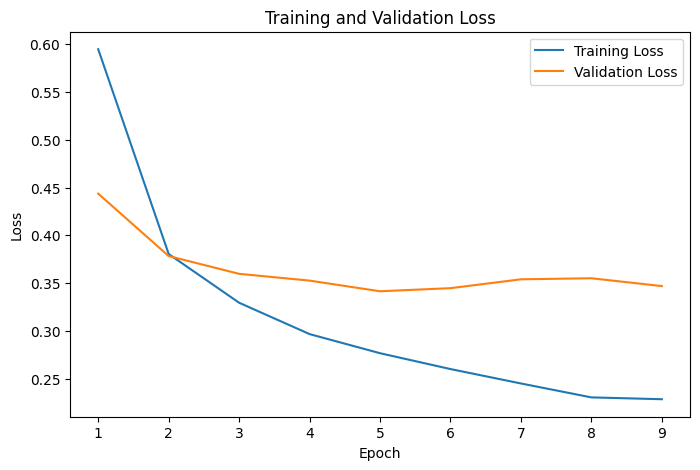

In [9]:
lr = 0.005
 # AdamW optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

# Learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,
                                                   max_lr=lr,
                                                   total_steps=14*len(train_loader))
train_and_validate(model, optimizer, lr_scheduler, train_loader, val_loader, device, num_epochs=14, patience=4)


In [ ]:

torch.cuda.empty_cache()


In [ ]:

def calculate_iou2(pred_mask, true_mask):
    pred_mask = pred_mask.cpu().numpy() if isinstance(pred_mask, torch.Tensor) else pred_mask
    true_mask = true_mask.cpu().numpy() if isinstance(true_mask, torch.Tensor) else true_mask
    intersection = np.logical_and(pred_mask, true_mask).sum()
    union = np.logical_or(pred_mask, true_mask).sum()
    iou = intersection / (union + 1e-6)
    return iou


def evaluate2(model, data_loader, device):
    model.eval()
    iou_scores = {'head': [], 'flippers': [], 'turtle': []}
    filtered_masks = []
    with torch.no_grad():
        for images, targets in tqdm(data_loader, desc="Evaluating", leave=False):
            images = [img.to(device) for img in images] #n+3+512+512
            outputs = model(images)
            c=0
            for i, output in enumerate(outputs):

                labels = output['labels']
                scores = output['scores']
                select_score_indices = scores > 0.5
                pred_masks = output['masks'][select_score_indices].squeeze(1)
                pred_labels = output['labels'][select_score_indices]


                head_indices = torch.where(pred_labels == 3)[0]
                flipper_indices = torch.where(pred_labels == 2)[0]
                turtle_indices = torch.where(pred_labels == 1)[0]
                head_mask_f = pred_masks[head_indices].cpu().numpy()
                flipper_mask = pred_masks[flipper_indices].cpu().numpy()
                turtle_mask_f = pred_masks[turtle_indices].cpu().numpy()
                flipper_mask_f  = np.zeros((600, 900), dtype=bool)
                for item in flipper_mask:
                  flipper_mask_f = np.logical_or(flipper_mask_f, item)


                true_masks = targets[i]["masks"]
                true_labels = targets[i]["labels"]

                truehead_indices = torch.where(true_labels == 3)[0].cpu()
                trueflipper_indices = torch.where(true_labels == 2)[0].cpu()
                trueturtle_indices = torch.where(true_labels == 1)[0].cpu()
                true_head_mask_f = true_masks[truehead_indices]
                true_flipper_mask = true_masks[trueflipper_indices]
                true_turtle_mask_f = true_masks[trueturtle_indices]
                true_flipper_mask_f  = np.zeros((600, 900), dtype=bool)
                for item in true_flipper_mask:
                  true_flipper_mask_f = np.logical_or(true_flipper_mask_f, item)

                iou_scores['head'].append(calculate_iou2(true_head_mask_f, head_mask_f))
                iou_scores['flippers'].append(calculate_iou2(true_flipper_mask_f, flipper_mask_f))
                iou_scores['turtle'].append(calculate_iou2(true_turtle_mask_f, turtle_mask_f))

    mean_iou_scores = {key: np.mean(value) for key, value in iou_scores.items()}
    torch.cuda.empty_cache()

    return mean_iou_scores
test_loader = DataLoader(test_set, **data_loader_params)
model.load_state_dict(torch.load("/content/best_model.pth", weights_only=True))

test_iou_scores = evaluate2(model, test_loader, device)
print("Mean IoU scores on test set:", test_iou_scores)

Mean IoU scores on test set: {'head': 0.6296005875106431, 'flippers': 0.43176494731701986, 'turtle': 0.46914818875356845}
